In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_12817/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


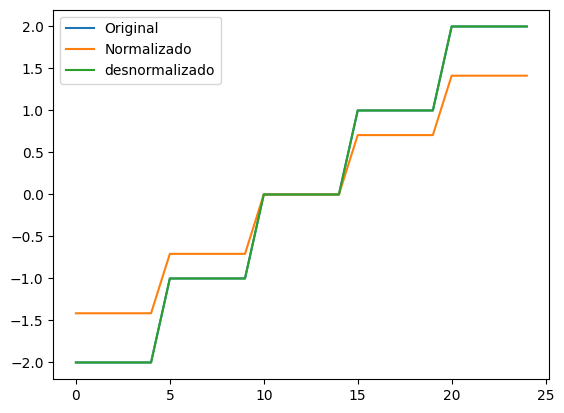

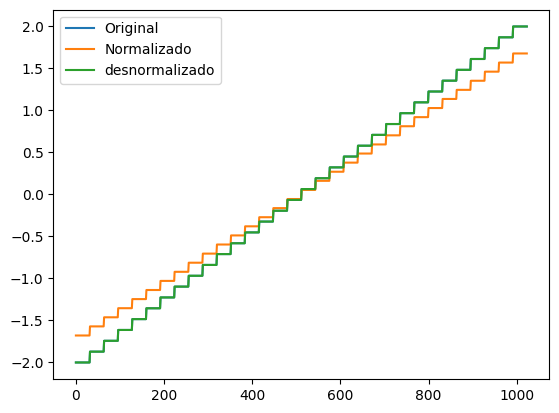

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-22 20:41:36.827124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 20:41:36.827598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 20:41:37.101716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 20:41:37.577829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 20:41:40.787720: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [7]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.5,
            hidden_sizes = [[34, 32], [16, 12], [24, 22], [12, 2], [20, 7], [20, 16]],
            regularizers=[0.2, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[34, 32], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_3_23  0.842474  0.731817  0.933863  0.901092  0.915101  0.223586   
model_1_3_22  0.839856  0.729180  0.936235  0.901282  0.916095  0.227301   
model_1_3_21  0.837176  0.726479  0.938557  0.901465  0.917067  0.231105   
model_1_3_20  0.834432  0.723713  0.940826  0.901640  0.918013  0.235000   
model_1_3_19  0.831623  0.720880  0.943039  0.901805  0.918933  0.238987   
model_1_3_18  0.828746  0.717979  0.945194  0.901961  0.919826  0.243070   
model_1_3_17  0.825801  0.715008  0.947287  0.902106  0.920689  0.247250   
model_1_3_16  0.822786  0.711966  0.949314  0.902240  0.921522  0.251529   
model_1_3_15  0.819700  0.708850  0.951273  0.902363  0.922322  0.255910   
model_1_3_14  0.816539  0.705659  0.953159  0.902473  0.923087  0.260396   
model_1_3_13  0.813304  0.702392  0.954969  0.902570  0.923816  0.264988   
model_1_3_12  0.809991  0.699046  0.956698  0.902652  0.924507  0.269690   
model_1_3_11  0.806599  0.695619  0.958343  0.902719  0.925156  0.274504   
model_1_3_10  0.803127  0.692111  0.959898  0.902769  0.925762  0.279433   
model_1_3_9   0.799571  0.688518  0.961359  0.902801  0.926323  0.284480   
model_1_3_8   0.795930  0.684840  0.962721  0.902814  0.926835  0.289647   
model_1_3_7   0.792203  0.681074  0.963979  0.902806  0.927296  0.294938   
model_1_3_6   0.788386  0.677218  0.965127  0.902776  0.927703  0.300355   
model_1_3_5   0.784478  0.673271  0.966161  0.902723  0.928053  0.305902   
model_1_3_4   0.780476  0.669230  0.967074  0.902645  0.928343  0.311582   
model_1_3_3   0.776379  0.665094  0.967862  0.902541  0.928571  0.317398   
model_1_3_2   0.772183  0.660860  0.968520  0.902408  0.928733  0.323353   
model_1_3_1   0.767887  0.656527  0.969040  0.902245  0.928827  0.329450   
model_1_3_0   0.763488  0.652093  0.969419  0.902050  0.928848  0.335694   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_3_23  0.380647  0.046311  0.114287  0.080299  2.136205  0.472848   
model_1_3_22  0.384390  0.044649  0.114067  0.079358  2.154358  0.476761   
model_1_3_21  0.388223  0.043023  0.113856  0.078439  2.172680  0.480734   
model_1_3_20  0.392149  0.041435  0.113654  0.077544  2.191178  0.484768   
model_1_3_19  0.396170  0.039885  0.113463  0.076674  2.209850  0.488863   
model_1_3_18  0.400287  0.038376  0.113283  0.075830  2.228699  0.493021   
model_1_3_17  0.404504  0.036911  0.113115  0.075013  2.247727  0.497242   
model_1_3_16  0.408823  0.035492  0.112960  0.074226  2.266940  0.501527   
model_1_3_15  0.413245  0.034120  0.112818  0.073469  2.286337  0.505876   
model_1_3_14  0.417774  0.032799  0.112691  0.072745  2.305920  0.510290   
model_1_3_13  0.422412  0.031532  0.112580  0.072056  2.326102  0.514770   
model_1_3_12  0.427161  0.030321  0.112485  0.071403  2.346790  0.519317   
model_1_3_11  0.432024  0.029169  0.112407  0.070788  2.367679  0.523932   
model_1_3_10  0.437004  0.028080  0.112350  0.070215  2.388773  0.528614   
model_1_3_9   0.442103  0.027057  0.112313  0.069685  2.410073  0.533367   
model_1_3_8   0.447324  0.026104  0.112298  0.069201  2.431587  0.538189   
model_1_3_7   0.452669  0.025223  0.112307  0.068765  2.453312  0.543082   
model_1_3_6   0.458142  0.024419  0.112341  0.068380  2.475259  0.548047   
model_1_3_5   0.463744  0.023695  0.112402  0.068049  2.497428  0.553084   
model_1_3_4   0.469480  0.023055  0.112492  0.067774  2.519825  0.558195   
model_1_3_3   0.475351  0.022503  0.112613  0.067558  2.542450  0.563381   
model_1_3_2   0.481360  0.022043  0.112767  0.067405  2.565310  0.568641   
model_1_3_1   0.487510  0.021679  0.112955  0.067317  2.588406  0.573978   
model_1_3_0   0.493804  0.021414  0.113180  0.067297  2.611746  0.579391   

                r2_adj       rsd          aic          bic  
model_1_3_23  1.003071  0.492979  2512.995922  4042.685082  
model_1_3_22  1.003122  0.497058  2512.962961  4042.652121  
model_1_3_21  1.003174  0.501199  2

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_4_24  0.877378  0.766503  0.208997  0.934175  0.902637  0.174045   
model_1_4_23  0.876441  0.765564  0.222568  0.934053  0.903506  0.175374   
model_1_4_22  0.875474  0.764595  0.236225  0.933916  0.904372  0.176747   
model_1_4_21  0.874476  0.763595  0.249964  0.933765  0.905235  0.178164   
model_1_4_20  0.873445  0.762563  0.263781  0.933598  0.906092  0.179626   
model_1_4_19  0.872382  0.761498  0.277670  0.933415  0.906945  0.181136   
model_1_4_18  0.871284  0.760400  0.291626  0.933216  0.907792  0.182694   
model_1_4_17  0.870151  0.759266  0.305641  0.933001  0.908633  0.184302   
model_1_4_16  0.868982  0.758098  0.319710  0.932769  0.909467  0.185961   
model_1_4_15  0.867776  0.756893  0.333827  0.932521  0.910294  0.187673   
model_1_4_14  0.866532  0.755650  0.347982  0.932255  0.911112  0.189439   
model_1_4_13  0.865248  0.754369  0.362169  0.931971  0.911921  0.191260   
model_1_4_12  0.863925  0.753049  0.376377  0.931670  0.912720  0.193139   
model_1_4_11  0.862559  0.751688  0.390598  0.931350  0.913509  0.195077   
model_1_4_10  0.861151  0.750286  0.404823  0.931012  0.914285  0.197076   
model_1_4_9   0.859699  0.748842  0.419041  0.930655  0.915050  0.199137   
model_1_4_8   0.858202  0.747354  0.433241  0.930279  0.915801  0.201262   
model_1_4_7   0.856658  0.745821  0.447413  0.929884  0.916537  0.203453   
model_1_4_6   0.855067  0.744243  0.461546  0.929469  0.917258  0.205712   
model_1_4_5   0.853426  0.742617  0.475627  0.929034  0.917963  0.208041   
model_1_4_4   0.851735  0.740944  0.489644  0.928580  0.918651  0.210441   
model_1_4_3   0.849992  0.739222  0.503585  0.928105  0.919321  0.212915   
model_1_4_2   0.848196  0.737449  0.517438  0.927609  0.919971  0.215464   
model_1_4_1   0.846345  0.735625  0.531189  0.927094  0.920601  0.218091   
model_1_4_0   0.844438  0.733748  0.544825  0.926557  0.921209  0.220797   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_4_24  0.331415  0.267416  0.203994  0.235705  1.675356  0.417187   
model_1_4_23  0.332748  0.262828  0.204372  0.233600  1.691707  0.418777   
model_1_4_22  0.334123  0.258211  0.204796  0.231503  1.708224  0.420412   
model_1_4_21  0.335542  0.253566  0.205266  0.229416  1.724901  0.422094   
model_1_4_20  0.337007  0.248895  0.205784  0.227340  1.741745  0.423823   
model_1_4_19  0.338519  0.244199  0.206350  0.225275  1.758757  0.425601   
model_1_4_18  0.340078  0.239481  0.206966  0.223224  1.775937  0.427427   
model_1_4_17  0.341686  0.234743  0.207633  0.221188  1.793286  0.429304   
model_1_4_16  0.343345  0.229987  0.208351  0.219169  1.810804  0.431232   
model_1_4_15  0.345056  0.225214  0.209122  0.217168  1.828498  0.433212   
model_1_4_14  0.346819  0.220429  0.209946  0.215187  1.846364  0.435246   
model_1_4_13  0.348637  0.215633  0.210825  0.213229  1.864407  0.437333   
model_1_4_12  0.350511  0.210829  0.211759  0.211294  1.882623  0.439476   
model_1_4_11  0.352442  0.206022  0.212750  0.209386  1.901023  0.441675   
model_1_4_10  0.354432  0.201213  0.213797  0.207505  1.919598  0.443932   
model_1_4_9   0.356482  0.196406  0.214903  0.205655  1.938354  0.446247   
model_1_4_8   0.358594  0.191605  0.216069  0.203837  1.957296  0.448622   
model_1_4_7   0.360770  0.186814  0.217294  0.202054  1.976418  0.451058   
model_1_4_6   0.363010  0.182036  0.218579  0.200308  1.995729  0.453555   
model_1_4_5   0.365317  0.177276  0.219926  0.198601  2.015225  0.456115   
model_1_4_4   0.367692  0.172537  0.221335  0.196936  2.034912  0.458738   
model_1_4_3   0.370137  0.167824  0.222807  0.195315  2.054785  0.461427   
model_1_4_2   0.372653  0.163140  0.224342  0.193741  2.074850  0.464181   
model_1_4_1   0.375242  0.158492  0.225940  0.192216  2.095108  0.467002   
model_1_4_0   0.377906  0.153882  0.227603  0.190743  2.115559  0.469891   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_5_24  0.925635  0.808619  0.944783  0.970523  0.962178  0.105551   
model_1_5_23  0.924329  0.807568  0.945115  0.969821  0.961826  0.107403   
model_1_5_22  0.922981  0.806475  0.945399  0.969084  0.961434  0.109317   
model_1_5_21  0.921589  0.805342  0.945633  0.968309  0.961001  0.111293   
model_1_5_20  0.920152  0.804165  0.945813  0.967496  0.960525  0.113333   
model_1_5_19  0.918669  0.802944  0.945938  0.966644  0.960004  0.115438   
model_1_5_18  0.917139  0.801677  0.946005  0.965753  0.959439  0.117610   
model_1_5_17  0.915560  0.800364  0.946012  0.964822  0.958827  0.119850   
model_1_5_16  0.913932  0.799002  0.945955  0.963849  0.958167  0.122161   
model_1_5_15  0.912254  0.797591  0.945833  0.962835  0.957457  0.124543   
model_1_5_14  0.910523  0.796128  0.945642  0.961779  0.956697  0.127000   
model_1_5_13  0.908739  0.794611  0.945379  0.960680  0.955884  0.129531   
model_1_5_12  0.906901  0.793040  0.945040  0.959537  0.955018  0.132141   
model_1_5_11  0.905007  0.791411  0.944623  0.958350  0.954096  0.134829   
model_1_5_10  0.903056  0.789724  0.944124  0.957118  0.953117  0.137598   
model_1_5_9   0.901046  0.787976  0.943538  0.955841  0.952080  0.140451   
model_1_5_8   0.898976  0.786163  0.942863  0.954517  0.950982  0.143388   
model_1_5_7   0.896845  0.784285  0.942093  0.953146  0.949821  0.146414   
model_1_5_6   0.894651  0.782339  0.941224  0.951728  0.948597  0.149528   
model_1_5_5   0.892392  0.780320  0.940252  0.950262  0.947306  0.152735   
model_1_5_4   0.890066  0.778227  0.939171  0.948747  0.945947  0.156035   
model_1_5_3   0.887672  0.776055  0.937976  0.947181  0.944516  0.159433   
model_1_5_2   0.885209  0.773801  0.936663  0.945565  0.943013  0.162930   
model_1_5_1   0.882673  0.771460  0.935226  0.943896  0.941434  0.166528   
model_1_5_0   0.880063  0.769029  0.933658  0.942173  0.939776  0.170233   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_5_24  0.271637  0.080240  0.084890  0.082565  1.266535  0.324885   
model_1_5_23  0.273130  0.079756  0.086909  0.083333  1.280444  0.327725   
model_1_5_22  0.274680  0.079344  0.089034  0.084189  1.294979  0.330632   
model_1_5_21  0.276289  0.079005  0.091265  0.085135  1.309660  0.333606   
model_1_5_20  0.277960  0.078743  0.093607  0.086175  1.324489  0.336649   
model_1_5_19  0.279693  0.078561  0.096059  0.087310  1.339469  0.339761   
model_1_5_18  0.281490  0.078464  0.098626  0.088545  1.354599  0.342943   
model_1_5_17  0.283354  0.078454  0.101308  0.089881  1.369882  0.346194   
model_1_5_16  0.285287  0.078536  0.104108  0.091322  1.385318  0.349515   
model_1_5_15  0.287290  0.078714  0.107028  0.092871  1.400910  0.352907   
model_1_5_14  0.289367  0.078991  0.110070  0.094531  1.416662  0.356370   
model_1_5_13  0.291520  0.079374  0.113235  0.096305  1.432570  0.359905   
model_1_5_12  0.293750  0.079865  0.116527  0.098196  1.448638  0.363511   
model_1_5_11  0.296061  0.080471  0.119945  0.100208  1.465022  0.367190   
model_1_5_10  0.298456  0.081197  0.123493  0.102345  1.481636  0.370942   
model_1_5_9   0.300938  0.082048  0.127172  0.104610  1.498409  0.374767   
model_1_5_8   0.303510  0.083030  0.130985  0.107007  1.515344  0.378667   
model_1_5_7   0.306176  0.084148  0.134931  0.109540  1.532443  0.382640   
model_1_5_6   0.308939  0.085411  0.139015  0.112213  1.549705  0.386689   
model_1_5_5   0.311804  0.086824  0.143238  0.115031  1.567137  0.390813   
model_1_5_4   0.314775  0.088395  0.147602  0.117998  1.584741  0.395013   
model_1_5_3   0.317858  0.090131  0.152110  0.121120  1.602510  0.399290   
model_1_5_2   0.321057  0.092039  0.156765  0.124402  1.620456  0.403645   
model_1_5_1   0.324379  0.094128  0.161571  0.127850  1.638577  0.408079   
model_1_5_0   0.327829  0.096406  0.166533  0.131469  1.656874  0.412592   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_6_24  0.941525  0.823413  0.901897  0.636523  0.911976  0.082997   
model_1_6_23  0.941104  0.823047  0.902923  0.640101  0.912875  0.083594   
model_1_6_22  0.940668  0.822665  0.903945  0.643642  0.913769  0.084213   
model_1_6_21  0.940216  0.822265  0.904963  0.647152  0.914657  0.084854   
model_1_6_20  0.939749  0.821848  0.905976  0.650631  0.915540  0.085518   
model_1_6_19  0.939265  0.821413  0.906983  0.654082  0.916417  0.086204   
model_1_6_18  0.938765  0.820959  0.907983  0.657507  0.917287  0.086914   
model_1_6_17  0.938248  0.820487  0.908976  0.660911  0.918152  0.087648   
model_1_6_16  0.937714  0.819997  0.909961  0.664296  0.919010  0.088406   
model_1_6_15  0.937163  0.819487  0.910937  0.667665  0.919862  0.089188   
model_1_6_14  0.936593  0.818958  0.911903  0.671022  0.920708  0.089997   
model_1_6_13  0.936006  0.818410  0.912858  0.674373  0.921547  0.090831   
model_1_6_12  0.935400  0.817842  0.913802  0.677721  0.922379  0.091691   
model_1_6_11  0.934775  0.817254  0.914732  0.681071  0.923205  0.092578   
model_1_6_10  0.934130  0.816645  0.915648  0.684427  0.924023  0.093493   
model_1_6_9   0.933466  0.816017  0.916548  0.687796  0.924834  0.094435   
model_1_6_8   0.932782  0.815368  0.917432  0.691180  0.925637  0.095407   
model_1_6_7   0.932077  0.814698  0.918297  0.694588  0.926433  0.096407   
model_1_6_6   0.931351  0.814008  0.919142  0.698023  0.927220  0.097437   
model_1_6_5   0.930603  0.813298  0.919965  0.701489  0.927999  0.098498   
model_1_6_4   0.929834  0.812568  0.920766  0.704993  0.928769  0.099591   
model_1_6_3   0.929042  0.811818  0.921541  0.708538  0.929529  0.100715   
model_1_6_2   0.928227  0.811047  0.922289  0.712130  0.930278  0.101872   
model_1_6_1   0.927387  0.810257  0.923009  0.715770  0.931017  0.103063   
model_1_6_0   0.926524  0.809448  0.923697  0.719461  0.931744  0.104289   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_6_24  0.250639  0.134454  0.087954  0.111204  1.075920  0.288092   
model_1_6_23  0.251159  0.133047  0.087088  0.110068  1.083294  0.289127   
model_1_6_22  0.251702  0.131646  0.086231  0.108939  1.090685  0.290195   
model_1_6_21  0.252269  0.130252  0.085382  0.107817  1.098092  0.291298   
model_1_6_20  0.252861  0.128864  0.084540  0.106702  1.105512  0.292434   
model_1_6_19  0.253479  0.127484  0.083705  0.105594  1.112945  0.293606   
model_1_6_18  0.254122  0.126113  0.082876  0.104495  1.120386  0.294812   
model_1_6_17  0.254792  0.124752  0.082053  0.103402  1.127836  0.296053   
model_1_6_16  0.255488  0.123402  0.081234  0.102318  1.135293  0.297331   
model_1_6_15  0.256211  0.122064  0.080419  0.101241  1.142752  0.298644   
model_1_6_14  0.256962  0.120740  0.079606  0.100173  1.150222  0.299994   
model_1_6_13  0.257741  0.119431  0.078795  0.099113  1.157694  0.301381   
model_1_6_12  0.258547  0.118138  0.077985  0.098061  1.165167  0.302805   
model_1_6_11  0.259382  0.116863  0.077175  0.097019  1.172646  0.304266   
model_1_6_10  0.260246  0.115608  0.076362  0.095985  1.180130  0.305766   
model_1_6_9   0.261138  0.114374  0.075547  0.094961  1.187617  0.307303   
model_1_6_8   0.262059  0.113163  0.074728  0.093946  1.195114  0.308880   
model_1_6_7   0.263009  0.111978  0.073904  0.092941  1.202617  0.310495   
model_1_6_6   0.263988  0.110819  0.073073  0.091946  1.210129  0.312150   
model_1_6_5   0.264996  0.109691  0.072234  0.090962  1.217661  0.313844   
model_1_6_4   0.266033  0.108594  0.071386  0.089990  1.225211  0.315580   
model_1_6_3   0.267098  0.107531  0.070528  0.089029  1.232788  0.317356   
model_1_6_2   0.268191  0.106505  0.069659  0.088082  1.240658  0.319174   
model_1_6_1   0.269312  0.105519  0.068778  0.087149  1.249194  0.321034   
model_1_6_0   0.270461  0.104576  0.067885  0.086230  1.257817  0.322938   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_7_16  0.955270  0.826504  0.920145  0.670982  0.929748  0.063488   
model_1_7_15  0.954692  0.826499  0.921766  0.673685  0.931047  0.064308   
model_1_7_17  0.955823  0.826490  0.918444  0.667641  0.928368  0.062702   
model_1_7_14  0.954089  0.826476  0.923304  0.675726  0.932263  0.065164   
model_1_7_18  0.956353  0.826459  0.916666  0.663688  0.926912  0.061950   
model_1_7_13  0.953460  0.826432  0.924755  0.677086  0.933391  0.066057   
model_1_7_19  0.956860  0.826411  0.914814  0.659143  0.925381  0.061231   
model_1_7_12  0.952805  0.826369  0.926115  0.677738  0.934429  0.066987   
model_1_7_20  0.957345  0.826345  0.912891  0.654029  0.923780  0.060543   
model_1_7_11  0.952122  0.826285  0.927381  0.677657  0.935374  0.067956   
model_1_7_21  0.957808  0.826264  0.910902  0.648364  0.922110  0.059886   
model_1_7_10  0.951412  0.826179  0.928549  0.676818  0.936221  0.068964   
model_1_7_22  0.958249  0.826167  0.908848  0.642170  0.920376  0.059259   
model_1_7_23  0.958671  0.826055  0.906733  0.635467  0.918580  0.058661   
model_1_7_9   0.950673  0.826051  0.929616  0.675192  0.936967  0.070013   
model_1_7_24  0.959072  0.825929  0.904559  0.628272  0.916724  0.058091   
model_1_7_8   0.949904  0.825901  0.930578  0.672753  0.937608  0.071104   
model_1_7_7   0.949105  0.825727  0.931431  0.669474  0.938142  0.072238   
model_1_7_6   0.948275  0.825529  0.932172  0.665325  0.938563  0.073416   
model_1_7_5   0.947413  0.825307  0.932796  0.660277  0.938869  0.074640   
model_1_7_4   0.946518  0.825059  0.933301  0.654299  0.939055  0.075909   
model_1_7_3   0.945590  0.824785  0.933681  0.647361  0.939117  0.077227   
model_1_7_2   0.944628  0.824484  0.933933  0.639430  0.939052  0.078593   
model_1_7_1   0.943630  0.824155  0.934054  0.630471  0.938856  0.080009   
model_1_7_0   0.942596  0.823799  0.934039  0.620453  0.938525  0.081477   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_7_16  0.246252  0.064190  0.011306  0.037748  0.705515  0.251968   
model_1_7_15  0.246259  0.062887  0.011213  0.037050  0.723223  0.253591   
model_1_7_17  0.246272  0.065557  0.011421  0.038489  0.688005  0.250404   
model_1_7_14  0.246293  0.061651  0.011143  0.036397  0.741123  0.255273   
model_1_7_18  0.246316  0.066987  0.011557  0.039272  0.670695  0.248898   
model_1_7_13  0.246354  0.060485  0.011096  0.035790  0.759212  0.257015   
model_1_7_19  0.246385  0.068476  0.011713  0.040094  0.653584  0.247448   
model_1_7_12  0.246444  0.059391  0.011074  0.035233  0.778420  0.258818   
model_1_7_20  0.246478  0.070021  0.011889  0.040955  0.636672  0.246055   
model_1_7_11  0.246564  0.058373  0.011077  0.034725  0.798009  0.260683   
model_1_7_21  0.246593  0.071620  0.012083  0.041852  0.619966  0.244716   
model_1_7_10  0.246714  0.057435  0.011106  0.034270  0.817790  0.262610   
model_1_7_22  0.246731  0.073271  0.012296  0.042784  0.603459  0.243431   
model_1_7_23  0.246889  0.074971  0.012527  0.043749  0.587161  0.242200   
model_1_7_9   0.246895  0.056577  0.011161  0.033869  0.837756  0.264600   
model_1_7_24  0.247069  0.076719  0.012774  0.044746  0.574991  0.241021   
model_1_7_8   0.247109  0.055804  0.011245  0.033524  0.857911  0.266654   
model_1_7_7   0.247355  0.055118  0.011358  0.033238  0.878240  0.268771   
model_1_7_6   0.247636  0.054522  0.011501  0.033011  0.898747  0.270954   
model_1_7_5   0.247952  0.054020  0.011674  0.032847  0.920866  0.273202   
model_1_7_4   0.248304  0.053615  0.011879  0.032747  0.943348  0.275516   
model_1_7_3   0.248693  0.053310  0.012118  0.032714  0.969164  0.277897   
model_1_7_2   0.249120  0.053107  0.012390  0.032749  0.995570  0.280344   
model_1_7_1   0.249586  0.053010  0.012698  0.032854  1.022168  0.282859   
model_1_7_0   0.250092  0.053022  0.013042  0.033032  1.048954  0.285442   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_7   0.965351  0.826298  0.975947  0.987761  0.986106  0.049180   
model_1_8_6   0.964639  0.826297  0.976434  0.987113  0.985801  0.050189   
model_1_8_8   0.966042  0.826289  0.975446  0.988379  0.986388  0.048198   
model_1_8_5   0.963908  0.826283  0.976904  0.986434  0.985472  0.051227   
model_1_8_9   0.966714  0.826268  0.974929  0.988968  0.986647  0.047244   
model_1_8_4   0.963156  0.826257  0.977358  0.985725  0.985119  0.052294   
model_1_8_10  0.967368  0.826235  0.974399  0.989528  0.986884  0.046317   
model_1_8_3   0.962384  0.826218  0.977794  0.984983  0.984740  0.053391   
model_1_8_11  0.968002  0.826193  0.973855  0.990061  0.987100  0.045416   
model_1_8_2   0.961589  0.826166  0.978212  0.984209  0.984336  0.054518   
model_1_8_12  0.968619  0.826139  0.973297  0.990567  0.987295  0.044540   
model_1_8_1   0.960773  0.826101  0.978612  0.983401  0.983904  0.055677   
model_1_8_13  0.969219  0.826076  0.972728  0.991047  0.987469  0.043689   
model_1_8_0   0.959934  0.826022  0.978992  0.982558  0.983446  0.056868   
model_1_8_14  0.969801  0.826003  0.972147  0.991500  0.987624  0.042863   
model_1_8_15  0.970367  0.825921  0.971554  0.991929  0.987759  0.042060   
model_1_8_16  0.970916  0.825829  0.970951  0.992333  0.987876  0.041281   
model_1_8_17  0.971449  0.825729  0.970337  0.992713  0.987975  0.040524   
model_1_8_18  0.971966  0.825620  0.969713  0.993070  0.988056  0.039790   
model_1_8_19  0.972468  0.825503  0.969080  0.993405  0.988120  0.039077   
model_1_8_20  0.972956  0.825377  0.968438  0.993717  0.988167  0.038385   
model_1_8_21  0.973428  0.825244  0.967788  0.994008  0.988198  0.037715   
model_1_8_22  0.973887  0.825103  0.967129  0.994277  0.988214  0.037064   
model_1_8_23  0.974331  0.824955  0.966464  0.994527  0.988214  0.036433   
model_1_8_24  0.974762  0.824800  0.965790  0.994756  0.988200  0.035822   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_7   0.246544  0.016817  0.022893  0.019855  0.615604  0.221765   
model_1_8_6   0.246547  0.016477  0.024105  0.020291  0.611038  0.224029   
model_1_8_8   0.246558  0.017167  0.021737  0.019452  0.620027  0.219542   
model_1_8_5   0.246566  0.016148  0.025374  0.020761  0.606323  0.226334   
model_1_8_9   0.246588  0.017529  0.020636  0.019082  0.624316  0.217358   
model_1_8_4   0.246603  0.015831  0.026702  0.021266  0.601452  0.228679   
model_1_8_10  0.246634  0.017899  0.019587  0.018743  0.628473  0.215214   
model_1_8_3   0.246658  0.015525  0.028089  0.021807  0.596422  0.231065   
model_1_8_11  0.246694  0.018280  0.018590  0.018435  0.632505  0.213110   
model_1_8_2   0.246732  0.015233  0.029538  0.022385  0.591226  0.233492   
model_1_8_12  0.246770  0.018669  0.017644  0.018157  0.636414  0.211045   
model_1_8_1   0.246825  0.014954  0.031049  0.023001  0.585856  0.235960   
model_1_8_13  0.246860  0.019067  0.016747  0.017907  0.640213  0.209020   
model_1_8_0   0.246937  0.014688  0.032625  0.023656  0.580304  0.238470   
model_1_8_14  0.246963  0.019474  0.015899  0.017686  0.643896  0.207033   
model_1_8_15  0.247080  0.019888  0.015097  0.017493  0.647476  0.205086   
model_1_8_16  0.247210  0.020310  0.014341  0.017326  0.650954  0.203177   
model_1_8_17  0.247352  0.020739  0.013630  0.017184  0.654333  0.201306   
model_1_8_18  0.247507  0.021175  0.012962  0.017069  0.657620  0.199474   
model_1_8_19  0.247674  0.021618  0.012337  0.016977  0.660818  0.197679   
model_1_8_20  0.247852  0.022067  0.011753  0.016910  0.663929  0.195922   
model_1_8_21  0.248041  0.022521  0.011209  0.016865  0.666958  0.194203   
model_1_8_22  0.248240  0.022982  0.010704  0.016843  0.669904  0.192521   
model_1_8_23  0.248451  0.023447  0.010238  0.016843  0.672779  0.190875   
model_1_8_24  0.248671  0.023918  0.009809  0.016863  0.675578  0.189267   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_0   0.974908  0.824490  0.992941  0.733278  0.964077  0.035615   
model_1_9_1   0.975041  0.824172  0.992795  0.726455  0.963185  0.035425   
model_1_9_2   0.975163  0.823847  0.992639  0.719487  0.962269  0.035253   
model_1_9_3   0.975272  0.823516  0.992475  0.712378  0.961330  0.035098   
model_1_9_4   0.975370  0.823178  0.992301  0.705135  0.960368  0.034958   
model_1_9_5   0.975457  0.822834  0.992119  0.697761  0.959385  0.034835   
model_1_9_6   0.975533  0.822483  0.991928  0.690263  0.958381  0.034727   
model_1_9_7   0.975598  0.822128  0.991730  0.682645  0.957358  0.034634   
model_1_9_8   0.975654  0.821766  0.991524  0.674911  0.956315  0.034556   
model_1_9_9   0.975699  0.821400  0.991311  0.667065  0.955254  0.034492   
model_1_9_10  0.975734  0.821028  0.991091  0.659115  0.954176  0.034442   
model_1_9_11  0.975760  0.820652  0.990863  0.651063  0.953080  0.034405   
model_1_9_12  0.975777  0.820271  0.990630  0.642914  0.951969  0.034381   
model_1_9_13  0.975785  0.819886  0.990389  0.634672  0.950842  0.034370   
model_1_9_14  0.975784  0.819497  0.990143  0.626341  0.949700  0.034371   
model_1_9_15  0.975775  0.819104  0.989891  0.617926  0.948544  0.034383   
model_1_9_16  0.975758  0.818707  0.989634  0.609430  0.947375  0.034408   
model_1_9_17  0.975733  0.818307  0.989371  0.600858  0.946192  0.034443   
model_1_9_18  0.975701  0.817903  0.989103  0.592214  0.944998  0.034489   
model_1_9_19  0.975661  0.817496  0.988830  0.583502  0.943792  0.034546   
model_1_9_20  0.975613  0.817086  0.988553  0.574725  0.942574  0.034613   
model_1_9_21  0.975559  0.816673  0.988271  0.565886  0.941347  0.034690   
model_1_9_22  0.975498  0.816258  0.987984  0.556990  0.940109  0.034777   
model_1_9_23  0.975431  0.815840  0.987694  0.548040  0.938862  0.034872   
model_1_9_24  0.975357  0.815420  0.987399  0.539039  0.937607  0.034977   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_0   0.249111  0.011026  0.061489  0.036258  0.671232  0.188719   
model_1_9_1   0.249562  0.011254  0.063062  0.037158  0.666930  0.188216   
model_1_9_2   0.250023  0.011497  0.064668  0.038083  0.662671  0.187758   
model_1_9_3   0.250494  0.011755  0.066307  0.039031  0.658454  0.187344   
model_1_9_4   0.250973  0.012026  0.067977  0.040001  0.654276  0.186972   
model_1_9_5   0.251462  0.012310  0.069677  0.040994  0.650143  0.186642   
model_1_9_6   0.251959  0.012608  0.071405  0.042006  0.646051  0.186353   
model_1_9_7   0.252464  0.012917  0.073162  0.043039  0.642001  0.186103   
model_1_9_8   0.252977  0.013239  0.074945  0.044092  0.637986  0.185893   
model_1_9_9   0.253497  0.013572  0.076753  0.045163  0.634017  0.185721   
model_1_9_10  0.254024  0.013917  0.078586  0.046251  0.630083  0.185585   
model_1_9_11  0.254558  0.014271  0.080442  0.047357  0.626190  0.185486   
model_1_9_12  0.255099  0.014637  0.082321  0.048479  0.622338  0.185421   
model_1_9_13  0.255645  0.015012  0.084221  0.049616  0.618522  0.185390   
model_1_9_14  0.256198  0.015396  0.086142  0.050769  0.614745  0.185393   
model_1_9_15  0.256756  0.015790  0.088081  0.051936  0.611007  0.185427   
model_1_9_16  0.257319  0.016192  0.090040  0.053116  0.607304  0.185493   
model_1_9_17  0.257887  0.016602  0.092016  0.054309  0.603639  0.185589   
model_1_9_18  0.258460  0.017021  0.094009  0.055515  0.600010  0.185713   
model_1_9_19  0.259038  0.017447  0.096017  0.056732  0.596417  0.185866   
model_1_9_20  0.259620  0.017881  0.098041  0.057961  0.592864  0.186047   
model_1_9_21  0.260205  0.018321  0.100079  0.059200  0.589417  0.186253   
model_1_9_22  0.260795  0.018769  0.102129  0.060449  0.586017  0.186485   
model_1_9_23  0.261388  0.019222  0.104193  0.061708  0.582651  0.186741   
model_1_9_24  0.261984  0.019682  0.106268  0.062975  0.579316  0.187021   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[34, 32], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_0_9   0.815681  0.679508 -3.890808  0.651079  0.342364  0.261614   
model_2_0_10  0.816620  0.679374 -3.809032  0.643008  0.340621  0.260282   
model_2_0_8   0.814344  0.679360 -3.984068  0.659741  0.343855  0.263511   
model_2_0_11  0.817250  0.679038 -3.737191  0.635521  0.338725  0.259387   
model_2_0_7   0.812495  0.678830 -4.090650  0.668985  0.344960  0.266136   
model_2_0_12  0.817643  0.678560 -3.673953  0.628602  0.336756  0.258829   
model_2_0_13  0.817857  0.677990 -3.618190  0.622229  0.334770  0.258526   
model_2_0_6   0.809991  0.677790 -4.212727  0.678787  0.345505  0.269690   
model_2_0_14  0.817935  0.677361 -3.568941  0.616375  0.332811  0.258414   
model_2_0_5   0.806653  0.676075 -4.352867  0.689096  0.345266  0.274428   
model_2_0_4   0.802259  0.673479 -4.514119  0.699830  0.343957  0.280665   
model_2_0_3   0.796528  0.669742 -4.700116  0.710865  0.341214  0.288799   
model_2_0_2   0.789113  0.664535 -4.915193  0.722019  0.336571  0.299324   
model_2_0_1   0.779578  0.657446 -5.164520  0.733040  0.329440  0.312857   
model_2_0_0   0.767382  0.647957 -5.454287  0.743585  0.319077  0.330168   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_0_9   0.454892  0.806523  0.762876  0.784700  1.569278  0.511482   
model_2_0_10  0.455082  0.793038  0.780523  0.786780  1.512426  0.510178   
model_2_0_8   0.455102  0.821902  0.743939  0.782921  1.632855  0.513334   
model_2_0_11  0.455559  0.781191  0.796894  0.789042  1.461233  0.509301   
model_2_0_7   0.455854  0.839478  0.723727  0.781603  1.704655  0.515884   
model_2_0_12  0.456237  0.770762  0.812021  0.791392  1.415145  0.508752   
model_2_0_13  0.457047  0.761567  0.825955  0.793761  1.373650  0.508454   
model_2_0_6   0.457330  0.859609  0.702296  0.780953  1.784388  0.519317   
model_2_0_14  0.457939  0.753445  0.838753  0.796099  1.336293  0.508345   
model_2_0_5   0.459764  0.882719  0.679756  0.781238  1.872922  0.523859   
model_2_0_4   0.463448  0.909311  0.656287  0.782799  1.971224  0.529778   
model_2_0_3   0.468753  0.939983  0.632162  0.786072  2.080364  0.537400   
model_2_0_2   0.476143  0.975450  0.607775  0.791613  2.201526  0.547105   
model_2_0_1   0.486205  1.016566  0.583677  0.800121  2.336026  0.559337   
model_2_0_0   0.499673  1.064350  0.560622  0.812486  2.485309  0.574602   

                r2_adj       rsd          aic          bic  
model_2_0_9   1.003594  0.533257  2512.681773  4042.370933  
model_2_0_10  1.003575  0.531897  2512.691983  4042.381143  
model_2_0_8   1.003620  0.535187  2512.667317  4042.356477  
model_2_0_11  1.003563  0.530983  2512.698866  4042.388026  
model_2_0_7   1.003656  0.537846  2512.647493  4042.336654  
model_2_0_12  1.003555  0.530411  2512.703177  4042.392337  
model_2_0_13  1.003551  0.530100  2512.705521  4042.394681  
model_2_0_6   1.003704  0.541426  2512.620961  4042.310121  
model_2_0_14  1.003550  0.529986  2512.706382  4042.395542  
model_2_0_5   1.003770  0.546160  2512.586135  4042.275295  
model_2_0_4   1.003855  0.552332  2512.541186  4042.230347  
model_2_0_3   1.003967  0.560278  2512.484049  4042.173210  
model_2_0_2   1.004112  0.570397  2512.412457  4042.101617  
model_2_0_1   1.004297  0.583149  2512.324015  4042.013175  
model_2_0_0   1.004535  0.599064  2512.216309  4041.905469

DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_1_4   0.838704  0.697204 -2.110541  0.120178  0.061507  0.228936   
model_2_1_5   0.838078  0.697081 -2.246087 -0.020865  0.012508  0.229825   
model_2_1_3   0.838654  0.696730 -1.951896  0.258607  0.116754  0.229007   
model_2_1_6   0.837047  0.696587 -2.361238 -0.158963 -0.030561  0.231288   
model_2_1_7   0.835782  0.695864 -2.458909 -0.291206 -0.068284  0.233084   
model_2_1_2   0.837479  0.695290 -1.768613  0.384264  0.177877  0.230674   
model_2_1_8   0.834391  0.695005 -2.541798 -0.416128 -0.101299  0.235058   
model_2_1_9   0.832947  0.694074 -2.612242 -0.533053 -0.130207  0.237107   
model_2_1_10  0.831500  0.693115 -2.672231 -0.641754 -0.155544  0.239161   
model_2_1_1   0.834454  0.692281 -1.561830  0.479848  0.243193  0.234968   
model_2_1_11  0.830084  0.692159 -2.723402 -0.742256 -0.177771  0.241171   
model_2_1_12  0.828722  0.691227 -2.767136 -0.834783 -0.197290  0.243105   
model_2_1_13  0.827428  0.690333 -2.804580 -0.919647 -0.214448  0.244941   
model_2_1_14  0.826211  0.689487 -2.836703 -0.997259 -0.229546  0.246668   
model_2_1_15  0.825076  0.688694 -2.864314 -1.068061 -0.242847  0.248280   
model_2_1_16  0.824022  0.687954 -2.888096 -1.132518 -0.254577  0.249775   
model_2_1_17  0.823050  0.687270 -2.908621 -1.191109 -0.264935  0.251155   
model_2_1_0   0.828460  0.686764 -1.337351  0.519109  0.309010  0.243477   
model_2_1_18  0.822155  0.686638 -2.926381 -1.244286 -0.274093  0.252425   
model_2_1_19  0.821334  0.686058 -2.941780 -1.292504 -0.282200  0.253590   
model_2_1_20  0.820584  0.685526 -2.955161 -1.336185 -0.289385  0.254655   
model_2_1_21  0.819899  0.685040 -2.966816 -1.375723 -0.295761  0.255628   
model_2_1_22  0.819275  0.684597 -2.976989 -1.411487 -0.301425  0.256514   
model_2_1_23  0.818706  0.684193 -2.985891 -1.443822 -0.306463  0.257320   
model_2_1_24  0.818190  0.683825 -2.993695 -1.473046 -0.310949  0.258053   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_1_4   0.429775  1.066592  0.085195  0.575893  0.895999  0.478473   
model_2_1_5   0.429950  1.113070  0.098853  0.605961  0.839108  0.479401   
model_2_1_3   0.430447  1.012193  0.071791  0.541992  0.959247  0.478547   
model_2_1_6   0.430651  1.152554  0.112225  0.632390  0.787983  0.480924   
model_2_1_7   0.431678  1.186046  0.125031  0.655538  0.741985  0.482787   
model_2_1_2   0.432492  0.949346  0.059623  0.504485  1.029347  0.480286   
model_2_1_8   0.432896  1.214468  0.137127  0.675798  0.700652  0.484828   
model_2_1_9   0.434218  1.238623  0.148449  0.693536  0.663527  0.486937   
model_2_1_10  0.435579  1.259193  0.158975  0.709084  0.630179  0.489041   
model_2_1_1   0.436763  0.878441  0.050368  0.464404  1.108460  0.484735   
model_2_1_11  0.436936  1.276739  0.168707  0.722723  0.600236  0.491092   
model_2_1_12  0.438259  1.291735  0.177667  0.734701  0.573336  0.493057   
model_2_1_13  0.439527  1.304575  0.185884  0.745230  0.549170  0.494915   
model_2_1_14  0.440728  1.315590  0.193400  0.754495  0.527932  0.496657   
model_2_1_15  0.441854  1.325057  0.200256  0.762656  0.508861  0.498277   
model_2_1_16  0.442903  1.333212  0.206497  0.769855  0.491713  0.499775   
model_2_1_17  0.443875  1.340250  0.212171  0.776210  0.476287  0.501154   
model_2_1_0   0.444594  0.801468  0.046566  0.424017  1.197879  0.493434   
model_2_1_18  0.444772  1.346340  0.217320  0.781830  0.462419  0.502419   
model_2_1_19  0.445595  1.351620  0.221989  0.786805  0.449941  0.503577   
model_2_1_20  0.446350  1.356208  0.226219  0.791214  0.438719  0.504634   
model_2_1_21  0.447040  1.360205  0.230047  0.795126  0.428623  0.505596   
model_2_1_22  0.447669  1.363693  0.233510  0.798602  0.419544  0.506472   
model_2_1_23  0.448243  1.366746  0.236642  0.801694  0.411376  0.507267   
model_2_1_24  0.448764  1.369421  0.239471  0.804446  0.404027  0.507989   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_2_14  0.946685  0.850773  0.909982  0.590742  0.842516  0.075672   
model_2_2_15  0.945889  0.850669  0.905286  0.570772  0.834683  0.076803   
model_2_2_13  0.947319  0.850628  0.915000  0.612410  0.850978  0.074773   
model_2_2_16  0.944986  0.850386  0.900908  0.552403  0.827450  0.078084   
model_2_2_12  0.947717  0.850144  0.920341  0.635866  0.860093  0.074209   
model_2_2_17  0.944023  0.849980  0.896840  0.535542  0.820786  0.079451   
model_2_2_18  0.943032  0.849490  0.893072  0.520093  0.814660  0.080858   
model_2_2_11  0.947783  0.849202  0.926002  0.661191  0.869882  0.074114   
model_2_2_19  0.942039  0.848949  0.889590  0.505962  0.809039  0.082268   
model_2_2_20  0.941063  0.848381  0.886382  0.493055  0.803892  0.083653   
model_2_2_21  0.940117  0.847804  0.883432  0.481285  0.799186  0.084996   
model_2_2_10  0.947399  0.847648  0.931975  0.688445  0.880359  0.074659   
model_2_2_22  0.939210  0.847231  0.880725  0.470565  0.794890  0.086282   
model_2_2_23  0.938350  0.846672  0.878245  0.460813  0.790974  0.087503   
model_2_2_24  0.937540  0.846133  0.875978  0.451953  0.787409  0.088653   
model_2_2_9   0.946413  0.845283  0.938248  0.717651  0.891523  0.076060   
model_2_2_8   0.944630  0.841853  0.944807  0.748750  0.903353  0.078590   
model_2_2_7   0.941807  0.837037  0.951628  0.781556  0.915784  0.082596   
model_2_2_6   0.937632  0.830449  0.958653  0.815683  0.928680  0.088522   
model_2_2_5   0.931708  0.821646  0.965747  0.850492  0.941800  0.096931   
model_2_2_4   0.923522  0.810133  0.972658  0.885088  0.954770  0.108549   
model_2_2_3   0.912422  0.795342  0.979015  0.918325  0.967093  0.124305   
model_2_2_2   0.897572  0.776553  0.984378  0.948776  0.978158  0.145381   
model_2_2_1   0.877911  0.752783  0.988300  0.974569  0.987226  0.173287   
model_2_2_0   0.852064  0.722599  0.990355  0.993003  0.993341  0.209974   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_2_14  0.211806  0.113068  0.291185  0.202126  0.177684  0.275086   
model_2_2_15  0.211954  0.118966  0.305394  0.212180  0.171437  0.277134   
model_2_2_13  0.212011  0.106765  0.275768  0.191266  0.184665  0.273446   
model_2_2_16  0.212355  0.124465  0.318462  0.221464  0.165845  0.279435   
model_2_2_12  0.212699  0.100056  0.259079  0.179567  0.192456  0.272413   
model_2_2_17  0.212932  0.129575  0.330459  0.230017  0.160846  0.281871   
model_2_2_18  0.213627  0.134308  0.341451  0.237880  0.156370  0.284356   
model_2_2_11  0.214036  0.092946  0.241061  0.167003  0.201149  0.272239   
model_2_2_19  0.214395  0.138681  0.351506  0.245093  0.152365  0.286823   
model_2_2_20  0.215202  0.142711  0.360688  0.251700  0.148786  0.289229   
model_2_2_21  0.216021  0.146416  0.369063  0.257740  0.145579  0.291540   
model_2_2_10  0.216242  0.085444  0.221669  0.153557  0.210815  0.273238   
model_2_2_22  0.216834  0.149816  0.376690  0.263253  0.142706  0.293738   
model_2_2_23  0.217627  0.152931  0.383628  0.268280  0.140134  0.295809   
model_2_2_24  0.218392  0.155779  0.389932  0.272855  0.137828  0.297747   
model_2_2_9   0.219598  0.077564  0.200890  0.139227  0.221542  0.275789   
model_2_2_8   0.224467  0.069326  0.178763  0.124044  0.233380  0.280338   
model_2_2_7   0.231302  0.060758  0.155421  0.108090  0.246356  0.287396   
model_2_2_6   0.240653  0.051935  0.131141  0.091538  0.260443  0.297526   
model_2_2_5   0.253148  0.043024  0.106374  0.074699  0.275598  0.311337   
model_2_2_4   0.269488  0.034343  0.081759  0.058051  0.291809  0.329468   
model_2_2_3   0.290483  0.026359  0.058111  0.042235  0.309187  0.352569   
model_2_2_2   0.317151  0.019622  0.036446  0.028034  0.327910  0.381289   
model_2_2_1   0.350889  0.014696  0.018094  0.016395  0.348176  0.416278   
model_2_2_0   0.393731  0.012115  0.004979  0.008547  0.371476  0.458229   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_1   0.951415  0.849009  0.994956  0.682244  0.861648  0.068959   
model_2_3_2   0.955827  0.848674  0.993396  0.663255  0.852777  0.062697   
model_2_3_0   0.945497  0.848318  0.994373  0.702144  0.869882  0.077359   
model_2_3_3   0.959085  0.847651  0.991299  0.644471  0.843738  0.058073   
model_2_3_4   0.961429  0.846189  0.989346  0.625333  0.834615  0.054747   
model_2_3_5   0.963038  0.844464  0.987742  0.605562  0.825390  0.052462   
model_2_3_6   0.964061  0.842597  0.986491  0.585179  0.816071  0.051011   
model_2_3_7   0.964622  0.840670  0.985533  0.564405  0.806725  0.050214   
model_2_3_8   0.964828  0.838739  0.984799  0.543568  0.797459  0.049922   
model_2_3_9   0.964769  0.836843  0.984233  0.523007  0.788392  0.050006   
model_2_3_10  0.964517  0.835009  0.983791  0.503029  0.779634  0.050363   
model_2_3_11  0.964133  0.833255  0.983441  0.483879  0.771274  0.050909   
model_2_3_12  0.963661  0.831591  0.983157  0.465740  0.763378  0.051578   
model_2_3_13  0.963137  0.830025  0.982923  0.448731  0.755989  0.052321   
model_2_3_14  0.962589  0.828558  0.982726  0.432917  0.749130  0.053099   
model_2_3_15  0.962036  0.827193  0.982556  0.418316  0.742802  0.053885   
model_2_3_16  0.961491  0.825927  0.982407  0.404917  0.736999  0.054658   
model_2_3_17  0.960965  0.824757  0.982274  0.392679  0.731700  0.055404   
model_2_3_18  0.960464  0.823680  0.982154  0.381549  0.726880  0.056115   
model_2_3_19  0.959993  0.822690  0.982044  0.371458  0.722511  0.056784   
model_2_3_20  0.959552  0.821784  0.981942  0.362331  0.718558  0.057410   
model_2_3_21  0.959143  0.820954  0.981848  0.354095  0.714989  0.057990   
model_2_3_22  0.958766  0.820198  0.981760  0.346674  0.711773  0.058526   
model_2_3_23  0.958419  0.819508  0.981679  0.339996  0.708877  0.059018   
model_2_3_24  0.958101  0.818880  0.981603  0.333992  0.706272  0.059469   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_1   0.214309  0.003039  0.171105  0.087072  0.189993  0.262601   
model_2_3_2   0.214786  0.003980  0.181331  0.092655  0.235718  0.250393   
model_2_3_0   0.215291  0.003391  0.160389  0.081890  0.153015  0.278134   
model_2_3_3   0.216238  0.005243  0.191446  0.098344  0.283782  0.240983   
model_2_3_4   0.218312  0.006420  0.201751  0.104085  0.330283  0.233980   
model_2_3_5   0.220760  0.007387  0.212397  0.109892  0.372074  0.229046   
model_2_3_6   0.223410  0.008140  0.223373  0.115757  0.408826  0.225855   
model_2_3_7   0.226146  0.008718  0.234559  0.121639  0.441084  0.224086   
model_2_3_8   0.228887  0.009160  0.245780  0.127470  0.468209  0.223432   
model_2_3_9   0.231578  0.009501  0.256851  0.133176  0.490829  0.223620   
model_2_3_10  0.234181  0.009767  0.267609  0.138688  0.509590  0.224416   
model_2_3_11  0.236671  0.009978  0.277921  0.143950  0.525082  0.225629   
model_2_3_12  0.239032  0.010149  0.287688  0.148919  0.537827  0.227109   
model_2_3_13  0.241256  0.010291  0.296847  0.153569  0.548289  0.228738   
model_2_3_14  0.243336  0.010409  0.305363  0.157886  0.556852  0.230433   
model_2_3_15  0.245274  0.010512  0.313225  0.161868  0.564465  0.232132   
model_2_3_16  0.247071  0.010601  0.320441  0.165521  0.571120  0.233790   
model_2_3_17  0.248731  0.010682  0.327030  0.168856  0.576637  0.235381   
model_2_3_18  0.250261  0.010754  0.333023  0.171889  0.581207  0.236886   
model_2_3_19  0.251665  0.010820  0.338457  0.174639  0.584991  0.238295   
model_2_3_20  0.252952  0.010882  0.343372  0.177127  0.588129  0.239603   
model_2_3_21  0.254129  0.010938  0.347807  0.179373  0.590737  0.240811   
model_2_3_22  0.255203  0.010991  0.351803  0.181397  0.592905  0.241921   
model_2_3_23  0.256182  0.011040  0.355399  0.183219  0.594708  0.242936   
model_2_3_24  0.257073  0.011086  0.358632  0.184859  0.596215  0.243863   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_1   0.984658  0.829591  0.996263  0.831142  0.992464  0.021776   
model_2_4_0   0.982477  0.829520  0.997196  0.854350  0.993702  0.024872   
model_2_4_2   0.986366  0.829354  0.995333  0.810641  0.991319  0.019351   
model_2_4_3   0.987701  0.828892  0.994430  0.792627  0.990273  0.017457   
model_2_4_4   0.988739  0.828269  0.993569  0.776825  0.989322  0.015983   
model_2_4_5   0.989542  0.827534  0.992758  0.762955  0.988460  0.014843   
model_2_4_6   0.990158  0.826728  0.992001  0.750764  0.987681  0.013969   
model_2_4_7   0.990627  0.825880  0.991296  0.740029  0.986977  0.013304   
model_2_4_8   0.990977  0.825015  0.990643  0.730559  0.986341  0.012806   
model_2_4_9   0.991235  0.824152  0.990040  0.722186  0.985766  0.012440   
model_2_4_10  0.991421  0.823305  0.989483  0.714772  0.985246  0.012177   
model_2_4_11  0.991549  0.822484  0.988970  0.708195  0.984776  0.011995   
model_2_4_12  0.991633  0.821696  0.988497  0.702353  0.984350  0.011876   
model_2_4_13  0.991682  0.820948  0.988062  0.697157  0.983964  0.011806   
model_2_4_14  0.991706  0.820241  0.987662  0.692531  0.983614  0.011773   
model_2_4_15  0.991709  0.819579  0.987295  0.688407  0.983297  0.011767   
model_2_4_16  0.991699  0.818960  0.986957  0.684728  0.983010  0.011783   
model_2_4_17  0.991677  0.818386  0.986648  0.681443  0.982749  0.011813   
model_2_4_18  0.991649  0.817854  0.986365  0.678509  0.982513  0.011854   
model_2_4_19  0.991615  0.817363  0.986106  0.675885  0.982299  0.011901   
model_2_4_20  0.991578  0.816911  0.985869  0.673538  0.982106  0.011953   
model_2_4_21  0.991540  0.816497  0.985653  0.671437  0.981930  0.012007   
model_2_4_22  0.991502  0.816118  0.985456  0.669555  0.981772  0.012062   
model_2_4_23  0.991464  0.815771  0.985277  0.667870  0.981628  0.012116   
model_2_4_24  0.991427  0.815455  0.985113  0.666360  0.981498  0.012168   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_1   0.241870  0.007311  0.023319  0.015315  0.403011  0.147566   
model_2_4_0   0.241971  0.005485  0.020114  0.012799  0.428958  0.157708   
model_2_4_2   0.242207  0.009131  0.026150  0.017640  0.378611  0.139108   
model_2_4_3   0.242863  0.010897  0.028638  0.019767  0.355782  0.132124   
model_2_4_4   0.243747  0.012580  0.030820  0.021700  0.334520  0.126425   
model_2_4_5   0.244790  0.014166  0.032735  0.023451  0.314796  0.121834   
model_2_4_6   0.245935  0.015649  0.034419  0.025034  0.296566  0.118189   
model_2_4_7   0.247138  0.017027  0.035901  0.026464  0.279782  0.115344   
model_2_4_8   0.248365  0.018304  0.037209  0.027757  0.264372  0.113165   
model_2_4_9   0.249591  0.019484  0.038365  0.028925  0.250263  0.111535   
model_2_4_10  0.250793  0.020574  0.039389  0.029981  0.237387  0.110350   
model_2_4_11  0.251959  0.021578  0.040297  0.030938  0.225648  0.109523   
model_2_4_12  0.253076  0.022503  0.041104  0.031804  0.214972  0.108978   
model_2_4_13  0.254139  0.023354  0.041822  0.032588  0.205276  0.108655   
model_2_4_14  0.255141  0.024136  0.042461  0.033299  0.196485  0.108502   
model_2_4_15  0.256082  0.024855  0.043030  0.033943  0.188515  0.108478   
model_2_4_16  0.256960  0.025515  0.043538  0.034527  0.181305  0.108548   
model_2_4_17  0.257775  0.026120  0.043992  0.035056  0.174781  0.108688   
model_2_4_18  0.258530  0.026674  0.044397  0.035535  0.168889  0.108875   
model_2_4_19  0.259227  0.027180  0.044759  0.035970  0.163566  0.109093   
model_2_4_20  0.259868  0.027643  0.045083  0.036363  0.158759  0.109330   
model_2_4_21  0.260456  0.028066  0.045374  0.036720  0.154421  0.109577   
model_2_4_22  0.260994  0.028451  0.045634  0.037042  0.150510  0.109826   
model_2_4_23  0.261486  0.028803  0.045866  0.037334  0.146993  0.110071   
model_2_4_24  0.261935  0.029122  0.046075  0.037599  0.143853  0.110309   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_5_24  0.995838  0.828662  0.977808  0.936774  0.956377  0.005907   
model_2_5_23  0.995835  0.828603  0.977771  0.936801  0.956374  0.005912   
model_2_5_22  0.995831  0.828537  0.977730  0.936832  0.956370  0.005917   
model_2_5_21  0.995826  0.828463  0.977682  0.936864  0.956365  0.005925   
model_2_5_20  0.995820  0.828380  0.977628  0.936900  0.956357  0.005933   
model_2_5_19  0.995812  0.828286  0.977567  0.936939  0.956348  0.005944   
model_2_5_18  0.995802  0.828182  0.977496  0.936981  0.956337  0.005958   
model_2_5_17  0.995791  0.828064  0.977415  0.937025  0.956322  0.005975   
model_2_5_16  0.995776  0.827932  0.977322  0.937074  0.956303  0.005995   
model_2_5_15  0.995758  0.827784  0.977214  0.937126  0.956279  0.006021   
model_2_5_14  0.995736  0.827616  0.977089  0.937182  0.956249  0.006053   
model_2_5_13  0.995708  0.827426  0.976945  0.937239  0.956210  0.006092   
model_2_5_12  0.995673  0.827212  0.976776  0.937300  0.956162  0.006141   
model_2_5_11  0.995631  0.826969  0.976579  0.937364  0.956101  0.006201   
model_2_5_10  0.995578  0.826693  0.976348  0.937428  0.956025  0.006276   
model_2_5_9   0.995513  0.826379  0.976076  0.937492  0.955930  0.006368   
model_2_5_8   0.995433  0.826021  0.975755  0.937554  0.955810  0.006483   
model_2_5_7   0.995333  0.825612  0.975374  0.937613  0.955659  0.006625   
model_2_5_6   0.995209  0.825142  0.974920  0.937665  0.955471  0.006800   
model_2_5_5   0.995056  0.824603  0.974377  0.937706  0.955234  0.007017   
model_2_5_4   0.994867  0.823981  0.973724  0.937731  0.954937  0.007286   
model_2_5_3   0.994632  0.823260  0.972935  0.937733  0.954563  0.007618   
model_2_5_2   0.994342  0.822423  0.971976  0.937704  0.954092  0.008031   
model_2_5_1   0.993982  0.821447  0.970804  0.937631  0.953497  0.008542   
model_2_5_0   0.993534  0.820303  0.969362  0.937499  0.952743  0.009177   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_5_24  0.243189  0.008898  0.027912  0.018405  0.085728  0.076859   
model_2_5_23  0.243273  0.008912  0.027900  0.018406  0.086138  0.076888   
model_2_5_22  0.243367  0.008929  0.027886  0.018408  0.086590  0.076925   
model_2_5_21  0.243472  0.008948  0.027872  0.018410  0.087093  0.076971   
model_2_5_20  0.243590  0.008970  0.027856  0.018413  0.087650  0.077028   
model_2_5_19  0.243722  0.008995  0.027839  0.018417  0.088272  0.077099   
model_2_5_18  0.243871  0.009023  0.027821  0.018422  0.088962  0.077186   
model_2_5_17  0.244038  0.009055  0.027801  0.018428  0.089728  0.077295   
model_2_5_16  0.244225  0.009093  0.027779  0.018436  0.090577  0.077429   
model_2_5_15  0.244436  0.009136  0.027756  0.018446  0.091524  0.077595   
model_2_5_14  0.244674  0.009186  0.027732  0.018459  0.092572  0.077799   
model_2_5_13  0.244943  0.009244  0.027706  0.018475  0.093739  0.078052   
model_2_5_12  0.245248  0.009311  0.027679  0.018495  0.095031  0.078364   
model_2_5_11  0.245593  0.009390  0.027651  0.018521  0.096470  0.078748   
model_2_5_10  0.245984  0.009483  0.027623  0.018553  0.098065  0.079221   
model_2_5_9   0.246430  0.009592  0.027595  0.018593  0.099837  0.079803   
model_2_5_8   0.246938  0.009721  0.027567  0.018644  0.101804  0.080516   
model_2_5_7   0.247519  0.009874  0.027541  0.018707  0.103984  0.081391   
model_2_5_6   0.248185  0.010056  0.027519  0.018787  0.106403  0.082461   
model_2_5_5   0.248951  0.010273  0.027500  0.018887  0.109091  0.083767   
model_2_5_4   0.249834  0.010535  0.027489  0.019012  0.112065  0.085355   
model_2_5_3   0.250856  0.010852  0.027488  0.019170  0.115360  0.087284   
model_2_5_2   0.252044  0.011236  0.027501  0.019369  0.119012  0.089615   
model_2_5_1   0.253430  0.011706  0.027533  0.019620  0.123047  0.092425   
model_2_5_0   0.255054  0.012284  0.027592  0.019938  0.127510  0.095797   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_24  0.999605  0.834665  0.988702  0.999865  0.999420  0.000561   
model_2_6_23  0.999607  0.834646  0.988904  0.999868  0.999431  0.000558   
model_2_6_22  0.999609  0.834624  0.989126  0.999871  0.999443  0.000555   
model_2_6_21  0.999610  0.834600  0.989370  0.999875  0.999456  0.000554   
model_2_6_20  0.999610  0.834571  0.989636  0.999879  0.999470  0.000554   
model_2_6_19  0.999608  0.834537  0.989927  0.999883  0.999486  0.000556   
model_2_6_18  0.999605  0.834499  0.990243  0.999888  0.999503  0.000561   
model_2_6_17  0.999599  0.834454  0.990586  0.999892  0.999521  0.000569   
model_2_6_16  0.999591  0.834402  0.990958  0.999898  0.999541  0.000581   
model_2_6_15  0.999578  0.834340  0.991359  0.999903  0.999562  0.000599   
model_2_6_14  0.999560  0.834269  0.991790  0.999909  0.999585  0.000625   
model_2_6_13  0.999535  0.834184  0.992252  0.999916  0.999610  0.000660   
model_2_6_12  0.999501  0.834085  0.992743  0.999922  0.999636  0.000708   
model_2_6_11  0.999457  0.833968  0.993262  0.999929  0.999663  0.000771   
model_2_6_10  0.999399  0.833829  0.993808  0.999936  0.999692  0.000853   
model_2_6_9   0.999323  0.833665  0.994375  0.999944  0.999721  0.000960   
model_2_6_8   0.999226  0.833469  0.994958  0.999951  0.999752  0.001098   
model_2_6_7   0.999102  0.833236  0.995550  0.999959  0.999782  0.001275   
model_2_6_6   0.998943  0.832957  0.996140  0.999966  0.999813  0.001500   
model_2_6_5   0.998742  0.832625  0.996713  0.999973  0.999842  0.001786   
model_2_6_4   0.998487  0.832226  0.997253  0.999980  0.999870  0.002147   
model_2_6_3   0.998166  0.831748  0.997736  0.999985  0.999895  0.002603   
model_2_6_2   0.997764  0.831175  0.998134  0.999990  0.999916  0.003174   
model_2_6_1   0.997258  0.830486  0.998412  0.999994  0.999930  0.003891   
model_2_6_0   0.996627  0.829658  0.998528  0.999996  0.999937  0.004788   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_24  0.234669  0.002625  0.000693  0.001659  0.053013  0.023677   
model_2_6_23  0.234696  0.002578  0.000677  0.001628  0.053336  0.023613   
model_2_6_22  0.234727  0.002526  0.000660  0.001593  0.053690  0.023564   
model_2_6_21  0.234762  0.002470  0.000642  0.001556  0.054093  0.023536   
model_2_6_20  0.234803  0.002408  0.000622  0.001515  0.054531  0.023538   
model_2_6_19  0.234850  0.002340  0.000601  0.001470  0.055025  0.023580   
model_2_6_18  0.234905  0.002267  0.000577  0.001422  0.055572  0.023677   
model_2_6_17  0.234969  0.002187  0.000552  0.001370  0.056180  0.023845   
model_2_6_16  0.235043  0.002101  0.000525  0.001313  0.056852  0.024105   
model_2_6_15  0.235130  0.002008  0.000496  0.001252  0.057605  0.024481   
model_2_6_14  0.235232  0.001907  0.000465  0.001186  0.058436  0.025001   
model_2_6_13  0.235351  0.001800  0.000433  0.001117  0.059358  0.025697   
model_2_6_12  0.235492  0.001686  0.000399  0.001042  0.060382  0.026605   
model_2_6_11  0.235658  0.001565  0.000363  0.000964  0.061558  0.027763   
model_2_6_10  0.235855  0.001439  0.000326  0.000882  0.062882  0.029211   
model_2_6_9   0.236089  0.001307  0.000288  0.000798  0.064336  0.030989   
model_2_6_8   0.236367  0.001171  0.000250  0.000711  0.065929  0.033141   
model_2_6_7   0.236698  0.001034  0.000212  0.000623  0.067669  0.035709   
model_2_6_6   0.237093  0.000897  0.000174  0.000535  0.069552  0.038735   
model_2_6_5   0.237565  0.000764  0.000138  0.000451  0.071582  0.042263   
model_2_6_4   0.238131  0.000638  0.000105  0.000371  0.073750  0.046340   
model_2_6_3   0.238809  0.000526  0.000075  0.000300  0.076041  0.051015   
model_2_6_2   0.239622  0.000434  0.000050  0.000242  0.078427  0.056342   
model_2_6_1   0.240600  0.000369  0.000031  0.000200  0.080868  0.062379   
model_2_6_0   0.241775  0.000342  0.000019  0.000181  0.083321  0.069194   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  71
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 +++++++++++++++

2024-08-22 20:46:00.945487: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 22 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 23 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 24 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 25 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_7_24  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_22  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_21  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_20  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_19  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_18  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_17  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_16  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_15  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_14  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_23  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_13  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_12  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_11  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_10  0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_9   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_8   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_7   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_6   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_5   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_4   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_3   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_2   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_1   0.999568  0.835704  0.983212  0.999618  0.998806  0.000613   
model_2_7_0   0.999568  0.835704  0.983212  0.999618  0.998807  0.000613   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_7_24  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_22  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_21  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_20  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_19  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_18  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_17  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_16  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_15  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_14  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_23  0.233194  0.002669  0.001160  0.001915  0.010623  0.024752   
model_2_7_13  0.233194  0.002669  0.001160  0.001915  0.010628  0.024752   
model_2_7_12  0.233194  0.002669  0.001160  0.001915  0.010627  0.024752   
model_2_7_11  0.233194  0.002669  0.001160  0.001915  0.010626  0.024752   
model_2_7_10  0.233194  0.002669  0.001160  0.001915  0.010626  0.024752   
model_2_7_9   0.233194  0.002669  0.001160  0.001915  0.010630  0.024752   
model_2_7_8   0.233194  0.002669  0.001160  0.001915  0.010634  0.024752   
model_2_7_7   0.233194  0.002669  0.001160  0.001915  0.010633  0.024752   
model_2_7_6   0.233194  0.002669  0.001160  0.001914  0.010635  0.024752   
model_2_7_5   0.233194  0.002669  0.001160  0.001914  0.010640  0.024751   
model_2_7_4   0.233195  0.002669  0.001160  0.001914  0.010642  0.024751   
model_2_7_3   0.233195  0.002669  0.001160  0.001914  0.010645  0.024751   
model_2_7_2   0.233195  0.002669  0.001160  0.001914  0.010647  0.024751   
model_2_7_1   0.233195  0.002669  0.001160  0.001914  0.010652  0.024751   
model_2_7_0   0.233195  0.002669  0.001159  0.001914  0.010656  0.024750   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_8_0   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_22  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_21  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_20  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_19  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_18  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_17  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_16  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_15  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_14  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_13  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_23  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_12  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_10  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_9   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_8   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_7   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_6   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_5   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_4   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_3   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_2   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_1   0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_11  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   
model_2_8_24  0.999568  0.835704  0.999346  0.999769  0.999361  0.000613   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_8_0   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_22  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_21  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_20  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_19  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_18  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_17  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_16  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_15  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_14  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_13  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_23  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_12  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_10  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_9   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_8   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_7   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_6   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_5   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_4   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_3   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_2   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_1   0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_11  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   
model_2_8_24  0.233194  0.003534  0.000044  0.001789  0.010623  0.024752   

                r2_adj       rsd          aic        bic  
model_2

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_9_21  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_20  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_22  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_19  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_17  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_16  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_15  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_14  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_18  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_23  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_12  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_13  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_9   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_10  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_11  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_24  0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_8   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_7   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_2   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_5   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_6   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_1   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_0   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_4   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   
model_2_9_3   0.999568  0.835704  0.993602  0.999867  0.998673  0.000613   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_9_21  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_20  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_22  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_19  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_17  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_16  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_15  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_14  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_18  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_23  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_12  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_13  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_9   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_10  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_11  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_24  0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_8   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_7   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_2   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_5   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_6   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_1   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_0   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_4   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   
model_2_9_3   0.233194  0.002728  0.000133  0.001431  0.010623  0.024752   

                r2_adj       rsd          aic        bic  
model_2

DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[34, 32], regularizer=0.5, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_4_21  0.821916  0.727407  0.755685  0.877729  0.800434  0.252764   
model_3_4_20  0.819022  0.724395  0.754492  0.873248  0.798257  0.256872   
model_3_4_19  0.816060  0.721319  0.753264  0.868632  0.796015  0.261076   
model_3_4_18  0.813030  0.718177  0.751998  0.863877  0.793705  0.265377   
model_3_4_17  0.809929  0.714969  0.750695  0.858981  0.791327  0.269778   
model_3_4_16  0.806757  0.711693  0.749354  0.853942  0.788879  0.274280   
model_3_4_15  0.803512  0.708347  0.747973  0.848757  0.786359  0.278886   
model_3_4_14  0.800193  0.704931  0.746552  0.843421  0.783767  0.283598   
model_3_4_13  0.796797  0.701442  0.745090  0.837934  0.781100  0.288417   
model_3_4_12  0.793324  0.697881  0.743585  0.832292  0.778357  0.293347   
model_3_4_11  0.789771  0.694244  0.742038  0.826491  0.775537  0.298389   
model_3_4_10  0.786138  0.690532  0.740447  0.820529  0.772638  0.303546   
model_3_4_9   0.782423  0.686742  0.738810  0.814403  0.769658  0.308819   
model_3_4_8   0.778623  0.682873  0.737129  0.808109  0.766596  0.314213   
model_3_4_7   0.774737  0.678923  0.735400  0.801645  0.763451  0.319727   
model_3_4_6   0.770764  0.674891  0.733624  0.795005  0.760219  0.325367   
model_3_4_5   0.766702  0.670775  0.731801  0.788188  0.756902  0.331132   
model_3_4_4   0.762549  0.666573  0.729928  0.781189  0.753495  0.337027   
model_3_4_3   0.758303  0.662284  0.728005  0.774004  0.749998  0.343054   
model_3_4_2   0.753962  0.657906  0.726033  0.766629  0.746409  0.349215   
model_3_4_1   0.749524  0.653437  0.724009  0.759058  0.742725  0.355514   
model_3_4_0   0.744988  0.648875  0.721934  0.751289  0.738946  0.361953   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_4_21  0.386906  0.555717  0.130103  0.342910  0.744139  0.502756   
model_3_4_20  0.391181  0.558431  0.134871  0.346651  0.752571  0.506826   
model_3_4_19  0.395547  0.561225  0.139783  0.350504  0.761077  0.510956   
model_3_4_18  0.400006  0.564103  0.144841  0.354472  0.769660  0.515148   
model_3_4_17  0.404560  0.567067  0.150051  0.358559  0.778319  0.519402   
model_3_4_16  0.409210  0.570118  0.155413  0.362765  0.787051  0.523718   
model_3_4_15  0.413959  0.573259  0.160931  0.367095  0.795860  0.528097   
model_3_4_14  0.418808  0.576491  0.166608  0.371549  0.804745  0.532539   
model_3_4_13  0.423759  0.579817  0.172446  0.376132  0.813703  0.537045   
model_3_4_12  0.428814  0.583239  0.178450  0.380845  0.822740  0.541615   
model_3_4_11  0.433976  0.586759  0.184622  0.385691  0.831849  0.546250   
model_3_4_10  0.439245  0.590378  0.190966  0.390672  0.841038  0.550950   
model_3_4_9   0.444624  0.594100  0.197484  0.395792  0.850302  0.555715   
model_3_4_8   0.450116  0.597926  0.204181  0.401053  0.859640  0.560547   
model_3_4_7   0.455722  0.601857  0.211060  0.406458  0.869055  0.565444   
model_3_4_6   0.461445  0.605896  0.218125  0.412010  0.878544  0.570409   
model_3_4_5   0.467287  0.610044  0.225378  0.417711  0.888109  0.575441   
model_3_4_4   0.473251  0.614304  0.232826  0.423565  0.897751  0.580540   
model_3_4_3   0.479338  0.618677  0.240471  0.429574  0.907465  0.585708   
model_3_4_2   0.485552  0.623164  0.248319  0.435741  0.917255  0.590944   
model_3_4_1   0.491895  0.627767  0.256374  0.442070  0.927120  0.596250   
model_3_4_0   0.498371  0.632487  0.264641  0.448564  0.937059  0.601625   

                r2_adj       rsd          aic          bic  
model_3_4_21  1.003472  0.524160  2512.750599  4042.439759  
model_3_4_20  1.003528  0.528402  2512.718353  4042.407513  
model_3_4_19  1.003586  0.532708  2512.685887  4042.375047  
model_3_4_18  1.003645  0.537079  2512.653206  4042.342366  
model_3_4_17  1.003706  0.541514  2512.620312  4042.309472  
model_3_4_16  1.003768  0.546013  2512.587211  4042.276371  
model_3_4_15  1.003831  0.550579  2512.553905  4042.243065  
model_3_4_14  1.003896  0.555210  

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_5_24  0.867254  0.757440  0.779364  0.809102  0.870611  0.188414   
model_3_5_23  0.865937  0.756659  0.778389  0.809097  0.870341  0.190283   
model_3_5_22  0.864585  0.755849  0.777380  0.809065  0.870052  0.192202   
model_3_5_21  0.863198  0.755010  0.776335  0.809007  0.869744  0.194170   
model_3_5_20  0.861775  0.754140  0.775254  0.808921  0.869416  0.196190   
model_3_5_19  0.860315  0.753239  0.774136  0.808807  0.869067  0.198262   
model_3_5_18  0.858817  0.752307  0.772979  0.808664  0.868697  0.200388   
model_3_5_17  0.857281  0.751341  0.771784  0.808490  0.868306  0.202569   
model_3_5_16  0.855704  0.750343  0.770549  0.808285  0.867892  0.204807   
model_3_5_15  0.854088  0.749310  0.769273  0.808048  0.867456  0.207101   
model_3_5_14  0.852430  0.748242  0.767955  0.807777  0.866996  0.209455   
model_3_5_13  0.850729  0.747139  0.766594  0.807473  0.866512  0.211868   
model_3_5_12  0.848985  0.745998  0.765189  0.807134  0.866004  0.214343   
model_3_5_11  0.847197  0.744820  0.763740  0.806758  0.865470  0.216881   
model_3_5_10  0.845364  0.743604  0.762244  0.806346  0.864910  0.219483   
model_3_5_9   0.843485  0.742348  0.760701  0.805896  0.864323  0.222150   
model_3_5_8   0.841558  0.741051  0.759110  0.805406  0.863710  0.224885   
model_3_5_7   0.839583  0.739714  0.757470  0.804877  0.863068  0.227688   
model_3_5_6   0.837559  0.738334  0.755780  0.804306  0.862397  0.230561   
model_3_5_5   0.835485  0.736911  0.754038  0.803693  0.861698  0.233506   
model_3_5_4   0.833358  0.735443  0.752243  0.803036  0.860968  0.236523   
model_3_5_3   0.831180  0.733931  0.750396  0.802335  0.860207  0.239616   
model_3_5_2   0.828947  0.732372  0.748492  0.801588  0.859415  0.242784   
model_3_5_1   0.826660  0.730765  0.746533  0.800794  0.858590  0.246031   
model_3_5_0   0.824317  0.729111  0.744517  0.799953  0.857733  0.249357   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_5_24  0.344278  0.315111  0.356616  0.335863  0.716603  0.434067   
model_3_5_23  0.345387  0.316503  0.356626  0.336564  0.714948  0.436215   
model_3_5_22  0.346537  0.317945  0.356685  0.337315  0.713277  0.438408   
model_3_5_21  0.347728  0.319436  0.356793  0.338115  0.711581  0.440647   
model_3_5_20  0.348963  0.320981  0.356954  0.338967  0.709869  0.442933   
model_3_5_19  0.350241  0.322578  0.357166  0.339872  0.708137  0.445266   
model_3_5_18  0.351565  0.324229  0.357435  0.340832  0.706384  0.447648   
model_3_5_17  0.352935  0.325936  0.357760  0.341848  0.704612  0.450077   
model_3_5_16  0.354352  0.327700  0.358143  0.342921  0.702820  0.452556   
model_3_5_15  0.355818  0.329523  0.358586  0.344054  0.701013  0.455084   
model_3_5_14  0.357333  0.331405  0.359091  0.345248  0.699184  0.457662   
model_3_5_13  0.358900  0.333348  0.359659  0.346504  0.697339  0.460291   
model_3_5_12  0.360519  0.335355  0.360293  0.347824  0.695478  0.462972   
model_3_5_11  0.362191  0.337425  0.360994  0.349210  0.693602  0.465705   
model_3_5_10  0.363917  0.339562  0.361764  0.350663  0.691710  0.468490   
model_3_5_9   0.365700  0.341765  0.362605  0.352185  0.689802  0.471328   
model_3_5_8   0.367540  0.344037  0.363520  0.353778  0.687882  0.474220   
model_3_5_7   0.369439  0.346379  0.364509  0.355444  0.685949  0.477167   
model_3_5_6   0.371397  0.348793  0.365576  0.357185  0.684002  0.480168   
model_3_5_5   0.373417  0.351281  0.366721  0.359001  0.682046  0.483224   
model_3_5_4   0.375500  0.353844  0.367948  0.360896  0.686549  0.486337   
model_3_5_3   0.377647  0.356483  0.369258  0.362870  0.697836  0.489506   
model_3_5_2   0.379860  0.359201  0.370653  0.364927  0.709238  0.492731   
model_3_5_1   0.382139  0.361999  0.372135  0.367067  0.720756  0.496015   
model_3_5_0   0.384488  0.364879  0.373707  0.369293  0.732390  0.499356   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_6_24  0.893592  0.770486  0.780704  0.494862  0.777383  0.151031   
model_3_6_23  0.893013  0.770378  0.781400  0.505548  0.778816  0.151852   
model_3_6_22  0.892407  0.770246  0.782052  0.516313  0.780219  0.152712   
model_3_6_21  0.891772  0.770090  0.782655  0.527147  0.781587  0.153614   
model_3_6_20  0.891107  0.769910  0.783209  0.538042  0.782919  0.154558   
model_3_6_19  0.890411  0.769703  0.783710  0.548989  0.784211  0.155546   
model_3_6_18  0.889682  0.769468  0.784154  0.559976  0.785459  0.156580   
model_3_6_17  0.888919  0.769204  0.784538  0.570993  0.786660  0.157663   
model_3_6_16  0.888120  0.768910  0.784859  0.582028  0.787809  0.158797   
model_3_6_15  0.887285  0.768584  0.785114  0.593063  0.788903  0.159983   
model_3_6_14  0.886410  0.768225  0.785297  0.604086  0.789938  0.161224   
model_3_6_13  0.885496  0.767830  0.785405  0.615079  0.790907  0.162522   
model_3_6_12  0.884538  0.767398  0.785434  0.626026  0.791807  0.163881   
model_3_6_11  0.883537  0.766927  0.785379  0.636907  0.792631  0.165302   
model_3_6_10  0.882490  0.766415  0.785235  0.647701  0.793375  0.166789   
model_3_6_9   0.881394  0.765861  0.784996  0.658387  0.794032  0.168344   
model_3_6_8   0.880248  0.765261  0.784659  0.668941  0.794596  0.169970   
model_3_6_7   0.879049  0.764615  0.784216  0.679338  0.795060  0.171672   
model_3_6_6   0.877795  0.763919  0.783663  0.689552  0.795417  0.173452   
model_3_6_5   0.876484  0.763170  0.782992  0.699556  0.795661  0.175313   
model_3_6_4   0.875112  0.762368  0.782198  0.709321  0.795782  0.177260   
model_3_6_3   0.873678  0.761508  0.781273  0.718818  0.795773  0.179296   
model_3_6_2   0.872177  0.760588  0.780211  0.728014  0.795626  0.181425   
model_3_6_1   0.870609  0.759606  0.779003  0.736877  0.795332  0.183652   
model_3_6_0   0.868969  0.758557  0.777643  0.745375  0.794882  0.185980   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_6_24  0.325761  0.429547  0.095274  0.262411  0.963633  0.388627   
model_3_6_23  0.325916  0.428184  0.093259  0.260721  0.956489  0.389682   
model_3_6_22  0.326103  0.426907  0.091228  0.259068  0.949131  0.390784   
model_3_6_21  0.326323  0.425725  0.089185  0.257455  0.941561  0.391936   
model_3_6_20  0.326580  0.424640  0.087130  0.255885  0.933769  0.393138   
model_3_6_19  0.326874  0.423660  0.085065  0.254363  0.925754  0.394393   
model_3_6_18  0.327207  0.422790  0.082993  0.252891  0.917509  0.395703   
model_3_6_17  0.327581  0.422036  0.080915  0.251476  0.909030  0.397069   
model_3_6_16  0.327998  0.421407  0.078834  0.250121  0.900314  0.398493   
model_3_6_15  0.328461  0.420910  0.076753  0.248831  0.891358  0.399979   
model_3_6_14  0.328972  0.420551  0.074673  0.247612  0.882161  0.401527   
model_3_6_13  0.329532  0.420339  0.072600  0.246469  0.872719  0.403141   
model_3_6_12  0.330145  0.420282  0.070535  0.245409  0.863029  0.404822   
model_3_6_11  0.330813  0.420390  0.068483  0.244437  0.853097  0.406574   
model_3_6_10  0.331540  0.420673  0.066447  0.243560  0.842922  0.408398   
model_3_6_9   0.332327  0.421139  0.064432  0.242785  0.832502  0.410297   
model_3_6_8   0.333177  0.421800  0.062441  0.242121  0.821843  0.412275   
model_3_6_7   0.334095  0.422667  0.060480  0.241574  0.810954  0.414333   
model_3_6_6   0.335083  0.423751  0.058554  0.241153  0.799837  0.416475   
model_3_6_5   0.336145  0.425065  0.056667  0.240866  0.788500  0.418704   
model_3_6_4   0.337284  0.426621  0.054825  0.240723  0.776957  0.421023   
model_3_6_3   0.338505  0.428432  0.053034  0.240733  0.765215  0.423434   
model_3_6_2   0.339810  0.430514  0.051299  0.240906  0.753290  0.425941   
model_3_6_1   0.341205  0.432878  0.049628  0.241253  0.741203  0.428546   
model_3_6_0   0.342693  0.435542  0.048025  0.241783  0.728968  0.431254   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_24  0.925898  0.794613  0.965357 -0.618832  0.912909  0.105176   
model_3_7_23  0.924977  0.793907  0.964687 -0.606241  0.912725  0.106484   
model_3_7_22  0.924033  0.793187  0.963981 -0.593124  0.912527  0.107825   
model_3_7_21  0.923065  0.792453  0.963238 -0.579458  0.912313  0.109198   
model_3_7_20  0.922073  0.791704  0.962455 -0.565223  0.912082  0.110606   
model_3_7_19  0.921056  0.790938  0.961631 -0.550398  0.911834  0.112050   
model_3_7_18  0.920013  0.790156  0.960763 -0.534965  0.911566  0.113530   
model_3_7_17  0.918943  0.789356  0.959849 -0.518906  0.911277  0.115048   
model_3_7_16  0.917846  0.788538  0.958886 -0.502202  0.910966  0.116606   
model_3_7_15  0.916720  0.787700  0.957873 -0.484840  0.910631  0.118204   
model_3_7_14  0.915563  0.786842  0.956805 -0.466805  0.910269  0.119846   
model_3_7_13  0.914376  0.785961  0.955681 -0.448085  0.909879  0.121531   
model_3_7_12  0.913156  0.785058  0.954498 -0.428668  0.909458  0.123263   
model_3_7_11  0.911902  0.784130  0.953251 -0.408550  0.909004  0.125043   
model_3_7_10  0.910612  0.783176  0.951938 -0.387725  0.908513  0.126873   
model_3_7_9   0.909286  0.782194  0.950556 -0.366184  0.907983  0.128755   
model_3_7_8   0.907921  0.781183  0.949101 -0.343933  0.907410  0.130693   
model_3_7_7   0.906516  0.780142  0.947569 -0.320971  0.906791  0.132687   
model_3_7_6   0.905068  0.779068  0.945957 -0.297306  0.906122  0.134742   
model_3_7_5   0.903577  0.777959  0.944260 -0.272943  0.905400  0.136858   
model_3_7_4   0.902040  0.776815  0.942475 -0.247901  0.904621  0.139040   
model_3_7_3   0.900455  0.775633  0.940598 -0.222195  0.903780  0.141290   
model_3_7_2   0.898819  0.774411  0.938625 -0.195850  0.902872  0.143611   
model_3_7_1   0.897132  0.773147  0.936553 -0.168893  0.901895  0.146006   
model_3_7_0   0.895390  0.771839  0.934378 -0.141355  0.900843  0.148478   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_24  0.291517  0.103790  0.180932  0.142361  0.788086  0.324309   
model_3_7_23  0.292519  0.105797  0.179524  0.142661  0.794280  0.326319   
model_3_7_22  0.293540  0.107912  0.178058  0.142985  0.800503  0.328367   
model_3_7_21  0.294583  0.110139  0.176531  0.143335  0.806751  0.330452   
model_3_7_20  0.295647  0.112484  0.174940  0.143712  0.813026  0.332575   
model_3_7_19  0.296733  0.114953  0.173283  0.144118  0.819326  0.334738   
model_3_7_18  0.297843  0.117554  0.171558  0.144556  0.825962  0.336942   
model_3_7_17  0.298978  0.120292  0.169763  0.145028  0.832861  0.339188   
model_3_7_16  0.300139  0.123176  0.167896  0.145536  0.839800  0.341476   
model_3_7_15  0.301329  0.126212  0.165956  0.146084  0.846774  0.343809   
model_3_7_14  0.302547  0.129410  0.163940  0.146675  0.853785  0.346187   
model_3_7_13  0.303797  0.132777  0.161848  0.147313  0.860834  0.348613   
model_3_7_12  0.305079  0.136324  0.159678  0.148001  0.867921  0.351088   
model_3_7_11  0.306397  0.140058  0.157429  0.148744  0.875047  0.353614   
model_3_7_10  0.307751  0.143991  0.155102  0.149546  0.882210  0.356192   
model_3_7_9   0.309144  0.148131  0.152694  0.150413  0.889413  0.358825   
model_3_7_8   0.310579  0.152491  0.150207  0.151349  0.896654  0.361514   
model_3_7_7   0.312057  0.157081  0.147641  0.152361  0.903938  0.364263   
model_3_7_6   0.313582  0.161912  0.144996  0.153454  0.911259  0.367072   
model_3_7_5   0.315155  0.166995  0.142273  0.154634  0.918620  0.369944   
model_3_7_4   0.316779  0.172343  0.139474  0.155908  0.926023  0.372881   
model_3_7_3   0.318457  0.177966  0.136601  0.157283  0.933464  0.375886   
model_3_7_2   0.320191  0.183876  0.133656  0.158766  0.940949  0.378961   
model_3_7_1   0.321985  0.190085  0.130643  0.160364  0.948471  0.382108   
model_3_7_0   0.323841  0.196603  0.127566  0.162084  0.956031  0.385329   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_8_19  0.934243  0.798844  0.953859  0.798008  0.920712  0.093332   
model_3_8_18  0.934015  0.798839  0.953614  0.801999  0.921586  0.093655   
model_3_8_20  0.934454  0.798831  0.954102  0.793979  0.919827  0.093033   
model_3_8_17  0.933770  0.798814  0.953367  0.805950  0.922448  0.094004   
model_3_8_21  0.934647  0.798799  0.954342  0.789911  0.918930  0.092759   
model_3_8_16  0.933506  0.798769  0.953118  0.809860  0.923299  0.094378   
model_3_8_22  0.934824  0.798749  0.954579  0.785807  0.918023  0.092508   
model_3_8_15  0.933225  0.798704  0.952868  0.813728  0.924138  0.094778   
model_3_8_23  0.934985  0.798680  0.954815  0.781668  0.917105  0.092280   
model_3_8_14  0.932924  0.798619  0.952615  0.817553  0.924965  0.095205   
model_3_8_24  0.935129  0.798594  0.955047  0.777494  0.916177  0.092075   
model_3_8_13  0.932604  0.798512  0.952360  0.821334  0.925780  0.095659   
model_3_8_12  0.932265  0.798384  0.952104  0.825071  0.926582  0.096140   
model_3_8_11  0.931906  0.798235  0.951846  0.828762  0.927372  0.096650   
model_3_8_10  0.931527  0.798063  0.951587  0.832406  0.928148  0.097188   
model_3_8_9   0.931127  0.797869  0.951326  0.836002  0.928912  0.097756   
model_3_8_8   0.930706  0.797653  0.951064  0.839549  0.929662  0.098353   
model_3_8_7   0.930263  0.797413  0.950800  0.843046  0.930398  0.098981   
model_3_8_6   0.929799  0.797149  0.950535  0.846492  0.931121  0.099640   
model_3_8_5   0.929312  0.796862  0.950268  0.849886  0.931829  0.100331   
model_3_8_4   0.928803  0.796550  0.950000  0.853228  0.932523  0.101054   
model_3_8_3   0.928270  0.796213  0.949731  0.856515  0.933203  0.101810   
model_3_8_2   0.927714  0.795852  0.949460  0.859748  0.933867  0.102599   
model_3_8_1   0.927134  0.795465  0.949187  0.862924  0.934516  0.103423   
model_3_8_0   0.926529  0.795052  0.948913  0.866043  0.935150  0.104282   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_8_19  0.285511  0.109327  0.204406  0.156867  0.693457  0.305503   
model_3_8_18  0.285519  0.109907  0.200368  0.155137  0.697161  0.306032   
model_3_8_20  0.285530  0.108752  0.208484  0.158618  0.689792  0.305014   
model_3_8_17  0.285554  0.110492  0.196370  0.153431  0.700902  0.306601   
model_3_8_21  0.285576  0.108183  0.212600  0.160392  0.686166  0.304563   
model_3_8_16  0.285618  0.111082  0.192413  0.151747  0.704682  0.307210   
model_3_8_22  0.285647  0.107620  0.216753  0.162186  0.682579  0.304151   
model_3_8_15  0.285710  0.111676  0.188499  0.150087  0.708501  0.307860   
model_3_8_23  0.285744  0.107063  0.220942  0.164003  0.679026  0.303776   
model_3_8_14  0.285832  0.112275  0.184628  0.148451  0.712361  0.308553   
model_3_8_24  0.285866  0.106512  0.225166  0.165839  0.675510  0.303438   
model_3_8_13  0.285983  0.112878  0.180801  0.146839  0.716261  0.309287   
model_3_8_12  0.286164  0.113485  0.177020  0.145252  0.720199  0.310065   
model_3_8_11  0.286376  0.114095  0.173285  0.143690  0.724182  0.310885   
model_3_8_10  0.286620  0.114710  0.169598  0.142154  0.728204  0.311750   
model_3_8_9   0.286895  0.115328  0.165959  0.140643  0.732268  0.312659   
model_3_8_8   0.287203  0.115950  0.162369  0.139160  0.736378  0.313613   
model_3_8_7   0.287543  0.116575  0.158830  0.137703  0.741117  0.314613   
model_3_8_6   0.287917  0.117203  0.155343  0.136273  0.746795  0.315658   
model_3_8_5   0.288325  0.117835  0.151908  0.134871  0.752532  0.316750   
model_3_8_4   0.288768  0.118470  0.148527  0.133498  0.758321  0.317889   
model_3_8_3   0.289246  0.119109  0.145200  0.132154  0.764164  0.319076   
model_3_8_2   0.289759  0.119751  0.141929  0.130840  0.770062  0.320311   
model_3_8_1   0.290308  0.120396  0.138715  0.129555  0.776015  0.321594   
model_3_8_0   0.290894  0.121045  0.135558  0.128302  0.782022  0.322927   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_24  0.953089  0.816081  0.957055  0.964675  0.962960  0.066584   
model_3_9_23  0.952662  0.815665  0.958617  0.964788  0.963421  0.067189   
model_3_9_22  0.952218  0.815230  0.960182  0.964884  0.963870  0.067819   
model_3_9_21  0.951756  0.814777  0.961748  0.964963  0.964307  0.068476   
model_3_9_20  0.951273  0.814305  0.963310  0.965024  0.964729  0.069160   
model_3_9_19  0.950771  0.813812  0.964867  0.965068  0.965137  0.069873   
model_3_9_18  0.950248  0.813299  0.966415  0.965093  0.965528  0.070616   
model_3_9_17  0.949703  0.812763  0.967950  0.965099  0.965903  0.071389   
model_3_9_16  0.949136  0.812206  0.969470  0.965085  0.966258  0.072194   
model_3_9_15  0.948545  0.811625  0.970971  0.965051  0.966593  0.073033   
model_3_9_14  0.947930  0.811021  0.972449  0.964996  0.966908  0.073906   
model_3_9_13  0.947290  0.810392  0.973901  0.964919  0.967199  0.074815   
model_3_9_12  0.946623  0.809738  0.975322  0.964820  0.967467  0.075761   
model_3_9_11  0.945929  0.809058  0.976710  0.964699  0.967709  0.076745   
model_3_9_10  0.945208  0.808351  0.978059  0.964553  0.967923  0.077770   
model_3_9_9   0.944457  0.807617  0.979367  0.964383  0.968109  0.078836   
model_3_9_8   0.943676  0.806854  0.980629  0.964187  0.968265  0.079944   
model_3_9_7   0.942864  0.806062  0.981843  0.963965  0.968390  0.081097   
model_3_9_6   0.942020  0.805241  0.983004  0.963716  0.968481  0.082295   
model_3_9_5   0.941142  0.804389  0.984110  0.963439  0.968538  0.083540   
model_3_9_4   0.940231  0.803505  0.985157  0.963134  0.968559  0.084834   
model_3_9_3   0.939284  0.802590  0.986143  0.962798  0.968542  0.086177   
model_3_9_2   0.938302  0.801642  0.987066  0.962431  0.968487  0.087572   
model_3_9_1   0.937282  0.800661  0.987923  0.962033  0.968393  0.089018   
model_3_9_0   0.936225  0.799645  0.988714  0.961601  0.968257  0.090519   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_24  0.261047  0.039912  0.103101  0.071506  0.523645  0.258039   
model_3_9_23  0.261637  0.038460  0.102772  0.070616  0.531232  0.259208   
model_3_9_22  0.262253  0.037006  0.102492  0.069749  0.538686  0.260421   
model_3_9_21  0.262897  0.035551  0.102261  0.068906  0.546006  0.261679   
model_3_9_20  0.263567  0.034099  0.102082  0.068090  0.553184  0.262984   
model_3_9_19  0.264267  0.032652  0.101955  0.067303  0.560218  0.264335   
model_3_9_18  0.264996  0.031214  0.101882  0.066548  0.567108  0.265736   
model_3_9_17  0.265755  0.029786  0.101865  0.065826  0.573849  0.267187   
model_3_9_16  0.266547  0.028374  0.101905  0.065139  0.580442  0.268690   
model_3_9_15  0.267371  0.026979  0.102004  0.064492  0.586888  0.270246   
model_3_9_14  0.268228  0.025605  0.102165  0.063885  0.593186  0.271857   
model_3_9_13  0.269121  0.024256  0.102388  0.063322  0.599335  0.273523   
model_3_9_12  0.270049  0.022935  0.102677  0.062806  0.605341  0.275247   
model_3_9_11  0.271015  0.021646  0.103033  0.062339  0.611202  0.277030   
model_3_9_10  0.272018  0.020392  0.103458  0.061925  0.616929  0.278872   
model_3_9_9   0.273060  0.019176  0.103955  0.061565  0.622517  0.280777   
model_3_9_8   0.274143  0.018003  0.104526  0.061264  0.627981  0.282744   
model_3_9_7   0.275267  0.016875  0.105173  0.061024  0.633322  0.284775   
model_3_9_6   0.276433  0.015796  0.105900  0.060848  0.638553  0.286871   
model_3_9_5   0.277642  0.014768  0.106708  0.060738  0.643683  0.289033   
model_3_9_4   0.278896  0.013795  0.107601  0.060698  0.648723  0.291262   
model_3_9_3   0.280195  0.012878  0.108580  0.060729  0.653685  0.293559   
model_3_9_2   0.281540  0.012021  0.109651  0.060836  0.658586  0.295925   
model_3_9_1   0.282933  0.011224  0.110813  0.061019  0.663440  0.298360   
model_3_9_0   0.284375  0.010489  0.112072  0.061281  0.668455  0.300864   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[34, 32], regularizer=0.5, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_1_20  0.793039  0.727708  0.494447 -0.333419  0.170934  0.293751   
model_4_1_19  0.792965  0.727239  0.501127 -0.339173  0.171344  0.293856   
model_4_1_18  0.792871  0.726695  0.508521 -0.345445  0.171841  0.293989   
model_4_1_17  0.792753  0.726063  0.516698 -0.352260  0.172446  0.294157   
model_4_1_16  0.792605  0.725327  0.525734 -0.359638  0.173184  0.294367   
model_4_1_15  0.792420  0.724467  0.535709 -0.367590  0.174085  0.294630   
model_4_1_14  0.792188  0.723461  0.546707 -0.376117  0.175187  0.294959   
model_4_1_13  0.791900  0.722280  0.558815 -0.385201  0.176538  0.295368   
model_4_1_12  0.791540  0.720890  0.572122 -0.394809  0.178191  0.295879   
model_4_1_11  0.791092  0.719250  0.586715 -0.404880  0.180215  0.296515   
model_4_1_10  0.790531  0.717310  0.602679 -0.415320  0.182688  0.297310   
model_4_1_9   0.789829  0.715006  0.620089 -0.426003  0.185702  0.298307   
model_4_1_8   0.788947  0.712264  0.639011 -0.436762  0.189363  0.299559   
model_4_1_7   0.787833  0.708987  0.659491 -0.447384  0.193787  0.301141   
model_4_1_6   0.786419  0.705058  0.681549 -0.457611  0.199099  0.303147   
model_4_1_5   0.784615  0.700331  0.705171 -0.467138  0.205430  0.305707   
model_4_1_4   0.782302  0.694624  0.730287 -0.475618  0.212907  0.308990   
model_4_1_3   0.779318  0.687710  0.756746 -0.482674  0.221630  0.313226   
model_4_1_2   0.775448  0.679311  0.784277 -0.487896  0.231662  0.318718   
model_4_1_1   0.770404  0.669089  0.812428 -0.490887  0.242981  0.325879   
model_4_1_0   0.763797  0.656641  0.840523 -0.491285  0.255444  0.335256   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_1_20  0.386479  0.501951  1.327329  0.914640  0.363023  0.541988   
model_4_1_19  0.387145  0.495319  1.333057  0.914188  0.367063  0.542085   
model_4_1_18  0.387917  0.487977  1.339301  0.913639  0.371550  0.542208   
model_4_1_17  0.388814  0.479859  1.346084  0.912972  0.376522  0.542362   
model_4_1_16  0.389859  0.470887  1.353428  0.912158  0.382034  0.542556   
model_4_1_15  0.391079  0.460983  1.361344  0.911164  0.388146  0.542798   
model_4_1_14  0.392507  0.450063  1.369832  0.909948  0.394916  0.543101   
model_4_1_13  0.394183  0.438041  1.378875  0.908458  0.402417  0.543478   
model_4_1_12  0.396156  0.424830  1.388439  0.906634  0.410716  0.543947   
model_4_1_11  0.398483  0.410340  1.398463  0.904402  0.419903  0.544532   
model_4_1_10  0.401238  0.394490  1.408856  0.901673  0.430061  0.545262   
model_4_1_9   0.404507  0.377204  1.419491  0.898347  0.441290  0.546175   
model_4_1_8   0.408400  0.358417  1.430200  0.894309  0.453693  0.547320   
model_4_1_7   0.413051  0.338083  1.440774  0.889429  0.467526  0.548763   
model_4_1_6   0.418627  0.316182  1.450954  0.883568  0.482888  0.550588   
model_4_1_5   0.425336  0.292728  1.460438  0.876583  0.499910  0.552908   
model_4_1_4   0.433437  0.267791  1.468879  0.868335  0.518809  0.555869   
model_4_1_3   0.443251  0.241521  1.475902  0.858712  0.541041  0.559666   
model_4_1_2   0.455172  0.214186  1.481101  0.847643  0.566440  0.564551   
model_4_1_1   0.469680  0.186236  1.484078  0.835157  0.595051  0.570858   
model_4_1_0   0.487349  0.158341  1.484474  0.821408  0.627278  0.579013   

                r2_adj       rsd          aic          bic  
model_4_1_20  1.004035  0.565061  2512.450047  4042.139207  
model_4_1_19  1.004036  0.565163  2512.449330  4042.138490  
model_4_1_18  1.004038  0.565291  2512.448424  4042.137585  
model_4_1_17  1.004041  0.565452  2512.447285  4042.136445  
model_4_1_16  1.004043  0.565654  2512.445856  4042.135016  
model_4_1_15  1.004047  0.565907  2512.444069  4042.133229  
model_4_1_14  1.004052  0.566222  2512.441841  4042.131001  
model_4_1_13  1.004057  0.566615  2512.439066  4042.128226  
model_4_1_12  1.004064  0.567104  2512.435612  4042.124773  
model_4_1_11  1.004073  0.567714  2512.431314  4042.120474  
mod

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_2_8   0.942952  0.810666  0.059034  0.911527  0.855426  0.080972   
model_4_2_9   0.945236  0.810628  0.041147  0.912928  0.855548  0.077729   
model_4_2_7   0.940131  0.810431  0.078949  0.909927  0.855252  0.084975   
model_4_2_10  0.947087  0.810389  0.025203  0.914153  0.855636  0.075102   
model_4_2_11  0.948588  0.810006  0.011066  0.915226  0.855700  0.072971   
model_4_2_6   0.936645  0.809833  0.100881  0.908096  0.854997  0.089923   
model_4_2_12  0.949805  0.809524 -0.001430  0.916166  0.855750  0.071244   
model_4_2_13  0.950792  0.808978 -0.012453  0.916989  0.855787  0.069844   
model_4_2_5   0.932333  0.808754  0.124674  0.905998  0.854617  0.096044   
model_4_2_14  0.951592  0.808395 -0.022170  0.917710  0.855817  0.068708   
model_4_2_15  0.952241  0.807796 -0.030739  0.918343  0.855840  0.067788   
model_4_2_16  0.952766  0.807195 -0.038300  0.918899  0.855857  0.067042   
model_4_2_4   0.926989  0.807049  0.149944  0.903590  0.854044  0.103628   
model_4_2_17  0.953192  0.806604 -0.044976  0.919387  0.855871  0.066437   
model_4_2_18  0.953537  0.806032 -0.050884  0.919816  0.855880  0.065948   
model_4_2_19  0.953816  0.805484 -0.056115  0.920195  0.855887  0.065552   
model_4_2_20  0.954042  0.804965 -0.060755  0.920528  0.855891  0.065231   
model_4_2_3   0.920355  0.804529  0.175998  0.900812  0.853180  0.113045   
model_4_2_21  0.954224  0.804475 -0.064874  0.920823  0.855893  0.064972   
model_4_2_22  0.954372  0.804017 -0.068538  0.921084  0.855894  0.064762   
model_4_2_23  0.954491  0.803590 -0.071801  0.921315  0.855893  0.064593   
model_4_2_24  0.954588  0.803194 -0.074710  0.921520  0.855892  0.064456   
model_4_2_2   0.912100  0.800949  0.201715  0.897592  0.851881  0.124761   
model_4_2_1   0.901801  0.795987  0.225405  0.893830  0.849944  0.139380   
model_4_2_0   0.888906  0.789213  0.244703  0.889394  0.847088  0.157681   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_2_8   0.268732  0.172274  0.228201  0.200238  0.359157  0.284555   
model_4_2_9   0.268787  0.175549  0.224589  0.200069  0.356099  0.278800   
model_4_2_7   0.269065  0.168628  0.232330  0.200479  0.362288  0.291505   
model_4_2_10  0.269126  0.178468  0.221428  0.199948  0.353143  0.274047   
model_4_2_11  0.269669  0.181056  0.218660  0.199858  0.350316  0.270132   
model_4_2_6   0.269915  0.164613  0.237052  0.200832  0.365442  0.299871   
model_4_2_12  0.270353  0.183344  0.216237  0.199790  0.347638  0.266916   
model_4_2_13  0.271128  0.185362  0.214114  0.199738  0.345109  0.264280   
model_4_2_5   0.271445  0.160257  0.242462  0.201359  0.368554  0.309909   
model_4_2_14  0.271955  0.187141  0.212253  0.199697  0.342744  0.262122   
model_4_2_15  0.272806  0.188710  0.210621  0.199665  0.340539  0.260361   
model_4_2_16  0.273659  0.190094  0.209188  0.199641  0.338494  0.258924   
model_4_2_4   0.273865  0.155630  0.248675  0.202152  0.371539  0.321914   
model_4_2_17  0.274497  0.191316  0.207929  0.199623  0.336605  0.257754   
model_4_2_18  0.275309  0.192398  0.206821  0.199609  0.334862  0.256803   
model_4_2_19  0.276087  0.193356  0.205845  0.199600  0.333261  0.256031   
model_4_2_20  0.276825  0.194205  0.204984  0.199595  0.331794  0.255404   
model_4_2_3   0.277443  0.150860  0.255839  0.203350  0.374281  0.336221   
model_4_2_21  0.277519  0.194959  0.204223  0.199591  0.330454  0.254896   
model_4_2_22  0.278170  0.195630  0.203550  0.199590  0.329229  0.254484   
model_4_2_23  0.278776  0.196228  0.202954  0.199591  0.328111  0.254151   
model_4_2_24  0.279337  0.196760  0.202426  0.199593  0.327093  0.253882   
model_4_2_2   0.282524  0.146152  0.264145  0.205149  0.376823  0.353215   
model_4_2_1   0.289567  0.141815  0.273848  0.207831  0.378773  0.373336   
model_4_2_0   0.299181  0.138281  0.285291  0.211786  0.379591  0.397091   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_3_6   0.973510  0.817479  0.985081  0.710370  0.899145  0.037599   
model_4_3_7   0.974197  0.817458  0.981995  0.707604  0.896549  0.036623   
model_4_3_8   0.974660  0.817237  0.978908  0.704903  0.893973  0.035967   
model_4_3_5   0.972532  0.817229  0.988094  0.713144  0.901704  0.038987   
model_4_3_9   0.974950  0.816873  0.975875  0.702307  0.891460  0.035555   
model_4_3_4   0.971184  0.816621  0.990954  0.715860  0.904159  0.040900   
model_4_3_10  0.975109  0.816411  0.972943  0.699845  0.889046  0.035329   
model_4_3_11  0.975171  0.815887  0.970143  0.697536  0.886754  0.035241   
model_4_3_3   0.969366  0.815544  0.993566  0.718442  0.906434  0.043480   
model_4_3_12  0.975161  0.815328  0.967498  0.695388  0.884600  0.035255   
model_4_3_13  0.975101  0.814755  0.965022  0.693403  0.882592  0.035340   
model_4_3_14  0.975005  0.814184  0.962720  0.691577  0.880731  0.035476   
model_4_3_2   0.966960  0.813859  0.995831  0.720805  0.908446  0.046896   
model_4_3_15  0.974886  0.813626  0.960591  0.689906  0.879016  0.035645   
model_4_3_16  0.974753  0.813090  0.958633  0.688379  0.877441  0.035835   
model_4_3_17  0.974611  0.812581  0.956839  0.686989  0.876001  0.036035   
model_4_3_18  0.974468  0.812101  0.955199  0.685724  0.874687  0.036240   
model_4_3_19  0.974325  0.811652  0.953704  0.684575  0.873490  0.036442   
model_4_3_1   0.963818  0.811390  0.997642  0.722865  0.910109  0.051356   
model_4_3_20  0.974185  0.811235  0.952345  0.683533  0.872403  0.036640   
model_4_3_21  0.974051  0.810849  0.951111  0.682588  0.871416  0.036831   
model_4_3_22  0.973923  0.810494  0.949991  0.681733  0.870521  0.037012   
model_4_3_23  0.973803  0.810167  0.948977  0.680959  0.869711  0.037183   
model_4_3_24  0.973690  0.809868  0.948059  0.680259  0.868978  0.037344   
model_4_3_0   0.959764  0.807921  0.998900  0.724546  0.911345  0.057110   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_3_6   0.259063  0.014667  0.164021  0.089344  0.547921  0.193904   
model_4_3_7   0.259092  0.017701  0.165587  0.091644  0.571475  0.191371   
model_4_3_8   0.259405  0.020736  0.167117  0.093926  0.592952  0.189649   
model_4_3_5   0.259417  0.011705  0.162450  0.087077  0.522159  0.197450   
model_4_3_9   0.259922  0.023717  0.168587  0.096152  0.612482  0.188561   
model_4_3_4   0.260279  0.008894  0.160911  0.084902  0.494092  0.202239   
model_4_3_10  0.260577  0.026600  0.169981  0.098291  0.630217  0.187961   
model_4_3_11  0.261322  0.029353  0.171289  0.100321  0.646315  0.187727   
model_4_3_3   0.261808  0.006325  0.159449  0.082887  0.463669  0.208518   
model_4_3_12  0.262116  0.031953  0.172505  0.102229  0.660883  0.187763   
model_4_3_13  0.262929  0.034387  0.173629  0.104008  0.674056  0.187991   
model_4_3_14  0.263739  0.036651  0.174663  0.105657  0.685965  0.188352   
model_4_3_2   0.264200  0.004099  0.158111  0.081105  0.430866  0.216554   
model_4_3_15  0.264530  0.038743  0.175610  0.107176  0.696722  0.188800   
model_4_3_16  0.265291  0.040668  0.176474  0.108571  0.706435  0.189301   
model_4_3_17  0.266015  0.042432  0.177262  0.109847  0.715205  0.189830   
model_4_3_18  0.266696  0.044044  0.177978  0.111011  0.723119  0.190367   
model_4_3_19  0.267333  0.045513  0.178628  0.112071  0.730263  0.190899   
model_4_3_1   0.267705  0.002318  0.156944  0.079631  0.396665  0.226618   
model_4_3_20  0.267925  0.046850  0.179218  0.113034  0.736706  0.191417   
model_4_3_21  0.268472  0.048064  0.179753  0.113908  0.742515  0.191914   
model_4_3_22  0.268977  0.049164  0.180238  0.114701  0.747757  0.192385   
model_4_3_23  0.269440  0.050161  0.180676  0.115419  0.752482  0.192830   
model_4_3_24  0.269865  0.051063  0.181073  0.116068  0.756744  0.193245   
model_4_3_0   0.272629  0.001081  0.155992  0.078537  0.361774  0.238977   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  94
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_4_0   0.980517  0.810513  0.979139  0.602408  0.934604  0.027654   
model_4_4_1   0.980517  0.810513  0.979139  0.602403  0.934603  0.027654   
model_4_4_2   0.980515  0.810511  0.979136  0.602380  0.934598  0.027656   
model_4_4_3   0.980515  0.810511  0.979136  0.602374  0.934597  0.027657   
model_4_4_4   0.980514  0.810511  0.979135  0.602368  0.934596  0.027657   
model_4_4_5   0.980514  0.810510  0.979135  0.602367  0.934596  0.027657   
model_4_4_6   0.980514  0.810510  0.979135  0.602367  0.934596  0.027657   
model_4_4_7   0.980514  0.810510  0.979134  0.602363  0.934595  0.027658   
model_4_4_8   0.980514  0.810510  0.979134  0.602363  0.934595  0.027658   
model_4_4_9   0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_22  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_21  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_20  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_19  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_18  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_17  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_12  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_15  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_14  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_13  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_23  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_11  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_10  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_16  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   
model_4_4_24  0.980514  0.810510  0.979134  0.602362  0.934595  0.027658   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_4_0   0.268949  0.044603  0.128231  0.086417  0.165376  0.166294   
model_4_4_1   0.268950  0.044604  0.128233  0.086419  0.165370  0.166295   
model_4_4_2   0.268952  0.044610  0.128240  0.086425  0.165349  0.166301   
model_4_4_3   0.268952  0.044611  0.128242  0.086427  0.165347  0.166303   
model_4_4_4   0.268953  0.044613  0.128244  0.086428  0.165336  0.166304   
model_4_4_5   0.268953  0.044613  0.128244  0.086429  0.165335  0.166304   
model_4_4_6   0.268953  0.044613  0.128244  0.086429  0.165333  0.166305   
model_4_4_7   0.268953  0.044614  0.128245  0.086430  0.165334  0.166306   
model_4_4_8   0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_9   0.268953  0.044614  0.128246  0.086430  0.165334  0.166306   
model_4_4_22  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_21  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_20  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_19  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_18  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_17  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_12  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_15  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_14  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_13  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_23  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_11  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_10  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_16  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   
model_4_4_24  0.268953  0.044614  0.128246  0.086430  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2   r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_5_0   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_22  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_21  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_20  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_19  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_18  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_17  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_16  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_15  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_14  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_13  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_23  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_12  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_10  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_9   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_8   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_7   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_6   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_5   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_4   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_3   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_2   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_1   0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_11  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   
model_4_5_24  0.980514  0.81051  0.999283  0.992209  0.995431  0.027658   

               mse_sup  mse_test   mse_val  mse_vt      mape      rmse  \
model_4_5_0   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_22  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_21  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_20  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_19  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_18  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_17  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_16  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_15  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_14  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_13  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_23  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_12  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_10  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_9   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_8   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_7   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_6   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_5   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_4   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_3   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_2   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_1   0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_11  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   
model_4_5_24  0.268953  0.001083  0.016917   0.009  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_4_5_0   1.00038  0.173386  2517.175706  4046.864866  
model_4_5_22  1.00038  0

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 9 ++++++++++++++++

r2   r2_sup  r2_test    r2_val     r2_vt       mse  \
model_4_6_0   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_22  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_21  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_20  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_19  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_18  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_17  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_16  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_15  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_14  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_13  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_23  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_12  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_10  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_9   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_8   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_7   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_6   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_5   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_4   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_3   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_2   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_1   0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_11  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   
model_4_6_24  0.980514  0.81051  0.90966  0.996456  0.989166  0.027658   

               mse_sup  mse_test   mse_val   mse_vt      mape      rmse  \
model_4_6_0   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_22  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_21  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_20  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_19  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_18  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_17  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_16  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_15  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_14  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_13  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_23  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_12  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_10  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_9   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_8   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_7   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_6   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_5   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_4   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_3   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_2   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_1   0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_11  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   
model_4_6_24  0.268953  0.039823  0.016917  0.02837  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_4_6_0   1.00038  0.173386  2517.175706  4046.864866  
model_4_6_22  1.00038  0

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

r2   r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_7_0   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_22  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_21  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_20  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_19  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_18  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_17  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_16  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_15  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_14  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_13  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_23  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_12  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_10  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_9   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_8   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_7   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_6   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_5   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_4   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_3   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_2   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_1   0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_11  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   
model_4_7_24  0.980514  0.81051  0.978805  0.995668  0.990404  0.027658   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_7_0   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_22  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_21  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_20  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_19  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_18  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_17  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_16  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_15  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_14  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_13  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_23  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_12  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_10  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_9   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_8   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_7   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_6   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_5   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_4   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_3   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_2   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_1   0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_11  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   
model_4_7_24  0.268953  0.040016  0.016917  0.028467  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_4_7_0   1.00038  0.173386 

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

r2   r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_8_0   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_22  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_21  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_20  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_19  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_18  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_17  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_16  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_15  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_14  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_13  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_23  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_12  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_10  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_9   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_8   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_7   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_6   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_5   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_4   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_3   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_2   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_1   0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_11  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   
model_4_8_24  0.980514  0.81051  0.982819  0.946063  0.983056  0.027658   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_8_0   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_22  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_21  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_20  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_19  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_18  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_17  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_16  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_15  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_14  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_13  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_23  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_12  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_10  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_9   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_8   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_7   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_6   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_5   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_4   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_3   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_2   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_1   0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_11  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   
model_4_8_24  0.268953  0.021159  0.023455  0.022307  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_4_8_0   1.00038  0.173386 

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 9 ++++++++++++++++

r2   r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_9_0   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_22  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_21  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_20  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_19  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_18  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_17  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_16  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_15  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_14  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_13  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_23  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_12  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_10  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_9   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_8   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_7   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_6   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_5   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_4   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_3   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_2   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_1   0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_11  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   
model_4_9_24  0.980514  0.81051  0.994523  0.999505  0.996891  0.027658   

               mse_sup  mse_test   mse_val  mse_vt      mape      rmse  \
model_4_9_0   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_22  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_21  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_20  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_19  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_18  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_17  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_16  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_15  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_14  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_13  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_23  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_12  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_10  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_9   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_8   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_7   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_6   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_5   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_4   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_3   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_2   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_1   0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_11  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   
model_4_9_24  0.268953  0.016917  0.001083   0.009  0.165333  0.166306   

               r2_adj       rsd          aic          bic  
model_4_9_0   1.00038  0.173386  2517.175706  4046.864866  
model_4_9_22  1.00038  0

DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[16, 12], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_4_20  0.827519  0.698564  0.613633  0.353784  0.590100  0.244812   
model_5_4_19  0.824853  0.697000  0.617599  0.353142  0.593624  0.248596   
model_5_4_18  0.822095  0.695356  0.621329  0.349820  0.596685  0.252511   
model_5_4_17  0.819243  0.693632  0.624816  0.343758  0.599268  0.256559   
model_5_4_16  0.816294  0.691823  0.628049  0.334902  0.601359  0.260743   
model_5_4_15  0.813248  0.689929  0.631019  0.323183  0.602944  0.265067   
model_5_4_14  0.810101  0.687946  0.633717  0.308546  0.604009  0.269535   
model_5_4_13  0.806850  0.685873  0.636132  0.290931  0.604539  0.274148   
model_5_4_12  0.803495  0.683706  0.638255  0.270276  0.604520  0.278911   
model_5_4_11  0.800031  0.681444  0.640076  0.246514  0.603936  0.283826   
model_5_4_10  0.796458  0.679085  0.641584  0.219590  0.602772  0.288899   
model_5_4_9   0.792772  0.676624  0.642769  0.189441  0.601014  0.294131   
model_5_4_8   0.788970  0.674061  0.643621  0.155998  0.598646  0.299526   
model_5_4_7   0.785051  0.671392  0.644130  0.119198  0.595652  0.305089   
model_5_4_6   0.781012  0.668614  0.644284  0.078981  0.592017  0.310822   
model_5_4_5   0.776849  0.665726  0.644073  0.035275  0.587726  0.316730   
model_5_4_4   0.772561  0.662723  0.643488 -0.011985  0.582761  0.322816   
model_5_4_3   0.768145  0.659604  0.642516 -0.062867  0.577107  0.329085   
model_5_4_2   0.763598  0.656366  0.641147 -0.117441  0.570749  0.335539   
model_5_4_1   0.758916  0.653005  0.639371 -0.175778  0.563669  0.342183   
model_5_4_0   0.754098  0.649519  0.637176 -0.237948  0.555850  0.349022   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_4_20  0.427845  0.218176  0.037884  0.128030  0.804157  0.494785   
model_5_4_19  0.430065  0.215937  0.037921  0.126929  0.806248  0.498594   
model_5_4_18  0.432397  0.213830  0.038116  0.125973  0.808377  0.502505   
model_5_4_17  0.434845  0.211862  0.038471  0.125166  0.810540  0.506516   
model_5_4_16  0.437412  0.210036  0.038991  0.124513  0.812741  0.510630   
model_5_4_15  0.440101  0.208359  0.039678  0.124018  0.814971  0.514847   
model_5_4_14  0.442915  0.206835  0.040536  0.123685  0.817231  0.519167   
model_5_4_13  0.445858  0.205472  0.041568  0.123520  0.822347  0.523591   
model_5_4_12  0.448933  0.204273  0.042779  0.123526  0.828285  0.528120   
model_5_4_11  0.452144  0.203245  0.044172  0.123708  0.834276  0.532754   
model_5_4_10  0.455493  0.202393  0.045751  0.124072  0.840329  0.537493   
model_5_4_9   0.458985  0.201724  0.047518  0.124621  0.846436  0.542338   
model_5_4_8   0.462623  0.201243  0.049479  0.125361  0.852596  0.547290   
model_5_4_7   0.466412  0.200955  0.051636  0.126296  0.858809  0.552349   
model_5_4_6   0.470354  0.200868  0.053994  0.127431  0.865070  0.557514   
model_5_4_5   0.474454  0.200987  0.056556  0.128772  0.871381  0.562788   
model_5_4_4   0.478715  0.201318  0.059326  0.130322  0.877738  0.568169   
model_5_4_3   0.483142  0.201867  0.062309  0.132088  0.884141  0.573659   
model_5_4_2   0.487739  0.202640  0.065509  0.134074  0.890586  0.579257   
model_5_4_1   0.492509  0.203643  0.068929  0.136286  0.897074  0.584964   
model_5_4_0   0.497457  0.204882  0.072573  0.138728  0.903603  0.590781   

                r2_adj       rsd         aic         bic  
model_5_4_20  1.017177  0.515849  532.814532  855.816625  
model_5_4_19  1.017442  0.519820  532.783851  855.785945  
model_5_4_18  1.017717  0.523897  532.752602  855.754696  
model_5_4_17  1.018001  0.528080  532.720794  855.722888  
model_5_4_16  1.018294  0.532369  532.688437  855.690531  
model_5_4_15  1.018598  0.536765  532.655543  855.657636  
model_5_4_14  1.018911  0.541269  532.622117  855.624211  
model_5_4_13  1.019235  0.545882  532.588175  855.590269  
model_5_4_12  1.019569  0.550603  532.553728  855.555821  
model_5_4_11  1.019914  0.555434  532.518785  855.520879  
model_5_4_10  1.020270  0

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_5_24  0.888663  0.756926  0.539514  0.863295  0.804117  0.158027   
model_5_5_23  0.887153  0.755557  0.534325  0.867016  0.805953  0.160170   
model_5_5_22  0.885583  0.754123  0.528993  0.870520  0.807595  0.162398   
model_5_5_21  0.883951  0.752623  0.523530  0.873791  0.809032  0.164714   
model_5_5_20  0.882255  0.751055  0.517939  0.876814  0.810253  0.167123   
model_5_5_19  0.880491  0.749417  0.512235  0.879571  0.811247  0.169625   
model_5_5_18  0.878659  0.747707  0.506426  0.882045  0.812004  0.172225   
model_5_5_17  0.876757  0.745923  0.500528  0.884217  0.812510  0.174926   
model_5_5_16  0.874781  0.744064  0.494556  0.886067  0.812754  0.177731   
model_5_5_15  0.872729  0.742127  0.488526  0.887573  0.812723  0.180643   
model_5_5_14  0.870599  0.740110  0.482452  0.888716  0.812403  0.183666   
model_5_5_13  0.868389  0.738010  0.476357  0.889473  0.811783  0.186803   
model_5_5_12  0.866096  0.735827  0.470254  0.889823  0.810849  0.190057   
model_5_5_11  0.863717  0.733557  0.464159  0.889742  0.809585  0.193433   
model_5_5_10  0.861251  0.731198  0.458088  0.889211  0.807980  0.196934   
model_5_5_9   0.858694  0.728748  0.452053  0.888208  0.806019  0.200564   
model_5_5_8   0.856043  0.726204  0.446061  0.886712  0.803687  0.204326   
model_5_5_7   0.853297  0.723563  0.440117  0.884703  0.800971  0.208224   
model_5_5_6   0.850452  0.720823  0.434221  0.882163  0.797856  0.212262   
model_5_5_5   0.847505  0.717979  0.428368  0.879074  0.794327  0.216445   
model_5_5_4   0.844453  0.715030  0.422546  0.875418  0.790369  0.220776   
model_5_5_3   0.841294  0.711971  0.416740  0.871179  0.785966  0.225260   
model_5_5_2   0.838024  0.708798  0.410932  0.866341  0.781101  0.229901   
model_5_5_1   0.834641  0.705509  0.405096  0.860888  0.775760  0.234703   
model_5_5_0   0.831140  0.702099  0.399205  0.854807  0.769923  0.239672   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_5_24  0.345008  0.104368  0.120770  0.112569  1.590886  0.397527   
model_5_5_23  0.346952  0.105544  0.117483  0.111513  1.560950  0.400212   
model_5_5_22  0.348987  0.106752  0.114387  0.110570  1.530543  0.402986   
model_5_5_21  0.351116  0.107990  0.111497  0.109744  1.499667  0.405850   
model_5_5_20  0.353342  0.109257  0.108827  0.109042  1.468323  0.408806   
model_5_5_19  0.355667  0.110550  0.106391  0.108471  1.436524  0.411856   
model_5_5_18  0.358093  0.111867  0.104205  0.108036  1.404271  0.415000   
model_5_5_17  0.360625  0.113204  0.102286  0.107745  1.371580  0.418242   
model_5_5_16  0.363264  0.114557  0.100653  0.107605  1.338464  0.421581   
model_5_5_15  0.366014  0.115924  0.099322  0.107623  1.304941  0.425021   
model_5_5_14  0.368877  0.117300  0.098312  0.107806  1.271036  0.428563   
model_5_5_13  0.371856  0.118682  0.097643  0.108163  1.236771  0.432207   
model_5_5_12  0.374955  0.120065  0.097334  0.108700  1.203345  0.435956   
model_5_5_11  0.378177  0.121447  0.097405  0.109426  1.173286  0.439811   
model_5_5_10  0.381525  0.122823  0.097874  0.110348  1.143010  0.443773   
model_5_5_9   0.385003  0.124190  0.098761  0.111475  1.112548  0.447843   
model_5_5_8   0.388614  0.125548  0.100082  0.112815  1.081929  0.452024   
model_5_5_7   0.392362  0.126895  0.101857  0.114376  1.051190  0.456316   
model_5_5_6   0.396252  0.128232  0.104101  0.116166  1.020366  0.460719   
model_5_5_5   0.400288  0.129558  0.106830  0.118194  0.989478  0.465236   
model_5_5_4   0.404474  0.130878  0.110060  0.120469  0.958557  0.469868   
model_5_5_3   0.408816  0.132194  0.113805  0.122999  0.927629  0.474616   
model_5_5_2   0.413318  0.133510  0.118079  0.125795  0.896713  0.479480   
model_5_5_1   0.417987  0.134833  0.122896  0.128864  0.865821  0.484462   
model_5_5_0   0.422827  0.136168  0.128269  0.132218  0.834966  0.489563   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_24  0.917497  0.774565  0.753559  0.666609  0.769778  0.117101   
model_5_6_23  0.916656  0.774271  0.752591  0.669202  0.769987  0.118294   
model_5_6_22  0.915790  0.773948  0.751600  0.671684  0.770152  0.119524   
model_5_6_21  0.914898  0.773594  0.750588  0.674059  0.770275  0.120789   
model_5_6_20  0.913982  0.773209  0.749556  0.676328  0.770357  0.122091   
model_5_6_19  0.913039  0.772792  0.748506  0.678495  0.770399  0.123428   
model_5_6_18  0.912072  0.772343  0.747439  0.680562  0.770404  0.124802   
model_5_6_17  0.911078  0.771861  0.746358  0.682534  0.770375  0.126211   
model_5_6_16  0.910060  0.771346  0.745264  0.684414  0.770311  0.127657   
model_5_6_15  0.909015  0.770797  0.744158  0.686206  0.770216  0.129140   
model_5_6_14  0.907945  0.770215  0.743043  0.687912  0.770092  0.130658   
model_5_6_13  0.906849  0.769597  0.741921  0.689539  0.769941  0.132214   
model_5_6_12  0.905728  0.768944  0.740792  0.691089  0.769764  0.133806   
model_5_6_11  0.904580  0.768255  0.739658  0.692565  0.769564  0.135435   
model_5_6_10  0.903406  0.767529  0.738520  0.693973  0.769342  0.137101   
model_5_6_9   0.902206  0.766767  0.737379  0.695315  0.769099  0.138805   
model_5_6_8   0.900979  0.765966  0.736236  0.696594  0.768838  0.140546   
model_5_6_7   0.899725  0.765127  0.735091  0.697815  0.768559  0.142326   
model_5_6_6   0.898444  0.764249  0.733943  0.698981  0.768262  0.144145   
model_5_6_5   0.897135  0.763331  0.732792  0.700093  0.767948  0.146002   
model_5_6_4   0.895798  0.762372  0.731636  0.701155  0.767618  0.147900   
model_5_6_3   0.894432  0.761371  0.730475  0.702167  0.767270  0.149839   
model_5_6_2   0.893036  0.760327  0.729304  0.703131  0.766904  0.151820   
model_5_6_1   0.891610  0.759239  0.728123  0.704049  0.766518  0.153844   
model_5_6_0   0.890152  0.758106  0.726927  0.704919  0.766110  0.155913   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_24  0.319973  0.203932  0.143612  0.173772  1.364101  0.342200   
model_5_6_23  0.320389  0.204732  0.142495  0.173614  1.372295  0.343940   
model_5_6_22  0.320848  0.205553  0.141426  0.173489  1.380528  0.345722   
model_5_6_21  0.321351  0.206390  0.140403  0.173397  1.388795  0.347548   
model_5_6_20  0.321897  0.207244  0.139426  0.173335  1.397092  0.349415   
model_5_6_19  0.322489  0.208113  0.138492  0.173303  1.405420  0.351323   
model_5_6_18  0.323126  0.208996  0.137602  0.173299  1.413777  0.353273   
model_5_6_17  0.323810  0.209890  0.136752  0.173321  1.422156  0.355262   
model_5_6_16  0.324541  0.210796  0.135942  0.173369  1.430563  0.357292   
model_5_6_15  0.325320  0.211711  0.135171  0.173441  1.439505  0.359360   
model_5_6_14  0.326147  0.212633  0.134435  0.173534  1.448969  0.361467   
model_5_6_13  0.327024  0.213562  0.133735  0.173649  1.458437  0.363612   
model_5_6_12  0.327951  0.214497  0.133067  0.173782  1.467905  0.365795   
model_5_6_11  0.328929  0.215435  0.132431  0.173933  1.477375  0.368015   
model_5_6_10  0.329959  0.216377  0.131825  0.174101  1.486844  0.370272   
model_5_6_9   0.331041  0.217321  0.131247  0.174284  1.496305  0.372565   
model_5_6_8   0.332177  0.218267  0.130696  0.174481  1.505765  0.374895   
model_5_6_7   0.333368  0.219214  0.130170  0.174692  1.515217  0.377261   
model_5_6_6   0.334614  0.220164  0.129668  0.174916  1.524670  0.379664   
model_5_6_5   0.335917  0.221117  0.129188  0.175153  1.534116  0.382102   
model_5_6_4   0.337278  0.222073  0.128731  0.175402  1.543561  0.384578   
model_5_6_3   0.338699  0.223034  0.128295  0.175665  1.553008  0.387091   
model_5_6_2   0.340181  0.224003  0.127880  0.175941  1.562461  0.389641   
model_5_6_1   0.341725  0.224980  0.127485  0.176232  1.571921  0.392230   
model_5_6_0   0.343333  0.225970  0.127110  0.176540  1.581395  0.394858   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_24  0.928100  0.779930  0.824271  0.886131  0.881570  0.102051   
model_5_7_23  0.927836  0.779875  0.826984  0.886535  0.882297  0.102427   
model_5_7_22  0.927560  0.779809  0.829693  0.886939  0.883024  0.102818   
model_5_7_21  0.927274  0.779733  0.832399  0.887344  0.883752  0.103225   
model_5_7_20  0.926975  0.779645  0.835100  0.887750  0.884479  0.103648   
model_5_7_19  0.926665  0.779546  0.837795  0.888157  0.885206  0.104088   
model_5_7_18  0.926343  0.779435  0.840483  0.888564  0.885933  0.104545   
model_5_7_17  0.926008  0.779312  0.843165  0.888972  0.886658  0.105020   
model_5_7_16  0.925661  0.779176  0.845839  0.889380  0.887384  0.105513   
model_5_7_15  0.925301  0.779028  0.848505  0.889789  0.888109  0.106024   
model_5_7_14  0.924928  0.778866  0.851160  0.890199  0.888832  0.106554   
model_5_7_13  0.924540  0.778691  0.853805  0.890609  0.889555  0.107104   
model_5_7_12  0.924139  0.778502  0.856439  0.891020  0.890276  0.107673   
model_5_7_11  0.923724  0.778298  0.859060  0.891431  0.890996  0.108262   
model_5_7_10  0.923294  0.778079  0.861667  0.891843  0.891715  0.108873   
model_5_7_9   0.922850  0.777845  0.864261  0.892255  0.892431  0.109504   
model_5_7_8   0.922389  0.777596  0.866838  0.892668  0.893146  0.110157   
model_5_7_7   0.921914  0.777330  0.869400  0.893081  0.893859  0.110832   
model_5_7_6   0.921422  0.777047  0.871943  0.893495  0.894569  0.111531   
model_5_7_5   0.920913  0.776748  0.874468  0.893909  0.895278  0.112252   
model_5_7_4   0.920388  0.776431  0.876973  0.894324  0.895983  0.112997   
model_5_7_3   0.919846  0.776096  0.879457  0.894739  0.896686  0.113767   
model_5_7_2   0.919286  0.775742  0.881918  0.895154  0.897386  0.114561   
model_5_7_1   0.918709  0.775369  0.884357  0.895570  0.898083  0.115381   
model_5_7_0   0.918112  0.774977  0.886770  0.895987  0.898776  0.116228   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_24  0.312357  0.087531  0.313492  0.200511  1.114557  0.319454   
model_5_7_23  0.312436  0.086179  0.312381  0.199280  1.123547  0.320042   
model_5_7_22  0.312529  0.084830  0.311267  0.198048  1.132616  0.320652   
model_5_7_21  0.312638  0.083482  0.310152  0.196817  1.141767  0.321286   
model_5_7_20  0.312762  0.082137  0.309035  0.195586  1.150999  0.321944   
model_5_7_19  0.312903  0.080794  0.307915  0.194355  1.160310  0.322627   
model_5_7_18  0.313060  0.079455  0.306794  0.193125  1.169701  0.323335   
model_5_7_17  0.313235  0.078119  0.305672  0.191896  1.179176  0.324068   
model_5_7_16  0.313427  0.076787  0.304547  0.190667  1.188731  0.324828   
model_5_7_15  0.313638  0.075460  0.303421  0.189440  1.198370  0.325614   
model_5_7_14  0.313867  0.074137  0.302294  0.188215  1.208091  0.326427   
model_5_7_13  0.314116  0.072820  0.301164  0.186992  1.217898  0.327267   
model_5_7_12  0.314385  0.071508  0.300033  0.185771  1.227784  0.328136   
model_5_7_11  0.314674  0.070202  0.298901  0.184552  1.237759  0.329033   
model_5_7_10  0.314984  0.068903  0.297767  0.183335  1.247813  0.329958   
model_5_7_9   0.315316  0.067612  0.296632  0.182122  1.257953  0.330914   
model_5_7_8   0.315671  0.066328  0.295496  0.180912  1.268178  0.331899   
model_5_7_7   0.316048  0.065052  0.294357  0.179705  1.278491  0.332915   
model_5_7_6   0.316449  0.063785  0.293218  0.178502  1.288889  0.333962   
model_5_7_5   0.316874  0.062527  0.292078  0.177303  1.299372  0.335040   
model_5_7_4   0.317324  0.061280  0.290936  0.176108  1.309941  0.336151   
model_5_7_3   0.317799  0.060042  0.289794  0.174918  1.320599  0.337293   
model_5_7_2   0.318301  0.058816  0.288650  0.173733  1.331342  0.338469   
model_5_7_1   0.318830  0.057602  0.287505  0.172553  1.342173  0.339678   
model_5_7_0   0.319387  0.056400  0.286359  0.171379  1.353093  0.340922   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_24  0.935473  0.799856  0.937818  0.849068  0.889708  0.091586   
model_5_8_23  0.935291  0.799273  0.937784  0.849756  0.890116  0.091845   
model_5_8_22  0.935102  0.798677  0.937742  0.850447  0.890524  0.092114   
model_5_8_21  0.934905  0.798066  0.937692  0.851140  0.890931  0.092393   
model_5_8_20  0.934699  0.797440  0.937634  0.851836  0.891337  0.092685   
model_5_8_19  0.934486  0.796799  0.937566  0.852534  0.891741  0.092987   
model_5_8_18  0.934265  0.796141  0.937490  0.853235  0.892145  0.093302   
model_5_8_17  0.934034  0.795468  0.937403  0.853938  0.892547  0.093629   
model_5_8_16  0.933795  0.794777  0.937306  0.854644  0.892947  0.093968   
model_5_8_15  0.933547  0.794069  0.937199  0.855351  0.893345  0.094320   
model_5_8_14  0.933290  0.793343  0.937080  0.856061  0.893742  0.094686   
model_5_8_13  0.933022  0.792599  0.936948  0.856773  0.894136  0.095065   
model_5_8_12  0.932745  0.791837  0.936805  0.857487  0.894527  0.095458   
model_5_8_11  0.932458  0.791054  0.936648  0.858202  0.894915  0.095866   
model_5_8_10  0.932160  0.790252  0.936477  0.858920  0.895301  0.096289   
model_5_8_9   0.931851  0.789429  0.936292  0.859639  0.895683  0.096727   
model_5_8_8   0.931532  0.788586  0.936091  0.860359  0.896062  0.097181   
model_5_8_7   0.931201  0.787720  0.935875  0.861081  0.896436  0.097651   
model_5_8_6   0.930858  0.786832  0.935641  0.861804  0.896807  0.098137   
model_5_8_5   0.930503  0.785921  0.935391  0.862529  0.897173  0.098641   
model_5_8_4   0.930136  0.784986  0.935122  0.863254  0.897534  0.099162   
model_5_8_3   0.929756  0.784027  0.934834  0.863980  0.897890  0.099702   
model_5_8_2   0.929362  0.783042  0.934526  0.864707  0.898240  0.100260   
model_5_8_1   0.928956  0.782032  0.934197  0.865435  0.898585  0.100837   
model_5_8_0   0.928535  0.780995  0.933846  0.866162  0.898923  0.101434   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_24  0.284076  0.069910  0.346965  0.208438  0.880813  0.302632   
model_5_8_23  0.284902  0.069949  0.345384  0.207667  0.889064  0.303059   
model_5_8_22  0.285749  0.069996  0.343797  0.206897  0.897398  0.303502   
model_5_8_21  0.286616  0.070052  0.342203  0.206128  0.905819  0.303963   
model_5_8_20  0.287504  0.070118  0.340604  0.205361  0.914325  0.304441   
model_5_8_19  0.288415  0.070193  0.338998  0.204596  0.922921  0.304938   
model_5_8_18  0.289348  0.070279  0.337387  0.203833  0.931604  0.305453   
model_5_8_17  0.290304  0.070377  0.335771  0.203074  0.940377  0.305988   
model_5_8_16  0.291284  0.070485  0.334149  0.202317  0.949239  0.306542   
model_5_8_15  0.292289  0.070607  0.332522  0.201564  0.958192  0.307116   
model_5_8_14  0.293319  0.070741  0.330890  0.200815  0.967238  0.307710   
model_5_8_13  0.294375  0.070888  0.329254  0.200071  0.976374  0.308326   
model_5_8_12  0.295458  0.071050  0.327613  0.199331  0.985605  0.308963   
model_5_8_11  0.296568  0.071226  0.325968  0.198597  0.994932  0.309623   
model_5_8_10  0.297707  0.071418  0.324319  0.197868  1.004351  0.310305   
model_5_8_9   0.298874  0.071626  0.322666  0.197146  1.013871  0.311010   
model_5_8_8   0.300072  0.071852  0.321010  0.196431  1.023487  0.311738   
model_5_8_7   0.301301  0.072095  0.319350  0.195723  1.033200  0.312491   
model_5_8_6   0.302561  0.072357  0.317688  0.195022  1.043013  0.313269   
model_5_8_5   0.303854  0.072639  0.316023  0.194331  1.052924  0.314072   
model_5_8_4   0.305181  0.072941  0.314355  0.193648  1.062939  0.314900   
model_5_8_3   0.306543  0.073265  0.312686  0.192976  1.073054  0.315756   
model_5_8_2   0.307940  0.073611  0.311015  0.192313  1.083273  0.316638   
model_5_8_1   0.309374  0.073981  0.309342  0.191662  1.093594  0.317548   
model_5_8_0   0.310846  0.074376  0.307669  0.191023  1.104022  0.318487   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_24  0.942793  0.809767  0.968433  0.735358  0.834573  0.081197   
model_5_9_23  0.942718  0.809562  0.971383  0.736250  0.835861  0.081304   
model_5_9_22  0.942629  0.809344  0.974218  0.737146  0.837122  0.081430   
model_5_9_21  0.942525  0.809112  0.976931  0.738048  0.838355  0.081577   
model_5_9_20  0.942407  0.808866  0.979516  0.738955  0.839558  0.081746   
model_5_9_19  0.942273  0.808605  0.981966  0.739868  0.840730  0.081936   
model_5_9_18  0.942123  0.808329  0.984273  0.740787  0.841869  0.082148   
model_5_9_17  0.941956  0.808038  0.986432  0.741712  0.842973  0.082385   
model_5_9_16  0.941773  0.807732  0.988433  0.742643  0.844041  0.082645   
model_5_9_15  0.941571  0.807409  0.990270  0.743582  0.845071  0.082931   
model_5_9_14  0.941352  0.807071  0.991935  0.744528  0.846061  0.083242   
model_5_9_13  0.941114  0.806716  0.993420  0.745482  0.847009  0.083581   
model_5_9_12  0.940856  0.806344  0.994718  0.746444  0.847915  0.083947   
model_5_9_11  0.940578  0.805955  0.995820  0.747415  0.848775  0.084341   
model_5_9_10  0.940279  0.805549  0.996719  0.748396  0.849589  0.084765   
model_5_9_9   0.939959  0.805125  0.997406  0.749387  0.850355  0.085219   
model_5_9_8   0.939618  0.804683  0.997874  0.750389  0.851071  0.085704   
model_5_9_7   0.939254  0.804223  0.998114  0.751403  0.851735  0.086220   
model_5_9_6   0.938867  0.803745  0.998119  0.752429  0.852346  0.086769   
model_5_9_5   0.938457  0.803247  0.997881  0.753469  0.852903  0.087351   
model_5_9_4   0.938023  0.802731  0.997393  0.754523  0.853405  0.087968   
model_5_9_3   0.937564  0.802195  0.996646  0.755593  0.853849  0.088619   
model_5_9_2   0.937080  0.801640  0.995634  0.756680  0.854235  0.089306   
model_5_9_1   0.936570  0.801065  0.994351  0.757785  0.854562  0.090029   
model_5_9_0   0.936035  0.800470  0.992789  0.758910  0.854830  0.090789   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_24  0.270008  0.016814  0.326202  0.171508  0.715874  0.284951   
model_5_9_23  0.270299  0.015243  0.325102  0.170173  0.720793  0.285138   
model_5_9_22  0.270608  0.013733  0.323998  0.168865  0.725747  0.285360   
model_5_9_21  0.270938  0.012288  0.322886  0.167587  0.730742  0.285618   
model_5_9_20  0.271288  0.010911  0.321768  0.166340  0.735774  0.285912   
model_5_9_19  0.271658  0.009606  0.320643  0.165124  0.740850  0.286244   
model_5_9_18  0.272049  0.008377  0.319511  0.163944  0.745963  0.286615   
model_5_9_17  0.272462  0.007227  0.318371  0.162799  0.751115  0.287027   
model_5_9_16  0.272897  0.006161  0.317222  0.161692  0.756395  0.287481   
model_5_9_15  0.273354  0.005183  0.316065  0.160624  0.761891  0.287977   
model_5_9_14  0.273835  0.004296  0.314899  0.159598  0.767452  0.288518   
model_5_9_13  0.274339  0.003505  0.313724  0.158614  0.773083  0.289104   
model_5_9_12  0.274866  0.002813  0.312538  0.157675  0.778781  0.289736   
model_5_9_11  0.275418  0.002226  0.311340  0.156783  0.784547  0.290416   
model_5_9_10  0.275995  0.001748  0.310131  0.155940  0.790384  0.291144   
model_5_9_9   0.276596  0.001382  0.308910  0.155146  0.796294  0.291923   
model_5_9_8   0.277224  0.001132  0.307675  0.154404  0.802280  0.292752   
model_5_9_7   0.277877  0.001004  0.306425  0.153715  0.809175  0.293632   
model_5_9_6   0.278556  0.001002  0.305160  0.153081  0.816782  0.294566   
model_5_9_5   0.279262  0.001128  0.303878  0.152503  0.824566  0.295553   
model_5_9_4   0.279995  0.001389  0.302579  0.151984  0.833038  0.296594   
model_5_9_3   0.280756  0.001786  0.301260  0.151523  0.841882  0.297690   
model_5_9_2   0.281544  0.002325  0.299920  0.151123  0.851481  0.298841   
model_5_9_1   0.282360  0.003009  0.298558  0.150784  0.861169  0.300048   
model_5_9_0   0.283204  0.003841  0.297172  0.150506  0.870947  0.301312   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[16, 12], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_1_24  0.956191  0.716290  0.926543  0.839189  0.897574  0.062181   
model_6_1_23  0.956224  0.716046  0.927184  0.839268  0.897805  0.062134   
model_6_1_22  0.956256  0.715771  0.927905  0.839370  0.898071  0.062088   
model_6_1_21  0.956288  0.715461  0.928716  0.839502  0.898378  0.062043   
model_6_1_20  0.956316  0.715112  0.929628  0.839669  0.898734  0.062002   
model_6_1_19  0.956341  0.714719  0.930657  0.839883  0.899148  0.061968   
model_6_1_18  0.956358  0.714274  0.931815  0.840154  0.899629  0.061944   
model_6_1_17  0.956365  0.713771  0.933119  0.840499  0.900190  0.061933   
model_6_1_16  0.956358  0.713199  0.934588  0.840934  0.900846  0.061943   
model_6_1_15  0.956331  0.712547  0.936239  0.841484  0.901614  0.061982   
model_6_1_14  0.956277  0.711803  0.938095  0.842177  0.902514  0.062059   
model_6_1_13  0.956185  0.710949  0.940173  0.843046  0.903569  0.062189   
model_6_1_12  0.956043  0.709967  0.942497  0.844133  0.904806  0.062390   
model_6_1_11  0.955833  0.708830  0.945084  0.845485  0.906254  0.062688   
model_6_1_10  0.955531  0.707507  0.947951  0.847159  0.907947  0.063117   
model_6_1_9   0.955106  0.705961  0.951110  0.849215  0.909918  0.063721   
model_6_1_8   0.954513  0.704142  0.954568  0.851721  0.912204  0.064562   
model_6_1_7   0.953696  0.701989  0.958326  0.854743  0.914838  0.065722   
model_6_1_6   0.952578  0.699426  0.962373  0.858346  0.917848  0.067309   
model_6_1_5   0.951055  0.696356  0.966690  0.862577  0.921254  0.069471   
model_6_1_4   0.948991  0.692656  0.971247  0.867463  0.925059  0.072399   
model_6_1_3   0.946207  0.688168  0.975996  0.872988  0.929241  0.076351   
model_6_1_2   0.942465  0.682692  0.980865  0.879070  0.933738  0.081662   
model_6_1_1   0.937455  0.675961  0.985738  0.885535  0.938428  0.088773   
model_6_1_0   0.930774  0.667623  0.990412  0.892089  0.943104  0.098256   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_1_24  0.402685  0.082561  0.303612  0.193087  0.533160  0.249361   
model_6_1_23  0.403032  0.081840  0.303462  0.192651  0.533927  0.249267   
model_6_1_22  0.403423  0.081030  0.303270  0.192150  0.534769  0.249174   
model_6_1_21  0.403862  0.080119  0.303022  0.191570  0.535687  0.249084   
model_6_1_20  0.404357  0.079093  0.302706  0.190899  0.536688  0.249003   
model_6_1_19  0.404915  0.077937  0.302302  0.190120  0.537775  0.248934   
model_6_1_18  0.405546  0.076636  0.301790  0.189213  0.538947  0.248885   
model_6_1_17  0.406261  0.075169  0.301140  0.188154  0.540200  0.248864   
model_6_1_16  0.407073  0.073519  0.300317  0.186918  0.541544  0.248884   
model_6_1_15  0.407998  0.071663  0.299279  0.185471  0.542959  0.248961   
model_6_1_14  0.409054  0.069577  0.297971  0.183774  0.544433  0.249116   
model_6_1_13  0.410265  0.067241  0.296330  0.181785  0.545946  0.249376   
model_6_1_12  0.411660  0.064630  0.294278  0.179454  0.547470  0.249780   
model_6_1_11  0.413274  0.061722  0.291725  0.176724  0.548970  0.250376   
model_6_1_10  0.415151  0.058500  0.288565  0.173533  0.550395  0.251231   
model_6_1_9   0.417346  0.054949  0.284683  0.169816  0.551680  0.252430   
model_6_1_8   0.419927  0.051062  0.279952  0.165507  0.552748  0.254091   
model_6_1_7   0.422983  0.046839  0.274246  0.160542  0.553497  0.256362   
model_6_1_6   0.426621  0.042290  0.267444  0.154867  0.553819  0.259440   
model_6_1_5   0.430978  0.037438  0.259455  0.148447  0.553613  0.263573   
model_6_1_4   0.436231  0.032316  0.250230  0.141273  0.552837  0.269071   
model_6_1_3   0.442600  0.026979  0.239800  0.133389  0.551666  0.276317   
model_6_1_2   0.450373  0.021506  0.228317  0.124912  0.550773  0.285766   
model_6_1_1   0.459927  0.016030  0.216111  0.116070  0.551897  0.297948   
model_6_1_0   0.471760  0.010776  0.203737  0.107256  0.558739  0.313459   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_2_6   0.954108  0.718827  0.808819  0.857059  0.896429  0.065137   
model_6_2_7   0.953649  0.718827  0.806757  0.851762  0.894774  0.065788   
model_6_2_8   0.953198  0.718792  0.804874  0.846830  0.893250  0.066428   
model_6_2_5   0.954565  0.718781  0.811071  0.862718  0.898218  0.064488   
model_6_2_9   0.952761  0.718732  0.803157  0.842258  0.891849  0.067048   
model_6_2_4   0.955009  0.718672  0.813526  0.868722  0.900145  0.063858   
model_6_2_10  0.952344  0.718656  0.801595  0.838038  0.890566  0.067641   
model_6_2_11  0.951948  0.718569  0.800174  0.834153  0.889392  0.068203   
model_6_2_3   0.955421  0.718480  0.816195  0.875041  0.902210  0.063273   
model_6_2_12  0.951575  0.718475  0.798884  0.830586  0.888321  0.068732   
model_6_2_13  0.951226  0.718379  0.797714  0.827321  0.887344  0.069227   
model_6_2_14  0.950902  0.718282  0.796654  0.824337  0.886456  0.069687   
model_6_2_15  0.950602  0.718187  0.795693  0.821615  0.885649  0.070114   
model_6_2_2   0.955780  0.718182  0.819088  0.881623  0.904410  0.062764   
model_6_2_16  0.950324  0.718094  0.794824  0.819136  0.884917  0.070507   
model_6_2_17  0.950069  0.718006  0.794038  0.816881  0.884252  0.070869   
model_6_2_18  0.949835  0.717922  0.793328  0.814832  0.883650  0.071202   
model_6_2_19  0.949621  0.717843  0.792686  0.812973  0.883105  0.071506   
model_6_2_20  0.949425  0.717769  0.792107  0.811287  0.882611  0.071784   
model_6_2_1   0.956055  0.717745  0.822212  0.888387  0.906736  0.062373   
model_6_2_21  0.949246  0.717700  0.791583  0.809759  0.882165  0.072038   
model_6_2_22  0.949083  0.717636  0.791112  0.808377  0.881762  0.072269   
model_6_2_23  0.948935  0.717578  0.790685  0.807125  0.881398  0.072479   
model_6_2_24  0.948801  0.717523  0.790301  0.805994  0.881069  0.072670   
model_6_2_0   0.956209  0.717130  0.825573  0.895213  0.909174  0.062155   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_2_6   0.399084  0.317196  0.078100  0.197648  0.315822  0.255220   
model_6_2_7   0.399085  0.320617  0.080994  0.200805  0.295822  0.256492   
model_6_2_8   0.399134  0.323741  0.083689  0.203715  0.277804  0.257737   
model_6_2_5   0.399150  0.313459  0.075008  0.194234  0.338017  0.253945   
model_6_2_9   0.399218  0.326589  0.086187  0.206388  0.261568  0.258937   
model_6_2_4   0.399305  0.309386  0.071728  0.190557  0.362647  0.252702   
model_6_2_10  0.399327  0.329181  0.088493  0.208837  0.246946  0.260079   
model_6_2_11  0.399450  0.331539  0.090615  0.211077  0.233773  0.261158   
model_6_2_3   0.399576  0.304957  0.068275  0.186616  0.389977  0.251541   
model_6_2_12  0.399583  0.333679  0.092564  0.213121  0.221906  0.262169   
model_6_2_13  0.399720  0.335620  0.094348  0.214984  0.211217  0.263111   
model_6_2_14  0.399858  0.337380  0.095979  0.216679  0.201591  0.263984   
model_6_2_15  0.399993  0.338973  0.097466  0.218219  0.192925  0.264790   
model_6_2_2   0.400000  0.300158  0.064679  0.182418  0.420312  0.250527   
model_6_2_16  0.400124  0.340415  0.098820  0.219618  0.185120  0.265532   
model_6_2_17  0.400249  0.341719  0.100052  0.220886  0.178092  0.266213   
model_6_2_18  0.400369  0.342897  0.101172  0.222034  0.171763  0.266836   
model_6_2_19  0.400481  0.343962  0.102188  0.223075  0.166065  0.267406   
model_6_2_20  0.400586  0.344923  0.103109  0.224016  0.160938  0.267925   
model_6_2_1   0.400620  0.294975  0.060983  0.177979  0.453976  0.249746   
model_6_2_21  0.400683  0.345792  0.103943  0.224868  0.156319  0.268398   
model_6_2_22  0.400774  0.346575  0.104699  0.225637  0.152162  0.268828   
model_6_2_23  0.400858  0.347282  0.105383  0.226332  0.148418  0.269219   
model_6_2_24  0.400935  0.347919  0.106001  0.226960  0.145050  0.269573   
model_6_2_0   0.401492  0.289399  0.057253  0.173326  0.491349  0.249309   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_3_4   0.969877  0.741248  0.984757  0.947511  0.979275  0.042756   
model_6_3_5   0.969001  0.740999  0.979101  0.930306  0.972247  0.043999   
model_6_3_3   0.969699  0.740317  0.989364  0.964365  0.985828  0.043007   
model_6_3_6   0.967379  0.739914  0.972680  0.913349  0.965021  0.046301   
model_6_3_7   0.965246  0.738256  0.965760  0.896998  0.957793  0.049328   
model_6_3_2   0.968058  0.737766  0.992646  0.979827  0.991503  0.045337   
model_6_3_8   0.962784  0.736225  0.958570  0.881459  0.950706  0.052823   
model_6_3_9   0.960130  0.733972  0.951300  0.866847  0.943862  0.056590   
model_6_3_1   0.964399  0.733105  0.994428  0.992030  0.995696  0.050530   
model_6_3_10  0.957388  0.731608  0.944104  0.853214  0.937330  0.060481   
model_6_3_11  0.954638  0.729215  0.937097  0.840568  0.931152  0.064385   
model_6_3_12  0.951935  0.726851  0.930363  0.828893  0.925355  0.068221   
model_6_3_0   0.958092  0.726145  0.994859  0.998111  0.997623  0.059483   
model_6_3_13  0.949320  0.724557  0.923959  0.818155  0.919948  0.071933   
model_6_3_14  0.946820  0.722361  0.917921  0.808307  0.914931  0.075481   
model_6_3_15  0.944453  0.720280  0.912268  0.799300  0.910295  0.078842   
model_6_3_16  0.942227  0.718324  0.907005  0.791077  0.906027  0.082000   
model_6_3_17  0.940149  0.716496  0.902129  0.783584  0.902110  0.084950   
model_6_3_18  0.938218  0.714799  0.897630  0.776766  0.898523  0.087691   
model_6_3_19  0.936430  0.713229  0.893492  0.770569  0.895246  0.090228   
model_6_3_20  0.934783  0.711782  0.889697  0.764945  0.892258  0.092567   
model_6_3_21  0.933268  0.710453  0.886225  0.759845  0.889537  0.094717   
model_6_3_22  0.931879  0.709234  0.883056  0.755223  0.887063  0.096688   
model_6_3_23  0.930609  0.708120  0.880167  0.751039  0.884816  0.098491   
model_6_3_24  0.929449  0.707104  0.877539  0.747253  0.882778  0.100138   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_3_4   0.367261  0.028797  0.081441  0.055119  0.200274  0.206774   
model_6_3_5   0.367614  0.039483  0.108137  0.073810  0.212474  0.209759   
model_6_3_3   0.368582  0.020093  0.055291  0.037692  0.187570  0.207382   
model_6_3_6   0.369154  0.051612  0.134446  0.093029  0.224022  0.215176   
model_6_3_7   0.371508  0.064685  0.159818  0.112251  0.234836  0.222098   
model_6_3_2   0.372203  0.013893  0.031300  0.022597  0.174489  0.212926   
model_6_3_8   0.374390  0.078269  0.183927  0.131098  0.244864  0.229832   
model_6_3_9   0.377588  0.092002  0.206599  0.149300  0.254081  0.237887   
model_6_3_1   0.378819  0.010526  0.012367  0.011446  0.160751  0.224788   
model_6_3_10  0.380944  0.105596  0.227752  0.166674  0.262501  0.245929   
model_6_3_11  0.384340  0.118834  0.247374  0.183104  0.270148  0.253742   
model_6_3_12  0.387695  0.131556  0.265488  0.198522  0.277075  0.261192   
model_6_3_0   0.388697  0.009712  0.002931  0.006321  0.146892  0.243890   
model_6_3_13  0.390951  0.143654  0.282150  0.212902  0.283321  0.268203   
model_6_3_14  0.394068  0.155061  0.297429  0.226245  0.288944  0.274738   
model_6_3_15  0.397022  0.165741  0.311405  0.238573  0.294001  0.280787   
model_6_3_16  0.399799  0.175684  0.324163  0.249923  0.298544  0.286356   
model_6_3_17  0.402392  0.184895  0.335789  0.260342  0.302617  0.291461   
model_6_3_18  0.404801  0.193395  0.346368  0.269882  0.306278  0.296127   
model_6_3_19  0.407030  0.201212  0.355982  0.278597  0.309560  0.300379   
model_6_3_20  0.409084  0.208381  0.364709  0.286545  0.312501  0.304248   
model_6_3_21  0.410970  0.214940  0.372622  0.293781  0.315141  0.307761   
model_6_3_22  0.412700  0.220928  0.379793  0.300360  0.317504  0.310947   
model_6_3_23  0.414281  0.226385  0.386285  0.306335  0.319629  0.313833   
model_6_3_24  0.415723  0.231351  0.392160  0.311756  0.321535  0.316445   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_4_6   0.970802  0.733560  0.965372  0.988401  0.980777  0.041443   
model_6_4_5   0.969578  0.733395  0.971486  0.989870  0.983902  0.043179   
model_6_4_7   0.971287  0.733143  0.959015  0.986962  0.977570  0.040754   
model_6_4_4   0.967389  0.732464  0.977163  0.991350  0.986857  0.046287   
model_6_4_8   0.971217  0.732296  0.952576  0.985567  0.974350  0.040853   
model_6_4_9   0.970738  0.731144  0.946182  0.984225  0.971174  0.041533   
model_6_4_3   0.963953  0.730551  0.982178  0.992815  0.989541  0.051164   
model_6_4_10  0.969966  0.729788  0.939932  0.982945  0.968083  0.042629   
model_6_4_11  0.968993  0.728305  0.933898  0.981731  0.965109  0.044010   
model_6_4_2   0.958924  0.727400  0.986278  0.994232  0.991837  0.058301   
model_6_4_12  0.967889  0.726755  0.928131  0.980586  0.962274  0.045577   
model_6_4_13  0.966709  0.725187  0.922665  0.979511  0.959592  0.047252   
model_6_4_14  0.965496  0.723634  0.917521  0.978506  0.957071  0.048974   
model_6_4_1   0.951876  0.722712  0.989188  0.995557  0.993615  0.068305   
model_6_4_15  0.964280  0.722121  0.912707  0.977571  0.954714  0.050699   
model_6_4_16  0.963086  0.720667  0.908225  0.976704  0.952521  0.052394   
model_6_4_17  0.961929  0.719283  0.904069  0.975901  0.950488  0.054036   
model_6_4_18  0.960822  0.717976  0.900230  0.975162  0.948612  0.055608   
model_6_4_19  0.959771  0.716751  0.896694  0.974482  0.946884  0.057099   
model_6_4_0   0.942275  0.716111  0.990601  0.996732  0.994726  0.081933   
model_6_4_20  0.958782  0.715608  0.893447  0.973858  0.945297  0.058503   
model_6_4_21  0.957856  0.714548  0.890472  0.973286  0.943844  0.059817   
model_6_4_22  0.956994  0.713568  0.887752  0.972764  0.942515  0.061040   
model_6_4_23  0.956195  0.712665  0.885269  0.972287  0.941302  0.062174   
model_6_4_24  0.955457  0.711835  0.883007  0.971852  0.940196  0.063222   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_4_6   0.378173  0.090630  0.035417  0.063023  0.208685  0.203575   
model_6_4_5   0.378407  0.074628  0.030931  0.052779  0.216643  0.207796   
model_6_4_7   0.378765  0.107268  0.039812  0.073540  0.201430  0.201876   
model_6_4_4   0.379728  0.059769  0.026412  0.043090  0.225331  0.215143   
model_6_4_8   0.379967  0.124120  0.044072  0.084096  0.194846  0.202122   
model_6_4_9   0.381601  0.140854  0.048168  0.094511  0.188883  0.203796   
model_6_4_3   0.382444  0.046644  0.021939  0.034291  0.234752  0.226194   
model_6_4_10  0.383527  0.157212  0.052077  0.104645  0.183491  0.206467   
model_6_4_11  0.385632  0.173004  0.055785  0.114395  0.178626  0.209786   
model_6_4_2   0.386915  0.035914  0.017613  0.026763  0.248477  0.241456   
model_6_4_12  0.387831  0.188098  0.059282  0.123690  0.174235  0.213488   
model_6_4_13  0.390057  0.202403  0.062565  0.132484  0.170281  0.217374   
model_6_4_14  0.392261  0.215867  0.065632  0.140749  0.166720  0.221300   
model_6_4_1   0.393570  0.028299  0.013568  0.020933  0.271821  0.261353   
model_6_4_15  0.394408  0.228466  0.068487  0.148477  0.163515  0.225164   
model_6_4_16  0.396473  0.240197  0.071136  0.155667  0.160624  0.228898   
model_6_4_17  0.398437  0.251074  0.073585  0.162330  0.158027  0.232457   
model_6_4_18  0.400292  0.261122  0.075843  0.168483  0.155687  0.235813   
model_6_4_19  0.402031  0.270375  0.077921  0.174148  0.153674  0.238954   
model_6_4_0   0.402939  0.024600  0.009980  0.017290  0.296327  0.286239   
model_6_4_20  0.403652  0.278873  0.079826  0.179350  0.151853  0.241874   
model_6_4_21  0.405157  0.286659  0.081572  0.184115  0.150196  0.244575   
model_6_4_22  0.406549  0.293779  0.083167  0.188473  0.148696  0.247064   
model_6_4_23  0.407830  0.300276  0.084623  0.192450  0.147335  0.249348   
model_6_4_24  0.409008  0.306198  0.085950  0.196074  0.146103  0.251440   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_5_0   0.956688  0.709606  0.996256  0.702309  0.931166  0.061476   
model_6_5_1   0.957217  0.707131  0.995457  0.683193  0.926315  0.060724   
model_6_5_2   0.957212  0.704522  0.994636  0.663763  0.921379  0.060731   
model_6_5_3   0.956809  0.701867  0.993814  0.644392  0.916455  0.061303   
model_6_5_4   0.956120  0.699232  0.993007  0.625381  0.911623  0.062281   
model_6_5_5   0.955233  0.696664  0.992231  0.606967  0.906946  0.063540   
model_6_5_6   0.954220  0.694195  0.991496  0.589324  0.902471  0.064978   
model_6_5_7   0.953134  0.691849  0.990807  0.572574  0.898231  0.066519   
model_6_5_8   0.952017  0.689637  0.990169  0.556792  0.894243  0.068105   
model_6_5_9   0.950900  0.687568  0.989583  0.542017  0.890519  0.069691   
model_6_5_10  0.949804  0.685642  0.989048  0.528258  0.887059  0.071246   
model_6_5_11  0.948746  0.683859  0.988561  0.515505  0.883859  0.072748   
model_6_5_12  0.947735  0.682215  0.988121  0.503727  0.880911  0.074182   
model_6_5_13  0.946780  0.680703  0.987723  0.492887  0.878203  0.075538   
model_6_5_14  0.945883  0.679316  0.987365  0.482937  0.875723  0.076812   
model_6_5_15  0.945045  0.678048  0.987043  0.473828  0.873458  0.078000   
model_6_5_16  0.944267  0.676890  0.986754  0.465504  0.871391  0.079104   
model_6_5_17  0.943548  0.675835  0.986494  0.457911  0.869509  0.080125   
model_6_5_18  0.942885  0.674875  0.986261  0.450998  0.867798  0.081066   
model_6_5_19  0.942276  0.674003  0.986052  0.444709  0.866243  0.081931   
model_6_5_20  0.941718  0.673211  0.985864  0.438997  0.864834  0.082723   
model_6_5_21  0.941207  0.672492  0.985696  0.433813  0.863556  0.083448   
model_6_5_22  0.940741  0.671841  0.985545  0.429114  0.862399  0.084109   
model_6_5_23  0.940316  0.671252  0.985410  0.424857  0.861351  0.084712   
model_6_5_24  0.939930  0.670719  0.985288  0.421003  0.860404  0.085261   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_5_0   0.412172  0.010977  0.251404  0.131190  0.142110  0.247943   
model_6_5_1   0.415686  0.013321  0.267548  0.140434  0.140261  0.246422   
model_6_5_2   0.419388  0.015728  0.283956  0.149842  0.139460  0.246437   
model_6_5_3   0.423156  0.018138  0.300316  0.159227  0.139297  0.247594   
model_6_5_4   0.426896  0.020502  0.316371  0.168436  0.139488  0.249562   
model_6_5_5   0.430542  0.022778  0.331922  0.177350  0.139832  0.252071   
model_6_5_6   0.434045  0.024935  0.346821  0.185878  0.140211  0.254908   
model_6_5_7   0.437376  0.026954  0.360967  0.193960  0.140561  0.257913   
model_6_5_8   0.440515  0.028825  0.374295  0.201560  0.140838  0.260969   
model_6_5_9   0.443452  0.030543  0.386773  0.208658  0.141038  0.263990   
model_6_5_10  0.446185  0.032113  0.398393  0.215253  0.141157  0.266920   
model_6_5_11  0.448716  0.033539  0.409163  0.221351  0.141204  0.269718   
model_6_5_12  0.451050  0.034831  0.419109  0.226970  0.141189  0.272364   
model_6_5_13  0.453196  0.035996  0.428264  0.232130  0.141126  0.274842   
model_6_5_14  0.455164  0.037046  0.436666  0.236856  0.141020  0.277150   
model_6_5_15  0.456964  0.037991  0.444359  0.241175  0.140885  0.279285   
model_6_5_16  0.458607  0.038839  0.451389  0.245114  0.140733  0.281255   
model_6_5_17  0.460105  0.039601  0.457801  0.248701  0.140564  0.283064   
model_6_5_18  0.461467  0.040284  0.463640  0.251962  0.140389  0.284721   
model_6_5_19  0.462706  0.040897  0.468951  0.254924  0.140212  0.286235   
model_6_5_20  0.463830  0.041447  0.473775  0.257611  0.140035  0.287616   
model_6_5_21  0.464850  0.041940  0.478153  0.260046  0.139859  0.288873   
model_6_5_22  0.465773  0.042383  0.482121  0.262252  0.139698  0.290016   
model_6_5_23  0.466610  0.042780  0.485716  0.264248  0.139537  0.291053   
model_6_5_24  0.467367  0.043135  0.488971  0.266053  0.139384  0.291994   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_6_0   0.951967  0.676735  0.994913  0.005638  0.928388  0.068176   
model_6_6_1   0.952615  0.676555  0.994741  0.015744  0.928907  0.067256   
model_6_6_2   0.953125  0.676269  0.994592  0.023707  0.929303  0.066532   
model_6_6_3   0.953523  0.675908  0.994464  0.029908  0.929600  0.065968   
model_6_6_4   0.953829  0.675495  0.994352  0.034677  0.929817  0.065533   
model_6_6_5   0.954062  0.675051  0.994254  0.038289  0.929968  0.065203   
model_6_6_6   0.954235  0.674591  0.994167  0.040975  0.930068  0.064956   
model_6_6_7   0.954363  0.674127  0.994091  0.042925  0.930128  0.064776   
model_6_6_8   0.954453  0.673669  0.994023  0.044297  0.930157  0.064648   
model_6_6_9   0.954514  0.673222  0.993962  0.045217  0.930162  0.064561   
model_6_6_10  0.954553  0.672792  0.993907  0.045790  0.930149  0.064506   
model_6_6_11  0.954575  0.672382  0.993857  0.046097  0.930124  0.064475   
model_6_6_12  0.954583  0.671994  0.993813  0.046206  0.930089  0.064463   
model_6_6_13  0.954582  0.671630  0.993772  0.046167  0.930049  0.064464   
model_6_6_14  0.954574  0.671290  0.993735  0.046024  0.930005  0.064476   
model_6_6_15  0.954561  0.670974  0.993702  0.045805  0.929959  0.064494   
model_6_6_16  0.954544  0.670681  0.993672  0.045538  0.929913  0.064518   
model_6_6_17  0.954525  0.670411  0.993644  0.045241  0.929867  0.064545   
model_6_6_18  0.954505  0.670162  0.993619  0.044927  0.929823  0.064573   
model_6_6_19  0.954485  0.669934  0.993597  0.044609  0.929780  0.064602   
model_6_6_20  0.954464  0.669725  0.993576  0.044291  0.929740  0.064631   
model_6_6_21  0.954444  0.669535  0.993558  0.043982  0.929702  0.064660   
model_6_6_22  0.954425  0.669361  0.993541  0.043686  0.929666  0.064687   
model_6_6_23  0.954406  0.669202  0.993525  0.043404  0.929633  0.064713   
model_6_6_24  0.954389  0.669058  0.993511  0.043136  0.929602  0.064738   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_6_0   0.458827  0.027264  0.384234  0.205749  0.136213  0.261105   
model_6_6_1   0.459083  0.028187  0.380329  0.204258  0.136066  0.259337   
model_6_6_2   0.459488  0.028983  0.377252  0.203118  0.135931  0.257937   
model_6_6_3   0.460002  0.029673  0.374856  0.202264  0.135802  0.256842   
model_6_6_4   0.460587  0.030273  0.373013  0.201643  0.135690  0.255994   
model_6_6_5   0.461218  0.030798  0.371617  0.201208  0.135582  0.255349   
model_6_6_6   0.461870  0.031260  0.370579  0.200920  0.135479  0.254865   
model_6_6_7   0.462529  0.031671  0.369826  0.200748  0.135380  0.254511   
model_6_6_8   0.463180  0.032036  0.369296  0.200666  0.135283  0.254259   
model_6_6_9   0.463814  0.032363  0.368941  0.200652  0.135195  0.254088   
model_6_6_10  0.464425  0.032657  0.368719  0.200688  0.135109  0.253979   
model_6_6_11  0.465007  0.032922  0.368600  0.200761  0.135032  0.253919   
model_6_6_12  0.465557  0.033162  0.368558  0.200860  0.134955  0.253895   
model_6_6_13  0.466073  0.033379  0.368573  0.200976  0.134880  0.253898   
model_6_6_14  0.466556  0.033575  0.368629  0.201102  0.134810  0.253921   
model_6_6_15  0.467005  0.033754  0.368713  0.201234  0.134745  0.253957   
model_6_6_16  0.467420  0.033916  0.368816  0.201366  0.134684  0.254004   
model_6_6_17  0.467804  0.034063  0.368931  0.201497  0.134625  0.254056   
model_6_6_18  0.468157  0.034197  0.369052  0.201625  0.134574  0.254112   
model_6_6_19  0.468480  0.034319  0.369175  0.201747  0.134523  0.254169   
model_6_6_20  0.468777  0.034429  0.369298  0.201864  0.134474  0.254227   
model_6_6_21  0.469048  0.034529  0.369418  0.201973  0.134432  0.254283   
model_6_6_22  0.469295  0.034620  0.369532  0.202076  0.134391  0.254337   
model_6_6_23  0.469520  0.034702  0.369641  0.202172  0.134356  0.254388   
model_6_6_24  0.469724  0.034777  0.369745  0.202261  0.134324  0.254437   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_7_24  0.985260  0.746844  0.947269  0.893023  0.932721  0.020921   
model_6_7_23  0.985418  0.746628  0.948077  0.894559  0.933720  0.020697   
model_6_7_22  0.985587  0.746376  0.948970  0.896270  0.934827  0.020458   
model_6_7_21  0.985764  0.746081  0.949955  0.898174  0.936054  0.020206   
model_6_7_20  0.985950  0.745735  0.951041  0.900294  0.937414  0.019942   
model_6_7_19  0.986142  0.745327  0.952238  0.902653  0.938919  0.019669   
model_6_7_18  0.986338  0.744845  0.953555  0.905276  0.940584  0.019392   
model_6_7_17  0.986533  0.744275  0.955002  0.908191  0.942424  0.019115   
model_6_7_16  0.986721  0.743599  0.956588  0.911428  0.944454  0.018847   
model_6_7_15  0.986896  0.742798  0.958325  0.915015  0.946689  0.018599   
model_6_7_14  0.987047  0.741844  0.960220  0.918983  0.949146  0.018385   
model_6_7_13  0.987160  0.740708  0.962283  0.923360  0.951839  0.018225   
model_6_7_12  0.987217  0.739353  0.964519  0.928170  0.954778  0.018144   
model_6_7_11  0.987194  0.737737  0.966932  0.933429  0.957971  0.018176   
model_6_7_10  0.987062  0.735807  0.969521  0.939141  0.961420  0.018364   
model_6_7_9   0.986778  0.733505  0.972281  0.945292  0.965114  0.018767   
model_6_7_8   0.986293  0.730759  0.975195  0.951839  0.969032  0.019456   
model_6_7_7   0.985539  0.727490  0.978238  0.958704  0.973133  0.020525   
model_6_7_6   0.984435  0.723604  0.981371  0.965764  0.977352  0.022092   
model_6_7_5   0.982875  0.718999  0.984540  0.972839  0.981599  0.024307   
model_6_7_4   0.980729  0.713562  0.987667  0.979692  0.985749  0.027352   
model_6_7_3   0.977840  0.707167  0.990657  0.986034  0.989651  0.031453   
model_6_7_2   0.974014  0.699679  0.993388  0.991538  0.993124  0.036883   
model_6_7_1   0.969021  0.690948  0.995714  0.995871  0.995970  0.043970   
model_6_7_0   0.962588  0.680806  0.997463  0.998740  0.997987  0.053101   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_7_24  0.359318  0.064186  0.064417  0.064301  0.132606  0.144641   
model_6_7_23  0.359624  0.063202  0.063492  0.063347  0.132882  0.143863   
model_6_7_22  0.359982  0.062116  0.062462  0.062289  0.133176  0.143031   
model_6_7_21  0.360401  0.060917  0.061315  0.061116  0.133497  0.142147   
model_6_7_20  0.360893  0.059595  0.060038  0.059816  0.133839  0.141216   
model_6_7_19  0.361472  0.058138  0.058618  0.058378  0.134208  0.140247   
model_6_7_18  0.362156  0.056535  0.057038  0.056787  0.134595  0.139254   
model_6_7_17  0.362965  0.054774  0.055283  0.055028  0.135005  0.138257   
model_6_7_16  0.363923  0.052842  0.053334  0.053088  0.135433  0.137285   
model_6_7_15  0.365062  0.050729  0.051174  0.050951  0.135872  0.136378   
model_6_7_14  0.366415  0.048422  0.048785  0.048603  0.136321  0.135591   
model_6_7_13  0.368028  0.045911  0.046149  0.046030  0.136764  0.134999   
model_6_7_12  0.369951  0.043189  0.043253  0.043221  0.137193  0.134698   
model_6_7_11  0.372245  0.040252  0.040086  0.040169  0.137591  0.134817   
model_6_7_10  0.374983  0.037100  0.036646  0.036873  0.137940  0.135515   
model_6_7_9   0.378251  0.033741  0.032943  0.033342  0.138214  0.136991   
model_6_7_8   0.382148  0.030194  0.029001  0.029597  0.138384  0.139484   
model_6_7_7   0.386789  0.026490  0.024866  0.025678  0.138443  0.143265   
model_6_7_6   0.392304  0.022675  0.020615  0.021645  0.138338  0.148635   
model_6_7_5   0.398840  0.018819  0.016355  0.017587  0.138032  0.155906   
model_6_7_4   0.406558  0.015012  0.012228  0.013620  0.137667  0.165383   
model_6_7_3   0.415634  0.011373  0.008410  0.009891  0.137070  0.177350   
model_6_7_2   0.426263  0.008048  0.005096  0.006572  0.136185  0.192050   
model_6_7_1   0.438655  0.005217  0.002486  0.003852  0.135024  0.209689   
model_6_7_0   0.453049  0.003089  0.000759  0.001924  0.133794  0.230436   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_8_0   0.992536  0.730107  0.538222  0.995494  0.981780  0.010594   
model_6_8_1   0.992488  0.729121  0.526146  0.995020  0.980976  0.010663   
model_6_8_2   0.992413  0.728214  0.515099  0.994565  0.980221  0.010769   
model_6_8_3   0.992320  0.727381  0.505014  0.994131  0.979515  0.010900   
model_6_8_4   0.992216  0.726619  0.495821  0.993719  0.978857  0.011049   
model_6_8_5   0.992104  0.725922  0.487456  0.993332  0.978246  0.011207   
model_6_8_6   0.991990  0.725286  0.479849  0.992969  0.977681  0.011370   
model_6_8_7   0.991875  0.724705  0.472942  0.992629  0.977159  0.011532   
model_6_8_8   0.991762  0.724177  0.466675  0.992314  0.976678  0.011692   
model_6_8_9   0.991653  0.723696  0.460992  0.992021  0.976236  0.011847   
model_6_8_10  0.991548  0.723259  0.455847  0.991751  0.975831  0.011996   
model_6_8_11  0.991449  0.722862  0.451188  0.991502  0.975460  0.012137   
model_6_8_12  0.991355  0.722503  0.446974  0.991273  0.975121  0.012270   
model_6_8_13  0.991267  0.722176  0.443163  0.991063  0.974812  0.012395   
model_6_8_14  0.991185  0.721881  0.439718  0.990870  0.974530  0.012511   
model_6_8_15  0.991109  0.721614  0.436608  0.990694  0.974274  0.012619   
model_6_8_16  0.991039  0.721372  0.433798  0.990534  0.974041  0.012719   
model_6_8_17  0.990974  0.721153  0.431261  0.990387  0.973829  0.012811   
model_6_8_18  0.990914  0.720955  0.428972  0.990254  0.973637  0.012896   
model_6_8_19  0.990860  0.720776  0.426906  0.990133  0.973463  0.012973   
model_6_8_20  0.990810  0.720615  0.425044  0.990023  0.973305  0.013044   
model_6_8_21  0.990764  0.720469  0.423364  0.989923  0.973162  0.013109   
model_6_8_22  0.990722  0.720338  0.421849  0.989833  0.973033  0.013168   
model_6_8_23  0.990685  0.720219  0.420484  0.989751  0.972916  0.013222   
model_6_8_24  0.990650  0.720112  0.419255  0.989677  0.972810  0.013271   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_8_0   0.383074  0.042923  0.012611  0.027767  0.322625  0.102926   
model_6_8_1   0.384474  0.044045  0.013938  0.028992  0.332676  0.103260   
model_6_8_2   0.385761  0.045072  0.015213  0.030142  0.341826  0.103772   
model_6_8_3   0.386943  0.046009  0.016428  0.031219  0.350146  0.104405   
model_6_8_4   0.388025  0.046864  0.017579  0.032221  0.357708  0.105114   
model_6_8_5   0.389014  0.047642  0.018663  0.033152  0.364562  0.105863   
model_6_8_6   0.389917  0.048349  0.019680  0.034014  0.370783  0.106628   
model_6_8_7   0.390741  0.048991  0.020630  0.034810  0.376417  0.107389   
model_6_8_8   0.391491  0.049573  0.021513  0.035543  0.381516  0.108131   
model_6_8_9   0.392173  0.050101  0.022331  0.036216  0.386133  0.108846   
model_6_8_10  0.392794  0.050580  0.023088  0.036834  0.390306  0.109526   
model_6_8_11  0.393357  0.051013  0.023785  0.037399  0.394079  0.110169   
model_6_8_12  0.393867  0.051404  0.024426  0.037915  0.397487  0.110772   
model_6_8_13  0.394330  0.051759  0.025015  0.038387  0.400564  0.111333   
model_6_8_14  0.394750  0.052079  0.025553  0.038816  0.403339  0.111854   
model_6_8_15  0.395129  0.052368  0.026046  0.039207  0.405842  0.112335   
model_6_8_16  0.395473  0.052629  0.026495  0.039562  0.408106  0.112779   
model_6_8_17  0.395783  0.052865  0.026905  0.039885  0.410147  0.113186   
model_6_8_18  0.396064  0.053078  0.027277  0.040178  0.411984  0.113559   
model_6_8_19  0.396318  0.053270  0.027616  0.040443  0.413638  0.113900   
model_6_8_20  0.396547  0.053443  0.027924  0.040683  0.415132  0.114211   
model_6_8_21  0.396754  0.053599  0.028203  0.040901  0.416480  0.114495   
model_6_8_22  0.396940  0.053740  0.028457  0.041098  0.417722  0.114753   
model_6_8_23  0.397109  0.053867  0.028686  0.041276  0.418884  0.114987   
model_6_8_24  0.397261  0.053981  0.028894  0.041437  0.419934  0.115200   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  66
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_9_19  0.996278  0.729462  0.932213  0.983219  0.975018  0.005283   
model_6_9_18  0.996278  0.729462  0.932212  0.983219  0.975018  0.005283   
model_6_9_22  0.996278  0.729462  0.932213  0.983219  0.975018  0.005283   
model_6_9_16  0.996278  0.729461  0.932213  0.983220  0.975019  0.005283   
model_6_9_24  0.996278  0.729461  0.932212  0.983219  0.975018  0.005283   
model_6_9_17  0.996278  0.729461  0.932212  0.983220  0.975018  0.005283   
model_6_9_20  0.996278  0.729461  0.932212  0.983219  0.975018  0.005283   
model_6_9_21  0.996278  0.729461  0.932213  0.983219  0.975018  0.005283   
model_6_9_23  0.996278  0.729461  0.932212  0.983219  0.975018  0.005283   
model_6_9_15  0.996278  0.729461  0.932213  0.983220  0.975019  0.005283   
model_6_9_14  0.996278  0.729461  0.932213  0.983220  0.975019  0.005283   
model_6_9_13  0.996278  0.729461  0.932212  0.983220  0.975019  0.005283   
model_6_9_12  0.996278  0.729461  0.932213  0.983220  0.975019  0.005283   
model_6_9_11  0.996278  0.729461  0.932213  0.983220  0.975019  0.005283   
model_6_9_10  0.996278  0.729461  0.932213  0.983222  0.975020  0.005283   
model_6_9_9   0.996278  0.729461  0.932214  0.983222  0.975021  0.005282   
model_6_9_8   0.996278  0.729461  0.932214  0.983223  0.975021  0.005282   
model_6_9_7   0.996278  0.729461  0.932214  0.983223  0.975022  0.005282   
model_6_9_6   0.996279  0.729461  0.932214  0.983224  0.975022  0.005282   
model_6_9_5   0.996279  0.729461  0.932214  0.983225  0.975023  0.005282   
model_6_9_4   0.996279  0.729460  0.932215  0.983227  0.975025  0.005282   
model_6_9_3   0.996280  0.729459  0.932219  0.983237  0.975034  0.005280   
model_6_9_2   0.996281  0.729459  0.932220  0.983241  0.975037  0.005279   
model_6_9_1   0.996284  0.729456  0.932230  0.983266  0.975059  0.005274   
model_6_9_0   0.996285  0.729455  0.932232  0.983271  0.975063  0.005273   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_9_19  0.383990  0.015025  0.017994  0.016509  0.057047  0.072684   
model_6_9_18  0.383990  0.015025  0.017994  0.016509  0.057049  0.072684   
model_6_9_22  0.383990  0.015025  0.017994  0.016509  0.057043  0.072684   
model_6_9_16  0.383990  0.015025  0.017993  0.016509  0.057052  0.072684   
model_6_9_24  0.383990  0.015025  0.017994  0.016509  0.057044  0.072684   
model_6_9_17  0.383990  0.015025  0.017993  0.016509  0.057049  0.072684   
model_6_9_20  0.383990  0.015025  0.017994  0.016509  0.057046  0.072684   
model_6_9_21  0.383990  0.015025  0.017994  0.016509  0.057043  0.072684   
model_6_9_23  0.383990  0.015025  0.017994  0.016509  0.057044  0.072684   
model_6_9_15  0.383990  0.015025  0.017993  0.016509  0.057055  0.072683   
model_6_9_14  0.383990  0.015025  0.017993  0.016509  0.057056  0.072683   
model_6_9_13  0.383990  0.015025  0.017993  0.016509  0.057055  0.072683   
model_6_9_12  0.383990  0.015025  0.017993  0.016509  0.057058  0.072683   
model_6_9_11  0.383990  0.015025  0.017993  0.016509  0.057057  0.072683   
model_6_9_10  0.383991  0.015025  0.017991  0.016508  0.057074  0.072681   
model_6_9_9   0.383991  0.015025  0.017991  0.016508  0.057077  0.072680   
model_6_9_8   0.383991  0.015025  0.017990  0.016507  0.057087  0.072679   
model_6_9_7   0.383991  0.015025  0.017989  0.016507  0.057093  0.072679   
model_6_9_6   0.383991  0.015025  0.017989  0.016507  0.057097  0.072678   
model_6_9_5   0.383991  0.015025  0.017988  0.016506  0.057104  0.072678   
model_6_9_4   0.383992  0.015024  0.017986  0.016505  0.057129  0.072675   
model_6_9_3   0.383993  0.015024  0.017975  0.016499  0.057248  0.072662   
model_6_9_2   0.383994  0.015023  0.017970  0.016497  0.057297  0.072656   
model_6_9_1   0.383998  0.015021  0.017944  0.016483  0.057581  0.072625   
model_6_9_0   0.383999  0.015021  0.017939  0.016480  0.057642  0.072619   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[16, 12], regularizer=0.5, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_2_22  0.822942  0.728599  0.792232  0.512750  0.758590  0.251308   
model_7_2_21  0.819403  0.725849  0.792113  0.497741  0.754128  0.256332   
model_7_2_20  0.815776  0.723029  0.791811  0.482347  0.749466  0.261479   
model_7_2_19  0.812060  0.720139  0.791316  0.466568  0.744599  0.266754   
model_7_2_18  0.808253  0.717178  0.790624  0.450404  0.739526  0.272158   
model_7_2_17  0.804353  0.714144  0.789726  0.433854  0.734243  0.277693   
model_7_2_16  0.800358  0.711036  0.788616  0.416920  0.728746  0.283362   
model_7_2_15  0.796267  0.707854  0.787285  0.399603  0.723032  0.289169   
model_7_2_14  0.792078  0.704596  0.785727  0.381900  0.717098  0.295115   
model_7_2_13  0.787789  0.701261  0.783935  0.363812  0.710939  0.301202   
model_7_2_12  0.783398  0.697847  0.781901  0.345338  0.704552  0.307435   
model_7_2_11  0.778902  0.694354  0.779616  0.326475  0.697933  0.313816   
model_7_2_10  0.774301  0.690781  0.777075  0.307223  0.691078  0.320347   
model_7_2_9   0.769591  0.687125  0.774269  0.287578  0.683983  0.327032   
model_7_2_8   0.764771  0.683386  0.771191  0.267538  0.676642  0.333874   
model_7_2_7   0.759837  0.679563  0.767834  0.247095  0.669052  0.340876   
model_7_2_6   0.754789  0.675653  0.764192  0.226246  0.661207  0.348042   
model_7_2_5   0.749623  0.671656  0.760257  0.204982  0.653101  0.355374   
model_7_2_4   0.744337  0.667570  0.756023  0.183293  0.644730  0.362876   
model_7_2_3   0.738928  0.663393  0.751485  0.161167  0.636086  0.370553   
model_7_2_2   0.733394  0.659123  0.746637  0.138590  0.627162  0.378408   
model_7_2_1   0.727732  0.654759  0.741475  0.115542  0.617952  0.386445   
model_7_2_0   0.721938  0.650299  0.735995  0.092001  0.608447  0.394669   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_2_22  0.385215  0.122683  0.178395  0.150539  1.516476  0.501307   
model_7_2_21  0.389118  0.122752  0.183891  0.153322  1.525876  0.506292   
model_7_2_20  0.393120  0.122931  0.189527  0.156229  1.535439  0.511350   
model_7_2_19  0.397222  0.123223  0.195304  0.159264  1.545168  0.516482   
model_7_2_18  0.401425  0.123632  0.201222  0.162427  1.555058  0.521687   
model_7_2_17  0.405731  0.124162  0.207281  0.165722  1.565115  0.526966   
model_7_2_16  0.410142  0.124818  0.213481  0.169149  1.575335  0.532318   
model_7_2_15  0.414659  0.125603  0.219822  0.172712  1.587499  0.537744   
model_7_2_14  0.419283  0.126523  0.226303  0.176413  1.600472  0.543245   
model_7_2_13  0.424017  0.127582  0.232926  0.180254  1.613631  0.548819   
model_7_2_12  0.428862  0.128783  0.239689  0.184236  1.626978  0.554468   
model_7_2_11  0.433820  0.130132  0.246596  0.188364  1.640516  0.560193   
model_7_2_10  0.438892  0.131632  0.253644  0.192638  1.654252  0.565992   
model_7_2_9   0.444080  0.133289  0.260837  0.197063  1.668191  0.571867   
model_7_2_8   0.449387  0.135107  0.268174  0.201640  1.682335  0.577818   
model_7_2_7   0.454814  0.137089  0.275659  0.206374  1.696700  0.583846   
model_7_2_6   0.460363  0.139240  0.283292  0.211266  1.711289  0.589950   
model_7_2_5   0.466037  0.141563  0.291078  0.216320  1.726122  0.596132   
model_7_2_4   0.471837  0.144063  0.299018  0.221541  1.741200  0.602392   
model_7_2_3   0.477765  0.146743  0.307119  0.226931  1.756550  0.608731   
model_7_2_2   0.483825  0.149605  0.315385  0.232495  1.772183  0.615149   
model_7_2_1   0.490019  0.152653  0.323824  0.238239  1.788122  0.621647   
model_7_2_0   0.496350  0.155889  0.332443  0.244166  1.804387  0.628227   

                r2_adj       rsd         aic         bic  
model_7_2_22  1.017632  0.522648  532.762150  855.764244  
model_7_2_21  1.017985  0.527846  532.722566  855.724660  
model_7_2_20  1.018346  0.533120  532.682800  855.684894  
model_7_2_19  1.018716  0.538470  532.642857  855.644951  
model_7_2_18  1.019095  0.543897  532.602748  855.604842  
model_7_2_17  1.

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_3_24  0.865835  0.762731  0.878811 -1.057395  0.867096  0.190427   
model_7_3_23  0.864506  0.761693  0.878470 -1.076624  0.866637  0.192314   
model_7_3_22  0.863150  0.760631  0.878120 -1.096108  0.866169  0.194239   
model_7_3_21  0.861765  0.759547  0.877762 -1.115836  0.865690  0.196204   
model_7_3_20  0.860353  0.758439  0.877396 -1.135819  0.865202  0.198209   
model_7_3_19  0.858911  0.757307  0.877020 -1.156052  0.864703  0.200255   
model_7_3_18  0.857440  0.756150  0.876636 -1.176535  0.864193  0.202344   
model_7_3_17  0.855938  0.754968  0.876242 -1.197263  0.863674  0.204475   
model_7_3_16  0.854406  0.753760  0.875839 -1.218247  0.863143  0.206650   
model_7_3_15  0.852842  0.752526  0.875427 -1.239479  0.862601  0.208869   
model_7_3_14  0.851246  0.751264  0.875004 -1.260961  0.862047  0.211134   
model_7_3_13  0.849618  0.749975  0.874571 -1.282689  0.861482  0.213446   
model_7_3_12  0.847956  0.748658  0.874128 -1.304668  0.860905  0.215805   
model_7_3_11  0.846260  0.747312  0.873674 -1.326891  0.860317  0.218212   
model_7_3_10  0.844529  0.745936  0.873210 -1.349359  0.859715  0.220669   
model_7_3_9   0.842762  0.744530  0.872734 -1.372073  0.859101  0.223177   
model_7_3_8   0.840959  0.743092  0.872246 -1.395034  0.858474  0.225736   
model_7_3_7   0.839119  0.741623  0.871747 -1.418244  0.857834  0.228348   
model_7_3_6   0.837240  0.740121  0.871235 -1.441699  0.857179  0.231014   
model_7_3_5   0.835323  0.738585  0.870710 -1.465400  0.856511  0.233735   
model_7_3_4   0.833366  0.737014  0.870172 -1.489357  0.855828  0.236513   
model_7_3_3   0.831368  0.735407  0.869620 -1.513570  0.855129  0.239349   
model_7_3_2   0.829327  0.733764  0.869053 -1.538041  0.854414  0.242245   
model_7_3_1   0.827244  0.732082  0.868472 -1.562785  0.853683  0.245202   
model_7_3_0   0.825116  0.730361  0.867874 -1.587801  0.852934  0.248223   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_3_24  0.336769  0.663487  0.071538  0.367512  1.277450  0.436380   
model_7_3_23  0.338243  0.665356  0.072206  0.368781  1.286146  0.438536   
model_7_3_22  0.339749  0.667270  0.072884  0.370077  1.294912  0.440726   
model_7_3_21  0.341288  0.669229  0.073570  0.371400  1.303749  0.442949   
model_7_3_20  0.342861  0.671236  0.074265  0.372751  1.312658  0.445207   
model_7_3_19  0.344468  0.673292  0.074968  0.374130  1.321638  0.447499   
model_7_3_18  0.346110  0.675396  0.075680  0.375538  1.330690  0.449826   
model_7_3_17  0.347788  0.677551  0.076401  0.376976  1.339813  0.452189   
model_7_3_16  0.349502  0.679757  0.077131  0.378444  1.349007  0.454587   
model_7_3_15  0.351254  0.682017  0.077869  0.379943  1.358274  0.457022   
model_7_3_14  0.353044  0.684329  0.078616  0.381473  1.367614  0.459493   
model_7_3_13  0.354874  0.686699  0.079371  0.383035  1.377024  0.462002   
model_7_3_12  0.356743  0.689125  0.080136  0.384630  1.386507  0.464548   
model_7_3_11  0.358654  0.691610  0.080908  0.386259  1.396060  0.467132   
model_7_3_10  0.360607  0.694154  0.081690  0.387922  1.405687  0.469754   
model_7_3_9   0.362603  0.696760  0.082479  0.389620  1.415387  0.472416   
model_7_3_8   0.364643  0.699429  0.083278  0.391354  1.425156  0.475117   
model_7_3_7   0.366729  0.702165  0.084085  0.393125  1.435003  0.477858   
model_7_3_6   0.368861  0.704967  0.084900  0.394934  1.444924  0.480639   
model_7_3_5   0.371041  0.707840  0.085724  0.396782  1.454916  0.483462   
model_7_3_4   0.373270  0.710785  0.086557  0.398671  1.464982  0.486326   
model_7_3_3   0.375551  0.713807  0.087399  0.400603  1.475125  0.489233   
model_7_3_2   0.377884  0.716909  0.088250  0.402580  1.485344  0.492184   
model_7_3_1   0.380271  0.720093  0.089111  0.404602  1.495643  0.495179   
model_7_3_0   0.382714  0.723368  0.089980  0.406674  1.506017  0.498220   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_4_24  0.917038  0.800399  0.967606  0.601975  0.937004  0.117753   
model_7_4_23  0.915575  0.799457  0.967262  0.606847  0.937103  0.119829   
model_7_4_22  0.914073  0.798480  0.966862  0.611726  0.937152  0.121961   
model_7_4_21  0.912533  0.797466  0.966403  0.616606  0.937148  0.124147   
model_7_4_20  0.910952  0.796414  0.965883  0.621478  0.937087  0.126391   
model_7_4_19  0.909329  0.795323  0.965298  0.626337  0.936967  0.128694   
model_7_4_18  0.907664  0.794191  0.964645  0.631173  0.936782  0.131058   
model_7_4_17  0.905954  0.793018  0.963920  0.635975  0.936531  0.133484   
model_7_4_16  0.904200  0.791801  0.963121  0.640736  0.936208  0.135975   
model_7_4_15  0.902398  0.790540  0.962244  0.645444  0.935809  0.138531   
model_7_4_14  0.900549  0.789232  0.961283  0.650087  0.935329  0.141157   
model_7_4_13  0.898649  0.787876  0.960236  0.654653  0.934764  0.143853   
model_7_4_12  0.896699  0.786470  0.959097  0.659131  0.934109  0.146621   
model_7_4_11  0.894695  0.785013  0.957861  0.663503  0.933357  0.149465   
model_7_4_10  0.892637  0.783503  0.956524  0.667755  0.932503  0.152386   
model_7_4_9   0.890523  0.781937  0.955081  0.671870  0.931541  0.155387   
model_7_4_8   0.888350  0.780313  0.953525  0.675835  0.930464  0.158471   
model_7_4_7   0.886117  0.778631  0.951851  0.679625  0.929265  0.161640   
model_7_4_6   0.883822  0.776886  0.950052  0.683226  0.927937  0.164898   
model_7_4_5   0.881463  0.775077  0.948123  0.686616  0.926472  0.168246   
model_7_4_4   0.879038  0.773201  0.946055  0.689773  0.924862  0.171689   
model_7_4_3   0.876544  0.771256  0.943841  0.692676  0.923099  0.175228   
model_7_4_2   0.873979  0.769240  0.941475  0.695302  0.921174  0.178869   
model_7_4_1   0.871341  0.767149  0.938948  0.697627  0.919077  0.182613   
model_7_4_0   0.868627  0.764980  0.936252  0.699627  0.916799  0.186465   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_4_24  0.283304  0.041913  0.047918  0.044916  0.990768  0.343151   
model_7_4_23  0.284641  0.042358  0.047332  0.044845  0.998864  0.346164   
model_7_4_22  0.286028  0.042876  0.046744  0.044810  1.007127  0.349229   
model_7_4_21  0.287468  0.043470  0.046157  0.044813  1.015560  0.352345   
model_7_4_20  0.288961  0.044143  0.045570  0.044857  1.024171  0.355516   
model_7_4_19  0.290509  0.044900  0.044985  0.044943  1.032965  0.358740   
model_7_4_18  0.292115  0.045745  0.044403  0.045074  1.041953  0.362019   
model_7_4_17  0.293781  0.046682  0.043825  0.045253  1.051138  0.365355   
model_7_4_16  0.295508  0.047716  0.043252  0.045484  1.060530  0.368747   
model_7_4_15  0.297298  0.048851  0.042685  0.045768  1.070138  0.372198   
model_7_4_14  0.299155  0.050094  0.042126  0.046110  1.079968  0.375708   
model_7_4_13  0.301079  0.051449  0.041576  0.046513  1.090030  0.379279   
model_7_4_12  0.303074  0.052923  0.041037  0.046980  1.100327  0.382911   
model_7_4_11  0.305142  0.054522  0.040511  0.047516  1.110875  0.386607   
model_7_4_10  0.307286  0.056251  0.039999  0.048125  1.122110  0.390367   
model_7_4_9   0.309509  0.058119  0.039503  0.048811  1.133744  0.394192   
model_7_4_8   0.311813  0.060132  0.039026  0.049579  1.145657  0.398084   
model_7_4_7   0.314202  0.062298  0.038570  0.050434  1.158887  0.402045   
model_7_4_6   0.316678  0.064625  0.038136  0.051381  1.172510  0.406076   
model_7_4_5   0.319246  0.067122  0.037728  0.052425  1.186464  0.410178   
model_7_4_4   0.321908  0.069798  0.037348  0.053573  1.200759  0.414353   
model_7_4_3   0.324668  0.072661  0.036999  0.054830  1.215399  0.418603   
model_7_4_2   0.327531  0.075723  0.036682  0.056203  1.230387  0.422929   
model_7_4_1   0.330499  0.078993  0.036403  0.057698  1.245726  0.427332   
model_7_4_0   0.333577  0.082481  0.036162  0.059322  1.261414  0.431816   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_5_24  0.937465  0.805808  0.859914  0.939691  0.928981  0.088759   
model_7_5_23  0.936876  0.805749  0.860857  0.939453  0.929159  0.089595   
model_7_5_22  0.936271  0.805679  0.861816  0.939192  0.929331  0.090454   
model_7_5_21  0.935649  0.805599  0.862790  0.938908  0.929498  0.091337   
model_7_5_20  0.935011  0.805507  0.863781  0.938600  0.929658  0.092242   
model_7_5_19  0.934356  0.805405  0.864789  0.938267  0.929812  0.093172   
model_7_5_18  0.933683  0.805290  0.865814  0.937908  0.929959  0.094127   
model_7_5_17  0.932993  0.805164  0.866856  0.937523  0.930099  0.095107   
model_7_5_16  0.932284  0.805025  0.867916  0.937111  0.930232  0.096112   
model_7_5_15  0.931557  0.804873  0.868996  0.936672  0.930358  0.097144   
model_7_5_14  0.930811  0.804709  0.870094  0.936204  0.930477  0.098203   
model_7_5_13  0.930046  0.804531  0.871211  0.935706  0.930588  0.099290   
model_7_5_12  0.929260  0.804339  0.872349  0.935178  0.930691  0.100404   
model_7_5_11  0.928455  0.804133  0.873507  0.934620  0.930786  0.101548   
model_7_5_10  0.927629  0.803912  0.874686  0.934029  0.930872  0.102720   
model_7_5_9   0.926781  0.803677  0.875887  0.933406  0.930950  0.103923   
model_7_5_8   0.925912  0.803426  0.877111  0.932749  0.931019  0.105157   
model_7_5_7   0.925021  0.803159  0.878357  0.932057  0.931079  0.106421   
model_7_5_6   0.924108  0.802876  0.879627  0.931330  0.931130  0.107718   
model_7_5_5   0.923171  0.802576  0.880921  0.930566  0.931171  0.109047   
model_7_5_4   0.922211  0.802259  0.882239  0.929764  0.931201  0.110410   
model_7_5_3   0.921227  0.801925  0.883583  0.928924  0.931222  0.111807   
model_7_5_2   0.920218  0.801572  0.884953  0.928044  0.931232  0.113239   
model_7_5_1   0.919184  0.801200  0.886349  0.927123  0.931231  0.114707   
model_7_5_0   0.918124  0.800810  0.887773  0.926160  0.931219  0.116211   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_5_24  0.275627  0.159980  0.104623  0.132301  0.812537  0.297924   
model_7_5_23  0.275711  0.158903  0.105036  0.131970  0.818792  0.299325   
model_7_5_22  0.275810  0.157808  0.105489  0.131648  0.825110  0.300756   
model_7_5_21  0.275924  0.156695  0.105982  0.131338  0.831496  0.302219   
model_7_5_20  0.276054  0.155563  0.106517  0.131040  0.837949  0.303714   
model_7_5_19  0.276200  0.154413  0.107095  0.130754  0.844467  0.305241   
model_7_5_18  0.276362  0.153242  0.107717  0.130480  0.851055  0.306801   
model_7_5_17  0.276542  0.152052  0.108385  0.130219  0.857713  0.308394   
model_7_5_16  0.276739  0.150841  0.109100  0.129970  0.864440  0.310020   
model_7_5_15  0.276954  0.149609  0.109862  0.129735  0.871238  0.311680   
model_7_5_14  0.277188  0.148354  0.110674  0.129514  0.878104  0.313374   
model_7_5_13  0.277440  0.147078  0.111537  0.129308  0.885046  0.315103   
model_7_5_12  0.277713  0.145779  0.112453  0.129116  0.892060  0.316867   
model_7_5_11  0.278005  0.144456  0.113422  0.128939  0.899148  0.318666   
model_7_5_10  0.278318  0.143110  0.114446  0.128778  0.906311  0.320500   
model_7_5_9   0.278652  0.141738  0.115527  0.128633  0.913551  0.322371   
model_7_5_8   0.279009  0.140341  0.116667  0.128504  0.920865  0.324278   
model_7_5_7   0.279387  0.138918  0.117867  0.128392  0.928258  0.326223   
model_7_5_6   0.279789  0.137468  0.119129  0.128298  0.935728  0.328204   
model_7_5_5   0.280214  0.135990  0.120454  0.128222  0.943281  0.330223   
model_7_5_4   0.280664  0.134484  0.121845  0.128165  0.950911  0.332280   
model_7_5_3   0.281139  0.132950  0.123303  0.128126  0.958625  0.334376   
model_7_5_2   0.281640  0.131385  0.124829  0.128107  0.966477  0.336510   
model_7_5_1   0.282167  0.129790  0.126427  0.128109  0.974488  0.338684   
model_7_5_0   0.282722  0.128164  0.128098  0.128131  0.982584  0.340897   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_6_24  0.952539  0.811200  0.832078  0.897293  0.922941  0.067364   
model_7_6_23  0.952079  0.811078  0.832425  0.896869  0.922717  0.068017   
model_7_6_22  0.951610  0.810950  0.832772  0.896435  0.922487  0.068683   
model_7_6_21  0.951130  0.810815  0.833120  0.895990  0.922251  0.069364   
model_7_6_20  0.950640  0.810673  0.833468  0.895533  0.922008  0.070060   
model_7_6_19  0.950139  0.810525  0.833817  0.895066  0.921758  0.070771   
model_7_6_18  0.949627  0.810370  0.834166  0.894587  0.921501  0.071497   
model_7_6_17  0.949104  0.810208  0.834515  0.894096  0.921237  0.072239   
model_7_6_16  0.948570  0.810038  0.834863  0.893593  0.920966  0.072998   
model_7_6_15  0.948024  0.809861  0.835210  0.893077  0.920687  0.073772   
model_7_6_14  0.947466  0.809676  0.835556  0.892548  0.920401  0.074564   
model_7_6_13  0.946896  0.809483  0.835901  0.892006  0.920106  0.075373   
model_7_6_12  0.946314  0.809281  0.836245  0.891451  0.919802  0.076200   
model_7_6_11  0.945719  0.809072  0.836586  0.890881  0.919491  0.077045   
model_7_6_10  0.945110  0.808853  0.836924  0.890298  0.919170  0.077908   
model_7_6_9   0.944489  0.808626  0.837260  0.889699  0.918840  0.078790   
model_7_6_8   0.943853  0.808390  0.837592  0.889085  0.918501  0.079692   
model_7_6_7   0.943204  0.808144  0.837921  0.888455  0.918151  0.080613   
model_7_6_6   0.942541  0.807889  0.838245  0.887810  0.917792  0.081555   
model_7_6_5   0.941862  0.807624  0.838564  0.887147  0.917423  0.082518   
model_7_6_4   0.941169  0.807348  0.838878  0.886468  0.917042  0.083502   
model_7_6_3   0.940461  0.807062  0.839187  0.885771  0.916651  0.084508   
model_7_6_2   0.939736  0.806766  0.839489  0.885056  0.916248  0.085536   
model_7_6_1   0.938996  0.806458  0.839783  0.884322  0.915833  0.086586   
model_7_6_0   0.938239  0.806139  0.840071  0.883569  0.915406  0.087661   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_6_24  0.267974  0.050832  0.206219  0.128525  0.691449  0.259546   
model_7_6_23  0.268147  0.050727  0.207070  0.128899  0.695714  0.260800   
model_7_6_22  0.268329  0.050622  0.207943  0.129283  0.700021  0.262075   
model_7_6_21  0.268521  0.050517  0.208837  0.129677  0.704376  0.263371   
model_7_6_20  0.268722  0.050411  0.209753  0.130082  0.708774  0.264689   
model_7_6_19  0.268932  0.050306  0.210692  0.130499  0.713217  0.266028   
model_7_6_18  0.269152  0.050200  0.211654  0.130927  0.717705  0.267390   
model_7_6_17  0.269383  0.050095  0.212639  0.131367  0.722242  0.268774   
model_7_6_16  0.269624  0.049989  0.213650  0.131819  0.726820  0.270181   
model_7_6_15  0.269875  0.049884  0.214685  0.132285  0.731449  0.271611   
model_7_6_14  0.270138  0.049779  0.215746  0.132763  0.736126  0.273064   
model_7_6_13  0.270412  0.049675  0.216834  0.133255  0.740851  0.274542   
model_7_6_12  0.270697  0.049571  0.217950  0.133760  0.745624  0.276043   
model_7_6_11  0.270995  0.049468  0.219093  0.134280  0.750451  0.277569   
model_7_6_10  0.271305  0.049365  0.220265  0.134815  0.755326  0.279120   
model_7_6_9   0.271627  0.049264  0.221468  0.135366  0.760253  0.280696   
model_7_6_8   0.271963  0.049163  0.222700  0.135932  0.765234  0.282298   
model_7_6_7   0.272312  0.049064  0.223964  0.136514  0.770267  0.283925   
model_7_6_6   0.272674  0.048966  0.225261  0.137113  0.775350  0.285579   
model_7_6_5   0.273050  0.048869  0.226590  0.137730  0.780493  0.287259   
model_7_6_4   0.273441  0.048774  0.227955  0.138364  0.785691  0.288967   
model_7_6_3   0.273847  0.048680  0.229354  0.139017  0.790945  0.290702   
model_7_6_2   0.274268  0.048589  0.230790  0.139689  0.796253  0.292465   
model_7_6_1   0.274705  0.048500  0.232263  0.140381  0.801622  0.294256   
model_7_6_0   0.275158  0.048413  0.233775  0.141094  0.807052  0.296076   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_7_0   0.953027  0.811032  0.870073  0.911177  0.909700  0.066671   
model_7_7_1   0.953506  0.810862  0.870274  0.911574  0.910039  0.065991   
model_7_7_2   0.953976  0.810689  0.870467  0.911963  0.910372  0.065324   
model_7_7_3   0.954436  0.810513  0.870653  0.912346  0.910698  0.064671   
model_7_7_4   0.954887  0.810336  0.870833  0.912722  0.911018  0.064031   
model_7_7_5   0.955330  0.810156  0.871006  0.913091  0.911332  0.063403   
model_7_7_6   0.955763  0.809973  0.871173  0.913454  0.911639  0.062788   
model_7_7_7   0.956188  0.809789  0.871332  0.913810  0.911941  0.062185   
model_7_7_8   0.956604  0.809603  0.871485  0.914160  0.912237  0.061594   
model_7_7_9   0.957013  0.809416  0.871633  0.914505  0.912527  0.061014   
model_7_7_10  0.957413  0.809226  0.871773  0.914843  0.912811  0.060447   
model_7_7_11  0.957805  0.809035  0.871908  0.915175  0.913090  0.059890   
model_7_7_12  0.958189  0.808842  0.872036  0.915501  0.913363  0.059345   
model_7_7_13  0.958566  0.808648  0.872159  0.915822  0.913631  0.058810   
model_7_7_14  0.958935  0.808452  0.872276  0.916137  0.913893  0.058286   
model_7_7_15  0.959297  0.808255  0.872387  0.916446  0.914150  0.057772   
model_7_7_16  0.959651  0.808057  0.872492  0.916750  0.914403  0.057269   
model_7_7_17  0.959999  0.807858  0.872592  0.917049  0.914650  0.056776   
model_7_7_18  0.960340  0.807657  0.872686  0.917343  0.914892  0.056292   
model_7_7_19  0.960673  0.807456  0.872775  0.917631  0.915129  0.055818   
model_7_7_20  0.961001  0.807253  0.872858  0.917915  0.915362  0.055354   
model_7_7_21  0.961321  0.807050  0.872937  0.918194  0.915590  0.054899   
model_7_7_22  0.961635  0.806846  0.873010  0.918467  0.915813  0.054453   
model_7_7_23  0.961943  0.806641  0.873078  0.918736  0.916032  0.054016   
model_7_7_24  0.962245  0.806436  0.873141  0.919000  0.916246  0.053587   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_7_0   0.268212  0.060559  0.190013  0.125286  0.685180  0.258207   
model_7_7_1   0.268454  0.060466  0.189165  0.124816  0.678976  0.256887   
model_7_7_2   0.268700  0.060376  0.188332  0.124354  0.672830  0.255586   
model_7_7_3   0.268949  0.060289  0.187514  0.123901  0.666744  0.254305   
model_7_7_4   0.269201  0.060205  0.186709  0.123457  0.660717  0.253043   
model_7_7_5   0.269457  0.060124  0.185920  0.123022  0.654752  0.251800   
model_7_7_6   0.269715  0.060047  0.185144  0.122595  0.648847  0.250575   
model_7_7_7   0.269976  0.059972  0.184381  0.122177  0.642996  0.249369   
model_7_7_8   0.270240  0.059901  0.183632  0.121766  0.637205  0.248181   
model_7_7_9   0.270507  0.059832  0.182895  0.121364  0.631472  0.247011   
model_7_7_10  0.270776  0.059767  0.182172  0.120969  0.625792  0.245859   
model_7_7_11  0.271048  0.059704  0.181462  0.120583  0.620175  0.244725   
model_7_7_12  0.271321  0.059644  0.180763  0.120204  0.614606  0.243607   
model_7_7_13  0.271597  0.059587  0.180078  0.119832  0.609095  0.242508   
model_7_7_14  0.271875  0.059532  0.179404  0.119468  0.603639  0.241425   
model_7_7_15  0.272154  0.059481  0.178741  0.119111  0.598237  0.240359   
model_7_7_16  0.272435  0.059432  0.178091  0.118761  0.592888  0.239310   
model_7_7_17  0.272718  0.059385  0.177452  0.118418  0.587593  0.238277   
model_7_7_18  0.273003  0.059341  0.176823  0.118082  0.582344  0.237260   
model_7_7_19  0.273289  0.059300  0.176206  0.117753  0.577156  0.236259   
model_7_7_20  0.273576  0.059261  0.175600  0.117430  0.572015  0.235274   
model_7_7_21  0.273864  0.059224  0.175004  0.117114  0.566924  0.234305   
model_7_7_22  0.274154  0.059190  0.174418  0.116804  0.561885  0.233351   
model_7_7_23  0.274445  0.059159  0.173843  0.116501  0.556897  0.232413   
model_7_7_24  0.274736  0.059129  0.173278  0.116203  0.551955  0.231489   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_8_24  0.968882  0.808568  0.934281  0.866565  0.944492  0.044167   
model_7_8_23  0.968696  0.808538  0.934379  0.867029  0.944597  0.044431   
model_7_8_22  0.968504  0.808504  0.934475  0.867480  0.944699  0.044703   
model_7_8_21  0.968307  0.808466  0.934568  0.867916  0.944798  0.044983   
model_7_8_20  0.968104  0.808425  0.934660  0.868338  0.944895  0.045271   
model_7_8_19  0.967895  0.808379  0.934749  0.868744  0.944989  0.045568   
model_7_8_18  0.967680  0.808330  0.934835  0.869134  0.945080  0.045873   
model_7_8_17  0.967459  0.808276  0.934919  0.869509  0.945168  0.046187   
model_7_8_16  0.967232  0.808218  0.935000  0.869865  0.945252  0.046509   
model_7_8_15  0.966998  0.808155  0.935079  0.870204  0.945333  0.046841   
model_7_8_14  0.966758  0.808088  0.935155  0.870524  0.945411  0.047182   
model_7_8_13  0.966511  0.808016  0.935228  0.870824  0.945485  0.047533   
model_7_8_12  0.966257  0.807939  0.935298  0.871104  0.945556  0.047894   
model_7_8_11  0.965995  0.807858  0.935365  0.871362  0.945623  0.048264   
model_7_8_10  0.965727  0.807771  0.935429  0.871599  0.945685  0.048645   
model_7_8_9   0.965451  0.807679  0.935489  0.871813  0.945744  0.049037   
model_7_8_8   0.965168  0.807581  0.935546  0.872003  0.945798  0.049439   
model_7_8_7   0.964877  0.807478  0.935599  0.872169  0.945848  0.049852   
model_7_8_6   0.964578  0.807369  0.935649  0.872309  0.945893  0.050277   
model_7_8_5   0.964270  0.807255  0.935694  0.872422  0.945933  0.050713   
model_7_8_4   0.963955  0.807134  0.935736  0.872508  0.945969  0.051161   
model_7_8_3   0.963631  0.807008  0.935774  0.872565  0.945999  0.051621   
model_7_8_2   0.963298  0.806875  0.935808  0.872592  0.946024  0.052093   
model_7_8_1   0.962956  0.806735  0.935837  0.872589  0.946044  0.052578   
model_7_8_0   0.962605  0.806589  0.935862  0.872554  0.946057  0.053076   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_8_24  0.271710  0.142752  0.035428  0.089090  0.444063  0.210159   
model_7_8_23  0.271753  0.142539  0.035304  0.088922  0.443021  0.210787   
model_7_8_22  0.271801  0.142331  0.035185  0.088758  0.441983  0.211432   
model_7_8_21  0.271854  0.142128  0.035069  0.088598  0.440948  0.212093   
model_7_8_20  0.271913  0.141930  0.034957  0.088443  0.439920  0.212771   
model_7_8_19  0.271978  0.141736  0.034849  0.088293  0.438895  0.213467   
model_7_8_18  0.272048  0.141548  0.034746  0.088147  0.437874  0.214180   
model_7_8_17  0.272124  0.141366  0.034646  0.088006  0.436858  0.214911   
model_7_8_16  0.272207  0.141189  0.034552  0.087870  0.437764  0.215661   
model_7_8_15  0.272296  0.141018  0.034462  0.087740  0.444069  0.216428   
model_7_8_14  0.272391  0.140853  0.034377  0.087615  0.450422  0.217215   
model_7_8_13  0.272493  0.140695  0.034297  0.087496  0.456824  0.218021   
model_7_8_12  0.272602  0.140543  0.034223  0.087383  0.463282  0.218847   
model_7_8_11  0.272718  0.140397  0.034154  0.087276  0.469789  0.219692   
model_7_8_10  0.272841  0.140259  0.034091  0.087175  0.476350  0.220557   
model_7_8_9   0.272972  0.140128  0.034034  0.087081  0.482961  0.221443   
model_7_8_8   0.273111  0.140005  0.033984  0.086994  0.489623  0.222349   
model_7_8_7   0.273257  0.139889  0.033940  0.086914  0.496340  0.223276   
model_7_8_6   0.273411  0.139781  0.033903  0.086842  0.503106  0.224225   
model_7_8_5   0.273574  0.139682  0.033873  0.086777  0.509923  0.225195   
model_7_8_4   0.273745  0.139591  0.033850  0.086720  0.516798  0.226187   
model_7_8_3   0.273925  0.139509  0.033835  0.086672  0.523724  0.227202   
model_7_8_2   0.274114  0.139436  0.033827  0.086632  0.530700  0.228239   
model_7_8_1   0.274312  0.139372  0.033828  0.086600  0.537733  0.229299   
model_7_8_0   0.274519  0.139318  0.033837  0.086578  0.544817  0.230383   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_9_0   0.969362  0.808554  0.985419  0.946746  0.963157  0.043486   
model_7_9_1   0.969827  0.808529  0.984358  0.946301  0.962657  0.042827   
model_7_9_2   0.970276  0.808494  0.983261  0.945807  0.962120  0.042189   
model_7_9_3   0.970711  0.808448  0.982129  0.945265  0.961545  0.041571   
model_7_9_4   0.971132  0.808393  0.980965  0.944679  0.960935  0.040974   
model_7_9_5   0.971538  0.808329  0.979768  0.944048  0.960290  0.040397   
model_7_9_6   0.971932  0.808255  0.978541  0.943374  0.959612  0.039839   
model_7_9_7   0.972312  0.808172  0.977284  0.942658  0.958901  0.039300   
model_7_9_8   0.972679  0.808081  0.975999  0.941903  0.958159  0.038779   
model_7_9_9   0.973033  0.807981  0.974687  0.941109  0.957387  0.038276   
model_7_9_10  0.973375  0.807873  0.973348  0.940278  0.956586  0.037790   
model_7_9_11  0.973705  0.807758  0.971985  0.939410  0.955757  0.037322   
model_7_9_12  0.974024  0.807634  0.970597  0.938508  0.954900  0.036870   
model_7_9_13  0.974330  0.807504  0.969187  0.937571  0.954018  0.036434   
model_7_9_14  0.974626  0.807366  0.967754  0.936603  0.953110  0.036014   
model_7_9_15  0.974911  0.807222  0.966300  0.935602  0.952178  0.035610   
model_7_9_16  0.975185  0.807071  0.964827  0.934572  0.951222  0.035221   
model_7_9_17  0.975449  0.806913  0.963334  0.933512  0.950245  0.034847   
model_7_9_18  0.975703  0.806749  0.961823  0.932425  0.949245  0.034486   
model_7_9_19  0.975947  0.806580  0.960295  0.931310  0.948225  0.034140   
model_7_9_20  0.976181  0.806404  0.958750  0.930169  0.947185  0.033808   
model_7_9_21  0.976406  0.806223  0.957188  0.929003  0.946126  0.033488   
model_7_9_22  0.976622  0.806037  0.955613  0.927814  0.945048  0.033182   
model_7_9_23  0.976828  0.805845  0.954023  0.926601  0.943953  0.032889   
model_7_9_24  0.977027  0.805649  0.952419  0.925366  0.942841  0.032607   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_9_0   0.271730  0.003109  0.035503  0.019306  0.435877  0.208533   
model_7_9_1   0.271765  0.003335  0.035800  0.019568  0.427755  0.206946   
model_7_9_2   0.271815  0.003569  0.036130  0.019849  0.419689  0.205399   
model_7_9_3   0.271880  0.003810  0.036491  0.020151  0.411681  0.203891   
model_7_9_4   0.271958  0.004059  0.036882  0.020470  0.403732  0.202421   
model_7_9_5   0.272050  0.004314  0.037302  0.020808  0.403273  0.200990   
model_7_9_6   0.272154  0.004576  0.037752  0.021164  0.405622  0.199597   
model_7_9_7   0.272272  0.004844  0.038229  0.021536  0.407967  0.198241   
model_7_9_8   0.272401  0.005118  0.038732  0.021925  0.410310  0.196923   
model_7_9_9   0.272543  0.005397  0.039261  0.022329  0.412650  0.195642   
model_7_9_10  0.272696  0.005683  0.039816  0.022749  0.414987  0.194397   
model_7_9_11  0.272860  0.005974  0.040394  0.023184  0.417319  0.193188   
model_7_9_12  0.273035  0.006269  0.040996  0.023633  0.419648  0.192015   
model_7_9_13  0.273220  0.006570  0.041620  0.024095  0.421970  0.190878   
model_7_9_14  0.273416  0.006876  0.042266  0.024571  0.424286  0.189775   
model_7_9_15  0.273621  0.007186  0.042933  0.025059  0.426600  0.188707   
model_7_9_16  0.273835  0.007500  0.043620  0.025560  0.428909  0.187673   
model_7_9_17  0.274059  0.007818  0.044326  0.026072  0.431212  0.186672   
model_7_9_18  0.274291  0.008140  0.045051  0.026596  0.433556  0.185705   
model_7_9_19  0.274532  0.008466  0.045795  0.027130  0.436595  0.184771   
model_7_9_20  0.274781  0.008796  0.046555  0.027675  0.439619  0.183869   
model_7_9_21  0.275038  0.009128  0.047332  0.028230  0.442628  0.182999   
model_7_9_22  0.275303  0.009464  0.048126  0.028795  0.445623  0.182160   
model_7_9_23  0.275574  0.009803  0.048934  0.029369  0.448605  0.181352   
model_7_9_24  0.275853  0.010145  0.049757  0.029951  0.451568  0.180575   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[16, 12], regularizer=0.5, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_1_20  0.913506  0.726606  0.931724 -0.088112  0.409918  0.122766   
model_8_1_19  0.913514  0.726178  0.933417 -0.087356  0.410909  0.122754   
model_8_1_18  0.913500  0.725674  0.935262 -0.086582  0.411963  0.122775   
model_8_1_17  0.913454  0.725082  0.937265 -0.085800  0.413078  0.122839   
model_8_1_16  0.913368  0.724382  0.939434 -0.085030  0.414244  0.122962   
model_8_1_15  0.913227  0.723553  0.941770 -0.084299  0.415450  0.123162   
model_8_1_14  0.913014  0.722569  0.944276 -0.083639  0.416679  0.123464   
model_8_1_13  0.912709  0.721398  0.946946 -0.083096  0.417905  0.123897   
model_8_1_12  0.912284  0.720001  0.949770 -0.082730  0.419092  0.124501   
model_8_1_11  0.911705  0.718332  0.952727 -0.082620  0.420194  0.125323   
model_8_1_10  0.910929  0.716333  0.955784 -0.082864  0.421147  0.126424   
model_8_1_9   0.909902  0.713938  0.958890 -0.083589  0.421868  0.127881   
model_8_1_8   0.908557  0.711065  0.961973 -0.084957  0.422245  0.129791   
model_8_1_7   0.906806  0.707617  0.964928 -0.087178  0.422134  0.132275   
model_8_1_6   0.904543  0.703481  0.967610 -0.090517  0.421346  0.135487   
model_8_1_5   0.901630  0.698526  0.969822 -0.095310  0.419634  0.139622   
model_8_1_4   0.897893  0.692601  0.971305 -0.101997  0.416680  0.144926   
model_8_1_3   0.893112  0.685538  0.971733 -0.111135  0.412078  0.151713   
model_8_1_2   0.887006  0.677151  0.970720 -0.123428  0.405326  0.160378   
model_8_1_1   0.879220  0.667243  0.967841 -0.139748  0.395820  0.171429   
model_8_1_0   0.869289  0.655602  0.962636 -0.161110  0.382870  0.185526   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_1_20  0.388043  0.031156  0.730998  0.381077  0.544253  0.350380   
model_8_1_19  0.388651  0.030383  0.730491  0.380437  0.548453  0.350363   
model_8_1_18  0.389365  0.029541  0.729970  0.379756  0.553149  0.350392   
model_8_1_17  0.390207  0.028627  0.729445  0.379036  0.558419  0.350484   
model_8_1_16  0.391200  0.027637  0.728928  0.378283  0.564327  0.350659   
model_8_1_15  0.392377  0.026571  0.728436  0.377504  0.571241  0.350944   
model_8_1_14  0.393773  0.025428  0.727993  0.376710  0.579041  0.351374   
model_8_1_13  0.395435  0.024209  0.727628  0.375919  0.587822  0.351990   
model_8_1_12  0.397418  0.022921  0.727383  0.375152  0.597718  0.352846   
model_8_1_11  0.399787  0.021572  0.727309  0.374440  0.608887  0.354009   
model_8_1_10  0.402624  0.020177  0.727473  0.373825  0.621487  0.355561   
model_8_1_9   0.406023  0.018759  0.727960  0.373359  0.635701  0.357604   
model_8_1_8   0.410102  0.017352  0.728879  0.373116  0.651720  0.360265   
model_8_1_7   0.414995  0.016004  0.730371  0.373187  0.669725  0.363696   
model_8_1_6   0.420865  0.014780  0.732614  0.373697  0.689865  0.368086   
model_8_1_5   0.427898  0.013771  0.735834  0.374802  0.712207  0.373661   
model_8_1_4   0.436308  0.013094  0.740326  0.376710  0.736674  0.380692   
model_8_1_3   0.446333  0.012899  0.746465  0.379682  0.762898  0.389503   
model_8_1_2   0.458237  0.013361  0.754724  0.384042  0.790107  0.400472   
model_8_1_1   0.472300  0.014675  0.765687  0.390181  0.816904  0.414040   
model_8_1_0   0.488823  0.017050  0.780039  0.398544  0.841123  0.430727   

                r2_adj       rsd         aic         bic  
model_8_1_20  1.008614  0.365296  534.194952  857.197046  
model_8_1_19  1.008613  0.365278  534.195145  857.197239  
model_8_1_18  1.008614  0.365309  534.194811  857.196904  
model_8_1_17  1.008619  0.365404  534.193765  857.195858  
model_8_1_16  1.008627  0.365587  534.191766  857.193859  
model_8_1_15  1.008641  0.365885  534.188509  857.190603  
model_8_1_14  1.008662  0.366333  534.183615  857.185709  
model_8_1_13  1.008693  0.366975  534.176607  857.178701  
model_8_1_12  1.008735  0.367868  534.166889  857.168983  
model_8_1_11  1.008793  0.369080  534.153728  857.155821  
model_8_1_10  1.008870  0

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_2_7   0.930679  0.797432  0.281589  0.900137  0.787412  0.098391   
model_8_2_6   0.934290  0.797109  0.380020  0.914207  0.816844  0.093265   
model_8_2_8   0.926999  0.797028  0.192835  0.887159  0.760644  0.103615   
model_8_2_9   0.923371  0.796113  0.112998  0.875336  0.736449  0.108764   
model_8_2_5   0.937620  0.795765  0.488160  0.929166  0.848787  0.088540   
model_8_2_10  0.919863  0.794846  0.041115  0.864652  0.714634  0.113743   
model_8_2_11  0.916514  0.793348 -0.023747  0.855046  0.694976  0.118496   
model_8_2_4   0.940301  0.792988  0.604353  0.944611  0.882614  0.084734   
model_8_2_12  0.913344  0.791710 -0.082413  0.846434  0.677257  0.122996   
model_8_2_13  0.910362  0.789998 -0.135580  0.838726  0.661275  0.127228   
model_8_2_14  0.907572  0.788264 -0.183840  0.831835  0.646850  0.131189   
model_8_2_3   0.941731  0.788188  0.723746  0.959860  0.916885  0.082705   
model_8_2_15  0.904972  0.786545 -0.227685  0.825675  0.633824  0.134878   
model_8_2_16  0.902559  0.784869 -0.267539  0.820168  0.622057  0.138303   
model_8_2_17  0.900327  0.783256 -0.303771  0.815244  0.611424  0.141472   
model_8_2_18  0.898267  0.781718 -0.336705  0.810840  0.601815  0.144395   
model_8_2_2   0.940991  0.780499  0.836719  0.973938  0.949037  0.083754   
model_8_2_19  0.896372  0.780264 -0.366629  0.806899  0.593131  0.147085   
model_8_2_20  0.894632  0.778899 -0.393810  0.803370  0.585284  0.149555   
model_8_2_21  0.893037  0.777623 -0.418485  0.800209  0.578194  0.151818   
model_8_2_22  0.891579  0.776437 -0.440870  0.797376  0.571790  0.153888   
model_8_2_23  0.890248  0.775339 -0.461167  0.794836  0.566005  0.155777   
model_8_2_24  0.889034  0.774326 -0.479560  0.792559  0.560782  0.157500   
model_8_2_1   0.936858  0.768689  0.928845  0.985629  0.975421  0.089621   
model_8_2_0   0.928022  0.751221  0.984672  0.993686  0.992175  0.102162   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_2_7   0.287515  0.299308  0.175306  0.237307  0.439698  0.313674   
model_8_2_6   0.287974  0.258299  0.150607  0.204453  0.445337  0.305394   
model_8_2_8   0.288089  0.336285  0.198089  0.267187  0.434070  0.321892   
model_8_2_9   0.289388  0.369547  0.218843  0.294195  0.428587  0.329794   
model_8_2_5   0.289882  0.213245  0.124346  0.168796  0.450896  0.297557   
model_8_2_10  0.291186  0.399495  0.237598  0.318547  0.423336  0.337257   
model_8_2_11  0.293312  0.426518  0.254462  0.340490  0.418382  0.344233   
model_8_2_4   0.293824  0.164836  0.097234  0.131035  0.456240  0.291092   
model_8_2_12  0.295638  0.450960  0.269580  0.360270  0.413760  0.350708   
model_8_2_13  0.298068  0.473111  0.283110  0.378111  0.409474  0.356691   
model_8_2_14  0.300529  0.493217  0.295208  0.394212  0.405527  0.362200   
model_8_2_3   0.300637  0.115094  0.070464  0.092779  0.462277  0.287584   
model_8_2_15  0.302968  0.511484  0.306021  0.408753  0.401909  0.367258   
model_8_2_16  0.305347  0.528088  0.315688  0.421888  0.398604  0.371891   
model_8_2_17  0.307636  0.543183  0.324332  0.433758  0.395591  0.376127   
model_8_2_18  0.309819  0.556904  0.332064  0.444484  0.392850  0.379993   
model_8_2_2   0.311549  0.068027  0.045751  0.056889  0.469583  0.289403   
model_8_2_19  0.311883  0.569372  0.338983  0.454177  0.390364  0.383517   
model_8_2_20  0.313821  0.580696  0.345178  0.462937  0.388108  0.386723   
model_8_2_21  0.315632  0.590976  0.350726  0.470851  0.386067  0.389638   
model_8_2_22  0.317315  0.600302  0.355699  0.478001  0.384215  0.392285   
model_8_2_23  0.318873  0.608758  0.360157  0.484458  0.382544  0.394687   
model_8_2_24  0.320311  0.616421  0.364156  0.490288  0.381038  0.396863   
model_8_2_1   0.328312  0.029645  0.025228  0.027436  0.479100  0.299368   
model_8_2_0   0.353106  0.006386  0.011083  0.008735  0.493376  0.319628   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_3_5   0.954580  0.809444  0.727646  0.803272  0.774123  0.064466   
model_8_3_4   0.950166  0.809310  0.779053  0.835963  0.814190  0.070733   
model_8_3_6   0.957688  0.808600  0.680674  0.768412  0.734628  0.060056   
model_8_3_3   0.944040  0.807784  0.833926  0.864917  0.853523  0.079427   
model_8_3_7   0.959796  0.807084  0.638307  0.732620  0.696491  0.057064   
model_8_3_8   0.961143  0.805122  0.600350  0.696835  0.660174  0.055152   
model_8_3_2   0.935672  0.804312  0.889814  0.888206  0.889998  0.091304   
model_8_3_9   0.961913  0.802881  0.566445  0.661754  0.625931  0.054059   
model_8_3_10  0.962249  0.800487  0.536192  0.627869  0.593884  0.053582   
model_8_3_1   0.924358  0.798172  0.941820  0.903555  0.920284  0.107363   
model_8_3_11  0.962265  0.798030  0.509194  0.595519  0.564065  0.053560   
model_8_3_12  0.962046  0.795577  0.485093  0.564918  0.536449  0.053870   
model_8_3_13  0.961662  0.793175  0.463555  0.536185  0.510968  0.054415   
model_8_3_14  0.961164  0.790857  0.444294  0.509371  0.487535  0.055122   
model_8_3_15  0.960593  0.788646  0.427054  0.484474  0.466042  0.055932   
model_8_3_0   0.909188  0.788492  0.981889  0.908389  0.939576  0.128895   
model_8_3_16  0.959980  0.786556  0.411614  0.461451  0.446374  0.056803   
model_8_3_17  0.959347  0.784593  0.397772  0.440237  0.428409  0.057701   
model_8_3_18  0.958713  0.782762  0.385357  0.420750  0.412032  0.058601   
model_8_3_19  0.958089  0.781060  0.374218  0.402895  0.397121  0.059487   
model_8_3_20  0.957485  0.779487  0.364218  0.386570  0.383566  0.060344   
model_8_3_21  0.956906  0.778037  0.355239  0.371672  0.371255  0.061165   
model_8_3_22  0.956358  0.776704  0.347171  0.358099  0.360086  0.061943   
model_8_3_23  0.955842  0.775482  0.339922  0.345751  0.349962  0.062676   
model_8_3_24  0.955359  0.774364  0.333407  0.334531  0.340792  0.063362   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_3_5   0.270467  0.066524  0.067480  0.067002  0.738815  0.253902   
model_8_3_4   0.270657  0.053968  0.056266  0.055117  0.707169  0.265956   
model_8_3_6   0.271665  0.077997  0.079437  0.078717  0.763085  0.245063   
model_8_3_3   0.272823  0.040565  0.046335  0.043450  0.666175  0.281827   
model_8_3_7   0.273817  0.088346  0.091714  0.090030  0.781646  0.238880   
model_8_3_8   0.276602  0.097617  0.103989  0.100803  0.795820  0.234844   
model_8_3_2   0.277751  0.026914  0.038347  0.032630  0.613770  0.302166   
model_8_3_9   0.279781  0.105898  0.116022  0.110960  0.806634  0.232506   
model_8_3_10  0.283180  0.113288  0.127645  0.120466  0.820972  0.231477   
model_8_3_1   0.286465  0.014211  0.033082  0.023646  0.548236  0.327664   
model_8_3_11  0.286667  0.119882  0.138741  0.129312  0.833199  0.231430   
model_8_3_12  0.290149  0.125769  0.149238  0.137503  0.843363  0.232098   
model_8_3_13  0.293558  0.131030  0.159094  0.145062  0.851855  0.233271   
model_8_3_14  0.296847  0.135734  0.168291  0.152013  0.858994  0.234781   
model_8_3_15  0.299986  0.139945  0.176831  0.158388  0.865023  0.236500   
model_8_3_0   0.300205  0.004424  0.031423  0.017924  0.469319  0.359019   
model_8_3_16  0.302953  0.143717  0.184728  0.164222  0.870142  0.238334   
model_8_3_17  0.305739  0.147098  0.192005  0.169551  0.874506  0.240210   
model_8_3_18  0.308338  0.150130  0.198689  0.174409  0.878238  0.242077   
model_8_3_19  0.310753  0.152851  0.204814  0.178832  0.881450  0.243899   
model_8_3_20  0.312986  0.155293  0.210413  0.182853  0.884216  0.245651   
model_8_3_21  0.315045  0.157487  0.215523  0.186505  0.886612  0.247316   
model_8_3_22  0.316937  0.159457  0.220179  0.189818  0.888693  0.248885   
model_8_3_23  0.318671  0.161228  0.224414  0.192821  0.890503  0.250352   
model_8_3_24  0.320257  0.162819  0.228263  0.195541  0.892082  0.251718   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_4_24  0.949915  0.832268  0.958180  0.124077  0.833655  0.071088   
model_8_4_23  0.950394  0.832242  0.958640  0.133260  0.835412  0.070409   
model_8_4_22  0.950918  0.832204  0.959151  0.143444  0.837363  0.069665   
model_8_4_21  0.951492  0.832151  0.959720  0.154732  0.839526  0.068850   
model_8_4_20  0.952120  0.832078  0.960354  0.167241  0.841926  0.067959   
model_8_4_19  0.952804  0.831981  0.961060  0.181098  0.844586  0.066988   
model_8_4_18  0.953547  0.831851  0.961846  0.196440  0.847534  0.065933   
model_8_4_17  0.954353  0.831681  0.962721  0.213416  0.850800  0.064789   
model_8_4_16  0.955224  0.831460  0.963695  0.232190  0.854416  0.063554   
model_8_4_15  0.956159  0.831174  0.964779  0.252935  0.858417  0.062226   
model_8_4_14  0.957158  0.830806  0.965987  0.275832  0.862840  0.060807   
model_8_4_13  0.958219  0.830336  0.967330  0.301079  0.867724  0.059301   
model_8_4_12  0.959336  0.829736  0.968823  0.328872  0.873111  0.057716   
model_8_4_11  0.960499  0.828973  0.970482  0.359418  0.879042  0.056066   
model_8_4_10  0.961692  0.828007  0.972322  0.392910  0.885560  0.054373   
model_8_4_9   0.962893  0.826783  0.974356  0.429530  0.892701  0.052668   
model_8_4_8   0.964069  0.825238  0.976600  0.469428  0.900498  0.050999   
model_8_4_7   0.965173  0.823288  0.979060  0.512692  0.908971  0.049432   
model_8_4_6   0.966142  0.820832  0.981738  0.559323  0.918121  0.048057   
model_8_4_5   0.966884  0.817743  0.984619  0.609177  0.927916  0.047003   
model_8_4_4   0.967277  0.813861  0.987667  0.661886  0.938272  0.046446   
model_8_4_3   0.967150  0.808993  0.990803  0.716763  0.949030  0.046626   
model_8_4_2   0.966269  0.802903  0.993888  0.772651  0.959915  0.047876   
model_8_4_1   0.964317  0.795312  0.996684  0.827755  0.970487  0.050646   
model_8_4_0   0.960866  0.785909  0.998813  0.879477  0.980088  0.055545   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_4_24  0.238071  0.072478  0.369976  0.221227  0.340225  0.266623   
model_8_4_23  0.238108  0.071682  0.366097  0.218889  0.344098  0.265347   
model_8_4_22  0.238162  0.070795  0.361796  0.216296  0.348409  0.263941   
model_8_4_21  0.238237  0.069808  0.357028  0.213418  0.353206  0.262392   
model_8_4_20  0.238340  0.068710  0.351744  0.210227  0.358546  0.260690   
model_8_4_19  0.238479  0.067487  0.345892  0.206689  0.364499  0.258821   
model_8_4_18  0.238663  0.066125  0.339411  0.202768  0.371124  0.256774   
model_8_4_17  0.238904  0.064609  0.332241  0.198425  0.378512  0.254536   
model_8_4_16  0.239218  0.062921  0.324311  0.193616  0.386747  0.252098   
model_8_4_15  0.239624  0.061041  0.315549  0.188295  0.395935  0.249452   
model_8_4_14  0.240146  0.058948  0.305877  0.182413  0.406192  0.246592   
model_8_4_13  0.240814  0.056620  0.295213  0.175917  0.417650  0.243519   
model_8_4_12  0.241665  0.054032  0.283474  0.168753  0.430456  0.240242   
model_8_4_11  0.242747  0.051157  0.270572  0.160865  0.444786  0.236783   
model_8_4_10  0.244120  0.047969  0.256425  0.152197  0.460839  0.233180   
model_8_4_9   0.245856  0.044443  0.240958  0.142700  0.478851  0.229496   
model_8_4_8   0.248050  0.040555  0.224105  0.132330  0.499096  0.225830   
model_8_4_7   0.250817  0.036291  0.205831  0.121061  0.521898  0.222332   
model_8_4_6   0.254302  0.031650  0.186135  0.108892  0.547655  0.219220   
model_8_4_5   0.258687  0.026656  0.165078  0.095867  0.576870  0.216802   
model_8_4_4   0.264197  0.021374  0.142814  0.082094  0.610145  0.215513   
model_8_4_3   0.271107  0.015939  0.119635  0.067787  0.648283  0.215930   
model_8_4_2   0.279751  0.010593  0.096029  0.053311  0.695417  0.218805   
model_8_4_1   0.290524  0.005747  0.072754  0.039250  0.756741  0.225048   
model_8_4_0   0.303871  0.002057  0.050907  0.026482  0.820328  0.235680   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_5_0   0.963564  0.836032  0.985803  0.979930  0.987696  0.051716   
model_8_5_1   0.965572  0.834055  0.989260  0.961584  0.982604  0.048866   
model_8_5_2   0.965823  0.830764  0.991580  0.941572  0.976506  0.048510   
model_8_5_3   0.964984  0.826734  0.993080  0.921476  0.970072  0.049700   
model_8_5_4   0.963490  0.822343  0.993981  0.902173  0.963689  0.051820   
model_8_5_5   0.961622  0.817837  0.994444  0.884095  0.957569  0.054472   
model_8_5_6   0.959559  0.813371  0.994584  0.867418  0.951816  0.057400   
model_8_5_7   0.957419  0.809043  0.994488  0.852176  0.946474  0.060437   
model_8_5_8   0.955278  0.804912  0.994221  0.838326  0.941552  0.063476   
model_8_5_9   0.953184  0.801012  0.993833  0.825784  0.937040  0.066448   
model_8_5_10  0.951170  0.797360  0.993363  0.814453  0.932919  0.069307   
model_8_5_11  0.949254  0.793961  0.992839  0.804231  0.929165  0.072026   
model_8_5_12  0.947448  0.790814  0.992286  0.795018  0.925750  0.074589   
model_8_5_13  0.945757  0.787911  0.991720  0.786718  0.922649  0.076990   
model_8_5_14  0.944182  0.785242  0.991155  0.779245  0.919836  0.079225   
model_8_5_15  0.942722  0.782795  0.990600  0.772518  0.917286  0.081297   
model_8_5_16  0.941374  0.780556  0.990062  0.766462  0.914976  0.083211   
model_8_5_17  0.940132  0.778512  0.989546  0.761011  0.912885  0.084973   
model_8_5_18  0.938993  0.776649  0.989057  0.756106  0.910994  0.086591   
model_8_5_19  0.937948  0.774954  0.988594  0.751691  0.909284  0.088074   
model_8_5_20  0.936993  0.773412  0.988161  0.747717  0.907739  0.089429   
model_8_5_21  0.936122  0.772013  0.987757  0.744141  0.906342  0.090666   
model_8_5_22  0.935328  0.770743  0.987382  0.740923  0.905081  0.091793   
model_8_5_23  0.934605  0.769592  0.987034  0.738026  0.903943  0.092819   
model_8_5_24  0.933948  0.768549  0.986714  0.735419  0.902915  0.093751   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_5_0   0.232729  0.032009  0.042059  0.037034  0.293941  0.227412   
model_8_5_1   0.235534  0.024214  0.080506  0.052360  0.273459  0.221056   
model_8_5_2   0.240206  0.018983  0.122445  0.070714  0.254418  0.220249   
model_8_5_3   0.245926  0.015602  0.164557  0.090079  0.236736  0.222935   
model_8_5_4   0.252158  0.013570  0.205010  0.109290  0.220343  0.227640   
model_8_5_5   0.258553  0.012527  0.242895  0.127711  0.205192  0.233392   
model_8_5_6   0.264892  0.012211  0.277843  0.145027  0.191216  0.239582   
model_8_5_7   0.271036  0.012428  0.309784  0.161106  0.178353  0.245840   
model_8_5_8   0.276899  0.013030  0.338810  0.175920  0.166535  0.251945   
model_8_5_9   0.282435  0.013905  0.365094  0.189499  0.158033  0.257775   
model_8_5_10  0.287618  0.014965  0.388839  0.201902  0.155432  0.263262   
model_8_5_11  0.292442  0.016144  0.410261  0.213203  0.153020  0.268377   
model_8_5_12  0.296909  0.017392  0.429568  0.223480  0.150785  0.273111   
model_8_5_13  0.301030  0.018668  0.446960  0.232814  0.148730  0.277470   
model_8_5_14  0.304818  0.019942  0.462621  0.241282  0.146839  0.281469   
model_8_5_15  0.308291  0.021194  0.476719  0.248957  0.145110  0.285127   
model_8_5_16  0.311468  0.022407  0.489410  0.255909  0.143535  0.288463   
model_8_5_17  0.314369  0.023569  0.500833  0.262201  0.142100  0.291502   
model_8_5_18  0.317014  0.024673  0.511113  0.267893  0.140793  0.294264   
model_8_5_19  0.319421  0.025715  0.520365  0.273040  0.139606  0.296772   
model_8_5_20  0.321608  0.026692  0.528692  0.277692  0.138530  0.299047   
model_8_5_21  0.323595  0.027603  0.536186  0.281895  0.137552  0.301108   
model_8_5_22  0.325397  0.028449  0.542931  0.285690  0.136670  0.302974   
model_8_5_23  0.327031  0.029233  0.549002  0.289117  0.135905  0.304662   
model_8_5_24  0.328511  0.029955  0.554465  0.292210  0.135220  0.306188   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_6_24  0.975997  0.842863  0.787994  0.934152  0.922165  0.034069   
model_8_6_23  0.976166  0.842834  0.790933  0.934779  0.922981  0.033829   
model_8_6_22  0.976345  0.842792  0.794200  0.935478  0.923891  0.033576   
model_8_6_21  0.976532  0.842733  0.797836  0.936259  0.924906  0.033309   
model_8_6_20  0.976728  0.842651  0.801883  0.937131  0.926039  0.033032   
model_8_6_19  0.976928  0.842539  0.806390  0.938106  0.927304  0.032747   
model_8_6_18  0.977130  0.842391  0.811412  0.939197  0.928717  0.032460   
model_8_6_17  0.977330  0.842195  0.817012  0.940419  0.930298  0.032177   
model_8_6_16  0.977521  0.841939  0.823259  0.941787  0.932066  0.031906   
model_8_6_15  0.977694  0.841606  0.830232  0.943321  0.934046  0.031660   
model_8_6_14  0.977840  0.841175  0.838019  0.945042  0.936265  0.031453   
model_8_6_13  0.977942  0.840620  0.846715  0.946975  0.938753  0.031307   
model_8_6_12  0.977983  0.839907  0.856419  0.949147  0.941542  0.031250   
model_8_6_11  0.977935  0.838992  0.867225  0.951588  0.944670  0.031319   
model_8_6_10  0.977764  0.837821  0.879207  0.954330  0.948169  0.031561   
model_8_6_9   0.977423  0.836320  0.892386  0.957405  0.952073  0.032044   
model_8_6_8   0.976850  0.834399  0.906682  0.960842  0.956401  0.032858   
model_8_6_7   0.975958  0.831943  0.921854  0.964657  0.961147  0.034125   
model_8_6_6   0.974629  0.828810  0.937434  0.968846  0.966270  0.036011   
model_8_6_5   0.972709  0.824826  0.952717  0.973370  0.971677  0.038736   
model_8_6_4   0.970000  0.819786  0.966848  0.978144  0.977218  0.042581   
model_8_6_3   0.966255  0.813448  0.978992  0.983030  0.982700  0.047897   
model_8_6_2   0.961177  0.805527  0.988531  0.987831  0.987889  0.055104   
model_8_6_1   0.954406  0.795686  0.995164  0.992284  0.992521  0.064713   
model_8_6_0   0.945508  0.783522  0.998903  0.996052  0.996286  0.077343   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_6_24  0.223034  0.046912  0.163019  0.104965  0.321421  0.184578   
model_8_6_23  0.223074  0.046262  0.161468  0.103865  0.321603  0.183927   
model_8_6_22  0.223133  0.045539  0.159736  0.102638  0.321796  0.183236   
model_8_6_21  0.223218  0.044734  0.157803  0.101269  0.321983  0.182508   
model_8_6_20  0.223334  0.043839  0.155643  0.099741  0.322159  0.181747   
model_8_6_19  0.223492  0.042841  0.153229  0.098035  0.322319  0.180963   
model_8_6_18  0.223703  0.041730  0.150528  0.096129  0.322445  0.180167   
model_8_6_17  0.223981  0.040491  0.147504  0.093998  0.322507  0.179379   
model_8_6_16  0.224345  0.039109  0.144118  0.091613  0.322481  0.178623   
model_8_6_15  0.224818  0.037566  0.140320  0.088943  0.322314  0.177931   
model_8_6_14  0.225429  0.035843  0.136058  0.085950  0.321951  0.177350   
model_8_6_13  0.226217  0.033918  0.131273  0.082596  0.321278  0.176939   
model_8_6_12  0.227229  0.031771  0.125895  0.078833  0.320177  0.176778   
model_8_6_11  0.228527  0.029380  0.119853  0.074616  0.318452  0.176971   
model_8_6_10  0.230190  0.026729  0.113064  0.069897  0.315836  0.177654   
model_8_6_9   0.232320  0.023813  0.105451  0.064632  0.311966  0.179009   
model_8_6_8   0.235046  0.020649  0.096943  0.058796  0.306362  0.181267   
model_8_6_7   0.238532  0.017292  0.087498  0.052395  0.298450  0.184728   
model_8_6_6   0.242980  0.013844  0.077128  0.045486  0.287599  0.189765   
model_8_6_5   0.248634  0.010463  0.065928  0.038195  0.273263  0.196814   
model_8_6_4   0.255788  0.007336  0.054109  0.030722  0.255123  0.206352   
model_8_6_3   0.264784  0.004649  0.042012  0.023330  0.233217  0.218853   
model_8_6_2   0.276026  0.002538  0.030126  0.016332  0.207946  0.234743   
model_8_6_1   0.289994  0.001070  0.019101  0.010086  0.179978  0.254388   
model_8_6_0   0.307259  0.000243  0.009775  0.005009  0.150085  0.278106   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_7_0   0.985610  0.841329  0.972297  0.730468  0.895128  0.020425   
model_8_7_1   0.985530  0.839797  0.964577  0.659072  0.867090  0.020539   
model_8_7_2   0.985182  0.838177  0.956577  0.590148  0.839649  0.021032   
model_8_7_3   0.984652  0.836530  0.948460  0.524778  0.813262  0.021784   
model_8_7_4   0.984004  0.834901  0.940361  0.463529  0.788203  0.022703   
model_8_7_5   0.983285  0.833318  0.932392  0.406634  0.764622  0.023725   
model_8_7_6   0.982528  0.831800  0.924639  0.354119  0.742585  0.024799   
model_8_7_7   0.981760  0.830361  0.917171  0.305877  0.722106  0.025890   
model_8_7_8   0.980997  0.829006  0.910033  0.261722  0.703156  0.026971   
model_8_7_9   0.980255  0.827739  0.903260  0.221417  0.685683  0.028026   
model_8_7_10  0.979540  0.826561  0.896873  0.184713  0.669621  0.029039   
model_8_7_11  0.978861  0.825470  0.890881  0.151349  0.654895  0.030004   
model_8_7_12  0.978219  0.824464  0.885287  0.121064  0.641422  0.030915   
model_8_7_13  0.977617  0.823539  0.880084  0.093605  0.629117  0.031770   
model_8_7_14  0.977055  0.822690  0.875262  0.068735  0.617898  0.032567   
model_8_7_15  0.976534  0.821913  0.870809  0.046228  0.607684  0.033306   
model_8_7_16  0.976052  0.821203  0.866706  0.025874  0.598395  0.033990   
model_8_7_17  0.975608  0.820556  0.862937  0.007477  0.589958  0.034621   
model_8_7_18  0.975200  0.819966  0.859481 -0.009141  0.582303  0.035200   
model_8_7_19  0.974825  0.819430  0.856319 -0.024146  0.575361  0.035732   
model_8_7_20  0.974483  0.818944  0.853430 -0.037692  0.569071  0.036218   
model_8_7_21  0.974170  0.818502  0.850795 -0.049911  0.563379  0.036662   
model_8_7_22  0.973885  0.818101  0.848396 -0.060935  0.558227  0.037067   
model_8_7_23  0.973625  0.817738  0.846213 -0.070876  0.553568  0.037435   
model_8_7_24  0.973389  0.817410  0.844229 -0.079839  0.549357  0.037770   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_7_0   0.225211  0.009862  0.044967  0.027415  0.813766  0.142916   
model_8_7_1   0.227385  0.012610  0.056878  0.034744  0.868052  0.143313   
model_8_7_2   0.229685  0.015458  0.068377  0.041918  0.914201  0.145024   
model_8_7_3   0.232021  0.018348  0.079283  0.048815  0.953709  0.147593   
model_8_7_4   0.234334  0.021231  0.089502  0.055366  0.987732  0.150676   
model_8_7_5   0.236581  0.024067  0.098994  0.061530  1.017192  0.154029   
model_8_7_6   0.238735  0.026827  0.107755  0.067291  1.042817  0.157477   
model_8_7_7   0.240779  0.029486  0.115803  0.072645  1.065182  0.160903   
model_8_7_8   0.242701  0.032027  0.123170  0.077598  1.084780  0.164230   
model_8_7_9   0.244499  0.034438  0.129894  0.082166  1.102000  0.167408   
model_8_7_10  0.246171  0.036712  0.136018  0.086365  1.117172  0.170410   
model_8_7_11  0.247719  0.038845  0.141584  0.090214  1.130571  0.173218   
model_8_7_12  0.249148  0.040836  0.146636  0.093736  1.142425  0.175828   
model_8_7_13  0.250461  0.042689  0.151217  0.096953  1.152940  0.178241   
model_8_7_14  0.251666  0.044405  0.155367  0.099886  1.162274  0.180462   
model_8_7_15  0.252769  0.045990  0.159122  0.102556  1.170572  0.182500   
model_8_7_16  0.253776  0.047451  0.162517  0.104984  1.177960  0.184365   
model_8_7_17  0.254695  0.048792  0.165586  0.107189  1.184549  0.186067   
model_8_7_18  0.255532  0.050023  0.168359  0.109191  1.190421  0.187618   
model_8_7_19  0.256292  0.051148  0.170862  0.111005  1.195671  0.189029   
model_8_7_20  0.256983  0.052177  0.173122  0.112650  1.200366  0.190310   
model_8_7_21  0.257610  0.053115  0.175161  0.114138  1.204555  0.191473   
model_8_7_22  0.258179  0.053969  0.177000  0.115484  1.208311  0.192527   
model_8_7_23  0.258694  0.054746  0.178658  0.116702  1.211677  0.193482   
model_8_7_24  0.259160  0.055452  0.180154  0.117803  1.214688  0.194346   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_8_24  0.974203  0.819814 -1.682766  0.929803  0.900574  0.036615   
model_8_8_23  0.974204  0.819813 -1.682393  0.929802  0.900578  0.036613   
model_8_8_22  0.974205  0.819811 -1.681985  0.929801  0.900582  0.036612   
model_8_8_21  0.974206  0.819810 -1.681518  0.929799  0.900587  0.036610   
model_8_8_20  0.974208  0.819808 -1.681016  0.929798  0.900592  0.036608   
model_8_8_19  0.974209  0.819807 -1.680454  0.929796  0.900597  0.036606   
model_8_8_18  0.974211  0.819804 -1.679826  0.929794  0.900604  0.036604   
model_8_8_17  0.974212  0.819802 -1.679128  0.929792  0.900611  0.036602   
model_8_8_16  0.974214  0.819800 -1.678357  0.929790  0.900618  0.036599   
model_8_8_15  0.974216  0.819797 -1.677509  0.929787  0.900627  0.036596   
model_8_8_14  0.974218  0.819794 -1.676548  0.929784  0.900636  0.036593   
model_8_8_13  0.974221  0.819790 -1.675497  0.929781  0.900647  0.036590   
model_8_8_12  0.974224  0.819786 -1.674323  0.929777  0.900658  0.036586   
model_8_8_11  0.974226  0.819781 -1.673030  0.929773  0.900671  0.036582   
model_8_8_10  0.974230  0.819776 -1.671583  0.929768  0.900685  0.036577   
model_8_8_9   0.974233  0.819771 -1.669986  0.929763  0.900701  0.036572   
model_8_8_8   0.974237  0.819764 -1.668213  0.929757  0.900718  0.036567   
model_8_8_7   0.974241  0.819757 -1.666249  0.929750  0.900737  0.036561   
model_8_8_6   0.974245  0.819749 -1.664081  0.929743  0.900758  0.036555   
model_8_8_5   0.974250  0.819739 -1.661673  0.929734  0.900781  0.036549   
model_8_8_4   0.974254  0.819729 -1.659001  0.929725  0.900807  0.036542   
model_8_8_3   0.974259  0.819717 -1.656052  0.929714  0.900834  0.036535   
model_8_8_2   0.974265  0.819703 -1.652781  0.929701  0.900865  0.036528   
model_8_8_1   0.974270  0.819687 -1.649165  0.929688  0.900898  0.036520   
model_8_8_0   0.974275  0.819669 -1.645175  0.929672  0.900935  0.036512   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_8_24  0.255748  0.079190  0.149649  0.114420  0.960990  0.191349   
model_8_8_23  0.255750  0.079179  0.149652  0.114416  0.961307  0.191346   
model_8_8_22  0.255752  0.079167  0.149654  0.114411  0.961652  0.191342   
model_8_8_21  0.255754  0.079154  0.149657  0.114406  0.962036  0.191338   
model_8_8_20  0.255756  0.079139  0.149661  0.114400  0.962466  0.191333   
model_8_8_19  0.255758  0.079122  0.149665  0.114393  0.962945  0.191328   
model_8_8_18  0.255761  0.079104  0.149668  0.114386  0.963468  0.191322   
model_8_8_17  0.255765  0.079083  0.149673  0.114378  0.964057  0.191316   
model_8_8_16  0.255768  0.079060  0.149678  0.114369  0.964711  0.191309   
model_8_8_15  0.255772  0.079035  0.149684  0.114359  0.965435  0.191302   
model_8_8_14  0.255777  0.079007  0.149690  0.114349  0.966236  0.191293   
model_8_8_13  0.255782  0.078976  0.149697  0.114336  0.967132  0.191284   
model_8_8_12  0.255788  0.078941  0.149705  0.114323  0.968124  0.191274   
model_8_8_11  0.255794  0.078903  0.149714  0.114309  0.969229  0.191264   
model_8_8_10  0.255801  0.078860  0.149724  0.114292  0.970453  0.191252   
model_8_8_9   0.255810  0.078813  0.149735  0.114274  0.971814  0.191239   
model_8_8_8   0.255819  0.078761  0.149748  0.114254  0.973328  0.191225   
model_8_8_7   0.255829  0.078703  0.149762  0.114233  0.975007  0.191211   
model_8_8_6   0.255841  0.078639  0.149778  0.114208  0.976872  0.191195   
model_8_8_5   0.255854  0.078568  0.149796  0.114182  0.978941  0.191178   
model_8_8_4   0.255869  0.078489  0.149817  0.114153  0.981237  0.191160   
model_8_8_3   0.255886  0.078402  0.149840  0.114121  0.983789  0.191141   
model_8_8_2   0.255906  0.078305  0.149866  0.114086  0.986623  0.191122   
model_8_8_1   0.255928  0.078199  0.149896  0.114047  0.989766  0.191102   
model_8_8_0   0.255953  0.078081  0.149929  0.114005  0.993257  0.191082   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  102
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_9_0   0.991398  0.809834  0.998725  0.864937  0.979160  0.012210   
model_8_9_1   0.991398  0.809834  0.998725  0.864938  0.979160  0.012210   
model_8_9_2   0.991398  0.809834  0.998725  0.864938  0.979160  0.012210   
model_8_9_3   0.991398  0.809833  0.998725  0.864938  0.979161  0.012210   
model_8_9_22  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_21  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_20  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_19  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_18  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_17  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_16  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_15  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_14  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_12  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_23  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_11  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_10  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_9   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_8   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_7   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_6   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_5   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_4   0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_13  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   
model_8_9_24  0.991398  0.809833  0.998725  0.864941  0.979161  0.012209   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_9_0   0.269914  0.003898  0.072413  0.038156  0.601873  0.110498   
model_8_9_1   0.269914  0.003898  0.072413  0.038155  0.601876  0.110498   
model_8_9_2   0.269914  0.003898  0.072413  0.038155  0.601873  0.110498   
model_8_9_3   0.269914  0.003898  0.072412  0.038155  0.601872  0.110497   
model_8_9_22  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_21  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_20  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_19  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_18  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_17  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_16  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_15  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_14  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_12  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_23  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_11  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_10  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_9   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_8   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_7   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_6   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_5   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_4   0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_13  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   
model_8_9_24  0.269914  0.003898  0.072411  0.038155  0.601863  0.110496   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[24, 22], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  94
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_1_22  0.745547  0.713137  0.777845  0.517499  0.765509  0.361158   
model_9_1_21  0.742401  0.710980  0.777353  0.502934  0.764340  0.365625   
model_9_1_20  0.739165  0.708745  0.776835  0.487558  0.763107  0.370217   
model_9_1_19  0.735840  0.706432  0.776290  0.471370  0.761810  0.374936   
model_9_1_18  0.732425  0.704040  0.775719  0.454380  0.760449  0.379784   
model_9_1_17  0.728919  0.701570  0.775123  0.436597  0.759026  0.384761   
model_9_1_16  0.725321  0.699022  0.774502  0.418038  0.757542  0.389867   
model_9_1_15  0.721632  0.696397  0.773857  0.398726  0.755999  0.395104   
model_9_1_14  0.717850  0.693696  0.773188  0.378689  0.754399  0.400471   
model_9_1_13  0.713976  0.690920  0.772497  0.357958  0.752743  0.405969   
model_9_1_12  0.710010  0.688069  0.771782  0.336569  0.751034  0.411599   
model_9_1_11  0.705950  0.685144  0.771044  0.314557  0.749273  0.417362   
model_9_1_10  0.701795  0.682146  0.770283  0.291964  0.747461  0.423258   
model_9_1_9   0.697546  0.679074  0.769496  0.268828  0.745600  0.429290   
model_9_1_8   0.693199  0.675930  0.768683  0.245187  0.743689  0.435459   
model_9_1_7   0.688754  0.672711  0.767841  0.221074  0.741727  0.441769   
model_9_1_6   0.684207  0.669419  0.766968  0.196523  0.739715  0.448223   
model_9_1_5   0.679556  0.666051  0.766060  0.171554  0.737649  0.454824   
model_9_1_4   0.674797  0.662606  0.765112  0.146185  0.735527  0.461578   
model_9_1_3   0.669926  0.659081  0.764121  0.120420  0.733344  0.468491   
model_9_1_2   0.664940  0.655476  0.763081  0.094261  0.731096  0.475569   
model_9_1_1   0.659832  0.651787  0.761986  0.067686  0.728776  0.482819   
model_9_1_0   0.654597  0.648010  0.760830  0.040666  0.726375  0.490249   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_1_22  0.407160  1.067197  0.117319  0.592258  4.515125  0.600965   
model_9_1_21  0.410222  1.069558  0.120861  0.595209  4.549141  0.604669   
model_9_1_20  0.413394  1.072049  0.124599  0.598324  4.583585  0.608454   
model_9_1_19  0.416677  1.074666  0.128535  0.601601  4.618498  0.612320   
model_9_1_18  0.420072  1.077409  0.132666  0.605038  4.653901  0.616266   
model_9_1_17  0.423579  1.080274  0.136990  0.608632  4.689823  0.620291   
model_9_1_16  0.427195  1.083258  0.141503  0.612380  4.726298  0.624393   
model_9_1_15  0.430920  1.086356  0.146198  0.616277  4.763359  0.628573   
model_9_1_14  0.434754  1.089567  0.151070  0.620319  4.801036  0.632828   
model_9_1_13  0.438694  1.092889  0.156111  0.624500  4.839365  0.637157   
model_9_1_12  0.442741  1.096322  0.161312  0.628817  4.878372  0.641560   
model_9_1_11  0.446892  1.099866  0.166664  0.633265  4.918091  0.646035   
model_9_1_10  0.451148  1.103525  0.172157  0.637841  4.958548  0.650583   
model_9_1_9   0.455507  1.107303  0.177783  0.642543  4.999768  0.655202   
model_9_1_8   0.459971  1.111208  0.183531  0.647370  5.041783  0.659893   
model_9_1_7   0.464539  1.115252  0.189394  0.652323  5.084609  0.664657   
model_9_1_6   0.469212  1.119448  0.195364  0.657406  5.128270  0.669494   
model_9_1_5   0.473993  1.123811  0.201435  0.662623  5.172790  0.674407   
model_9_1_4   0.478882  1.128362  0.207603  0.667983  5.218182  0.679396   
model_9_1_3   0.483884  1.133125  0.213868  0.673496  5.264474  0.684464   
model_9_1_2   0.489002  1.138120  0.220228  0.679174  5.311674  0.689615   
model_9_1_1   0.494238  1.143381  0.226690  0.685036  5.359800  0.694852   
model_9_1_0   0.499598  1.148935  0.233260  0.691098  5.408928  0.700178   

                r2_adj       rsd          aic          bic  
model_9_1_22  1.009834  0.626549  1292.036877  2078.211784  
model_9_1_21  1.009956  0.630411  1292.012296  2078.187203  
model_9_1_20  1.010081  0.634358  1291.987333  2078.162240  
model_9_1_19  1.010209  0.638388  1291.961999  2078.136906  
model_9_1_18  1.010341  0.642502  1291.936306  2078.111213  
mode

DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_2_24  0.814878  0.761403  0.846103  0.347461  0.774838  0.262754   
model_9_2_23  0.812977  0.760043  0.846215  0.347362  0.774917  0.265452   
model_9_2_22  0.811025  0.758649  0.846304  0.347197  0.774965  0.268223   
model_9_2_21  0.809019  0.757220  0.846367  0.346947  0.774980  0.271070   
model_9_2_20  0.806957  0.755754  0.846404  0.346598  0.774958  0.273996   
model_9_2_19  0.804837  0.754251  0.846412  0.346129  0.774895  0.277005   
model_9_2_18  0.802656  0.752708  0.846389  0.345523  0.774785  0.280101   
model_9_2_17  0.800411  0.751125  0.846334  0.344761  0.774625  0.283288   
model_9_2_16  0.798099  0.749499  0.846244  0.343823  0.774410  0.286569   
model_9_2_15  0.795718  0.747829  0.846116  0.342687  0.774134  0.289949   
model_9_2_14  0.793264  0.746114  0.845948  0.341336  0.773793  0.293432   
model_9_2_13  0.790734  0.744349  0.845737  0.339748  0.773381  0.297022   
model_9_2_12  0.788126  0.742535  0.845480  0.337902  0.772892  0.300724   
model_9_2_11  0.785436  0.740668  0.845174  0.335780  0.772320  0.304543   
model_9_2_10  0.782660  0.738746  0.844815  0.333363  0.771661  0.308482   
model_9_2_9   0.779796  0.736765  0.844400  0.330631  0.770908  0.312548   
model_9_2_8   0.776840  0.734725  0.843925  0.327567  0.770056  0.316743   
model_9_2_7   0.773789  0.732621  0.843386  0.324152  0.769099  0.321074   
model_9_2_6   0.770639  0.730451  0.842780  0.320372  0.768031  0.325545   
model_9_2_5   0.767387  0.728211  0.842102  0.316210  0.766847  0.330160   
model_9_2_4   0.764030  0.725899  0.841349  0.311650  0.765540  0.334925   
model_9_2_3   0.760564  0.723511  0.840516  0.306677  0.764106  0.339844   
model_9_2_2   0.756987  0.721044  0.839601  0.301276  0.762539  0.344922   
model_9_2_1   0.753294  0.718495  0.838597  0.295432  0.760833  0.350164   
model_9_2_0   0.749482  0.715861  0.837503  0.289129  0.758983  0.355574   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_2_24  0.338654  0.453144  0.347016  0.400080  4.542336  0.512595   
model_9_2_23  0.340584  0.452814  0.347068  0.399941  4.539165  0.515220   
model_9_2_22  0.342563  0.452554  0.347156  0.399855  4.535780  0.517902   
model_9_2_21  0.344592  0.452367  0.347289  0.399828  4.532221  0.520644   
model_9_2_20  0.346672  0.452259  0.347475  0.399867  4.528526  0.523446   
model_9_2_19  0.348806  0.452236  0.347724  0.399980  4.524748  0.526313   
model_9_2_18  0.350995  0.452302  0.348046  0.400174  4.520927  0.529246   
model_9_2_17  0.353242  0.452465  0.348452  0.400459  4.517117  0.532248   
model_9_2_16  0.355549  0.452731  0.348951  0.400841  4.513369  0.535321   
model_9_2_15  0.357919  0.453108  0.349554  0.401331  4.509742  0.538469   
model_9_2_14  0.360355  0.453602  0.350273  0.401937  4.506284  0.541693   
model_9_2_13  0.362859  0.454223  0.351118  0.402670  4.503056  0.544997   
model_9_2_12  0.365434  0.454980  0.352099  0.403539  4.500113  0.548383   
model_9_2_11  0.368084  0.455882  0.353228  0.404555  4.497502  0.551854   
model_9_2_10  0.370813  0.456939  0.354513  0.405726  4.495278  0.555412   
model_9_2_9   0.373623  0.458161  0.355966  0.407064  4.493494  0.559060   
model_9_2_8   0.376520  0.459560  0.357595  0.408577  4.492195  0.562800   
model_9_2_7   0.379506  0.461146  0.359411  0.410278  4.491433  0.566634   
model_9_2_6   0.382586  0.462930  0.361421  0.412176  4.491244  0.570566   
model_9_2_5   0.385765  0.464926  0.363635  0.414281  4.491666  0.574596   
model_9_2_4   0.389047  0.467143  0.366060  0.416602  4.493597  0.578727   
model_9_2_3   0.392436  0.469595  0.368704  0.419150  4.496328  0.582962   
model_9_2_2   0.395937  0.472292  0.371576  0.421934  4.499808  0.587301   
model_9_2_1   0.399555  0.475247  0.374685  0.424966  4.504078  0.591747   
model_9_2_0   0.403294  0.478469  0.378036  0.428253  4.509169  0.596300   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_3_24  0.865905  0.796652  0.776613  0.724683  0.770528  0.190329   
model_9_3_23  0.864032  0.795459  0.776659  0.723115  0.769361  0.192987   
model_9_3_22  0.862144  0.794245  0.776729  0.721640  0.768266  0.195666   
model_9_3_21  0.860243  0.793011  0.776828  0.720264  0.767248  0.198365   
model_9_3_20  0.858328  0.791757  0.776961  0.718995  0.766314  0.201083   
model_9_3_19  0.856401  0.790484  0.777132  0.717838  0.765467  0.203818   
model_9_3_18  0.854461  0.789191  0.777343  0.716799  0.764713  0.206571   
model_9_3_17  0.852510  0.787880  0.777599  0.715884  0.764057  0.209340   
model_9_3_16  0.850548  0.786551  0.777898  0.715096  0.763500  0.212126   
model_9_3_15  0.848573  0.785203  0.778241  0.714440  0.763046  0.214928   
model_9_3_14  0.846587  0.783838  0.778627  0.713918  0.762697  0.217747   
model_9_3_13  0.844589  0.782455  0.779054  0.713532  0.762454  0.220584   
model_9_3_12  0.842578  0.781056  0.779517  0.713286  0.762319  0.223438   
model_9_3_11  0.840553  0.779639  0.780013  0.713179  0.762292  0.226311   
model_9_3_10  0.838515  0.778207  0.780536  0.713215  0.762374  0.229204   
model_9_3_9   0.836462  0.776758  0.781079  0.713394  0.762565  0.232118   
model_9_3_8   0.834394  0.775294  0.781636  0.713718  0.762866  0.235054   
model_9_3_7   0.832309  0.773815  0.782197  0.714188  0.763277  0.238013   
model_9_3_6   0.830206  0.772320  0.782752  0.714805  0.763797  0.240998   
model_9_3_5   0.828085  0.770810  0.783289  0.715570  0.764426  0.244008   
model_9_3_4   0.825944  0.769285  0.783792  0.716484  0.765162  0.247047   
model_9_3_3   0.823782  0.767744  0.784246  0.717545  0.766004  0.250116   
model_9_3_2   0.821596  0.766187  0.784632  0.718753  0.766948  0.253218   
model_9_3_1   0.819386  0.764612  0.784926  0.720106  0.767990  0.256356   
model_9_3_0   0.817147  0.763018  0.785106  0.721599  0.769124  0.259533   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_3_24  0.288623  0.051588  0.447479  0.249534  3.551344  0.436267   
model_9_3_23  0.290317  0.051577  0.450027  0.250802  3.587097  0.439303   
model_9_3_22  0.292040  0.051561  0.452425  0.251993  3.623175  0.442342   
model_9_3_21  0.293791  0.051538  0.454661  0.253100  3.659580  0.445382   
model_9_3_20  0.295571  0.051508  0.456725  0.254116  3.696304  0.448423   
model_9_3_19  0.297378  0.051468  0.458605  0.255037  3.733347  0.451463   
model_9_3_18  0.299212  0.051419  0.460293  0.255856  3.770710  0.454501   
model_9_3_17  0.301073  0.051360  0.461781  0.256571  3.808382  0.457537   
model_9_3_16  0.302960  0.051291  0.463061  0.257176  3.846362  0.460572   
model_9_3_15  0.304873  0.051212  0.464127  0.257670  3.884655  0.463604   
model_9_3_14  0.306811  0.051123  0.464976  0.258049  3.923255  0.466634   
model_9_3_13  0.308773  0.051024  0.465603  0.258313  3.962168  0.469664   
model_9_3_12  0.310760  0.050917  0.466003  0.258460  4.001387  0.472692   
model_9_3_11  0.312770  0.050803  0.466176  0.258489  4.040920  0.475722   
model_9_3_10  0.314803  0.050682  0.466119  0.258400  4.080772  0.478753   
model_9_3_9   0.316859  0.050557  0.465828  0.258192  4.120948  0.481786   
model_9_3_8   0.318937  0.050428  0.465302  0.257865  4.161452  0.484824   
model_9_3_7   0.321037  0.050298  0.464537  0.257418  4.202297  0.487866   
model_9_3_6   0.323158  0.050170  0.463535  0.256853  4.243485  0.490915   
model_9_3_5   0.325301  0.050046  0.462291  0.256169  4.285029  0.493972   
model_9_3_4   0.327466  0.049930  0.460806  0.255368  4.326938  0.497038   
model_9_3_3   0.329653  0.049825  0.459081  0.254453  4.369223  0.500116   
model_9_3_2   0.331864  0.049736  0.457117  0.253427  4.411893  0.503208   
model_9_3_1   0.334099  0.049668  0.454919  0.252294  4.454961  0.506316   
model_9_3_0   0.336362  0.049627  0.452493  0.251060  4.498439  0.509444   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_4_24  0.897922  0.817524  0.057185  0.310859  0.370877  0.144885   
model_9_4_23  0.896997  0.816988  0.056425  0.317928  0.374086  0.146198   
model_9_4_22  0.896048  0.816431  0.055669  0.324963  0.377279  0.147545   
model_9_4_21  0.895073  0.815853  0.054917  0.331959  0.380455  0.148928   
model_9_4_20  0.894073  0.815254  0.054168  0.338917  0.383614  0.150348   
model_9_4_19  0.893047  0.814634  0.053422  0.345833  0.386752  0.151805   
model_9_4_18  0.891993  0.813991  0.052674  0.352703  0.389868  0.153300   
model_9_4_17  0.890912  0.813326  0.051926  0.359525  0.392960  0.154835   
model_9_4_16  0.889803  0.812636  0.051175  0.366297  0.396027  0.156409   
model_9_4_15  0.888664  0.811923  0.050417  0.373016  0.399066  0.158025   
model_9_4_14  0.887496  0.811185  0.049656  0.379677  0.402076  0.159683   
model_9_4_13  0.886298  0.810421  0.048885  0.386279  0.405054  0.161383   
model_9_4_12  0.885069  0.809631  0.048104  0.392817  0.407997  0.163128   
model_9_4_11  0.883808  0.808815  0.047311  0.399291  0.410906  0.164918   
model_9_4_10  0.882514  0.807971  0.046506  0.405694  0.413777  0.166754   
model_9_4_9   0.881187  0.807098  0.045683  0.412024  0.416605  0.168637   
model_9_4_8   0.879826  0.806197  0.044843  0.418278  0.419392  0.170569   
model_9_4_7   0.878431  0.805266  0.043981  0.424452  0.422134  0.172550   
model_9_4_6   0.876999  0.804305  0.043097  0.430542  0.424827  0.174582   
model_9_4_5   0.875531  0.803312  0.042188  0.436545  0.427470  0.176666   
model_9_4_4   0.874025  0.802287  0.041252  0.442457  0.430060  0.178803   
model_9_4_3   0.872481  0.801230  0.040283  0.448273  0.432593  0.180994   
model_9_4_2   0.870898  0.800138  0.039281  0.453991  0.435068  0.183241   
model_9_4_1   0.869275  0.799012  0.038243  0.459606  0.437482  0.185545   
model_9_4_0   0.867611  0.797850  0.037163  0.465114  0.439830  0.187907   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_4_24  0.258998  0.186672  0.213808  0.200240  3.481152  0.380637   
model_9_4_23  0.259760  0.186823  0.211614  0.199219  3.483767  0.382358   
model_9_4_22  0.260550  0.186972  0.209432  0.198202  3.486391  0.384116   
model_9_4_21  0.261370  0.187121  0.207261  0.197191  3.489028  0.385912   
model_9_4_20  0.262219  0.187269  0.205103  0.196186  3.491673  0.387747   
model_9_4_19  0.263100  0.187417  0.202957  0.195187  3.494330  0.389622   
model_9_4_18  0.264012  0.187565  0.200825  0.194195  3.497001  0.391536   
model_9_4_17  0.264957  0.187713  0.198709  0.193211  3.499685  0.393490   
model_9_4_16  0.265936  0.187862  0.196608  0.192235  3.502382  0.395486   
model_9_4_15  0.266948  0.188012  0.194523  0.191268  3.505102  0.397523   
model_9_4_14  0.267996  0.188163  0.192457  0.190310  3.507830  0.399603   
model_9_4_13  0.269080  0.188315  0.190408  0.189362  3.510579  0.401725   
model_9_4_12  0.270201  0.188470  0.188380  0.188425  3.513345  0.403891   
model_9_4_11  0.271360  0.188627  0.186371  0.187499  3.516133  0.406101   
model_9_4_10  0.272558  0.188787  0.184385  0.186586  3.518938  0.408355   
model_9_4_9   0.273796  0.188949  0.182421  0.185685  3.521763  0.410655   
model_9_4_8   0.275075  0.189116  0.180480  0.184798  3.524610  0.413000   
model_9_4_7   0.276396  0.189286  0.178565  0.183926  3.527481  0.415392   
model_9_4_6   0.277761  0.189461  0.176676  0.183068  3.530373  0.417830   
model_9_4_5   0.279170  0.189641  0.174813  0.182227  3.533290  0.420317   
model_9_4_4   0.280624  0.189827  0.172979  0.181403  3.536229  0.422851   
model_9_4_3   0.282126  0.190019  0.171174  0.180597  3.539199  0.425434   
model_9_4_2   0.283675  0.190217  0.169400  0.179809  3.542194  0.428067   
model_9_4_1   0.285273  0.190423  0.167658  0.179040  3.545214  0.430749   
model_9_4_0   0.286922  0.190636  0.165950  0.178293  3.548266  0.433483   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_5_24  0.923881  0.839910  0.284787  0.891973  0.673873  0.108040   
model_9_5_23  0.923310  0.839534  0.294579  0.891504  0.677103  0.108851   
model_9_5_22  0.922708  0.839124  0.304177  0.890940  0.680204  0.109705   
model_9_5_21  0.922074  0.838679  0.313566  0.890282  0.683169  0.110605   
model_9_5_20  0.921408  0.838198  0.322738  0.889526  0.685994  0.111551   
model_9_5_19  0.920707  0.837680  0.331681  0.888670  0.688674  0.112544   
model_9_5_18  0.919973  0.837124  0.340383  0.887713  0.691202  0.113587   
model_9_5_17  0.919202  0.836529  0.348830  0.886651  0.693573  0.114681   
model_9_5_16  0.918395  0.835893  0.357011  0.885484  0.695780  0.115826   
model_9_5_15  0.917551  0.835216  0.364911  0.884208  0.697817  0.117024   
model_9_5_14  0.916668  0.834496  0.372516  0.882821  0.699678  0.118278   
model_9_5_13  0.915745  0.833731  0.379812  0.881321  0.701355  0.119588   
model_9_5_12  0.914781  0.832921  0.386782  0.879705  0.702842  0.120956   
model_9_5_11  0.913775  0.832064  0.393411  0.877971  0.704131  0.122384   
model_9_5_10  0.912725  0.831158  0.399680  0.876116  0.705214  0.123874   
model_9_5_9   0.911631  0.830203  0.405574  0.874137  0.706083  0.125426   
model_9_5_8   0.910491  0.829195  0.411074  0.872031  0.706730  0.127044   
model_9_5_7   0.909304  0.828135  0.416161  0.869795  0.707145  0.128730   
model_9_5_6   0.908068  0.827020  0.420812  0.867426  0.707319  0.130484   
model_9_5_5   0.906782  0.825848  0.425009  0.864920  0.707243  0.132309   
model_9_5_4   0.905444  0.824618  0.428729  0.862273  0.706905  0.134208   
model_9_5_3   0.904053  0.823327  0.431949  0.859482  0.706296  0.136183   
model_9_5_2   0.902607  0.821975  0.434647  0.856543  0.705405  0.138235   
model_9_5_1   0.901104  0.820558  0.436795  0.853449  0.704219  0.140368   
model_9_5_0   0.899543  0.819075  0.438372  0.850198  0.702727  0.142584   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_5_24  0.227224  0.226187  0.060104  0.143146  2.735686  0.328695   
model_9_5_23  0.227758  0.223091  0.060365  0.141728  2.761757  0.329925   
model_9_5_22  0.228341  0.220056  0.060679  0.140367  2.788014  0.331218   
model_9_5_21  0.228972  0.217086  0.061045  0.139066  2.814466  0.332573   
model_9_5_20  0.229655  0.214186  0.061466  0.137826  2.841113  0.333992   
model_9_5_19  0.230390  0.211357  0.061942  0.136649  2.867957  0.335476   
model_9_5_18  0.231179  0.208605  0.062475  0.135540  2.895004  0.337027   
model_9_5_17  0.232024  0.205934  0.063065  0.134499  2.922254  0.338645   
model_9_5_16  0.232926  0.203346  0.063715  0.133531  2.949711  0.340332   
model_9_5_15  0.233887  0.200848  0.064424  0.132636  2.977383  0.342088   
model_9_5_14  0.234909  0.198443  0.065196  0.131820  3.005270  0.343916   
model_9_5_13  0.235994  0.196136  0.066031  0.131083  3.033379  0.345815   
model_9_5_12  0.237144  0.193931  0.066930  0.130431  3.061714  0.347787   
model_9_5_11  0.238361  0.191835  0.067895  0.129865  3.090279  0.349834   
model_9_5_10  0.239646  0.189852  0.068927  0.129390  3.119085  0.351957   
model_9_5_9   0.241003  0.187988  0.070028  0.129008  3.148132  0.354156   
model_9_5_8   0.242432  0.186249  0.071200  0.128724  3.178528  0.356433   
model_9_5_7   0.243937  0.184640  0.072444  0.128542  3.209623  0.358789   
model_9_5_6   0.245520  0.183169  0.073762  0.128466  3.241001  0.361226   
model_9_5_5   0.247183  0.181842  0.075156  0.128499  3.272661  0.363744   
model_9_5_4   0.248930  0.180666  0.076629  0.128647  3.304617  0.366345   
model_9_5_3   0.250761  0.179647  0.078182  0.128915  3.339142  0.369030   
model_9_5_2   0.252681  0.178794  0.079817  0.129306  3.374063  0.371800   
model_9_5_1   0.254692  0.178115  0.081538  0.129826  3.409367  0.374657   
model_9_5_0   0.256796  0.177616  0.083347  0.130481  3.445057  0.377603   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_6_24  0.942449  0.850843  0.789727  0.839221  0.927201  0.081686   
model_9_6_23  0.941863  0.850513  0.790877  0.839311  0.927277  0.082517   
model_9_6_22  0.941266  0.850175  0.792099  0.839405  0.927356  0.083365   
model_9_6_21  0.940657  0.849829  0.793396  0.839501  0.927439  0.084229   
model_9_6_20  0.940037  0.849475  0.794768  0.839599  0.927525  0.085109   
model_9_6_19  0.939405  0.849113  0.796219  0.839701  0.927616  0.086006   
model_9_6_18  0.938761  0.848743  0.797749  0.839806  0.927710  0.086920   
model_9_6_17  0.938104  0.848365  0.799360  0.839914  0.927809  0.087852   
model_9_6_16  0.937435  0.847978  0.801056  0.840026  0.927911  0.088802   
model_9_6_15  0.936754  0.847583  0.802835  0.840141  0.928018  0.089769   
model_9_6_14  0.936059  0.847178  0.804701  0.840260  0.928130  0.090756   
model_9_6_13  0.935350  0.846765  0.806655  0.840383  0.928246  0.091761   
model_9_6_12  0.934629  0.846342  0.808697  0.840510  0.928367  0.092785   
model_9_6_11  0.933893  0.845910  0.810827  0.840642  0.928492  0.093829   
model_9_6_10  0.933143  0.845469  0.813047  0.840779  0.928623  0.094893   
model_9_6_9   0.932379  0.845017  0.815357  0.840921  0.928759  0.095978   
model_9_6_8   0.931601  0.844556  0.817754  0.841068  0.928900  0.097083   
model_9_6_7   0.930807  0.844084  0.820239  0.841221  0.929046  0.098210   
model_9_6_6   0.929998  0.843602  0.822810  0.841381  0.929198  0.099358   
model_9_6_5   0.929173  0.843109  0.825466  0.841547  0.929355  0.100528   
model_9_6_4   0.928333  0.842605  0.828204  0.841721  0.929518  0.101721   
model_9_6_3   0.927476  0.842089  0.831018  0.841903  0.929688  0.102937   
model_9_6_2   0.926603  0.841563  0.833906  0.842093  0.929863  0.104176   
model_9_6_1   0.925713  0.841024  0.836863  0.842293  0.930044  0.105440   
model_9_6_0   0.924806  0.840473  0.839883  0.842503  0.930231  0.106727   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_6_24  0.211706  0.023587  0.218929  0.121258  2.163016  0.285807   
model_9_6_23  0.212176  0.023459  0.218806  0.121132  2.183373  0.287258   
model_9_6_22  0.212655  0.023321  0.218679  0.121000  2.203929  0.288730   
model_9_6_21  0.213146  0.023176  0.218548  0.120862  2.224686  0.290221   
model_9_6_20  0.213649  0.023022  0.218414  0.120718  2.245641  0.291734   
model_9_6_19  0.214162  0.022859  0.218275  0.120567  2.266802  0.293268   
model_9_6_18  0.214687  0.022688  0.218132  0.120410  2.288165  0.294822   
model_9_6_17  0.215224  0.022507  0.217985  0.120246  2.309738  0.296398   
model_9_6_16  0.215773  0.022317  0.217833  0.120075  2.331519  0.297996   
model_9_6_15  0.216334  0.022117  0.217676  0.119896  2.353509  0.299615   
model_9_6_14  0.216908  0.021908  0.217514  0.119711  2.375717  0.301257   
model_9_6_13  0.217495  0.021689  0.217346  0.119517  2.398134  0.302920   
model_9_6_12  0.218095  0.021460  0.217173  0.119316  2.420768  0.304607   
model_9_6_11  0.218708  0.021221  0.216993  0.119107  2.443622  0.306315   
model_9_6_10  0.219335  0.020972  0.216807  0.118889  2.466698  0.308047   
model_9_6_9   0.219976  0.020712  0.216614  0.118663  2.489996  0.309803   
model_9_6_8   0.220631  0.020444  0.216413  0.118428  2.513517  0.311582   
model_9_6_7   0.221300  0.020165  0.216205  0.118185  2.537266  0.313384   
model_9_6_6   0.221985  0.019876  0.215988  0.117932  2.561244  0.315211   
model_9_6_5   0.222685  0.019578  0.215761  0.117670  2.585452  0.317062   
model_9_6_4   0.223400  0.019271  0.215524  0.117398  2.609893  0.318937   
model_9_6_3   0.224131  0.018956  0.215276  0.117116  2.634572  0.320838   
model_9_6_2   0.224879  0.018632  0.215017  0.116825  2.659487  0.322764   
model_9_6_1   0.225643  0.018300  0.214745  0.116523  2.684643  0.324715   
model_9_6_0   0.226425  0.017961  0.214459  0.116210  2.710043  0.326691   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_7_21  0.956816  0.853170  0.943596  0.925642  0.944191  0.061293   
model_9_7_20  0.956318  0.853167  0.943292  0.925436  0.944004  0.062000   
model_9_7_22  0.957301  0.853165  0.943877  0.925840  0.944368  0.060605   
model_9_7_19  0.955808  0.853155  0.942964  0.925220  0.943806  0.062724   
model_9_7_23  0.957774  0.853153  0.944136  0.926029  0.944535  0.059934   
model_9_7_18  0.955285  0.853136  0.942612  0.924995  0.943597  0.063467   
model_9_7_24  0.958234  0.853134  0.944374  0.926210  0.944693  0.059280   
model_9_7_17  0.954748  0.853108  0.942236  0.924760  0.943377  0.064229   
model_9_7_16  0.954198  0.853072  0.941834  0.924515  0.943146  0.065010   
model_9_7_15  0.953633  0.853026  0.941406  0.924260  0.942904  0.065811   
model_9_7_14  0.953055  0.852971  0.940952  0.923995  0.942649  0.066632   
model_9_7_13  0.952462  0.852907  0.940471  0.923719  0.942383  0.067474   
model_9_7_12  0.951854  0.852833  0.939962  0.923432  0.942104  0.068336   
model_9_7_11  0.951231  0.852749  0.939425  0.923135  0.941812  0.069221   
model_9_7_10  0.950592  0.852654  0.938859  0.922826  0.941508  0.070127   
model_9_7_9   0.949938  0.852549  0.938263  0.922505  0.941190  0.071056   
model_9_7_8   0.949267  0.852433  0.937637  0.922173  0.940858  0.072007   
model_9_7_7   0.948581  0.852306  0.936980  0.921828  0.940513  0.072982   
model_9_7_6   0.947877  0.852167  0.936291  0.921471  0.940154  0.073981   
model_9_7_5   0.947156  0.852016  0.935570  0.921102  0.939780  0.075005   
model_9_7_4   0.946417  0.851853  0.934816  0.920719  0.939391  0.076053   
model_9_7_3   0.945661  0.851678  0.934029  0.920323  0.938988  0.077126   
model_9_7_2   0.944886  0.851489  0.933208  0.919914  0.938568  0.078226   
model_9_7_1   0.944093  0.851288  0.932351  0.919490  0.938133  0.079352   
model_9_7_0   0.943281  0.851072  0.931460  0.919052  0.937682  0.080505   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_7_21  0.208404  0.043942  0.154669  0.099305  1.973517  0.247575   
model_9_7_20  0.208409  0.044179  0.155099  0.099639  1.981734  0.248997   
model_9_7_22  0.208411  0.043722  0.154258  0.098990  1.965336  0.246181   
model_9_7_19  0.208425  0.044434  0.155548  0.099991  1.989988  0.250447   
model_9_7_23  0.208428  0.043521  0.153865  0.098693  1.957194  0.244814   
model_9_7_18  0.208452  0.044708  0.156017  0.100362  1.998281  0.251926   
model_9_7_24  0.208455  0.043336  0.153489  0.098413  1.949091  0.243475   
model_9_7_17  0.208492  0.045001  0.156505  0.100753  2.006611  0.253434   
model_9_7_16  0.208544  0.045314  0.157015  0.101165  2.014978  0.254970   
model_9_7_15  0.208608  0.045647  0.157545  0.101596  2.023381  0.256536   
model_9_7_14  0.208686  0.046001  0.158097  0.102049  2.031824  0.258131   
model_9_7_13  0.208777  0.046376  0.158670  0.102523  2.040300  0.259757   
model_9_7_12  0.208882  0.046772  0.159266  0.103019  2.048815  0.261412   
model_9_7_11  0.209002  0.047191  0.159886  0.103538  2.057370  0.263098   
model_9_7_10  0.209136  0.047632  0.160528  0.104080  2.065958  0.264815   
model_9_7_9   0.209285  0.048096  0.161195  0.104646  2.074587  0.266563   
model_9_7_8   0.209450  0.048584  0.161886  0.105235  2.083249  0.268342   
model_9_7_7   0.209631  0.049096  0.162603  0.105850  2.091953  0.270153   
model_9_7_6   0.209828  0.049633  0.163346  0.106489  2.100696  0.271995   
model_9_7_5   0.210042  0.050194  0.164114  0.107154  2.109474  0.273870   
model_9_7_4   0.210273  0.050781  0.164910  0.107846  2.118293  0.275777   
model_9_7_3   0.210522  0.051395  0.165734  0.108564  2.127154  0.277717   
model_9_7_2   0.210789  0.052035  0.166586  0.109310  2.136054  0.279689   
model_9_7_1   0.211076  0.052702  0.167467  0.110084  2.144999  0.281695   
model_9_7_0   0.211381  0.053396  0.168378  0.110887  2.153985  0.283734   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_24  0.969094  0.857920  0.671935  0.956225  0.930349  0.043866   
model_9_8_23  0.968818  0.857859  0.675109  0.957235  0.931460  0.044259   
model_9_8_22  0.968530  0.857789  0.678208  0.958236  0.932554  0.044668   
model_9_8_21  0.968230  0.857709  0.681228  0.959225  0.933632  0.045092   
model_9_8_20  0.967920  0.857620  0.684170  0.960203  0.934692  0.045533   
model_9_8_19  0.967597  0.857522  0.687033  0.961169  0.935734  0.045991   
model_9_8_18  0.967263  0.857413  0.689815  0.962122  0.936758  0.046466   
model_9_8_17  0.966916  0.857295  0.692516  0.963063  0.937763  0.046958   
model_9_8_16  0.966556  0.857165  0.695135  0.963989  0.938749  0.047468   
model_9_8_15  0.966184  0.857026  0.697673  0.964902  0.939714  0.047997   
model_9_8_14  0.965799  0.856875  0.700125  0.965800  0.940660  0.048544   
model_9_8_13  0.965400  0.856713  0.702495  0.966682  0.941584  0.049110   
model_9_8_12  0.964987  0.856540  0.704779  0.967549  0.942487  0.049695   
model_9_8_11  0.964561  0.856355  0.706978  0.968399  0.943368  0.050301   
model_9_8_10  0.964120  0.856159  0.709092  0.969231  0.944226  0.050926   
model_9_8_9   0.963665  0.855950  0.711119  0.970045  0.945061  0.051573   
model_9_8_8   0.963194  0.855729  0.713057  0.970840  0.945871  0.052240   
model_9_8_7   0.962709  0.855495  0.714910  0.971616  0.946658  0.052929   
model_9_8_6   0.962208  0.855248  0.716673  0.972371  0.947419  0.053641   
model_9_8_5   0.961691  0.854988  0.718348  0.973105  0.948155  0.054375   
model_9_8_4   0.961157  0.854714  0.719935  0.973817  0.948864  0.055132   
model_9_8_3   0.960607  0.854427  0.721430  0.974507  0.949545  0.055912   
model_9_8_2   0.960041  0.854125  0.722836  0.975172  0.950200  0.056717   
model_9_8_1   0.959456  0.853810  0.724153  0.975813  0.950825  0.057546   
model_9_8_0   0.958854  0.853479  0.725379  0.976428  0.951421  0.058400   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_24  0.201662  0.045707  0.040143  0.042925  1.521791  0.209442   
model_9_8_23  0.201749  0.045264  0.039216  0.042240  1.535836  0.210378   
model_9_8_22  0.201848  0.044833  0.038299  0.041566  1.550033  0.211347   
model_9_8_21  0.201961  0.044412  0.037391  0.040902  1.564385  0.212349   
model_9_8_20  0.202087  0.044002  0.036495  0.040248  1.578895  0.213385   
model_9_8_19  0.202227  0.043603  0.035609  0.039606  1.593565  0.214455   
model_9_8_18  0.202381  0.043215  0.034735  0.038975  1.608390  0.215559   
model_9_8_17  0.202550  0.042839  0.033872  0.038356  1.623381  0.216698   
model_9_8_16  0.202733  0.042474  0.033022  0.037748  1.638534  0.217872   
model_9_8_15  0.202931  0.042121  0.032186  0.037153  1.653853  0.219081   
model_9_8_14  0.203145  0.041779  0.031362  0.036571  1.669340  0.220326   
model_9_8_13  0.203375  0.041449  0.030553  0.036001  1.685141  0.221607   
model_9_8_12  0.203621  0.041131  0.029758  0.035445  1.702290  0.222924   
model_9_8_11  0.203883  0.040824  0.028979  0.034902  1.720195  0.224278   
model_9_8_10  0.204162  0.040530  0.028216  0.034373  1.738274  0.225668   
model_9_8_9   0.204458  0.040247  0.027469  0.033858  1.756530  0.227096   
model_9_8_8   0.204772  0.039977  0.026740  0.033359  1.774961  0.228561   
model_9_8_7   0.205104  0.039719  0.026029  0.032874  1.793572  0.230064   
model_9_8_6   0.205455  0.039474  0.025336  0.032405  1.812365  0.231605   
model_9_8_5   0.205824  0.039240  0.024663  0.031952  1.831338  0.233184   
model_9_8_4   0.206212  0.039019  0.024010  0.031515  1.850493  0.234801   
model_9_8_3   0.206620  0.038811  0.023378  0.031094  1.869836  0.236457   
model_9_8_2   0.207048  0.038615  0.022768  0.030691  1.889362  0.238153   
model_9_8_1   0.207496  0.038432  0.022180  0.030306  1.909081  0.239887   
model_9_8_0   0.207965  0.038261  0.021616  0.029938  1.928991  0.241661   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_9_0   0.969467  0.857718  0.863621  0.988141  0.965557  0.043337   
model_9_9_1   0.969828  0.857509  0.859628  0.988446  0.965062  0.042825   
model_9_9_2   0.970176  0.857293  0.855596  0.988743  0.964553  0.042330   
model_9_9_3   0.970513  0.857071  0.851529  0.989031  0.964030  0.041852   
model_9_9_4   0.970838  0.856842  0.847427  0.989311  0.963495  0.041391   
model_9_9_5   0.971152  0.856608  0.843295  0.989583  0.962947  0.040946   
model_9_9_6   0.971455  0.856367  0.839134  0.989847  0.962389  0.040516   
model_9_9_7   0.971747  0.856122  0.834946  0.990103  0.961819  0.040101   
model_9_9_8   0.972029  0.855871  0.830733  0.990352  0.961239  0.039700   
model_9_9_9   0.972301  0.855615  0.826498  0.990593  0.960648  0.039315   
model_9_9_10  0.972563  0.855354  0.822242  0.990827  0.960049  0.038943   
model_9_9_11  0.972815  0.855089  0.817968  0.991054  0.959440  0.038585   
model_9_9_12  0.973058  0.854819  0.813676  0.991274  0.958823  0.038240   
model_9_9_13  0.973292  0.854545  0.809371  0.991488  0.958197  0.037907   
model_9_9_14  0.973518  0.854267  0.805052  0.991694  0.957565  0.037588   
model_9_9_15  0.973734  0.853985  0.800722  0.991895  0.956924  0.037281   
model_9_9_16  0.973942  0.853699  0.796381  0.992088  0.956278  0.036985   
model_9_9_17  0.974142  0.853410  0.792032  0.992276  0.955624  0.036701   
model_9_9_18  0.974334  0.853118  0.787677  0.992458  0.954965  0.036429   
model_9_9_19  0.974518  0.852823  0.783318  0.992633  0.954300  0.036167   
model_9_9_20  0.974695  0.852525  0.778953  0.992803  0.953629  0.035917   
model_9_9_21  0.974864  0.852224  0.774586  0.992967  0.952954  0.035676   
model_9_9_22  0.975027  0.851920  0.770219  0.993125  0.952274  0.035446   
model_9_9_23  0.975182  0.851614  0.765852  0.993278  0.951590  0.035226   
model_9_9_24  0.975330  0.851305  0.761485  0.993425  0.950902  0.035015   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_9_0   0.201949  0.046591  0.017298  0.031944  1.507904  0.208174   
model_9_9_1   0.202246  0.047955  0.016853  0.032404  1.494155  0.206942   
model_9_9_2   0.202552  0.049333  0.016420  0.032876  1.480542  0.205743   
model_9_9_3   0.202867  0.050722  0.015999  0.033361  1.467070  0.204579   
model_9_9_4   0.203192  0.052123  0.015591  0.033857  1.453730  0.203448   
model_9_9_5   0.203525  0.053535  0.015195  0.034365  1.440527  0.202350   
model_9_9_6   0.203866  0.054957  0.014810  0.034883  1.427455  0.201285   
model_9_9_7   0.204214  0.056387  0.014436  0.035412  1.414514  0.200251   
model_9_9_8   0.204571  0.057827  0.014073  0.035950  1.401704  0.199250   
model_9_9_9   0.204934  0.059274  0.013721  0.036497  1.389019  0.198279   
model_9_9_10  0.205304  0.060727  0.013379  0.037053  1.376463  0.197339   
model_9_9_11  0.205681  0.062188  0.013048  0.037618  1.364031  0.196430   
model_9_9_12  0.206064  0.063654  0.012727  0.038190  1.351726  0.195550   
model_9_9_13  0.206453  0.065125  0.012416  0.038770  1.339542  0.194698   
model_9_9_14  0.206847  0.066600  0.012114  0.039357  1.327479  0.193876   
model_9_9_15  0.207247  0.068079  0.011822  0.039951  1.315536  0.193082   
model_9_9_16  0.207652  0.069562  0.011540  0.040551  1.303714  0.192315   
model_9_9_17  0.208063  0.071048  0.011266  0.041157  1.292012  0.191576   
model_9_9_18  0.208477  0.072536  0.011001  0.041769  1.280422  0.190864   
model_9_9_19  0.208896  0.074025  0.010745  0.042385  1.268951  0.190177   
model_9_9_20  0.209320  0.075516  0.010498  0.043007  1.257592  0.189517   
model_9_9_21  0.209747  0.077008  0.010259  0.043633  1.246350  0.188882   
model_9_9_22  0.210178  0.078500  0.010028  0.044264  1.235216  0.188271   
model_9_9_23  0.210613  0.079992  0.009805  0.044898  1.224225  0.187685   
model_9_9_24  0.211050  0.081484  0.009590  0.045537  1.213398  0.187123   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[24, 22], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_0_17  0.810758  0.719711  0.562696  0.172937  0.455982  0.268602   
model_10_0_16  0.810195  0.719375  0.561392  0.173439  0.455301  0.269400   
model_10_0_15  0.809517  0.718952  0.559943  0.173882  0.454508  0.270363   
model_10_0_14  0.808697  0.718420  0.558331  0.174232  0.453580  0.271526   
model_10_0_13  0.807705  0.717753  0.556538  0.174445  0.452492  0.272934   
model_10_0_12  0.806502  0.716918  0.554544  0.174464  0.451214  0.274642   
model_10_0_11  0.805040  0.715874  0.552324  0.174216  0.449705  0.276717   
model_10_0_10  0.803262  0.714569  0.549853  0.173605  0.447920  0.279241   
model_10_0_9   0.801094  0.712942  0.547101  0.172512  0.445800  0.282319   
model_10_0_8   0.798448  0.710912  0.544035  0.170783  0.443276  0.286074   
model_10_0_7   0.795214  0.708383  0.540617  0.168221  0.440262  0.290664   
model_10_0_6   0.791256  0.705233  0.536802  0.164579  0.436649  0.296281   
model_10_0_5   0.786406  0.701311  0.532542  0.159543  0.432307  0.303166   
model_10_0_4   0.780454  0.696429  0.527780  0.152711  0.427073  0.311613   
model_10_0_3   0.773142  0.690352  0.522450  0.143580  0.420743  0.321991   
model_10_0_2   0.764148  0.682785  0.516475  0.131507  0.413065  0.334757   
model_10_0_1   0.753071  0.673363  0.509768  0.115680  0.403725  0.350479   
model_10_0_0   0.739413  0.661626  0.502227  0.095063  0.392328  0.369865   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_0_17  0.397830  0.863000  0.803394  0.833197  2.438883  0.518268   
model_10_0_16  0.398307  0.865573  0.802907  0.834240  2.418038  0.519038   
model_10_0_15  0.398907  0.868434  0.802477  0.835455  2.394791  0.519964   
model_10_0_14  0.399662  0.871615  0.802137  0.836876  2.368858  0.521082   
model_10_0_13  0.400608  0.875153  0.801930  0.838542  2.339919  0.522431   
model_10_0_12  0.401794  0.879089  0.801911  0.840500  2.307606  0.524063   
model_10_0_11  0.403276  0.883469  0.802153  0.842811  2.271512  0.526039   
model_10_0_10  0.405127  0.888345  0.802745  0.845545  2.231166  0.528433   
model_10_0_9   0.407438  0.893776  0.803807  0.848792  2.186049  0.531337   
model_10_0_8   0.410318  0.899827  0.805487  0.852657  2.138586  0.534859   
model_10_0_7   0.413908  0.906573  0.807975  0.857274  2.088276  0.539132   
model_10_0_6   0.418379  0.914101  0.811513  0.862807  2.031878  0.544317   
model_10_0_5   0.423945  0.922508  0.816406  0.869457  1.968603  0.550605   
model_10_0_4   0.430875  0.931905  0.823042  0.877473  1.897559  0.558223   
model_10_0_3   0.439501  0.942425  0.831912  0.887168  1.958455  0.567443   
model_10_0_2   0.450240  0.954216  0.843639  0.898927  2.115688  0.578582   
model_10_0_1   0.463613  0.967451  0.859013  0.913232  2.291265  0.592013   
model_10_0_0   0.480273  0.982334  0.879040  0.930687  2.487390  0.608165   

                 r2_adj       rsd          aic          bic  
model_10_0_17  1.007314  0.540332  1292.629049  2078.803956  
model_10_0_16  1.007335  0.541134  1292.623113  2078.798021  
model_10_0_15  1.007362  0.542100  1292.615980  2078.790887  
model_10_0_14  1.007393  0.543265  1292.607394  2078.782301  
model_10_0_13  1.007432  0.544672  1292.597048  2078.771955  
model_10_0_12  1.007478  0.546374  1292.584573  2078.759480  
model_10_0_11  1.007535  0.548433  1292.569520  2078.744427  
model_10_0_10  1.007603  0.550929  1292.551357  2078.726264  
model_10_0_9   1.007687  0.553957  1292.529438  2078.704345  
model_10_0_8   1.007789  0.557629  1292.503011  2078.677918  
model_10_0_7   1.007914  0.562084  1292.471176  2078.646083  
model_10_0_6   1.008067  0.567490  1292.432891  2078.607798  
model_10_0_5   1.008255  0.574045  1292.386951  2078.561858  
model_10_0_4   1.008485  0.581988  1292.331986  2078.506893  
model_10_0_3   1.008767  0.591600  1292.266461  2078.441368  
model_10_0_2   1.009115  0.603214  1292.188698  2078.363605  
model_10_0_1   1.009543  0.617216  1292

DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_1_3   0.914507  0.750806  0.927603  0.617095  0.918870  0.121344   
model_10_1_4   0.925374  0.750166  0.937310  0.453916  0.914013  0.105921   
model_10_1_2   0.899294  0.749160  0.912328  0.762663  0.918357  0.142938   
model_10_1_5   0.932954  0.747892  0.943225  0.280211  0.905604  0.095162   
model_10_1_6   0.938040  0.744468  0.946520  0.101446  0.894906  0.087943   
model_10_1_1   0.878306  0.744338  0.888806  0.881658  0.909852  0.172727   
model_10_1_7   0.941231  0.740257  0.947979 -0.078252  0.882793  0.083414   
model_10_1_8   0.942985  0.735530  0.948136 -0.255826  0.869883  0.080925   
model_10_1_0   0.849627  0.735107  0.853100  0.962993  0.889658  0.213432   
model_10_1_9   0.943652  0.730495  0.947364 -0.429029  0.856612  0.079978   
model_10_1_10  0.943507  0.725308  0.945933 -0.596230  0.843299  0.080183   
model_10_1_11  0.942766  0.720090  0.944044 -0.756264  0.830175  0.081236   
model_10_1_12  0.941596  0.714932  0.941848 -0.908320  0.817413  0.082896   
model_10_1_13  0.940131  0.709905  0.939464 -1.051881  0.805136  0.084976   
model_10_1_14  0.938474  0.705058  0.936984 -1.186650  0.793433  0.087327   
model_10_1_15  0.936708  0.700429  0.934476 -1.312537  0.782361  0.089834   
model_10_1_16  0.934894  0.696042  0.931995 -1.429594  0.771957  0.092409   
model_10_1_17  0.933079  0.691912  0.929580 -1.538011  0.762234  0.094985   
model_10_1_18  0.931297  0.688046  0.927257 -1.638071  0.753193  0.097514   
model_10_1_19  0.929573  0.684445  0.925047 -1.730132  0.744821  0.099961   
model_10_1_20  0.927925  0.681104  0.922960 -1.814605  0.737095  0.102300   
model_10_1_21  0.926363  0.678017  0.921004 -1.891936  0.729990  0.104516   
model_10_1_22  0.924895  0.675174  0.919181 -1.962572  0.723473  0.106601   
model_10_1_23  0.923522  0.672561  0.917488 -2.026980  0.717508  0.108549   
model_10_1_24  0.922245  0.670166  0.915923 -2.085620  0.712060  0.110361   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_1_3   0.353695  0.125809  0.066619  0.096214  2.502285  0.348345   
model_10_1_4   0.354603  0.108940  0.095009  0.101975  2.513828  0.325455   
model_10_1_2   0.356031  0.152353  0.041293  0.096823  2.487057  0.378071   
model_10_1_5   0.357831  0.098661  0.125231  0.111946  2.524267  0.308484   
model_10_1_6   0.362690  0.092935  0.156333  0.124634  2.532947  0.296552   
model_10_1_1   0.362875  0.193228  0.020590  0.106909  2.467013  0.415604   
model_10_1_7   0.368668  0.090399  0.187598  0.138999  2.540425  0.288814   
model_10_1_8   0.375377  0.090127  0.218493  0.154310  2.547105  0.284474   
model_10_1_0   0.375978  0.255277  0.006439  0.130858  2.445485  0.461987   
model_10_1_9   0.382524  0.091468  0.248627  0.170048  2.553285  0.282804   
model_10_1_10  0.389886  0.093955  0.277717  0.185836  2.559152  0.283166   
model_10_1_11  0.397292  0.097239  0.305561  0.201400  2.564799  0.285019   
model_10_1_12  0.404612  0.101054  0.332016  0.216535  2.570276  0.287917   
model_10_1_13  0.411748  0.105197  0.356993  0.231095  2.575586  0.291506   
model_10_1_14  0.418628  0.109507  0.380441  0.244974  2.580714  0.295511   
model_10_1_15  0.425198  0.113864  0.402343  0.258104  2.585633  0.299722   
model_10_1_16  0.431425  0.118176  0.422709  0.270442  2.590322  0.303988   
model_10_1_17  0.437287  0.122374  0.441571  0.281973  2.594754  0.308197   
model_10_1_18  0.442774  0.126410  0.458980  0.292695  2.598910  0.312273   
model_10_1_19  0.447885  0.130251  0.474997  0.302624  2.602787  0.316165   
model_10_1_20  0.452626  0.133876  0.489694  0.311786  2.606388  0.319843   
model_10_1_21  0.457008  0.137276  0.503148  0.320212  2.609708  0.323290   
model_10_1_22  0.461044  0.140445  0.515438  0.327941  2.612758  0.326498   
model_10_1_23  0.464752  0.143386  0.526644  0.335015  2.615555  0.329468   
model_10_1_24  0.468151  0.146105  0.536846  0.341476  2.618110  0.332207   

               

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_2_24  0.960546  0.778361  0.723185  0.800238  0.812475  0.055999   
model_10_2_23  0.961012  0.778318  0.727321  0.802770  0.814960  0.055338   
model_10_2_22  0.961517  0.778258  0.731854  0.805564  0.817697  0.054621   
model_10_2_21  0.962064  0.778178  0.736815  0.808644  0.820707  0.053844   
model_10_2_20  0.962654  0.778070  0.742234  0.812036  0.824015  0.053007   
model_10_2_19  0.963287  0.777929  0.748140  0.815768  0.827645  0.052109   
model_10_2_18  0.963963  0.777746  0.754560  0.819868  0.831620  0.051149   
model_10_2_17  0.964680  0.777508  0.761521  0.824365  0.835967  0.050131   
model_10_2_16  0.965436  0.777204  0.769040  0.829292  0.840711  0.049059   
model_10_2_15  0.966223  0.776815  0.777134  0.834676  0.845874  0.047942   
model_10_2_14  0.967034  0.776320  0.785803  0.840550  0.851479  0.046790   
model_10_2_13  0.967857  0.775694  0.795039  0.846940  0.857543  0.045622   
model_10_2_12  0.968675  0.774903  0.804818  0.853871  0.864080  0.044462   
model_10_2_11  0.969463  0.773908  0.815085  0.861363  0.871093  0.043343   
model_10_2_10  0.970192  0.772659  0.825763  0.869429  0.878579  0.042309   
model_10_2_9   0.970819  0.771095  0.836726  0.878070  0.886517  0.041419   
model_10_2_8   0.971291  0.769139  0.847797  0.887276  0.894869  0.040748   
model_10_2_7   0.971538  0.766699  0.858728  0.897017  0.903572  0.040397   
model_10_2_6   0.971471  0.763658  0.869173  0.907238  0.912528  0.040492   
model_10_2_5   0.970975  0.759875  0.878660  0.917857  0.921598  0.041197   
model_10_2_4   0.969902  0.755174  0.886539  0.928753  0.930586  0.042720   
model_10_2_3   0.968066  0.749339  0.891927  0.939759  0.939223  0.045325   
model_10_2_2   0.965231  0.742103  0.893609  0.950654  0.947145  0.049349   
model_10_2_1   0.961097  0.733136  0.889915  0.961152  0.953864  0.055217   
model_10_2_0   0.955282  0.722029  0.878536  0.970891  0.958732  0.063470   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_2_24  0.314584  0.088269  0.259670  0.173970  1.479580  0.236641   
model_10_2_23  0.314645  0.086950  0.256379  0.171664  1.458591  0.235241   
model_10_2_22  0.314730  0.085505  0.252747  0.169126  1.435272  0.233711   
model_10_2_21  0.314845  0.083923  0.248743  0.166333  1.409364  0.232044   
model_10_2_20  0.314997  0.082195  0.244333  0.163264  1.380578  0.230233   
model_10_2_19  0.315197  0.080311  0.239482  0.159897  1.348594  0.228273   
model_10_2_18  0.315458  0.078264  0.234153  0.156209  1.313056  0.226162   
model_10_2_17  0.315795  0.076045  0.228307  0.152176  1.273570  0.223900   
model_10_2_16  0.316227  0.073647  0.221903  0.147775  1.229687  0.221493   
model_10_2_15  0.316779  0.071066  0.214904  0.142985  1.180931  0.218956   
model_10_2_14  0.317481  0.068302  0.207268  0.137785  1.126739  0.216310   
model_10_2_13  0.318370  0.065356  0.198962  0.132159  1.066514  0.213593   
model_10_2_12  0.319492  0.062238  0.189952  0.126095  0.999564  0.210860   
model_10_2_11  0.320904  0.058964  0.180213  0.119589  0.970834  0.208189   
model_10_2_10  0.322677  0.055559  0.169729  0.112644  1.019054  0.205691   
model_10_2_9   0.324898  0.052064  0.158496  0.105280  1.072829  0.203515   
model_10_2_8   0.327674  0.048533  0.146529  0.097531  1.132866  0.201862   
model_10_2_7   0.331137  0.045048  0.133868  0.089458  1.199969  0.200990   
model_10_2_6   0.335453  0.041717  0.120581  0.081149  1.275076  0.201227   
model_10_2_5   0.340823  0.038692  0.106777  0.072735  1.359287  0.202971   
model_10_2_4   0.347495  0.036180  0.092614  0.064397  1.453999  0.206688   
model_10_2_3   0.355777  0.034462  0.078307  0.056384  1.563443  0.212897   
model_10_2_2   0.366048  0.033925  0.064144  0.049035  1.687067  0.222146   
model_10_2_1   0.378775  0.035103  0.050499  0.042801  1.827139  0.234984   
model_10_2_0   0.394539  0.038732  0.037839  0.038285  1.986411  0.251933   

               

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_3_0   0.962503  0.778136  0.929528  0.910204  0.926280  0.053222   
model_10_3_1   0.962511  0.777926  0.930627  0.908894  0.925923  0.053210   
model_10_3_2   0.962492  0.777707  0.931589  0.907695  0.925581  0.053237   
model_10_3_3   0.962452  0.777486  0.932431  0.906599  0.925257  0.053293   
model_10_3_4   0.962398  0.777266  0.933168  0.905597  0.924949  0.053370   
model_10_3_5   0.962335  0.777052  0.933812  0.904684  0.924659  0.053461   
model_10_3_6   0.962264  0.776845  0.934375  0.903853  0.924387  0.053560   
model_10_3_7   0.962191  0.776647  0.934867  0.903097  0.924133  0.053665   
model_10_3_8   0.962116  0.776459  0.935297  0.902409  0.923896  0.053771   
model_10_3_9   0.962041  0.776283  0.935674  0.901785  0.923676  0.053877   
model_10_3_10  0.961969  0.776117  0.936004  0.901219  0.923473  0.053980   
model_10_3_11  0.961898  0.775963  0.936293  0.900705  0.923286  0.054080   
model_10_3_12  0.961831  0.775820  0.936547  0.900240  0.923113  0.054176   
model_10_3_13  0.961767  0.775688  0.936771  0.899820  0.922954  0.054266   
model_10_3_14  0.961707  0.775566  0.936967  0.899439  0.922809  0.054351   
model_10_3_15  0.961651  0.775454  0.937141  0.899094  0.922676  0.054431   
model_10_3_16  0.961599  0.775352  0.937293  0.898783  0.922555  0.054505   
model_10_3_17  0.961550  0.775258  0.937428  0.898501  0.922444  0.054574   
model_10_3_18  0.961505  0.775172  0.937548  0.898247  0.922343  0.054638   
model_10_3_19  0.961464  0.775093  0.937654  0.898017  0.922251  0.054696   
model_10_3_20  0.961426  0.775022  0.937747  0.897810  0.922167  0.054750   
model_10_3_21  0.961391  0.774957  0.937831  0.897623  0.922092  0.054800   
model_10_3_22  0.961359  0.774898  0.937905  0.897455  0.922023  0.054845   
model_10_3_23  0.961330  0.774845  0.937971  0.897302  0.921961  0.054886   
model_10_3_24  0.961304  0.774796  0.938029  0.897165  0.921904  0.054924   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_3_0   0.314904  0.104631  0.219358  0.161995  1.301385  0.230699   
model_10_3_1   0.315202  0.103001  0.222556  0.162778  1.284393  0.230673   
model_10_3_2   0.315512  0.101572  0.225486  0.163529  1.268966  0.230732   
model_10_3_3   0.315826  0.100321  0.228164  0.164243  1.254967  0.230853   
model_10_3_4   0.316138  0.099228  0.230610  0.164919  1.242284  0.231019   
model_10_3_5   0.316443  0.098271  0.232840  0.165556  1.230798  0.231216   
model_10_3_6   0.316737  0.097436  0.234872  0.166154  1.220400  0.231431   
model_10_3_7   0.317017  0.096705  0.236719  0.166712  1.210999  0.231656   
model_10_3_8   0.317284  0.096066  0.238398  0.167232  1.202503  0.231886   
model_10_3_9   0.317534  0.095507  0.239923  0.167715  1.194824  0.232114   
model_10_3_10  0.317769  0.095017  0.241306  0.168162  1.187889  0.232336   
model_10_3_11  0.317988  0.094587  0.242560  0.168574  1.181629  0.232551   
model_10_3_12  0.318191  0.094210  0.243696  0.168953  1.175984  0.232756   
model_10_3_13  0.318378  0.093879  0.244724  0.169301  1.170886  0.232951   
model_10_3_14  0.318551  0.093587  0.245655  0.169621  1.166289  0.233133   
model_10_3_15  0.318710  0.093329  0.246497  0.169913  1.162145  0.233304   
model_10_3_16  0.318856  0.093103  0.247258  0.170180  1.158407  0.233464   
model_10_3_17  0.318989  0.092902  0.247945  0.170424  1.155042  0.233611   
model_10_3_18  0.319111  0.092725  0.248566  0.170645  1.152006  0.233747   
model_10_3_19  0.319222  0.092568  0.249127  0.170847  1.149272  0.233873   
model_10_3_20  0.319323  0.092428  0.249633  0.171031  1.146806  0.233988   
model_10_3_21  0.319416  0.092304  0.250090  0.171197  1.144588  0.234093   
model_10_3_22  0.319499  0.092194  0.250502  0.171348  1.142586  0.234190   
model_10_3_23  0.319575  0.092097  0.250874  0.171485  1.140787  0.234278   
model_10_3_24  0.319644  0.092010  0.251209  0.171609  1.139164  0.234358   

               

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_4_12  0.986192  0.788319  0.950819  0.983833  0.973244  0.019599   
model_10_4_11  0.986018  0.788319  0.951355  0.984789  0.973864  0.019846   
model_10_4_13  0.986298  0.788295  0.950305  0.982957  0.972666  0.019447   
model_10_4_10  0.985756  0.788284  0.951904  0.985828  0.974525  0.020217   
model_10_4_14  0.986355  0.788254  0.949817  0.982156  0.972130  0.019367   
model_10_4_15  0.986373  0.788202  0.949359  0.981425  0.971636  0.019341   
model_10_4_9   0.985380  0.788201  0.952457  0.986956  0.975225  0.020750   
model_10_4_16  0.986364  0.788142  0.948932  0.980757  0.971181  0.019354   
model_10_4_17  0.986335  0.788079  0.948536  0.980150  0.970764  0.019395   
model_10_4_8   0.984857  0.788051  0.952996  0.988175  0.975958  0.021493   
model_10_4_18  0.986292  0.788014  0.948171  0.979597  0.970383  0.019457   
model_10_4_19  0.986240  0.787949  0.947835  0.979095  0.970035  0.019531   
model_10_4_20  0.986181  0.787886  0.947528  0.978638  0.969718  0.019613   
model_10_4_21  0.986120  0.787825  0.947247  0.978225  0.969429  0.019700   
model_10_4_7   0.984144  0.787812  0.953501  0.989487  0.976716  0.022505   
model_10_4_22  0.986058  0.787766  0.946990  0.977850  0.969167  0.019789   
model_10_4_23  0.985996  0.787711  0.946757  0.977510  0.968929  0.019876   
model_10_4_24  0.985936  0.787659  0.946545  0.977202  0.968714  0.019962   
model_10_4_6   0.983188  0.787449  0.953943  0.990887  0.977486  0.023862   
model_10_4_5   0.981921  0.786918  0.954287  0.992367  0.978250  0.025660   
model_10_4_4   0.980260  0.786159  0.954495  0.993910  0.978985  0.028018   
model_10_4_3   0.978099  0.785090  0.954524  0.995481  0.979659  0.031085   
model_10_4_2   0.975307  0.783598  0.954339  0.997019  0.980234  0.035049   
model_10_4_1   0.971720  0.781531  0.953931  0.998420  0.980659  0.040140   
model_10_4_0   0.967136  0.778685  0.953345  0.999508  0.980881  0.046646   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_4_12  0.300450  0.078640  0.026906  0.052773  0.379789  0.139997   
model_10_4_11  0.300450  0.077783  0.025316  0.051549  0.408483  0.140875   
model_10_4_13  0.300484  0.079462  0.028363  0.053913  0.353885  0.139454   
model_10_4_10  0.300500  0.076904  0.023585  0.050245  0.440247  0.142187   
model_10_4_14  0.300542  0.080242  0.029696  0.054969  0.330507  0.139167   
model_10_4_15  0.300617  0.080974  0.030914  0.055944  0.309423  0.139072   
model_10_4_9   0.300618  0.076021  0.021708  0.048864  0.475394  0.144050   
model_10_4_16  0.300701  0.081657  0.032025  0.056841  0.290495  0.139119   
model_10_4_17  0.300791  0.082290  0.033036  0.057663  0.273428  0.139268   
model_10_4_8   0.300830  0.075158  0.019679  0.047419  0.514255  0.146605   
model_10_4_18  0.300883  0.082874  0.033956  0.058415  0.258040  0.139487   
model_10_4_19  0.300975  0.083411  0.034792  0.059101  0.244174  0.139753   
model_10_4_20  0.301065  0.083902  0.035551  0.059727  0.231679  0.140048   
model_10_4_21  0.301152  0.084352  0.036240  0.060296  0.220424  0.140358   
model_10_4_7   0.301171  0.074352  0.017497  0.045924  0.557189  0.150017   
model_10_4_22  0.301235  0.084762  0.036864  0.060813  0.210282  0.140672   
model_10_4_23  0.301314  0.085135  0.037429  0.061282  0.201149  0.140983   
model_10_4_24  0.301387  0.085474  0.037941  0.061708  0.192924  0.141287   
model_10_4_6   0.301686  0.073645  0.015167  0.044406  0.604580  0.154474   
model_10_4_5   0.302439  0.073094  0.012703  0.042898  0.656847  0.160187   
model_10_4_4   0.303516  0.072762  0.010135  0.041448  0.715903  0.167385   
model_10_4_3   0.305033  0.072716  0.007521  0.040118  0.784072  0.176309   
model_10_4_2   0.307151  0.073011  0.004961  0.038986  0.859981  0.187213   
model_10_4_1   0.310085  0.073663  0.002629  0.038146  0.944238  0.200350   
model_10_4_0   0.314124  0.074601  0.000819  0.037710  1.037239  0.215977   

               

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_5_0   0.987452  0.786513  0.442401  0.585147  0.766200  0.017810   
model_10_5_1   0.988510  0.785183  0.409534  0.510384  0.734038  0.016308   
model_10_5_2   0.989207  0.783737  0.374375  0.427510  0.698576  0.015319   
model_10_5_3   0.989621  0.782227  0.337956  0.339521  0.661059  0.014732   
model_10_5_4   0.989816  0.780694  0.301072  0.248907  0.622514  0.014455   
model_10_5_5   0.989846  0.779172  0.264391  0.157686  0.583778  0.014413   
model_10_5_6   0.989751  0.777683  0.228391  0.067456  0.545504  0.014547   
model_10_5_7   0.989566  0.776245  0.193461 -0.020553  0.508199  0.014810   
model_10_5_8   0.989317  0.774871  0.159891 -0.105433  0.472238  0.015162   
model_10_5_9   0.989026  0.773568  0.127876 -0.186532  0.437888  0.015576   
model_10_5_10  0.988709  0.772342  0.097546 -0.263413  0.405327  0.016026   
model_10_5_11  0.988378  0.771194  0.068988 -0.335823  0.374661  0.016496   
model_10_5_12  0.988043  0.770124  0.042228 -0.403641  0.345937  0.016971   
model_10_5_13  0.987711  0.769132  0.017265 -0.466851  0.319163  0.017442   
model_10_5_14  0.987388  0.768215 -0.005930 -0.525530  0.294304  0.017901   
model_10_5_15  0.987077  0.767370 -0.027414 -0.579804  0.271308  0.018342   
model_10_5_16  0.986780  0.766593 -0.047250 -0.629842  0.250100  0.018763   
model_10_5_17  0.986500  0.765881 -0.065517 -0.675860  0.230595  0.019161   
model_10_5_18  0.986237  0.765230 -0.082293 -0.718069  0.212699  0.019534   
model_10_5_19  0.985991  0.764635 -0.097674 -0.756714  0.196313  0.019883   
model_10_5_20  0.985763  0.764092 -0.111742 -0.792025  0.181338  0.020207   
model_10_5_21  0.985552  0.763598 -0.124592 -0.824233  0.167676  0.020507   
model_10_5_22  0.985357  0.763149 -0.136316 -0.853572  0.155228  0.020784   
model_10_5_23  0.985177  0.762741 -0.146987 -0.880265  0.143902  0.021039   
model_10_5_24  0.985013  0.762371 -0.156696 -0.904524  0.133607  0.021272   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_5_0   0.303014  0.012574  0.023173  0.017874  0.220299  0.133454   
model_10_5_1   0.304901  0.013315  0.027349  0.020332  0.248388  0.127702   
model_10_5_2   0.306954  0.014108  0.031979  0.023043  0.274558  0.123771   
model_10_5_3   0.309097  0.014929  0.036894  0.025911  0.298450  0.121375   
model_10_5_4   0.311272  0.015761  0.041955  0.028858  0.320167  0.120227   
model_10_5_5   0.313434  0.016588  0.047051  0.031819  0.339865  0.120053   
model_10_5_6   0.315547  0.017400  0.052091  0.034745  0.357708  0.120611   
model_10_5_7   0.317587  0.018188  0.057007  0.037597  0.373861  0.121695   
model_10_5_8   0.319538  0.018945  0.061748  0.040346  0.388463  0.123135   
model_10_5_9   0.321387  0.019667  0.066278  0.042972  0.401656  0.124802   
model_10_5_10  0.323128  0.020351  0.070573  0.045462  0.413570  0.126594   
model_10_5_11  0.324757  0.020994  0.074618  0.047806  0.424324  0.128436   
model_10_5_12  0.326275  0.021598  0.078406  0.050002  0.434028  0.130273   
model_10_5_13  0.327684  0.022161  0.081937  0.052049  0.442779  0.132068   
model_10_5_14  0.328985  0.022684  0.085214  0.053949  0.450672  0.133794   
model_10_5_15  0.330185  0.023168  0.088246  0.055707  0.457785  0.135434   
model_10_5_16  0.331287  0.023616  0.091041  0.057328  0.464197  0.136979   
model_10_5_17  0.332298  0.024028  0.093612  0.058820  0.469973  0.138423   
model_10_5_18  0.333223  0.024406  0.095969  0.060188  0.475181  0.139766   
model_10_5_19  0.334067  0.024753  0.098128  0.061440  0.479872  0.141008   
model_10_5_20  0.334837  0.025070  0.100100  0.062585  0.484099  0.142153   
model_10_5_21  0.335538  0.025360  0.101900  0.063630  0.487906  0.143204   
model_10_5_22  0.336176  0.025624  0.103538  0.064581  0.491335  0.144167   
model_10_5_23  0.336755  0.025865  0.105029  0.065447  0.494422  0.145048   
model_10_5_24  0.337280  0.026084  0.106384  0.066234  0.497201  0.145851   

               

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_6_0   0.988744  0.761363  0.944618  0.016622  0.790034  0.015976   
model_10_6_1   0.988942  0.761037  0.945386 -0.002051  0.787399  0.015696   
model_10_6_2   0.989081  0.760707  0.946060 -0.020008  0.784816  0.015498   
model_10_6_3   0.989176  0.760380  0.946652 -0.037082  0.782325  0.015364   
model_10_6_4   0.989236  0.760063  0.947174 -0.053180  0.779949  0.015278   
model_10_6_5   0.989270  0.759759  0.947635 -0.068242  0.777705  0.015230   
model_10_6_6   0.989285  0.759470  0.948043 -0.082260  0.775602  0.015209   
model_10_6_7   0.989285  0.759198  0.948403 -0.095245  0.773640  0.015209   
model_10_6_8   0.989274  0.758942  0.948724 -0.107226  0.771821  0.015224   
model_10_6_9   0.989256  0.758705  0.949008 -0.118243  0.770140  0.015250   
model_10_6_10  0.989233  0.758484  0.949261 -0.128349  0.768593  0.015282   
model_10_6_11  0.989207  0.758280  0.949486 -0.137595  0.767173  0.015320   
model_10_6_12  0.989178  0.758092  0.949686 -0.146043  0.765872  0.015360   
model_10_6_13  0.989149  0.757920  0.949865 -0.153739  0.764683  0.015401   
model_10_6_14  0.989120  0.757762  0.950024 -0.160747  0.763599  0.015442   
model_10_6_15  0.989092  0.757618  0.950167 -0.167117  0.762611  0.015483   
model_10_6_16  0.989064  0.757486  0.950294 -0.172903  0.761712  0.015522   
model_10_6_17  0.989038  0.757366  0.950408 -0.178148  0.760896  0.015559   
model_10_6_18  0.989013  0.757256  0.950510 -0.182905  0.760156  0.015595   
model_10_6_19  0.988989  0.757157  0.950602 -0.187211  0.759484  0.015628   
model_10_6_20  0.988967  0.757067  0.950683 -0.191108  0.758876  0.015659   
model_10_6_21  0.988947  0.756985  0.950757 -0.194634  0.758325  0.015689   
model_10_6_22  0.988928  0.756911  0.950823 -0.197822  0.757826  0.015715   
model_10_6_23  0.988910  0.756844  0.950881 -0.200702  0.757376  0.015740   
model_10_6_24  0.988894  0.756783  0.950934 -0.203302  0.756968  0.015763   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_6_0   0.338710  0.016661  0.068374  0.042517  0.331358  0.126398   
model_10_6_1   0.339174  0.016430  0.069672  0.043051  0.373531  0.125283   
model_10_6_2   0.339642  0.016227  0.070921  0.043574  0.411113  0.124491   
model_10_6_3   0.340105  0.016049  0.072108  0.044078  0.444635  0.123950   
model_10_6_4   0.340555  0.015892  0.073227  0.044560  0.474560  0.123605   
model_10_6_5   0.340987  0.015753  0.074274  0.045014  0.501295  0.123409   
model_10_6_6   0.341397  0.015631  0.075249  0.045440  0.525193  0.123325   
model_10_6_7   0.341784  0.015522  0.076152  0.045837  0.546576  0.123325   
model_10_6_8   0.342146  0.015426  0.076985  0.046205  0.565717  0.123386   
model_10_6_9   0.342484  0.015340  0.077751  0.046546  0.582860  0.123489   
model_10_6_10  0.342797  0.015264  0.078454  0.046859  0.598214  0.123622   
model_10_6_11  0.343086  0.015197  0.079097  0.047147  0.611982  0.123773   
model_10_6_12  0.343353  0.015136  0.079684  0.047410  0.624328  0.123935   
model_10_6_13  0.343597  0.015083  0.080219  0.047651  0.635402  0.124101   
model_10_6_14  0.343822  0.015035  0.080706  0.047870  0.645345  0.124267   
model_10_6_15  0.344027  0.014992  0.081149  0.048070  0.654270  0.124430   
model_10_6_16  0.344214  0.014953  0.081552  0.048252  0.662280  0.124587   
model_10_6_17  0.344384  0.014919  0.081916  0.048418  0.669476  0.124737   
model_10_6_18  0.344539  0.014888  0.082247  0.048568  0.675946  0.124879   
model_10_6_19  0.344680  0.014861  0.082546  0.048704  0.681753  0.125013   
model_10_6_20  0.344809  0.014836  0.082817  0.048827  0.686973  0.125138   
model_10_6_21  0.344925  0.014814  0.083063  0.048938  0.691666  0.125254   
model_10_6_22  0.345030  0.014794  0.083284  0.049039  0.695884  0.125361   
model_10_6_23  0.345125  0.014777  0.083484  0.049130  0.699673  0.125460   
model_10_6_24  0.345212  0.014761  0.083665  0.049213  0.703081  0.125552   

               

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_7_24  0.995334  0.778794  0.991767  0.900940  0.988432  0.006623   
model_10_7_23  0.995401  0.778714  0.991909  0.902670  0.988633  0.006528   
model_10_7_22  0.995473  0.778623  0.992065  0.904573  0.988854  0.006425   
model_10_7_21  0.995550  0.778520  0.992237  0.906663  0.989096  0.006316   
model_10_7_20  0.995632  0.778402  0.992426  0.908954  0.989362  0.006200   
model_10_7_19  0.995718  0.778266  0.992632  0.911462  0.989654  0.006077   
model_10_7_18  0.995809  0.778111  0.992858  0.914204  0.989972  0.005949   
model_10_7_17  0.995902  0.777931  0.993105  0.917191  0.990320  0.005817   
model_10_7_16  0.995996  0.777725  0.993374  0.920440  0.990698  0.005682   
model_10_7_15  0.996091  0.777485  0.993666  0.923962  0.991109  0.005548   
model_10_7_14  0.996182  0.777207  0.993983  0.927768  0.991554  0.005419   
model_10_7_13  0.996268  0.776884  0.994324  0.931862  0.992033  0.005298   
model_10_7_12  0.996342  0.776507  0.994690  0.936245  0.992546  0.005192   
model_10_7_11  0.996399  0.776065  0.995082  0.940911  0.993094  0.005111   
model_10_7_10  0.996431  0.775546  0.995498  0.945842  0.993675  0.005065   
model_10_7_9   0.996429  0.774936  0.995937  0.951008  0.994286  0.005069   
model_10_7_8   0.996379  0.774215  0.996394  0.956362  0.994921  0.005140   
model_10_7_7   0.996264  0.773361  0.996866  0.961832  0.995574  0.005303   
model_10_7_6   0.996064  0.772348  0.997345  0.967319  0.996234  0.005587   
model_10_7_5   0.995752  0.771141  0.997822  0.972685  0.996886  0.006030   
model_10_7_4   0.995294  0.769700  0.998283  0.977745  0.997509  0.006680   
model_10_7_3   0.994648  0.767975  0.998708  0.982252  0.998078  0.007597   
model_10_7_2   0.993761  0.765905  0.999076  0.985884  0.998555  0.008856   
model_10_7_1   0.992565  0.763414  0.999352  0.988225  0.998896  0.010553   
model_10_7_0   0.990978  0.760411  0.999496  0.988736  0.999039  0.012806   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_7_24  0.313970  0.023819  0.017088  0.020454  0.297600  0.081381   
model_10_7_23  0.314083  0.023408  0.016790  0.020099  0.300528  0.080793   
model_10_7_22  0.314212  0.022956  0.016462  0.019709  0.303785  0.080157   
model_10_7_21  0.314359  0.022459  0.016101  0.019280  0.307406  0.079472   
model_10_7_20  0.314527  0.021913  0.015706  0.018809  0.311433  0.078737   
model_10_7_19  0.314719  0.021315  0.015273  0.018294  0.315912  0.077955   
model_10_7_18  0.314940  0.020661  0.014800  0.017731  0.320887  0.077130   
model_10_7_17  0.315194  0.019947  0.014285  0.017116  0.326429  0.076268   
model_10_7_16  0.315488  0.019169  0.013725  0.016447  0.332592  0.075382   
model_10_7_15  0.315827  0.018324  0.013117  0.015720  0.339437  0.074488   
model_10_7_14  0.316222  0.017409  0.012460  0.014935  0.347063  0.073611   
model_10_7_13  0.316681  0.016421  0.011754  0.014088  0.355548  0.072785   
model_10_7_12  0.317216  0.015361  0.010998  0.013179  0.364989  0.072058   
model_10_7_11  0.317843  0.014227  0.010193  0.012210  0.375498  0.071492   
model_10_7_10  0.318579  0.013024  0.009343  0.011183  0.388254  0.071170   
model_10_7_9   0.319446  0.011756  0.008451  0.010103  0.403147  0.071194   
model_10_7_8   0.320469  0.010432  0.007528  0.008980  0.420400  0.071694   
model_10_7_7   0.321681  0.009066  0.006584  0.007825  0.439869  0.072821   
model_10_7_6   0.323119  0.007680  0.005638  0.006659  0.461572  0.074745   
model_10_7_5   0.324832  0.006301  0.004712  0.005506  0.485763  0.077653   
model_10_7_4   0.326878  0.004969  0.003839  0.004404  0.512743  0.081730   
model_10_7_3   0.329326  0.003736  0.003062  0.003399  0.542859  0.087159   
model_10_7_2   0.332264  0.002674  0.002435  0.002555  0.576487  0.094106   
model_10_7_1   0.335799  0.001874  0.002031  0.001953  0.614058  0.102727   
model_10_7_0   0.340061  0.001457  0.001943  0.001700  0.656071  0.113163   

               

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_8_0   0.996041  0.778461  0.996235  0.999895  0.998477  0.005619   
model_10_8_1   0.996543  0.778036  0.996176  0.999621  0.998351  0.004907   
model_10_8_2   0.996885  0.777552  0.996021  0.999228  0.998141  0.004422   
model_10_8_3   0.997103  0.777034  0.995798  0.998755  0.997874  0.004112   
model_10_8_4   0.997227  0.776502  0.995528  0.998232  0.997570  0.003936   
model_10_8_5   0.997279  0.775970  0.995229  0.997682  0.997245  0.003862   
model_10_8_6   0.997278  0.775448  0.994913  0.997124  0.996910  0.003863   
model_10_8_7   0.997239  0.774943  0.994591  0.996571  0.996573  0.003919   
model_10_8_8   0.997171  0.774461  0.994269  0.996031  0.996243  0.004015   
model_10_8_9   0.997085  0.774003  0.993954  0.995512  0.995922  0.004137   
model_10_8_10  0.996987  0.773573  0.993649  0.995017  0.995616  0.004277   
model_10_8_11  0.996881  0.773171  0.993358  0.994550  0.995324  0.004426   
model_10_8_12  0.996773  0.772797  0.993082  0.994112  0.995050  0.004581   
model_10_8_13  0.996664  0.772451  0.992822  0.993704  0.994793  0.004735   
model_10_8_14  0.996557  0.772131  0.992579  0.993325  0.994554  0.004887   
model_10_8_15  0.996454  0.771837  0.992352  0.992974  0.994332  0.005034   
model_10_8_16  0.996354  0.771567  0.992142  0.992651  0.994128  0.005174   
model_10_8_17  0.996261  0.771320  0.991948  0.992355  0.993939  0.005308   
model_10_8_18  0.996172  0.771094  0.991769  0.992083  0.993766  0.005433   
model_10_8_19  0.996089  0.770888  0.991605  0.991834  0.993607  0.005551   
model_10_8_20  0.996012  0.770700  0.991454  0.991607  0.993462  0.005660   
model_10_8_21  0.995941  0.770529  0.991317  0.991400  0.993329  0.005761   
model_10_8_22  0.995875  0.770374  0.991191  0.991211  0.993209  0.005855   
model_10_8_23  0.995814  0.770233  0.991076  0.991040  0.993099  0.005941   
model_10_8_24  0.995759  0.770105  0.990972  0.990885  0.992999  0.006020   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_8_0   0.314442  0.007933  0.000211  0.004072  0.269468  0.074959   
model_10_8_1   0.315046  0.008057  0.000766  0.004411  0.247916  0.070048   
model_10_8_2   0.315733  0.008384  0.001561  0.004972  0.231949  0.066495   
model_10_8_3   0.316468  0.008854  0.002518  0.005686  0.217911  0.064123   
model_10_8_4   0.317223  0.009422  0.003576  0.006499  0.205331  0.062738   
model_10_8_5   0.317978  0.010052  0.004686  0.007369  0.194042  0.062143   
model_10_8_6   0.318719  0.010718  0.005814  0.008266  0.183922  0.062152   
model_10_8_7   0.319436  0.011397  0.006934  0.009165  0.174833  0.062604   
model_10_8_8   0.320121  0.012075  0.008025  0.010050  0.166681  0.063362   
model_10_8_9   0.320770  0.012738  0.009075  0.010907  0.159357  0.064321   
model_10_8_10  0.321380  0.013380  0.010075  0.011727  0.152784  0.065397   
model_10_8_11  0.321950  0.013994  0.011019  0.012506  0.146884  0.066532   
model_10_8_12  0.322481  0.014575  0.011905  0.013240  0.141577  0.067680   
model_10_8_13  0.322973  0.015123  0.012731  0.013927  0.136810  0.068812   
model_10_8_14  0.323427  0.015636  0.013497  0.014566  0.132528  0.069905   
model_10_8_15  0.323844  0.016113  0.014206  0.015159  0.128678  0.070949   
model_10_8_16  0.324227  0.016556  0.014859  0.015707  0.125217  0.071933   
model_10_8_17  0.324578  0.016965  0.015459  0.016212  0.122107  0.072854   
model_10_8_18  0.324899  0.017341  0.016009  0.016675  0.119312  0.073710   
model_10_8_19  0.325192  0.017688  0.016512  0.017100  0.116797  0.074502   
model_10_8_20  0.325458  0.018005  0.016971  0.017488  0.114534  0.075232   
model_10_8_21  0.325701  0.018295  0.017390  0.017842  0.112501  0.075902   
model_10_8_22  0.325921  0.018560  0.017771  0.018165  0.110671  0.076516   
model_10_8_23  0.326121  0.018802  0.018117  0.018459  0.109026  0.077076   
model_10_8_24  0.326302  0.019021  0.018431  0.018726  0.107544  0.077587   

               

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  97
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_9_12  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_22  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_21  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_20  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_19  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_18  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_17  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_16  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_15  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_14  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_13  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_23  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_24  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_10  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_9   0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_8   0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_11  0.997535  0.779254  0.989593  0.984055  0.988227  0.003499   
model_10_9_6   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_1   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_5   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_7   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_4   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_3   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_2   0.997535  0.779254  0.989594  0.984055  0.988227  0.003499   
model_10_9_0   0.997535  0.779254  0.989595  0.984055  0.988228  0.003499   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_9_12  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_22  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_21  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_20  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_19  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_18  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_17  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_16  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_15  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_14  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_13  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_23  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_24  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_10  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_9   0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_8   0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_11  0.313316  0.009655  0.012214  0.010935  0.059289  0.059153   
model_10_9_6   0.313316  0.009655  0.012214  0.010934  0.059290  0.059153   
model_10_9_1   0.313316  0.009654  0.012214  0.010934  0.059289  0.059152   
model_10_9_5   0.313316  0.009655  0.012214  0.010934  0.059290  0.059152   
model_10_9_7   0.313316  0.009655  0.012214  0.010934  0.059289  0.059153   
model_10_9_4   0.313316  0.009655  0.012214  0.010934  0.059289  0.059152   
model_10_9_3   0.313316  0.009655  0.012214  0.010934  0.059289  0.059152   
model_10_9_2   0.313316  0.009655  0.012214  0.010934  0.059288  0.059152   
model_10_9_0   0.313316  0.009654  0.012214  0.010934  0.059290  0.059151   

               

DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[24, 22], regularizer=0.5, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_3_18  0.836262  0.701858  0.840558  0.864379  0.846774  0.232403   
model_11_3_17  0.834303  0.699755  0.839441  0.864320  0.845817  0.235183   
model_11_3_16  0.832289  0.697587  0.838293  0.864134  0.844817  0.238042   
model_11_3_15  0.830218  0.695352  0.837112  0.863811  0.843772  0.240981   
model_11_3_14  0.828087  0.693046  0.835898  0.863338  0.842678  0.244005   
model_11_3_13  0.825894  0.690666  0.834646  0.862703  0.841531  0.247119   
model_11_3_12  0.823633  0.688209  0.833353  0.861893  0.840327  0.250327   
model_11_3_11  0.821302  0.685669  0.832016  0.860893  0.839060  0.253635   
model_11_3_10  0.818897  0.683043  0.830631  0.859686  0.837725  0.257049   
model_11_3_9   0.816412  0.680325  0.829193  0.858255  0.836316  0.260576   
model_11_3_8   0.813843  0.677509  0.827696  0.856583  0.834825  0.264223   
model_11_3_7   0.811183  0.674589  0.826134  0.854647  0.833245  0.267998   
model_11_3_6   0.808426  0.671559  0.824500  0.852428  0.831566  0.271911   
model_11_3_5   0.805566  0.668411  0.822785  0.849900  0.829777  0.275972   
model_11_3_4   0.802593  0.665138  0.820980  0.847039  0.827869  0.280191   
model_11_3_3   0.799499  0.661731  0.819073  0.843817  0.825827  0.284583   
model_11_3_2   0.796273  0.658180  0.817054  0.840205  0.823638  0.289160   
model_11_3_1   0.792906  0.654476  0.814906  0.836172  0.821285  0.293939   
model_11_3_0   0.789385  0.650608  0.812616  0.831684  0.818752  0.298937   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_3_18  0.423169  0.763850  0.100166  0.432008  0.799504  0.482082   
model_11_3_17  0.426155  0.769205  0.100210  0.434708  0.803735  0.484957   
model_11_3_16  0.429232  0.774705  0.100347  0.437526  0.807980  0.487895   
model_11_3_15  0.432404  0.780359  0.100586  0.440473  0.812245  0.490898   
model_11_3_14  0.435677  0.786179  0.100935  0.443557  0.816526  0.493969   
model_11_3_13  0.439054  0.792177  0.101404  0.446791  0.820818  0.497110   
model_11_3_12  0.442542  0.798370  0.102003  0.450186  0.825121  0.500327   
model_11_3_11  0.446147  0.804774  0.102741  0.453758  0.829426  0.503622   
model_11_3_10  0.449875  0.811410  0.103633  0.457521  0.833732  0.507000   
model_11_3_9   0.453733  0.818300  0.104689  0.461494  0.839035  0.510467   
model_11_3_8   0.457730  0.825470  0.105925  0.465698  0.844439  0.514026   
model_11_3_7   0.461874  0.832954  0.107354  0.470154  0.849873  0.517685   
model_11_3_6   0.466174  0.840784  0.108993  0.474889  0.855334  0.521451   
model_11_3_5   0.470642  0.849000  0.110860  0.479930  0.860818  0.525330   
model_11_3_4   0.475288  0.857648  0.112974  0.485311  0.866323  0.529331   
model_11_3_3   0.480124  0.866781  0.115353  0.491067  0.871849  0.533463   
model_11_3_2   0.485164  0.876458  0.118021  0.497239  0.877388  0.537736   
model_11_3_1   0.490421  0.886746  0.121000  0.503873  0.882940  0.542162   
model_11_3_0   0.495911  0.897718  0.124314  0.511016  0.888504  0.546751   

                 r2_adj       rsd          aic          bic  
model_11_3_18  1.006328  0.502605  1292.918568  2079.093475  
model_11_3_17  1.006404  0.505603  1292.894779  2079.069686  
model_11_3_16  1.006482  0.508666  1292.870619  2079.045526  
model_11_3_15  1.006562  0.511797  1292.846076  2079.020983  
model_11_3_14  1.006644  0.514998  1292.821132  2078.996039  
model_11_3_13  1.006729  0.518274  1292.795772  2078.970679  
model_11_3_12  1.006816  0.521627  1292.769973  2078.944880  
model_11_3_11  1.006906  0.525062  1292.743716  2078.918623  
model_11_3_10  1.006999  0.528584  1292.716975  2078.891882  
model_11_3_9   1.007095  0.532198  1292.689721  2078.864628  
model_11_3_8   1.007194  0.535909  1292.661925  2078.836832  
model_11_3_7   1.007297  0.539724  1292.633551  2078.808458  
model_11_3_6   1.007404  0.543650  1292.604561  2078.779468  
model_11_3_5   1.007514  0.547694  1292.574915  2078.749822  
model_11_

DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_4_24  0.869270  0.746135  0.765729  0.821206  0.872074  0.185552   
model_11_4_23  0.868267  0.744813  0.765340  0.820849  0.871838  0.186977   
model_11_4_22  0.867241  0.743458  0.764948  0.820476  0.871595  0.188432   
model_11_4_21  0.866193  0.742072  0.764553  0.820085  0.871345  0.189920   
model_11_4_20  0.865122  0.740653  0.764155  0.819677  0.871087  0.191440   
model_11_4_19  0.864028  0.739200  0.763755  0.819252  0.870821  0.192993   
model_11_4_18  0.862910  0.737713  0.763353  0.818809  0.870548  0.194580   
model_11_4_17  0.861767  0.736191  0.762948  0.818347  0.870268  0.196201   
model_11_4_16  0.860601  0.734634  0.762540  0.817867  0.869979  0.197857   
model_11_4_15  0.859409  0.733040  0.762130  0.817368  0.869682  0.199549   
model_11_4_14  0.858191  0.731409  0.761717  0.816850  0.869377  0.201277   
model_11_4_13  0.856947  0.729740  0.761299  0.816312  0.869064  0.203043   
model_11_4_12  0.855675  0.728032  0.760877  0.815755  0.868741  0.204848   
model_11_4_11  0.854376  0.726284  0.760448  0.815176  0.868409  0.206692   
model_11_4_10  0.853049  0.724495  0.760013  0.814577  0.868067  0.208576   
model_11_4_9   0.851692  0.722665  0.759569  0.813956  0.867714  0.210502   
model_11_4_8   0.850304  0.720793  0.759115  0.813313  0.867350  0.212472   
model_11_4_7   0.848885  0.718876  0.758649  0.812647  0.866974  0.214485   
model_11_4_6   0.847434  0.716916  0.758168  0.811957  0.866585  0.216545   
model_11_4_5   0.845949  0.714910  0.757671  0.811242  0.866183  0.218652   
model_11_4_4   0.844430  0.712857  0.757154  0.810501  0.865765  0.220809   
model_11_4_3   0.842874  0.710757  0.756615  0.809733  0.865331  0.223017   
model_11_4_2   0.841281  0.708608  0.756050  0.808937  0.864880  0.225278   
model_11_4_1   0.839649  0.706409  0.755458  0.808111  0.864410  0.227595   
model_11_4_0   0.837976  0.704160  0.754833  0.807254  0.863920  0.229969   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_4_24  0.360324  0.359770  0.433503  0.396637  0.658738  0.430758   
model_11_4_23  0.362201  0.360368  0.434368  0.397368  0.662848  0.432408   
model_11_4_22  0.364124  0.360970  0.435273  0.398122  0.667006  0.434088   
model_11_4_21  0.366091  0.361577  0.436220  0.398899  0.671214  0.435798   
model_11_4_20  0.368106  0.362188  0.437209  0.399698  0.676163  0.437539   
model_11_4_19  0.370168  0.362802  0.438240  0.400521  0.681269  0.439310   
model_11_4_18  0.372278  0.363420  0.439315  0.401367  0.686444  0.441112   
model_11_4_17  0.374438  0.364042  0.440434  0.402238  0.691685  0.442946   
model_11_4_16  0.376649  0.364667  0.441598  0.403133  0.696997  0.444811   
model_11_4_15  0.378911  0.365297  0.442807  0.404052  0.702382  0.446709   
model_11_4_14  0.381226  0.365932  0.444063  0.404998  0.707839  0.448640   
model_11_4_13  0.383595  0.366574  0.445367  0.405970  0.713373  0.450603   
model_11_4_12  0.386020  0.367222  0.446720  0.406971  0.718980  0.452601   
model_11_4_11  0.388500  0.367880  0.448122  0.408001  0.724667  0.454634   
model_11_4_10  0.391039  0.368549  0.449575  0.409062  0.730431  0.456701   
model_11_4_9   0.393636  0.369230  0.451081  0.410155  0.736279  0.458805   
model_11_4_8   0.396294  0.369927  0.452640  0.411284  0.742205  0.460946   
model_11_4_7   0.399014  0.370644  0.454255  0.412450  0.748217  0.463126   
model_11_4_6   0.401797  0.371382  0.455928  0.413655  0.754315  0.465344   
model_11_4_5   0.404644  0.372146  0.457661  0.414903  0.760498  0.467603   
model_11_4_4   0.407558  0.372940  0.459457  0.416198  0.766770  0.469903   
model_11_4_3   0.410539  0.373767  0.461319  0.417543  0.773133  0.472247   
model_11_4_2   0.413589  0.374634  0.463249  0.418942  0.779585  0.474635   
model_11_4_1   0.416710  0.375545  0.465252  0.420398  0.786132  0.477069   
model_11_4_0   0.419902  0.376504  0.467331  0.421917  0.792771  0.479551   

               

DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_5_24  0.925400  0.791228  0.993507  0.896836  0.944808  0.105883   
model_11_5_23  0.923969  0.790268  0.994121  0.894754  0.943892  0.107915   
model_11_5_22  0.922486  0.789258  0.994581  0.892606  0.942901  0.110020   
model_11_5_21  0.920949  0.788195  0.994877  0.890390  0.941831  0.112201   
model_11_5_20  0.919357  0.787077  0.995002  0.888103  0.940679  0.114461   
model_11_5_19  0.917708  0.785902  0.994945  0.885744  0.939441  0.116802   
model_11_5_18  0.915999  0.784668  0.994696  0.883312  0.938114  0.119227   
model_11_5_17  0.914229  0.783371  0.994245  0.880803  0.936694  0.121739   
model_11_5_16  0.912396  0.782010  0.993580  0.878217  0.935177  0.124341   
model_11_5_15  0.910497  0.780582  0.992689  0.875551  0.933559  0.127036   
model_11_5_14  0.908531  0.779085  0.991561  0.872803  0.931836  0.129827   
model_11_5_13  0.906494  0.777514  0.990183  0.869971  0.930003  0.132718   
model_11_5_12  0.904385  0.775868  0.988540  0.867054  0.928056  0.135711   
model_11_5_11  0.902202  0.774143  0.986620  0.864048  0.925989  0.138810   
model_11_5_10  0.899941  0.772336  0.984407  0.860953  0.923798  0.142019   
model_11_5_9   0.897600  0.770444  0.981888  0.857766  0.921479  0.145342   
model_11_5_8   0.895177  0.768464  0.979049  0.854485  0.919025  0.148781   
model_11_5_7   0.892669  0.766392  0.975874  0.851107  0.916433  0.152341   
model_11_5_6   0.890073  0.764224  0.972349  0.847631  0.913697  0.156025   
model_11_5_5   0.887388  0.761959  0.968462  0.844054  0.910812  0.159837   
model_11_5_4   0.884610  0.759592  0.964199  0.840375  0.907776  0.163779   
model_11_5_3   0.881738  0.757120  0.959551  0.836590  0.904582  0.167856   
model_11_5_2   0.878769  0.754540  0.954509  0.832699  0.901229  0.172070   
model_11_5_1   0.875702  0.751851  0.949067  0.828698  0.897712  0.176422   
model_11_5_0   0.872536  0.749050  0.943221  0.824586  0.894032  0.180916   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_5_24  0.296322  0.006158  0.191325  0.098742  0.627191  0.325397   
model_11_5_23  0.297684  0.005576  0.195185  0.100380  0.627664  0.328504   
model_11_5_22  0.299117  0.005140  0.199169  0.102154  0.628110  0.331692   
model_11_5_21  0.300626  0.004858  0.203279  0.104069  0.628539  0.334964   
model_11_5_20  0.302213  0.004740  0.207520  0.106130  0.628939  0.338320   
model_11_5_19  0.303881  0.004795  0.211895  0.108345  0.629322  0.341763   
model_11_5_18  0.305633  0.005031  0.216406  0.110718  0.630167  0.345293   
model_11_5_17  0.307473  0.005459  0.221058  0.113259  0.631444  0.348911   
model_11_5_16  0.309405  0.006090  0.225855  0.115972  0.632720  0.352621   
model_11_5_15  0.311431  0.006934  0.230800  0.118867  0.633999  0.356421   
model_11_5_14  0.313557  0.008004  0.235896  0.121950  0.635281  0.360316   
model_11_5_13  0.315787  0.009311  0.241148  0.125229  0.636565  0.364305   
model_11_5_12  0.318123  0.010869  0.246558  0.128713  0.637859  0.368390   
model_11_5_11  0.320571  0.012691  0.252131  0.132411  0.639158  0.372573   
model_11_5_10  0.323136  0.014789  0.257871  0.136330  0.640468  0.376855   
model_11_5_9   0.325821  0.017178  0.263782  0.140480  0.641792  0.381237   
model_11_5_8   0.328632  0.019871  0.269868  0.144870  0.643131  0.385722   
model_11_5_7   0.331573  0.022883  0.276132  0.149507  0.644488  0.390309   
model_11_5_6   0.334649  0.026226  0.282578  0.154402  0.645862  0.395000   
model_11_5_5   0.337865  0.029913  0.289212  0.159563  0.647262  0.399796   
model_11_5_4   0.341225  0.033955  0.296036  0.164996  0.648684  0.404697   
model_11_5_3   0.344733  0.038364  0.303055  0.170709  0.650136  0.409702   
model_11_5_2   0.348394  0.043146  0.310272  0.176709  0.651621  0.414813   
model_11_5_1   0.352211  0.048308  0.317691  0.183000  0.653141  0.420027   
model_11_5_0   0.356187  0.053852  0.325317  0.189584  0.655846  0.425342   

               

DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_6_24  0.926010  0.798511  0.917687  0.919694  0.922887  0.105018   
model_11_6_23  0.926026  0.798304  0.919057  0.919762  0.923253  0.104995   
model_11_6_22  0.926040  0.798092  0.920436  0.919832  0.923624  0.104976   
model_11_6_21  0.926051  0.797874  0.921826  0.919904  0.923998  0.104960   
model_11_6_20  0.926060  0.797651  0.923225  0.919978  0.924377  0.104947   
model_11_6_19  0.926066  0.797421  0.924633  0.920056  0.924760  0.104938   
model_11_6_18  0.926069  0.797185  0.926051  0.920136  0.925146  0.104934   
model_11_6_17  0.926070  0.796943  0.927476  0.920219  0.925537  0.104933   
model_11_6_16  0.926067  0.796694  0.928910  0.920305  0.925931  0.104937   
model_11_6_15  0.926061  0.796438  0.930352  0.920394  0.926330  0.104945   
model_11_6_14  0.926052  0.796175  0.931801  0.920486  0.926733  0.104958   
model_11_6_13  0.926039  0.795905  0.933257  0.920582  0.927140  0.104977   
model_11_6_12  0.926023  0.795627  0.934719  0.920681  0.927551  0.105000   
model_11_6_11  0.926003  0.795342  0.936186  0.920784  0.927966  0.105028   
model_11_6_10  0.925979  0.795049  0.937659  0.920891  0.928384  0.105062   
model_11_6_9   0.925951  0.794747  0.939136  0.921002  0.928807  0.105102   
model_11_6_8   0.925918  0.794438  0.940617  0.921117  0.929234  0.105148   
model_11_6_7   0.925882  0.794119  0.942100  0.921236  0.929664  0.105200   
model_11_6_6   0.925840  0.793792  0.943586  0.921360  0.930098  0.105259   
model_11_6_5   0.925794  0.793455  0.945073  0.921489  0.930536  0.105325   
model_11_6_4   0.925742  0.793109  0.946561  0.921622  0.930978  0.105398   
model_11_6_3   0.925685  0.792754  0.948048  0.921761  0.931423  0.105479   
model_11_6_2   0.925623  0.792388  0.949533  0.921905  0.931871  0.105567   
model_11_6_1   0.925555  0.792012  0.951016  0.922054  0.932323  0.105664   
model_11_6_0   0.925481  0.791625  0.952495  0.922210  0.932778  0.105769   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_6_24  0.285985  0.133135  0.404552  0.268844  0.518265  0.324066   
model_11_6_23  0.286278  0.130920  0.404212  0.267566  0.522152  0.324030   
model_11_6_22  0.286579  0.128688  0.403861  0.266275  0.526078  0.324000   
model_11_6_21  0.286888  0.126441  0.403497  0.264969  0.530041  0.323975   
model_11_6_20  0.287205  0.124178  0.403121  0.263649  0.534046  0.323956   
model_11_6_19  0.287531  0.121900  0.402731  0.262315  0.538083  0.323942   
model_11_6_18  0.287866  0.119608  0.402327  0.260968  0.542163  0.323935   
model_11_6_17  0.288210  0.117302  0.401909  0.259606  0.546280  0.323934   
model_11_6_16  0.288564  0.114982  0.401477  0.258229  0.550438  0.323940   
model_11_6_15  0.288927  0.112651  0.401028  0.256839  0.554636  0.323953   
model_11_6_14  0.289300  0.110307  0.400563  0.255435  0.558871  0.323973   
model_11_6_13  0.289684  0.107952  0.400081  0.254017  0.563150  0.324001   
model_11_6_12  0.290078  0.105588  0.399581  0.252584  0.567465  0.324036   
model_11_6_11  0.290483  0.103214  0.399062  0.251138  0.571819  0.324080   
model_11_6_10  0.290899  0.100832  0.398524  0.249678  0.576213  0.324133   
model_11_6_9   0.291326  0.098443  0.397966  0.248205  0.580649  0.324194   
model_11_6_8   0.291766  0.096048  0.397387  0.246717  0.585125  0.324265   
model_11_6_7   0.292218  0.093648  0.396785  0.245217  0.589638  0.324346   
model_11_6_6   0.292683  0.091245  0.396162  0.243703  0.594193  0.324437   
model_11_6_5   0.293160  0.088839  0.395513  0.242177  0.598789  0.324538   
model_11_6_4   0.293651  0.086434  0.394840  0.240637  0.603424  0.324651   
model_11_6_3   0.294156  0.084029  0.394142  0.239085  0.608098  0.324775   
model_11_6_2   0.294675  0.081626  0.393417  0.237522  0.612813  0.324911   
model_11_6_1   0.295209  0.079228  0.392663  0.235946  0.617567  0.325060   
model_11_6_0   0.295758  0.076836  0.391881  0.234359  0.622359  0.325221   

               

DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_7_24  0.950191  0.806660  0.865329  0.767900  0.823393  0.070697   
model_11_7_23  0.949569  0.806594  0.864315  0.774425  0.825647  0.071579   
model_11_7_22  0.948923  0.806511  0.863275  0.780697  0.827778  0.072496   
model_11_7_21  0.948253  0.806410  0.862210  0.786707  0.829780  0.073447   
model_11_7_20  0.947558  0.806291  0.861119  0.792447  0.831650  0.074434   
model_11_7_19  0.946837  0.806152  0.860000  0.797907  0.833385  0.075458   
model_11_7_18  0.946089  0.805995  0.858853  0.803080  0.834978  0.076518   
model_11_7_17  0.945315  0.805817  0.857679  0.807956  0.836427  0.077617   
model_11_7_16  0.944513  0.805619  0.856474  0.812526  0.837727  0.078755   
model_11_7_15  0.943683  0.805400  0.855240  0.816781  0.838874  0.079933   
model_11_7_14  0.942824  0.805159  0.853975  0.820712  0.839863  0.081152   
model_11_7_13  0.941936  0.804896  0.852678  0.824311  0.840690  0.082413   
model_11_7_12  0.941018  0.804610  0.851349  0.827568  0.841350  0.083717   
model_11_7_11  0.940068  0.804300  0.849987  0.830472  0.841839  0.085064   
model_11_7_10  0.939087  0.803966  0.848591  0.833016  0.842153  0.086457   
model_11_7_9   0.938074  0.803608  0.847160  0.835191  0.842287  0.087895   
model_11_7_8   0.937028  0.803224  0.845693  0.836985  0.842237  0.089380   
model_11_7_7   0.935948  0.802814  0.844190  0.838392  0.841997  0.090912   
model_11_7_6   0.934834  0.802377  0.842649  0.839401  0.841564  0.092494   
model_11_7_5   0.933685  0.801913  0.841071  0.840003  0.840934  0.094125   
model_11_7_4   0.932499  0.801420  0.839453  0.840189  0.840101  0.095807   
model_11_7_3   0.931278  0.800899  0.837795  0.839951  0.839062  0.097541   
model_11_7_2   0.930018  0.800348  0.836097  0.839280  0.837812  0.099329   
model_11_7_1   0.928721  0.799767  0.834357  0.838166  0.836347  0.101170   
model_11_7_0   0.927385  0.799155  0.832575  0.836603  0.834663  0.103066   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_7_24  0.274418  0.044904  0.059378  0.052141  0.678113  0.265889   
model_11_7_23  0.274511  0.045242  0.057708  0.051475  0.672186  0.267543   
model_11_7_22  0.274630  0.045588  0.056104  0.050846  0.666178  0.269251   
model_11_7_21  0.274773  0.045944  0.054566  0.050255  0.660088  0.271012   
model_11_7_20  0.274942  0.046308  0.053098  0.049703  0.653922  0.272827   
model_11_7_19  0.275139  0.046680  0.051701  0.049191  0.647669  0.274696   
model_11_7_18  0.275362  0.047063  0.050378  0.048720  0.641335  0.276620   
model_11_7_17  0.275614  0.047454  0.049130  0.048292  0.634916  0.278599   
model_11_7_16  0.275896  0.047856  0.047961  0.047909  0.628414  0.280634   
model_11_7_15  0.276207  0.048268  0.046872  0.047570  0.621824  0.282725   
model_11_7_14  0.276549  0.048690  0.045867  0.047278  0.615995  0.284873   
model_11_7_13  0.276922  0.049122  0.044946  0.047034  0.610089  0.287077   
model_11_7_12  0.277328  0.049565  0.044113  0.046839  0.604106  0.289339   
model_11_7_11  0.277768  0.050019  0.043370  0.046695  0.598037  0.291658   
model_11_7_10  0.278241  0.050485  0.042719  0.046602  0.591882  0.294035   
model_11_7_9   0.278750  0.050962  0.042163  0.046562  0.585644  0.296471   
model_11_7_8   0.279295  0.051451  0.041704  0.046577  0.579318  0.298964   
model_11_7_7   0.279877  0.051952  0.041344  0.046648  0.572902  0.301517   
model_11_7_6   0.280497  0.052466  0.041086  0.046776  0.566399  0.304128   
model_11_7_5   0.281156  0.052992  0.040932  0.046962  0.559804  0.306798   
model_11_7_4   0.281855  0.053532  0.040884  0.047208  0.553118  0.309528   
model_11_7_3   0.282595  0.054084  0.040945  0.047515  0.546338  0.312316   
model_11_7_2   0.283377  0.054651  0.041117  0.047884  0.539466  0.315164   
model_11_7_1   0.284202  0.055231  0.041401  0.048316  0.532496  0.318072   
model_11_7_0   0.285071  0.055825  0.041801  0.048813  0.525429  0.321039   

               

DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_8_0   0.950758  0.806637  0.007342  0.961218  0.915385  0.069892   
model_11_8_1   0.951304  0.806596  0.005874  0.959845  0.914550  0.069118   
model_11_8_2   0.951828  0.806537  0.004150  0.958422  0.913673  0.068373   
model_11_8_3   0.952332  0.806462  0.002186  0.956953  0.912754  0.067658   
model_11_8_4   0.952816  0.806371  0.000004  0.955437  0.911797  0.066970   
model_11_8_5   0.953281  0.806264 -0.002386  0.953877  0.910802  0.066310   
model_11_8_6   0.953728  0.806143 -0.004965  0.952274  0.909772  0.065677   
model_11_8_7   0.954156  0.806006 -0.007721  0.950628  0.908708  0.065069   
model_11_8_8   0.954566  0.805856 -0.010638  0.948942  0.907612  0.064486   
model_11_8_9   0.954960  0.805692 -0.013703  0.947216  0.906484  0.063928   
model_11_8_10  0.955336  0.805515 -0.016905  0.945452  0.905328  0.063394   
model_11_8_11  0.955697  0.805325 -0.020233  0.943651  0.904143  0.062882   
model_11_8_12  0.956042  0.805123 -0.023672  0.941815  0.902932  0.062393   
model_11_8_13  0.956371  0.804910 -0.027215  0.939944  0.901696  0.061925   
model_11_8_14  0.956686  0.804685 -0.030851  0.938040  0.900436  0.061478   
model_11_8_15  0.956986  0.804449 -0.034572  0.936104  0.899154  0.061052   
model_11_8_16  0.957272  0.804202 -0.038367  0.934137  0.897850  0.060646   
model_11_8_17  0.957545  0.803946 -0.042230  0.932140  0.896525  0.060259   
model_11_8_18  0.957804  0.803680 -0.046151  0.930115  0.895181  0.059891   
model_11_8_19  0.958051  0.803404 -0.050124  0.928062  0.893820  0.059541   
model_11_8_20  0.958285  0.803120 -0.054143  0.925983  0.892440  0.059209   
model_11_8_21  0.958507  0.802826 -0.058199  0.923878  0.891045  0.058894   
model_11_8_22  0.958717  0.802525 -0.062286  0.921749  0.889635  0.058596   
model_11_8_23  0.958916  0.802215 -0.066400  0.919596  0.888210  0.058313   
model_11_8_24  0.959103  0.801898 -0.070536  0.917421  0.886772  0.058047   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_8_0   0.274451  0.097070  0.031864  0.064467  0.674593  0.264371   
model_11_8_1   0.274510  0.097214  0.032993  0.065103  0.671097  0.262902   
model_11_8_2   0.274592  0.097382  0.034161  0.065772  0.667624  0.261483   
model_11_8_3   0.274699  0.097574  0.035368  0.066471  0.664176  0.260111   
model_11_8_4   0.274828  0.097788  0.036614  0.067201  0.660752  0.258786   
model_11_8_5   0.274980  0.098021  0.037896  0.067958  0.657352  0.257508   
model_11_8_6   0.275153  0.098274  0.039213  0.068743  0.653971  0.256275   
model_11_8_7   0.275346  0.098543  0.040565  0.069554  0.650618  0.255087   
model_11_8_8   0.275559  0.098828  0.041951  0.070390  0.647288  0.253942   
model_11_8_9   0.275792  0.099128  0.043369  0.071248  0.643982  0.252840   
model_11_8_10  0.276043  0.099441  0.044818  0.072130  0.640699  0.251781   
model_11_8_11  0.276313  0.099767  0.046297  0.073032  0.637436  0.250763   
model_11_8_12  0.276599  0.100103  0.047806  0.073955  0.634201  0.249785   
model_11_8_13  0.276902  0.100449  0.049343  0.074896  0.630989  0.248847   
model_11_8_14  0.277222  0.100805  0.050908  0.075856  0.627798  0.247948   
model_11_8_15  0.277556  0.101169  0.052498  0.076834  0.624633  0.247088   
model_11_8_16  0.277906  0.101540  0.054114  0.077827  0.621486  0.246264   
model_11_8_17  0.278270  0.101918  0.055755  0.078836  0.618366  0.245478   
model_11_8_18  0.278648  0.102301  0.057419  0.079860  0.615268  0.244727   
model_11_8_19  0.279039  0.102690  0.059106  0.080898  0.612195  0.244011   
model_11_8_20  0.279443  0.103083  0.060814  0.081948  0.609144  0.243329   
model_11_8_21  0.279859  0.103479  0.062544  0.083011  0.606118  0.242681   
model_11_8_22  0.280287  0.103879  0.064293  0.084086  0.603112  0.242065   
model_11_8_23  0.280727  0.104281  0.066062  0.085171  0.600134  0.241482   
model_11_8_24  0.281177  0.104686  0.067849  0.086267  0.597177  0.240930   

               

DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_9_24  0.962700  0.807847  0.978529  0.923251  0.958920  0.052942   
model_11_9_23  0.962638  0.807683  0.978305  0.924167  0.959208  0.053030   
model_11_9_22  0.962571  0.807514  0.978076  0.925087  0.959496  0.053125   
model_11_9_21  0.962499  0.807339  0.977843  0.926009  0.959782  0.053228   
model_11_9_20  0.962421  0.807160  0.977605  0.926933  0.960068  0.053339   
model_11_9_19  0.962337  0.806974  0.977362  0.927860  0.960352  0.053458   
model_11_9_18  0.962246  0.806784  0.977114  0.928789  0.960636  0.053586   
model_11_9_17  0.962150  0.806587  0.976861  0.929719  0.960918  0.053722   
model_11_9_16  0.962047  0.806385  0.976603  0.930651  0.961198  0.053868   
model_11_9_15  0.961938  0.806177  0.976340  0.931585  0.961477  0.054024   
model_11_9_14  0.961822  0.805963  0.976072  0.932519  0.961754  0.054189   
model_11_9_13  0.961699  0.805742  0.975798  0.933455  0.962029  0.054363   
model_11_9_12  0.961568  0.805515  0.975519  0.934391  0.962302  0.054549   
model_11_9_11  0.961430  0.805282  0.975234  0.935327  0.962573  0.054744   
model_11_9_10  0.961284  0.805042  0.974943  0.936264  0.962842  0.054951   
model_11_9_9   0.961131  0.804795  0.974647  0.937200  0.963108  0.055169   
model_11_9_8   0.960969  0.804540  0.974345  0.938136  0.963371  0.055399   
model_11_9_7   0.960799  0.804279  0.974037  0.939071  0.963631  0.055640   
model_11_9_6   0.960620  0.804010  0.973722  0.940005  0.963889  0.055894   
model_11_9_5   0.960432  0.803733  0.973401  0.940937  0.964143  0.056161   
model_11_9_4   0.960235  0.803448  0.973074  0.941868  0.964393  0.056440   
model_11_9_3   0.960029  0.803155  0.972740  0.942796  0.964640  0.056733   
model_11_9_2   0.959813  0.802854  0.972399  0.943722  0.964883  0.057040   
model_11_9_1   0.959587  0.802544  0.972052  0.944645  0.965122  0.057361   
model_11_9_0   0.959350  0.802226  0.971697  0.945564  0.965356  0.057696   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_9_24  0.272733  0.049754  0.176230  0.112992  0.534556  0.230092   
model_11_9_23  0.272966  0.050274  0.174126  0.112200  0.536812  0.230282   
model_11_9_22  0.273206  0.050804  0.172014  0.111409  0.539082  0.230488   
model_11_9_21  0.273454  0.051345  0.169897  0.110621  0.541369  0.230711   
model_11_9_20  0.273709  0.051897  0.167774  0.109836  0.543672  0.230951   
model_11_9_19  0.273972  0.052460  0.165646  0.109053  0.545988  0.231209   
model_11_9_18  0.274243  0.053034  0.163513  0.108274  0.548320  0.231486   
model_11_9_17  0.274521  0.053620  0.161377  0.107499  0.550672  0.231781   
model_11_9_16  0.274808  0.054218  0.159237  0.106727  0.553041  0.232095   
model_11_9_15  0.275104  0.054827  0.157094  0.105960  0.555430  0.232430   
model_11_9_14  0.275408  0.055449  0.154948  0.105198  0.557839  0.232784   
model_11_9_13  0.275721  0.056083  0.152800  0.104442  0.560263  0.233160   
model_11_9_12  0.276043  0.056730  0.150650  0.103690  0.562713  0.233556   
model_11_9_11  0.276374  0.057390  0.148500  0.102945  0.565186  0.233975   
model_11_9_10  0.276715  0.058064  0.146349  0.102206  0.567683  0.234417   
model_11_9_9   0.277066  0.058750  0.144200  0.101475  0.570207  0.234881   
model_11_9_8   0.277427  0.059451  0.142051  0.100751  0.572756  0.235370   
model_11_9_7   0.277798  0.060165  0.139904  0.100034  0.575335  0.235882   
model_11_9_6   0.278180  0.060894  0.137759  0.099327  0.577944  0.236419   
model_11_9_5   0.278573  0.061638  0.135618  0.098628  0.580582  0.236982   
model_11_9_4   0.278977  0.062396  0.133482  0.097939  0.583253  0.237571   
model_11_9_3   0.279392  0.063170  0.131350  0.097260  0.585963  0.238187   
model_11_9_2   0.279820  0.063959  0.129224  0.096592  0.588706  0.238830   
model_11_9_1   0.280260  0.064765  0.127105  0.095935  0.591488  0.239501   
model_11_9_0   0.280712  0.065586  0.124994  0.095290  0.594312  0.240201   

               

DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[24, 22], regularizer=0.5, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_0_2  0.840631  0.656211 -2.049425  0.510712  0.051768  0.226201   
model_12_0_1  0.835678  0.654133 -2.061721  0.494847  0.036909  0.233231   
model_12_0_0  0.829723  0.651364 -2.078629  0.476955  0.019592  0.241683   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_0_2  0.487959  0.775576  0.538771  0.657174  2.779824  0.475606   
model_12_0_1  0.490907  0.778704  0.556241  0.667472  2.909420  0.482940   
model_12_0_0  0.494837  0.783004  0.575943  0.679473  3.053412  0.491613   

                r2_adj       rsd          aic          bic  
model_12_0_2  1.006159  0.495854  1292.972661  2079.147568  
model_12_0_1  1.006351  0.503500  1292.911451  2079.086358  
model_12_0_0  1.006581  0.512542  1292.840253  2079.015160

DataFrame salvo em ../results/metrics_12_0
+++++++++++ [12_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_1_21  0.929171  0.823572  0.943995  0.610910  0.816899  0.100532   
model_12_1_22  0.928684  0.823558  0.943455  0.606798  0.814987  0.101223   
model_12_1_20  0.929678  0.823546  0.944590  0.615459  0.819012  0.099811   
model_12_1_23  0.928221  0.823515  0.942965  0.603083  0.813260  0.101880   
model_12_1_19  0.930201  0.823466  0.945246  0.620488  0.821348  0.099069   
model_12_1_24  0.927785  0.823452  0.942523  0.599729  0.811700  0.102499   
model_12_1_18  0.930731  0.823313  0.945967  0.626043  0.823926  0.098318   
model_12_1_17  0.931255  0.823063  0.946759  0.632174  0.826770  0.097574   
model_12_1_16  0.931758  0.822686  0.947627  0.638933  0.829903  0.096859   
model_12_1_15  0.932219  0.822144  0.948576  0.646371  0.833347  0.096205   
model_12_1_14  0.932608  0.821387  0.949609  0.654546  0.837128  0.095653   
model_12_1_13  0.932887  0.820353  0.950729  0.663508  0.841268  0.095257   
model_12_1_12  0.933006  0.818963  0.951937  0.673308  0.845787  0.095088   
model_12_1_11  0.932900  0.817116  0.953232  0.683988  0.850702  0.095239   
model_12_1_10  0.932483  0.814685  0.954606  0.695574  0.856020  0.095831   
model_12_1_9   0.931645  0.811508  0.956047  0.708077  0.861740  0.097020   
model_12_1_8   0.930245  0.807378  0.957531  0.721470  0.867840  0.099007   
model_12_1_7   0.928102  0.802032  0.959021  0.735686  0.874275  0.102049   
model_12_1_6   0.924983  0.795137  0.960452  0.750596  0.880965  0.106476   
model_12_1_5   0.920597  0.786268  0.961710  0.766001  0.887775  0.112701   
model_12_1_4   0.914575  0.774893  0.962571  0.781622  0.894491  0.121248   
model_12_1_3   0.906457  0.760357  0.962583  0.797106  0.900764  0.132771   
model_12_1_2   0.895677  0.741906  0.960831  0.812078  0.906023  0.148071   
model_12_1_1   0.881590  0.718801  0.955622  0.826373  0.909427  0.168066   
model_12_1_0   0.863515  0.690459  0.944460  0.840605  0.910082  0.193721   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_1_21  0.250414  0.086336  0.530829  0.308583  1.768854  0.317068   
model_12_1_22  0.250434  0.087168  0.536440  0.311804  1.756938  0.318156   
model_12_1_20  0.250451  0.085418  0.524623  0.305021  1.782053  0.315929   
model_12_1_23  0.250495  0.087922  0.541507  0.314715  1.746178  0.319186   
model_12_1_19  0.250564  0.084407  0.517762  0.301085  1.796668  0.314753   
model_12_1_24  0.250584  0.088605  0.546083  0.317344  1.736475  0.320154   
model_12_1_18  0.250782  0.083295  0.510183  0.296739  1.812848  0.313557   
model_12_1_17  0.251136  0.082074  0.501818  0.291946  1.830748  0.312368   
model_12_1_16  0.251671  0.080736  0.492598  0.286667  1.850547  0.311222   
model_12_1_15  0.252441  0.079274  0.482450  0.280862  1.872440  0.310170   
model_12_1_14  0.253516  0.077682  0.471297  0.274490  1.896854  0.309278   
model_12_1_13  0.254983  0.075955  0.459070  0.267513  1.923921  0.308637   
model_12_1_12  0.256956  0.074092  0.445700  0.259896  1.953815  0.308363   
model_12_1_11  0.259577  0.072096  0.431130  0.251613  1.986821  0.308608   
model_12_1_10  0.263028  0.069978  0.415323  0.242650  2.023255  0.309566   
model_12_1_9   0.267537  0.067757  0.398266  0.233011  2.063460  0.311480   
model_12_1_8   0.273399  0.065468  0.379994  0.222731  2.107826  0.314653   
model_12_1_7   0.280987  0.063172  0.360600  0.211886  2.156769  0.319452   
model_12_1_6   0.290774  0.060965  0.340258  0.200612  2.210758  0.326306   
model_12_1_5   0.303362  0.059027  0.319241  0.189134  2.270293  0.335709   
model_12_1_4   0.319507  0.057700  0.297929  0.177815  2.335912  0.348207   
model_12_1_3   0.340138  0.057680  0.276806  0.167243  2.408218  0.364378   
model_12_1_2   0.366326  0.060381  0.256379  0.158380  2.487942  0.384800   
model_12_1_1   0.399121  0.068411  0.236876  0.152644  2.576021  0.409958   
model_12_1_0   0.439348  0.085619  0.217460  0.151540  2.673300  0.440138   

               

DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_2_4   0.971069  0.836401  0.967340  0.980060  0.974853  0.041063   
model_12_2_3   0.966246  0.836193  0.976209  0.981649  0.979521  0.047910   
model_12_2_5   0.974767  0.836053  0.958418  0.978375  0.970107  0.035815   
model_12_2_6   0.977587  0.835320  0.949701  0.976668  0.965437  0.031812   
model_12_2_2   0.959976  0.835192  0.984628  0.983035  0.983883  0.056808   
model_12_2_7   0.979723  0.834329  0.941348  0.974990  0.960938  0.028780   
model_12_2_8   0.981327  0.833174  0.933455  0.973375  0.956670  0.026504   
model_12_2_1   0.951851  0.833070  0.992003  0.984072  0.987605  0.068341   
model_12_2_9   0.982516  0.831923  0.926073  0.971844  0.952667  0.024816   
model_12_2_10  0.983383  0.830628  0.919223  0.970409  0.948943  0.023585   
model_12_2_0   0.941342  0.829368  0.997468  0.984566  0.990207  0.083257   
model_12_2_11  0.984002  0.829327  0.912903  0.969075  0.945503  0.022707   
model_12_2_12  0.984429  0.828045  0.907100  0.967842  0.942339  0.022100   
model_12_2_13  0.984710  0.826803  0.901792  0.966709  0.939442  0.021702   
model_12_2_14  0.984879  0.825614  0.896950  0.965671  0.936797  0.021462   
model_12_2_15  0.984964  0.824485  0.892545  0.964723  0.934389  0.021342   
model_12_2_16  0.984987  0.823423  0.888544  0.963860  0.932200  0.021309   
model_12_2_17  0.984964  0.822429  0.884915  0.963075  0.930215  0.021342   
model_12_2_18  0.984908  0.821504  0.881630  0.962363  0.928415  0.021421   
model_12_2_19  0.984830  0.820647  0.878657  0.961718  0.926787  0.021532   
model_12_2_20  0.984736  0.819855  0.875970  0.961133  0.925314  0.021664   
model_12_2_21  0.984634  0.819126  0.873542  0.960604  0.923983  0.021809   
model_12_2_22  0.984527  0.818457  0.871351  0.960126  0.922781  0.021961   
model_12_2_23  0.984419  0.817844  0.869373  0.959693  0.921696  0.022114   
model_12_2_24  0.984313  0.817284  0.867589  0.959303  0.920717  0.022266   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_2_4   0.232205  0.023829  0.019323  0.021576  1.080650  0.202640   
model_12_2_3   0.232501  0.017358  0.017783  0.017571  1.182734  0.218882   
model_12_2_5   0.232700  0.030338  0.020956  0.025647  0.989483  0.189248   
model_12_2_6   0.233739  0.036699  0.022610  0.029655  0.908026  0.178358   
model_12_2_2   0.233921  0.011215  0.016440  0.013828  1.297201  0.238344   
model_12_2_7   0.235145  0.042793  0.024236  0.033515  0.835110  0.169646   
model_12_2_8   0.236785  0.048551  0.025801  0.037176  0.769771  0.162800   
model_12_2_1   0.236933  0.005834  0.015435  0.010635  1.425783  0.261421   
model_12_2_9   0.238560  0.053937  0.027285  0.040611  0.711176  0.157531   
model_12_2_10  0.240398  0.058935  0.028676  0.043806  0.658592  0.153573   
model_12_2_0   0.242187  0.001847  0.014957  0.008402  1.570372  0.288543   
model_12_2_11  0.242246  0.063546  0.029969  0.046758  0.611387  0.150687   
model_12_2_12  0.244065  0.067780  0.031164  0.049472  0.568986  0.148662   
model_12_2_13  0.245828  0.071653  0.032262  0.051957  0.530892  0.147316   
model_12_2_14  0.247516  0.075185  0.033268  0.054226  0.496657  0.146500   
model_12_2_15  0.249118  0.078400  0.034186  0.056293  0.465885  0.146088   
model_12_2_16  0.250625  0.081319  0.035022  0.058171  0.438215  0.145977   
model_12_2_17  0.252036  0.083966  0.035783  0.059874  0.413335  0.146089   
model_12_2_18  0.253349  0.086363  0.036473  0.061418  0.390959  0.146359   
model_12_2_19  0.254566  0.088532  0.037098  0.062815  0.370835  0.146738   
model_12_2_20  0.255690  0.090493  0.037665  0.064079  0.352730  0.147188   
model_12_2_21  0.256724  0.092264  0.038178  0.065221  0.336447  0.147680   
model_12_2_22  0.257674  0.093863  0.038641  0.066252  0.321797  0.148192   
model_12_2_23  0.258544  0.095306  0.039060  0.067183  0.308613  0.148709   
model_12_2_24  0.259339  0.096608  0.039438  0.068023  0.296755  0.149218   

               

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_3_24  0.994059  0.833879  0.988173  0.967065  0.983504  0.008433   
model_12_3_23  0.994097  0.833859  0.988122  0.967541  0.983646  0.008378   
model_12_3_22  0.994137  0.833835  0.988065  0.968064  0.983802  0.008321   
model_12_3_21  0.994179  0.833806  0.987999  0.968639  0.983971  0.008262   
model_12_3_20  0.994222  0.833769  0.987925  0.969268  0.984156  0.008202   
model_12_3_19  0.994264  0.833724  0.987840  0.969955  0.984356  0.008141   
model_12_3_18  0.994306  0.833667  0.987743  0.970705  0.984572  0.008081   
model_12_3_17  0.994346  0.833598  0.987631  0.971522  0.984805  0.008025   
model_12_3_16  0.994381  0.833512  0.987503  0.972408  0.985055  0.007975   
model_12_3_15  0.994409  0.833405  0.987356  0.973366  0.985321  0.007935   
model_12_3_14  0.994428  0.833274  0.987185  0.974399  0.985602  0.007909   
model_12_3_13  0.994432  0.833111  0.986987  0.975506  0.985898  0.007903   
model_12_3_12  0.994416  0.832910  0.986757  0.976687  0.986205  0.007926   
model_12_3_11  0.994374  0.832662  0.986489  0.977937  0.986519  0.007986   
model_12_3_10  0.994296  0.832355  0.986175  0.979250  0.986835  0.008097   
model_12_3_9   0.994171  0.831975  0.985807  0.980615  0.987146  0.008274   
model_12_3_8   0.993985  0.831506  0.985374  0.982015  0.987440  0.008538   
model_12_3_7   0.993720  0.830925  0.984863  0.983425  0.987704  0.008914   
model_12_3_6   0.993353  0.830208  0.984258  0.984811  0.987918  0.009435   
model_12_3_5   0.992855  0.829320  0.983538  0.986127  0.988059  0.010141   
model_12_3_4   0.992191  0.828221  0.982679  0.987310  0.988093  0.011083   
model_12_3_3   0.991316  0.826861  0.981650  0.988277  0.987979  0.012326   
model_12_3_2   0.990171  0.825177  0.980413  0.988917  0.987661  0.013951   
model_12_3_1   0.988686  0.823090  0.978918  0.989085  0.987069  0.016058   
model_12_3_0   0.986771  0.820500  0.977103  0.988591  0.986109  0.018776   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_3_24  0.235785  0.016290  0.035949  0.026119  0.228091  0.091831   
model_12_3_23  0.235813  0.016360  0.035429  0.025894  0.228671  0.091534   
model_12_3_22  0.235847  0.016439  0.034858  0.025648  0.229317  0.091221   
model_12_3_21  0.235889  0.016529  0.034231  0.025380  0.230029  0.090896   
model_12_3_20  0.235941  0.016631  0.033544  0.025088  0.230822  0.090562   
model_12_3_19  0.236005  0.016748  0.032794  0.024771  0.231703  0.090227   
model_12_3_18  0.236085  0.016882  0.031975  0.024429  0.232678  0.089897   
model_12_3_17  0.236184  0.017036  0.031084  0.024060  0.233765  0.089585   
model_12_3_16  0.236306  0.017212  0.030117  0.023664  0.234969  0.089305   
model_12_3_15  0.236457  0.017416  0.029071  0.023243  0.236305  0.089079   
model_12_3_14  0.236643  0.017651  0.027944  0.022797  0.237788  0.088933   
model_12_3_13  0.236874  0.017924  0.026735  0.022329  0.239434  0.088901   
model_12_3_12  0.237159  0.018240  0.025447  0.021843  0.241261  0.089026   
model_12_3_11  0.237512  0.018610  0.024082  0.021346  0.243292  0.089364   
model_12_3_10  0.237948  0.019042  0.022648  0.020845  0.245546  0.089981   
model_12_3_9   0.238487  0.019548  0.021159  0.020353  0.248050  0.090961   
model_12_3_8   0.239153  0.020145  0.019631  0.019888  0.250834  0.092401   
model_12_3_7   0.239977  0.020848  0.018092  0.019470  0.253932  0.094415   
model_12_3_6   0.240996  0.021682  0.016579  0.019131  0.257378  0.097134   
model_12_3_5   0.242256  0.022674  0.015142  0.018908  0.261219  0.100703   
model_12_3_4   0.243815  0.023857  0.013851  0.018854  0.265506  0.105278   
model_12_3_3   0.245745  0.025274  0.012796  0.019035  0.270303  0.111024   
model_12_3_2   0.248136  0.026978  0.012097  0.019538  0.275678  0.118113   
model_12_3_1   0.251099  0.029037  0.011914  0.020476  0.281727  0.126720   
model_12_3_0   0.254774  0.031537  0.012453  0.021995  0.288616  0.137026   

               

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_4_24  0.994713  0.841634  0.906077  0.997328  0.981581  0.007504   
model_12_4_23  0.994722  0.841584  0.906257  0.997334  0.981617  0.007492   
model_12_4_22  0.994731  0.841529  0.906457  0.997341  0.981657  0.007479   
model_12_4_21  0.994740  0.841467  0.906679  0.997348  0.981702  0.007466   
model_12_4_20  0.994750  0.841397  0.906925  0.997356  0.981751  0.007451   
model_12_4_19  0.994761  0.841320  0.907198  0.997365  0.981805  0.007436   
model_12_4_18  0.994772  0.841233  0.907500  0.997375  0.981866  0.007420   
model_12_4_17  0.994784  0.841135  0.907835  0.997386  0.981932  0.007403   
model_12_4_16  0.994796  0.841025  0.908207  0.997398  0.982007  0.007386   
model_12_4_15  0.994808  0.840901  0.908618  0.997412  0.982089  0.007369   
model_12_4_14  0.994820  0.840762  0.909073  0.997426  0.982179  0.007352   
model_12_4_13  0.994832  0.840605  0.909577  0.997442  0.982279  0.007336   
model_12_4_12  0.994842  0.840428  0.910135  0.997460  0.982390  0.007321   
model_12_4_11  0.994851  0.840228  0.910751  0.997479  0.982513  0.007308   
model_12_4_10  0.994857  0.840001  0.911432  0.997500  0.982648  0.007300   
model_12_4_9   0.994860  0.839743  0.912184  0.997524  0.982797  0.007296   
model_12_4_8   0.994857  0.839450  0.913014  0.997549  0.982961  0.007300   
model_12_4_7   0.994847  0.839117  0.913929  0.997576  0.983141  0.007313   
model_12_4_6   0.994829  0.838736  0.914936  0.997606  0.983340  0.007340   
model_12_4_5   0.994798  0.838300  0.916044  0.997639  0.983558  0.007384   
model_12_4_4   0.994750  0.837800  0.917260  0.997673  0.983796  0.007451   
model_12_4_3   0.994683  0.837226  0.918594  0.997711  0.984058  0.007547   
model_12_4_2   0.994588  0.836563  0.920054  0.997751  0.984343  0.007682   
model_12_4_1   0.994459  0.835798  0.921648  0.997794  0.984654  0.007864   
model_12_4_0   0.994287  0.834910  0.923385  0.997839  0.984991  0.008109   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_4_24  0.224778  0.041208  0.005610  0.023409  0.107130  0.086623   
model_12_4_23  0.224848  0.041129  0.005597  0.023363  0.108169  0.086555   
model_12_4_22  0.224927  0.041041  0.005583  0.023312  0.109324  0.086483   
model_12_4_21  0.225015  0.040944  0.005568  0.023256  0.110608  0.086404   
model_12_4_20  0.225113  0.040836  0.005551  0.023193  0.112032  0.086321   
model_12_4_19  0.225224  0.040716  0.005532  0.023124  0.113619  0.086233   
model_12_4_18  0.225347  0.040584  0.005511  0.023047  0.115380  0.086140   
model_12_4_17  0.225486  0.040437  0.005488  0.022962  0.117335  0.086043   
model_12_4_16  0.225642  0.040274  0.005462  0.022868  0.119508  0.085943   
model_12_4_15  0.225817  0.040093  0.005435  0.022764  0.121922  0.085843   
model_12_4_14  0.226015  0.039894  0.005404  0.022649  0.124606  0.085744   
model_12_4_13  0.226238  0.039673  0.005370  0.022521  0.127588  0.085648   
model_12_4_12  0.226489  0.039428  0.005333  0.022380  0.130899  0.085562   
model_12_4_11  0.226774  0.039158  0.005292  0.022225  0.134578  0.085490   
model_12_4_10  0.227096  0.038859  0.005248  0.022053  0.138660  0.085438   
model_12_4_9   0.227461  0.038529  0.005199  0.021864  0.143197  0.085417   
model_12_4_8   0.227877  0.038165  0.005146  0.021655  0.148235  0.085439   
model_12_4_7   0.228351  0.037763  0.005088  0.021426  0.153827  0.085518   
model_12_4_6   0.228891  0.037322  0.005026  0.021174  0.160036  0.085674   
model_12_4_5   0.229510  0.036836  0.004958  0.020897  0.166920  0.085931   
model_12_4_4   0.230219  0.036302  0.004885  0.020593  0.174554  0.086319   
model_12_4_3   0.231035  0.035716  0.004806  0.020261  0.183016  0.086875   
model_12_4_2   0.231975  0.035076  0.004722  0.019899  0.192392  0.087644   
model_12_4_1   0.233062  0.034376  0.004632  0.019504  0.202977  0.088681   
model_12_4_0   0.234321  0.033615  0.004536  0.019075  0.214885  0.090051   

               

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_5_5   0.998086  0.843268  0.993672  0.998696  0.998093  0.002716   
model_12_5_6   0.998278  0.843267  0.992269  0.998734  0.997900  0.002445   
model_12_5_7   0.998416  0.843234  0.990885  0.998740  0.997688  0.002249   
model_12_5_4   0.997827  0.843225  0.995064  0.998617  0.998255  0.003084   
model_12_5_8   0.998512  0.843178  0.989540  0.998723  0.997465  0.002112   
model_12_5_3   0.997482  0.843122  0.996405  0.998486  0.998374  0.003574   
model_12_5_9   0.998576  0.843106  0.988249  0.998688  0.997238  0.002022   
model_12_5_10  0.998615  0.843024  0.987021  0.998640  0.997012  0.001966   
model_12_5_2   0.997030  0.842940  0.997642  0.998289  0.998429  0.004216   
model_12_5_11  0.998634  0.842937  0.985863  0.998584  0.996791  0.001938   
model_12_5_12  0.998640  0.842847  0.984777  0.998523  0.996578  0.001930   
model_12_5_13  0.998635  0.842756  0.983764  0.998458  0.996374  0.001938   
model_12_5_14  0.998622  0.842667  0.982823  0.998392  0.996180  0.001956   
model_12_5_1   0.996441  0.842654  0.998701  0.998009  0.998399  0.005051   
model_12_5_15  0.998604  0.842581  0.981954  0.998327  0.995998  0.001982   
model_12_5_16  0.998582  0.842498  0.981152  0.998263  0.995828  0.002013   
model_12_5_17  0.998558  0.842420  0.980415  0.998201  0.995669  0.002047   
model_12_5_18  0.998533  0.842346  0.979739  0.998142  0.995521  0.002083   
model_12_5_19  0.998507  0.842277  0.979121  0.998086  0.995385  0.002119   
model_12_5_0   0.995683  0.842232  0.999488  0.997626  0.998253  0.006127   
model_12_5_20  0.998482  0.842213  0.978556  0.998033  0.995260  0.002155   
model_12_5_21  0.998457  0.842153  0.978041  0.997983  0.995144  0.002190   
model_12_5_22  0.998433  0.842098  0.977572  0.997937  0.995039  0.002224   
model_12_5_23  0.998410  0.842048  0.977145  0.997895  0.994942  0.002257   
model_12_5_24  0.998389  0.842001  0.976758  0.997855  0.994854  0.002287   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_5_5   0.222458  0.002712  0.002506  0.002609  0.071789  0.052119   
model_12_5_6   0.222459  0.003313  0.002432  0.002873  0.067641  0.049445   
model_12_5_7   0.222506  0.003906  0.002420  0.003163  0.063875  0.047423   
model_12_5_4   0.222519  0.002115  0.002657  0.002386  0.076359  0.055535   
model_12_5_8   0.222586  0.004482  0.002453  0.003468  0.060465  0.045959   
model_12_5_3   0.222665  0.001541  0.002909  0.002225  0.081390  0.059779   
model_12_5_9   0.222688  0.005036  0.002520  0.003778  0.057370  0.044962   
model_12_5_10  0.222804  0.005562  0.002611  0.004087  0.054570  0.044344   
model_12_5_2   0.222923  0.001011  0.003287  0.002149  0.086928  0.064932   
model_12_5_11  0.222928  0.006058  0.002719  0.004389  0.052034  0.044025   
model_12_5_12  0.223057  0.006524  0.002838  0.004681  0.049745  0.043937   
model_12_5_13  0.223185  0.006958  0.002962  0.004960  0.047714  0.044020   
model_12_5_14  0.223311  0.007361  0.003088  0.005225  0.045992  0.044226   
model_12_5_1   0.223329  0.000557  0.003825  0.002191  0.093021  0.071070   
model_12_5_15  0.223434  0.007733  0.003214  0.005474  0.044443  0.044518   
model_12_5_16  0.223551  0.008077  0.003337  0.005707  0.043038  0.044864   
model_12_5_17  0.223662  0.008393  0.003456  0.005924  0.041775  0.045243   
model_12_5_18  0.223766  0.008682  0.003570  0.006126  0.040633  0.045637   
model_12_5_19  0.223864  0.008947  0.003677  0.006312  0.039606  0.046034   
model_12_5_0   0.223929  0.000219  0.004559  0.002389  0.099729  0.078274   
model_12_5_20  0.223956  0.009189  0.003779  0.006484  0.038738  0.046425   
model_12_5_21  0.224040  0.009410  0.003873  0.006642  0.037958  0.046803   
model_12_5_22  0.224118  0.009611  0.003962  0.006786  0.037257  0.047163   
model_12_5_23  0.224190  0.009794  0.004044  0.006919  0.036622  0.047505   
model_12_5_24  0.224256  0.009960  0.004119  0.007039  0.036052  0.047825   

               

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  96
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt     mse  \
model_12_6_0   0.998661  0.835094  0.996455  0.949446  0.996036  0.0019   
model_12_6_1   0.998661  0.835093  0.996455  0.949444  0.996036  0.0019   
model_12_6_2   0.998661  0.835093  0.996455  0.949444  0.996036  0.0019   
model_12_6_3   0.998661  0.835093  0.996455  0.949444  0.996036  0.0019   
model_12_6_4   0.998661  0.835093  0.996455  0.949444  0.996036  0.0019   
model_12_6_5   0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_22  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_21  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_20  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_19  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_18  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_17  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_16  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_15  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_12  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_13  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_23  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_11  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_10  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_9   0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_8   0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_7   0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_6   0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_14  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   
model_12_6_24  0.998661  0.835093  0.996455  0.949443  0.996036  0.0019   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_6_0   0.234061  0.010435  0.001442  0.005938  0.025254  0.043592   
model_12_6_1   0.234061  0.010435  0.001442  0.005938  0.025253  0.043592   
model_12_6_2   0.234061  0.010435  0.001442  0.005938  0.025254  0.043592   
model_12_6_3   0.234061  0.010435  0.001442  0.005938  0.025254  0.043592   
model_12_6_4   0.234061  0.010435  0.001442  0.005938  0.025253  0.043592   
model_12_6_5   0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_22  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_21  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_20  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_19  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_18  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_17  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_16  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_15  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_12  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_13  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_23  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_11  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_10  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_9   0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_8   0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_7   0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_6   0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_14  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   
model_12_6_24  0.234061  0.010435  0.001442  0.005938  0.025255  0.043592   

                 r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt     mse  \
model_12_7_0   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_22  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_21  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_20  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_19  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_18  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_17  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_16  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_15  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_14  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_13  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_23  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_12  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_10  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_9   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_8   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_7   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_6   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_5   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_4   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_3   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_2   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_1   0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_11  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   
model_12_7_24  0.998661  0.835093  0.999135  0.998291  0.998994  0.0019   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_7_0   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_22  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_21  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_20  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_19  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_18  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_17  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_16  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_15  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_14  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_13  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_23  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_12  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_10  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_9   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_8   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_7   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_6   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_5   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_4   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_3   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_2   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_1   0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_11  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   
model_12_7_24  0.234061  0.002672  0.001135  0.001904  0.025255  0.043592   

                 r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt     mse  \
model_12_8_0   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_22  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_21  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_20  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_19  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_18  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_17  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_16  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_15  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_14  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_13  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_23  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_12  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_10  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_9   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_8   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_7   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_6   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_5   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_4   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_3   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_2   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_1   0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_11  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   
model_12_8_24  0.998661  0.835093  0.998342  0.99901  0.998968  0.0019   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_8_0   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_22  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_21  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_20  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_19  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_18  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_17  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_16  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_15  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_14  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_13  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_23  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_12  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_10  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_9   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_8   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_7   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_6   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_5   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_4   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_3   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_2   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_1   0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_11  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   
model_12_8_24  0.234061  0.000301  0.002677  0.001489  0.025255  0.043592   

                 r2_adj       rsd          aic          bic  
model_12_8_0   1.000052  0.0454

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt     mse  \
model_12_9_0   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_22  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_21  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_20  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_19  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_18  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_17  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_16  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_15  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_14  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_13  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_23  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_12  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_10  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_9   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_8   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_7   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_6   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_5   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_4   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_3   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_2   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_1   0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_11  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   
model_12_9_24  0.998661  0.835093      1.0  0.998083  0.998479  0.0019   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_12_9_0   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_22  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_21  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_20  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_19  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_18  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_17  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_16  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_15  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_14  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_13  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_23  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_12  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_10  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_9   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_8   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_7   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_6   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_5   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_4   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_3   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_2   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_1   0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_11  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.043592   
model_12_9_24  0.234061  2.591545e-12  0.002914  0.001457  0.025255  0.

DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[12, 2], regularizer=0.2, learning_rate=0.01
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_3_19  0.814204  0.669883  0.434248  0.932023  0.789555  0.263710   
model_13_3_18  0.811608  0.669582  0.443518  0.928662  0.790845  0.267394   
model_13_3_17  0.808924  0.669210  0.452579  0.925139  0.791990  0.271205   
model_13_3_16  0.806148  0.668764  0.461420  0.921447  0.792985  0.275145   
model_13_3_15  0.803279  0.668242  0.470034  0.917583  0.793826  0.279216   
model_13_3_14  0.800315  0.667642  0.478413  0.913542  0.794508  0.283424   
model_13_3_13  0.797253  0.666963  0.486549  0.909319  0.795026  0.287770   
model_13_3_12  0.794091  0.666201  0.494433  0.904910  0.795374  0.292258   
model_13_3_11  0.790826  0.665355  0.502055  0.900309  0.795548  0.296892   
model_13_3_10  0.787457  0.664422  0.509407  0.895512  0.795542  0.301674   
model_13_3_9   0.783980  0.663399  0.516481  0.890512  0.795352  0.306609   
model_13_3_8   0.780393  0.662285  0.523266  0.885306  0.794971  0.311701   
model_13_3_7   0.776693  0.661076  0.529754  0.879886  0.794394  0.316952   
model_13_3_6   0.772878  0.659769  0.535936  0.874249  0.793615  0.322366   
model_13_3_5   0.768946  0.658361  0.541804  0.868387  0.792630  0.327948   
model_13_3_4   0.764893  0.656850  0.547348  0.862296  0.791433  0.333701   
model_13_3_3   0.760716  0.655233  0.552561  0.855970  0.790017  0.339628   
model_13_3_2   0.756414  0.653505  0.557434  0.849402  0.788379  0.345735   
model_13_3_1   0.751983  0.651664  0.561959  0.842588  0.786513  0.352024   
model_13_3_0   0.747421  0.649707  0.566131  0.835523  0.784415  0.358499   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_3_19  0.468553  0.332361  0.061350  0.196856  0.640489  0.513527   
model_13_3_18  0.468980  0.326914  0.064383  0.195649  0.659299  0.517102   
model_13_3_17  0.469509  0.321592  0.067564  0.194578  0.678452  0.520773   
model_13_3_16  0.470142  0.316398  0.070895  0.193647  0.697951  0.524542   
model_13_3_15  0.470883  0.311337  0.074383  0.192860  0.717810  0.528409   
model_13_3_14  0.471734  0.306415  0.078030  0.192222  0.738041  0.532376   
model_13_3_13  0.472698  0.301635  0.081841  0.191738  0.758651  0.536442   
model_13_3_12  0.473779  0.297004  0.085820  0.191412  0.779650  0.540609   
model_13_3_11  0.474980  0.292526  0.089972  0.191249  0.801046  0.544878   
model_13_3_10  0.476304  0.288207  0.094302  0.191254  0.822847  0.549249   
model_13_3_9   0.477756  0.284051  0.098814  0.191433  0.845061  0.553723   
model_13_3_8   0.479338  0.280065  0.103513  0.191789  0.867696  0.558302   
model_13_3_7   0.481054  0.276254  0.108404  0.192329  0.890753  0.562985   
model_13_3_6   0.482909  0.272622  0.113492  0.193057  0.914237  0.567773   
model_13_3_5   0.484907  0.269175  0.118783  0.193979  0.938153  0.572667   
model_13_3_4   0.487051  0.265918  0.124280  0.195099  0.962493  0.577668   
model_13_3_3   0.489347  0.262856  0.129990  0.196423  0.987254  0.582777   
model_13_3_2   0.491799  0.259993  0.135917  0.197955  1.012434  0.587992   
model_13_3_1   0.494412  0.257334  0.142066  0.199700  1.038020  0.593316   
model_13_3_0   0.497190  0.254883  0.148443  0.201663  1.063999  0.598748   

                 r2_adj       rsd         aic         bic  
model_13_3_19  1.108758  0.535389  132.665810  211.892739  
model_13_3_18  1.110278  0.539116  132.638061  211.864989  
model_13_3_17  1.111849  0.542944  132.609761  211.836689  
model_13_3_16  1.113474  0.546873  132.580917  211.807846  
model_13_3_15  1.115154  0.550905  132.551536  211.778465  
model_13_3_14  1.116889  0.555040  132.521624  211.748552  
model_13_3_13  1.118681  0.559279  132.491189  211.718118  
model_13_3_12  1.120532  0.563624  132.460237  211.687166  
model_13_3_11  1.122443  0.568074  132.428776  211.655705  
model_13_3_10  1.124416  0.572631  132.396815  211.623743  
model_13_3_9   1.126451  0.577296  132.364362  211.591291  
model_13_3_8   1.128551  0.582070  132.331424  211.558353  
model

DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_4_24  0.855461  0.716226  0.813947  0.537269  0.764816  0.205152   
model_13_4_23  0.854249  0.714734  0.812798  0.548822  0.766318  0.206872   
model_13_4_22  0.853009  0.713216  0.811657  0.560445  0.767839  0.208632   
model_13_4_21  0.851741  0.711669  0.810523  0.572129  0.769379  0.210433   
model_13_4_20  0.850443  0.710095  0.809401  0.583865  0.770937  0.212275   
model_13_4_19  0.849114  0.708494  0.808291  0.595644  0.772514  0.214161   
model_13_4_18  0.847754  0.706864  0.807196  0.607456  0.774109  0.216091   
model_13_4_17  0.846362  0.705205  0.806118  0.619288  0.775721  0.218067   
model_13_4_16  0.844937  0.703518  0.805059  0.631131  0.777350  0.220090   
model_13_4_15  0.843477  0.701803  0.804022  0.642972  0.778994  0.222162   
model_13_4_14  0.841982  0.700058  0.803007  0.654795  0.780652  0.224284   
model_13_4_13  0.840450  0.698283  0.802018  0.666589  0.782323  0.226458   
model_13_4_12  0.838880  0.696479  0.801055  0.678338  0.784005  0.228687   
model_13_4_11  0.837270  0.694644  0.800122  0.690025  0.785697  0.230971   
model_13_4_10  0.835620  0.692778  0.799218  0.701635  0.787395  0.233314   
model_13_4_9   0.833926  0.690880  0.798347  0.713149  0.789097  0.235717   
model_13_4_8   0.832189  0.688949  0.797508  0.724548  0.790801  0.238184   
model_13_4_7   0.830405  0.686985  0.796702  0.735814  0.792502  0.240716   
model_13_4_6   0.828572  0.684985  0.795932  0.746925  0.794198  0.243317   
model_13_4_5   0.826690  0.682950  0.795196  0.757862  0.795885  0.245989   
model_13_4_4   0.824755  0.680877  0.794496  0.768603  0.797558  0.248735   
model_13_4_3   0.822765  0.678764  0.793831  0.779124  0.799213  0.251560   
model_13_4_2   0.820717  0.676611  0.793201  0.789405  0.800845  0.254466   
model_13_4_1   0.818610  0.674414  0.792605  0.799422  0.802449  0.257457   
model_13_4_0   0.816440  0.672173  0.792042  0.809152  0.804018  0.260537   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_4_24  0.402776  0.342707  0.231598  0.287152  0.862265  0.452937   
model_13_4_23  0.404893  0.344822  0.225815  0.285319  0.849953  0.454832   
model_13_4_22  0.407049  0.346926  0.219998  0.283462  0.837055  0.456762   
model_13_4_21  0.409243  0.349013  0.214150  0.281582  0.823525  0.458729   
model_13_4_20  0.411477  0.351081  0.208276  0.279678  0.809311  0.460733   
model_13_4_19  0.413751  0.353125  0.202381  0.277753  0.794352  0.462775   
model_13_4_18  0.416065  0.355142  0.196469  0.275806  0.778589  0.464856   
model_13_4_17  0.418418  0.357127  0.190547  0.273837  0.761953  0.466976   
model_13_4_16  0.420813  0.359078  0.184619  0.271849  0.744378  0.469138   
model_13_4_15  0.423248  0.360989  0.178693  0.269841  0.725783  0.471340   
model_13_4_14  0.425725  0.362858  0.172776  0.267817  0.706094  0.473586   
model_13_4_13  0.428243  0.364680  0.166873  0.265777  0.685226  0.475876   
model_13_4_12  0.430804  0.366453  0.160993  0.263723  0.663089  0.478212   
model_13_4_11  0.433409  0.368173  0.155143  0.261658  0.639596  0.480595   
model_13_4_10  0.436057  0.369837  0.149332  0.259585  0.614654  0.483026   
model_13_4_9   0.438751  0.371442  0.143570  0.257506  0.588160  0.485507   
model_13_4_8   0.441492  0.372988  0.137864  0.255426  0.560021  0.488041   
model_13_4_7   0.444280  0.374471  0.132226  0.253348  0.530131  0.490628   
model_13_4_6   0.447117  0.375890  0.126665  0.251278  0.498388  0.493271   
model_13_4_5   0.450007  0.377245  0.121191  0.249218  0.464680  0.495972   
model_13_4_4   0.452949  0.378535  0.115815  0.247175  0.428904  0.498734   
model_13_4_3   0.455947  0.379760  0.110549  0.245154  0.459472  0.501558   
model_13_4_2   0.459004  0.380921  0.105403  0.243162  0.501229  0.504446   
model_13_4_1   0.462121  0.382019  0.100390  0.241204  0.545239  0.507402   
model_13_4_0   0.465303  0.383056  0.095520  0.239288  0.591621  0.510428   

               

DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_5_24  0.896506  0.756252  0.844275  0.485389  0.757951  0.146894   
model_13_5_23  0.895283  0.755154  0.843980  0.485183  0.757678  0.148630   
model_13_5_22  0.894030  0.754020  0.843650  0.484934  0.757367  0.150409   
model_13_5_21  0.892744  0.752849  0.843283  0.484643  0.757019  0.152234   
model_13_5_20  0.891427  0.751642  0.842882  0.484309  0.756633  0.154103   
model_13_5_19  0.890078  0.750396  0.842444  0.483932  0.756210  0.156019   
model_13_5_18  0.888695  0.749112  0.841971  0.483512  0.755750  0.157981   
model_13_5_17  0.887279  0.747788  0.841462  0.483049  0.755252  0.159991   
model_13_5_16  0.885829  0.746424  0.840919  0.482544  0.754718  0.162049   
model_13_5_15  0.884344  0.745019  0.840340  0.481996  0.754146  0.164157   
model_13_5_14  0.882825  0.743572  0.839726  0.481407  0.753539  0.166313   
model_13_5_13  0.881270  0.742081  0.839078  0.480775  0.752895  0.168521   
model_13_5_12  0.879678  0.740547  0.838396  0.480103  0.752215  0.170779   
model_13_5_11  0.878051  0.738968  0.837680  0.479389  0.751499  0.173089   
model_13_5_10  0.876386  0.737344  0.836931  0.478635  0.750749  0.175452   
model_13_5_9   0.874683  0.735674  0.836148  0.477841  0.749963  0.177869   
model_13_5_8   0.872943  0.733956  0.835333  0.477006  0.749144  0.180339   
model_13_5_7   0.871163  0.732190  0.834486  0.476133  0.748291  0.182865   
model_13_5_6   0.869345  0.730375  0.833608  0.475220  0.747404  0.185446   
model_13_5_5   0.867486  0.728510  0.832700  0.474266  0.746485  0.188084   
model_13_5_4   0.865587  0.726594  0.831761  0.473270  0.745532  0.190780   
model_13_5_3   0.863647  0.724627  0.830794  0.472234  0.744548  0.193533   
model_13_5_2   0.861665  0.722607  0.829798  0.471153  0.743532  0.196346   
model_13_5_1   0.859641  0.720534  0.828776  0.470025  0.742484  0.199220   
model_13_5_0   0.857573  0.718408  0.827726  0.468847  0.741404  0.202155   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_5_24  0.345965  0.199031  0.208311  0.203671  0.676053  0.383268   
model_13_5_23  0.347524  0.199408  0.208395  0.203901  0.681321  0.385526   
model_13_5_22  0.349133  0.199830  0.208495  0.204163  0.686701  0.387827   
model_13_5_21  0.350795  0.200298  0.208613  0.204456  0.692187  0.390171   
model_13_5_20  0.352508  0.200812  0.208749  0.204780  0.697785  0.392560   
model_13_5_19  0.354276  0.201371  0.208901  0.205136  0.703498  0.394992   
model_13_5_18  0.356099  0.201976  0.209071  0.205524  0.709327  0.397469   
model_13_5_17  0.357978  0.202626  0.209259  0.205942  0.715277  0.399989   
model_13_5_16  0.359914  0.203321  0.209463  0.206392  0.721351  0.402554   
model_13_5_15  0.361909  0.204060  0.209685  0.206873  0.727552  0.405162   
model_13_5_14  0.363963  0.204845  0.209923  0.207384  0.733887  0.407815   
model_13_5_13  0.366078  0.205673  0.210179  0.207926  0.740356  0.410513   
model_13_5_12  0.368256  0.206545  0.210451  0.208498  0.746966  0.413254   
model_13_5_11  0.370496  0.207460  0.210740  0.209100  0.753722  0.416040   
model_13_5_10  0.372802  0.208418  0.211045  0.209732  0.760631  0.418870   
model_13_5_9   0.375173  0.209418  0.211367  0.210392  0.767701  0.421745   
model_13_5_8   0.377611  0.210459  0.211705  0.211082  0.774936  0.424664   
model_13_5_7   0.380118  0.211542  0.212058  0.211800  0.782813  0.427627   
model_13_5_6   0.382694  0.212664  0.212428  0.212546  0.791932  0.430634   
model_13_5_5   0.385341  0.213825  0.212814  0.213319  0.801254  0.433687   
model_13_5_4   0.388060  0.215025  0.213217  0.214121  0.810793  0.436783   
model_13_5_3   0.390852  0.216261  0.213637  0.214949  0.820561  0.439924   
model_13_5_2   0.393719  0.217534  0.214074  0.215804  0.830576  0.443110   
model_13_5_1   0.396661  0.218841  0.214530  0.216686  0.840852  0.446341   
model_13_5_0   0.399680  0.220182  0.215008  0.217595  0.851411  0.449616   

               

DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_10  0.909988  0.759717  0.947939  0.929528  0.935793  0.127759   
model_13_6_9   0.909077  0.759694  0.951700  0.929596  0.936496  0.129051   
model_13_6_11  0.910840  0.759687  0.944047  0.929393  0.935016  0.126550   
model_13_6_8   0.908107  0.759615  0.955326  0.929598  0.937122  0.130429   
model_13_6_12  0.911635  0.759604  0.940026  0.929192  0.934165  0.125422   
model_13_6_7   0.907076  0.759481  0.958812  0.929530  0.937671  0.131892   
model_13_6_13  0.912373  0.759470  0.935882  0.928927  0.933242  0.124374   
model_13_6_6   0.905983  0.759289  0.962156  0.929394  0.938140  0.133443   
model_13_6_14  0.913056  0.759285  0.931617  0.928598  0.932249  0.123404   
model_13_6_15  0.913685  0.759051  0.927236  0.928206  0.931186  0.122511   
model_13_6_5   0.904827  0.759039  0.965353  0.929187  0.938530  0.135084   
model_13_6_16  0.914262  0.758769  0.922743  0.927754  0.930057  0.121693   
model_13_6_4   0.903607  0.758729  0.968401  0.928909  0.938838  0.136816   
model_13_6_17  0.914786  0.758440  0.918141  0.927241  0.928861  0.120948   
model_13_6_3   0.902322  0.758359  0.971294  0.928560  0.939063  0.138640   
model_13_6_18  0.915260  0.758066  0.913433  0.926670  0.927601  0.120276   
model_13_6_2   0.900970  0.757927  0.974031  0.928138  0.939205  0.140559   
model_13_6_19  0.915685  0.757647  0.908625  0.926040  0.926278  0.119673   
model_13_6_1   0.899551  0.757433  0.976606  0.927643  0.939261  0.142573   
model_13_6_20  0.916062  0.757185  0.903719  0.925354  0.924895  0.119138   
model_13_6_0   0.898063  0.756875  0.979017  0.927075  0.939232  0.144684   
model_13_6_21  0.916391  0.756681  0.898720  0.924613  0.923451  0.118671   
model_13_6_22  0.916675  0.756136  0.893632  0.923818  0.921950  0.118268   
model_13_6_23  0.916913  0.755551  0.888458  0.922970  0.920393  0.117930   
model_13_6_24  0.917108  0.754927  0.883202  0.922070  0.918782  0.117653   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_10  0.341046  0.036322  0.223364  0.129843  0.653917  0.357434   
model_13_6_9   0.341080  0.033699  0.223146  0.128422  0.655527  0.359237   
model_13_6_11  0.341089  0.039038  0.223792  0.131415  0.652339  0.355738   
model_13_6_8   0.341191  0.031169  0.223142  0.127156  0.657166  0.361149   
model_13_6_12  0.341207  0.041843  0.224429  0.133136  0.650790  0.354149   
model_13_6_7   0.341382  0.028737  0.223356  0.126046  0.658840  0.363169   
model_13_6_13  0.341398  0.044735  0.225269  0.135002  0.649270  0.352667   
model_13_6_6   0.341655  0.026404  0.223789  0.125096  0.660547  0.365299   
model_13_6_14  0.341660  0.047710  0.226312  0.137011  0.647778  0.351289   
model_13_6_15  0.341993  0.050767  0.227552  0.139159  0.646312  0.350016   
model_13_6_5   0.342010  0.024173  0.224445  0.124309  0.662289  0.367538   
model_13_6_16  0.342393  0.053902  0.228986  0.141444  0.644874  0.348845   
model_13_6_4   0.342449  0.022047  0.225325  0.123686  0.664065  0.369886   
model_13_6_17  0.342859  0.057113  0.230611  0.143862  0.643461  0.347776   
model_13_6_3   0.342975  0.020028  0.226432  0.123230  0.665877  0.372344   
model_13_6_18  0.343391  0.060397  0.232423  0.146410  0.642424  0.346808   
model_13_6_2   0.343587  0.018119  0.227769  0.122944  0.667726  0.374912   
model_13_6_19  0.343985  0.063752  0.234417  0.149085  0.641635  0.345937   
model_13_6_1   0.344289  0.016322  0.229337  0.122829  0.669612  0.377588   
model_13_6_20  0.344641  0.067174  0.236591  0.151883  0.640863  0.345164   
model_13_6_0   0.345081  0.014640  0.231138  0.122889  0.671534  0.380374   
model_13_6_21  0.345357  0.070662  0.238940  0.154801  0.640110  0.344486   
model_13_6_22  0.346130  0.074212  0.241461  0.157836  0.639370  0.343902   
model_13_6_23  0.346960  0.077822  0.244149  0.160985  0.638648  0.343409   
model_13_6_24  0.347845  0.081489  0.247000  0.164245  0.637940  0.343006   

               

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_24  0.929340  0.772060  0.883768  0.493396  0.870011  0.100291   
model_13_7_23  0.928983  0.771524  0.883882  0.492438  0.869977  0.100798   
model_13_7_22  0.928617  0.770977  0.883994  0.491444  0.869937  0.101318   
model_13_7_21  0.928241  0.770420  0.884104  0.490413  0.869891  0.101851   
model_13_7_20  0.927856  0.769851  0.884212  0.489345  0.869840  0.102398   
model_13_7_19  0.927461  0.769271  0.884317  0.488237  0.869783  0.102959   
model_13_7_18  0.927056  0.768679  0.884420  0.487090  0.869720  0.103534   
model_13_7_17  0.926640  0.768076  0.884520  0.485902  0.869651  0.104123   
model_13_7_16  0.926215  0.767460  0.884618  0.484671  0.869575  0.104728   
model_13_7_15  0.925778  0.766833  0.884713  0.483396  0.869493  0.105347   
model_13_7_14  0.925330  0.766192  0.884805  0.482078  0.869404  0.105983   
model_13_7_13  0.924871  0.765539  0.884894  0.480714  0.869308  0.106634   
model_13_7_12  0.924401  0.764874  0.884980  0.479303  0.869205  0.107302   
model_13_7_11  0.923919  0.764194  0.885062  0.477844  0.869094  0.107986   
model_13_7_10  0.923424  0.763502  0.885141  0.476336  0.868976  0.108688   
model_13_7_9   0.922918  0.762796  0.885217  0.474779  0.868850  0.109407   
model_13_7_8   0.922399  0.762076  0.885289  0.473169  0.868716  0.110144   
model_13_7_7   0.921867  0.761341  0.885357  0.471506  0.868573  0.110899   
model_13_7_6   0.921321  0.760593  0.885420  0.469790  0.868422  0.111673   
model_13_7_5   0.920763  0.759829  0.885480  0.468019  0.868262  0.112466   
model_13_7_4   0.920190  0.759051  0.885535  0.466193  0.868093  0.113279   
model_13_7_3   0.919603  0.758258  0.885585  0.464308  0.867914  0.114112   
model_13_7_2   0.919002  0.757449  0.885630  0.462365  0.867726  0.114965   
model_13_7_1   0.918386  0.756624  0.885670  0.460362  0.867528  0.115839   
model_13_7_0   0.917755  0.755784  0.885705  0.458298  0.867320  0.116735   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_24  0.323528  0.269722  0.207533  0.238627  0.621445  0.316688   
model_13_7_23  0.324289  0.269457  0.207925  0.238691  0.622201  0.317487   
model_13_7_22  0.325065  0.269197  0.208332  0.238765  0.622952  0.318305   
model_13_7_21  0.325856  0.268942  0.208755  0.238849  0.623696  0.319142   
model_13_7_20  0.326663  0.268693  0.209192  0.238943  0.624432  0.319997   
model_13_7_19  0.327486  0.268448  0.209646  0.239047  0.625161  0.320872   
model_13_7_18  0.328326  0.268209  0.210116  0.239163  0.625883  0.321767   
model_13_7_17  0.329183  0.267977  0.210603  0.239290  0.626598  0.322681   
model_13_7_16  0.330056  0.267750  0.211107  0.239429  0.627305  0.323617   
model_13_7_15  0.330947  0.267530  0.211629  0.239580  0.628003  0.324573   
model_13_7_14  0.331856  0.267316  0.212169  0.239743  0.628693  0.325550   
model_13_7_13  0.332783  0.267109  0.212728  0.239919  0.629375  0.326549   
model_13_7_12  0.333728  0.266910  0.213306  0.240108  0.630047  0.327570   
model_13_7_11  0.334692  0.266719  0.213904  0.240311  0.630711  0.328613   
model_13_7_10  0.335675  0.266535  0.214521  0.240528  0.631364  0.329678   
model_13_7_9   0.336677  0.266360  0.215160  0.240760  0.632009  0.330767   
model_13_7_8   0.337699  0.266193  0.215819  0.241006  0.632644  0.331879   
model_13_7_7   0.338741  0.266035  0.216500  0.241268  0.633269  0.333015   
model_13_7_6   0.339804  0.265887  0.217203  0.241545  0.633886  0.334175   
model_13_7_5   0.340887  0.265749  0.217929  0.241839  0.634494  0.335360   
model_13_7_4   0.341992  0.265622  0.218677  0.242150  0.635091  0.336569   
model_13_7_3   0.343118  0.265506  0.219449  0.242477  0.635678  0.337804   
model_13_7_2   0.344266  0.265401  0.220245  0.242823  0.636258  0.339065   
model_13_7_1   0.345436  0.265307  0.221065  0.243186  0.636827  0.340352   
model_13_7_0   0.346629  0.265227  0.221911  0.243569  0.637388  0.341665   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_0   0.929903  0.771668  0.861133  0.959996  0.940470  0.099492   
model_13_8_1   0.930438  0.771258  0.855508  0.959857  0.939093  0.098733   
model_13_8_2   0.930945  0.770828  0.849844  0.959696  0.937691  0.098013   
model_13_8_3   0.931425  0.770381  0.844146  0.959514  0.936267  0.097332   
model_13_8_4   0.931880  0.769916  0.838416  0.959311  0.934821  0.096687   
model_13_8_5   0.932308  0.769434  0.832658  0.959089  0.933355  0.096079   
model_13_8_6   0.932712  0.768936  0.826874  0.958847  0.931870  0.095505   
model_13_8_7   0.933093  0.768422  0.821069  0.958587  0.930367  0.094965   
model_13_8_8   0.933450  0.767894  0.815243  0.958308  0.928847  0.094458   
model_13_8_9   0.933784  0.767350  0.809401  0.958012  0.927311  0.093984   
model_13_8_10  0.934097  0.766792  0.803545  0.957699  0.925759  0.093540   
model_13_8_11  0.934388  0.766221  0.797677  0.957370  0.924194  0.093126   
model_13_8_12  0.934659  0.765637  0.791800  0.957024  0.922615  0.092742   
model_13_8_13  0.934910  0.765040  0.785916  0.956663  0.921023  0.092386   
model_13_8_14  0.935142  0.764431  0.780027  0.956287  0.919420  0.092057   
model_13_8_15  0.935354  0.763811  0.774136  0.955896  0.917807  0.091755   
model_13_8_16  0.935549  0.763179  0.768244  0.955491  0.916183  0.091479   
model_13_8_17  0.935726  0.762537  0.762355  0.955073  0.914550  0.091228   
model_13_8_18  0.935885  0.761884  0.756468  0.954641  0.912909  0.091001   
model_13_8_19  0.936029  0.761222  0.750587  0.954197  0.911261  0.090798   
model_13_8_20  0.936156  0.760551  0.744713  0.953740  0.909605  0.090618   
model_13_8_21  0.936267  0.759871  0.738848  0.953272  0.907943  0.090460   
model_13_8_22  0.936363  0.759182  0.732994  0.952792  0.906275  0.090323   
model_13_8_23  0.936445  0.758486  0.727152  0.952301  0.904603  0.090207   
model_13_8_24  0.936513  0.757781  0.721323  0.951799  0.902926  0.090111   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_0   0.324084  0.093743  0.082810  0.088276  0.616179  0.315424   
model_13_8_1   0.324666  0.097541  0.083098  0.090319  0.610945  0.314218   
model_13_8_2   0.325276  0.101364  0.083432  0.092398  0.605743  0.313071   
model_13_8_3   0.325911  0.105211  0.083809  0.094510  0.600573  0.311980   
model_13_8_4   0.326571  0.109079  0.084228  0.096653  0.595433  0.310946   
model_13_8_5   0.327254  0.112966  0.084688  0.098827  0.590326  0.309965   
model_13_8_6   0.327961  0.116870  0.085188  0.101029  0.585249  0.309039   
model_13_8_7   0.328691  0.120789  0.085727  0.103258  0.580204  0.308164   
model_13_8_8   0.329441  0.124721  0.086303  0.105512  0.575188  0.307341   
model_13_8_9   0.330213  0.128665  0.086916  0.107791  0.570201  0.306568   
model_13_8_10  0.331005  0.132618  0.087564  0.110091  0.565245  0.305843   
model_13_8_11  0.331815  0.136580  0.088246  0.112413  0.560322  0.305166   
model_13_8_12  0.332645  0.140547  0.088962  0.114754  0.555424  0.304535   
model_13_8_13  0.333492  0.144519  0.089709  0.117114  0.550559  0.303950   
model_13_8_14  0.334356  0.148494  0.090488  0.119491  0.545720  0.303409   
model_13_8_15  0.335237  0.152471  0.091297  0.121884  0.540913  0.302911   
model_13_8_16  0.336133  0.156448  0.092135  0.124292  0.536134  0.302455   
model_13_8_17  0.337044  0.160424  0.093001  0.126713  0.531381  0.302040   
model_13_8_18  0.337970  0.164398  0.093895  0.129146  0.526663  0.301664   
model_13_8_19  0.338910  0.168368  0.094814  0.131591  0.521968  0.301327   
model_13_8_20  0.339863  0.172333  0.095760  0.134047  0.517309  0.301028   
model_13_8_21  0.340828  0.176292  0.096730  0.136511  0.512673  0.300765   
model_13_8_22  0.341806  0.180244  0.097723  0.138984  0.508069  0.300538   
model_13_8_23  0.342795  0.184188  0.098740  0.141464  0.503490  0.300344   
model_13_8_24  0.343794  0.188123  0.099778  0.143951  0.498943  0.300184   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_24  0.949611  0.785511  0.660865  0.766328  0.791000  0.071520   
model_13_9_23  0.949363  0.784710  0.667266  0.771574  0.795416  0.071872   
model_13_9_22  0.949095  0.783886  0.673545  0.776738  0.799758  0.072252   
model_13_9_21  0.948807  0.783039  0.679696  0.781817  0.804023  0.072662   
model_13_9_20  0.948498  0.782167  0.685714  0.786815  0.808212  0.073100   
model_13_9_19  0.948168  0.781272  0.691593  0.791726  0.812321  0.073568   
model_13_9_18  0.947817  0.780351  0.697332  0.796552  0.816349  0.074066   
model_13_9_17  0.947444  0.779406  0.702923  0.801292  0.820295  0.074595   
model_13_9_16  0.947049  0.778436  0.708363  0.805945  0.824158  0.075156   
model_13_9_15  0.946632  0.777440  0.713646  0.810510  0.827936  0.075748   
model_13_9_14  0.946191  0.776418  0.718768  0.814988  0.831627  0.076374   
model_13_9_13  0.945727  0.775370  0.723725  0.819377  0.835231  0.077032   
model_13_9_12  0.945239  0.774295  0.728511  0.823677  0.838746  0.077725   
model_13_9_11  0.944727  0.773194  0.733124  0.827887  0.842170  0.078452   
model_13_9_10  0.944190  0.772066  0.737557  0.832007  0.845504  0.079215   
model_13_9_9   0.943627  0.770910  0.741806  0.836037  0.848743  0.080013   
model_13_9_8   0.943039  0.769727  0.745868  0.839975  0.851890  0.080848   
model_13_9_7   0.942425  0.768516  0.749737  0.843823  0.854941  0.081719   
model_13_9_6   0.941784  0.767276  0.753411  0.847578  0.857895  0.082629   
model_13_9_5   0.941116  0.766008  0.756885  0.851240  0.860751  0.083577   
model_13_9_4   0.940421  0.764711  0.760154  0.854810  0.863509  0.084564   
model_13_9_3   0.939697  0.763385  0.763216  0.858285  0.866166  0.085591   
model_13_9_2   0.938945  0.762029  0.766066  0.861664  0.868721  0.086658   
model_13_9_1   0.938164  0.760643  0.768700  0.864949  0.871173  0.087767   
model_13_9_0   0.937354  0.759228  0.771116  0.868136  0.873520  0.088917   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_24  0.304436  0.061305  0.104653  0.082979  0.924986  0.267431   
model_13_9_23  0.305573  0.060148  0.102304  0.081226  0.895443  0.268090   
model_13_9_22  0.306742  0.059013  0.099991  0.079502  0.865868  0.268798   
model_13_9_21  0.307945  0.057901  0.097716  0.077809  0.836271  0.269558   
model_13_9_20  0.309182  0.056813  0.095478  0.076146  0.806662  0.270370   
model_13_9_19  0.310453  0.055751  0.093278  0.074514  0.777049  0.271233   
model_13_9_18  0.311760  0.054713  0.091117  0.072915  0.747439  0.272150   
model_13_9_17  0.313101  0.053702  0.088994  0.071348  0.717849  0.273121   
model_13_9_16  0.314479  0.052719  0.086910  0.069815  0.688285  0.274145   
model_13_9_15  0.315892  0.051764  0.084866  0.068315  0.658758  0.275224   
model_13_9_14  0.317343  0.050838  0.082860  0.066849  0.629276  0.276358   
model_13_9_13  0.318830  0.049942  0.080895  0.065418  0.599853  0.277547   
model_13_9_12  0.320355  0.049077  0.078969  0.064023  0.570497  0.278792   
model_13_9_11  0.321918  0.048243  0.077083  0.062663  0.541218  0.280094   
model_13_9_10  0.323519  0.047442  0.075238  0.061340  0.512029  0.281451   
model_13_9_9   0.325160  0.046674  0.073433  0.060054  0.482933  0.282866   
model_13_9_8   0.326839  0.045939  0.071669  0.058804  0.453950  0.284337   
model_13_9_7   0.328559  0.045240  0.069946  0.057593  0.425080  0.285866   
model_13_9_6   0.330318  0.044576  0.068264  0.056420  0.396337  0.287452   
model_13_9_5   0.332118  0.043948  0.066624  0.055286  0.367731  0.289096   
model_13_9_4   0.333959  0.043357  0.065026  0.054191  0.339265  0.290799   
model_13_9_3   0.335841  0.042803  0.063469  0.053136  0.369652  0.292559   
model_13_9_2   0.337766  0.042288  0.061956  0.052122  0.401815  0.294377   
model_13_9_1   0.339732  0.041812  0.060485  0.051148  0.434234  0.296254   
model_13_9_0   0.341742  0.041375  0.059057  0.050216  0.466666  0.298190   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[12, 2], regularizer=0.2, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_3_24  0.805943  0.705492  0.687579  0.557936  0.732093  0.275436   
model_15_3_23  0.804786  0.705207  0.704672  0.584428  0.747429  0.277078   
model_15_3_22  0.803448  0.704763  0.720742  0.609517  0.761901  0.278977   
model_15_3_21  0.801922  0.704155  0.735769  0.633156  0.775487  0.281142   
model_15_3_20  0.800206  0.703381  0.749737  0.655300  0.788165  0.283578   
model_15_3_19  0.798296  0.702440  0.762641  0.675914  0.799924  0.286290   
model_15_3_18  0.796189  0.701330  0.774479  0.694959  0.810751  0.289281   
model_15_3_17  0.793882  0.700049  0.785256  0.712403  0.820639  0.292555   
model_15_3_16  0.791373  0.698596  0.794982  0.728218  0.829583  0.296116   
model_15_3_15  0.788661  0.696970  0.803670  0.742387  0.837586  0.299965   
model_15_3_14  0.785745  0.695171  0.811337  0.754895  0.844649  0.304104   
model_15_3_13  0.782624  0.693198  0.818003  0.765740  0.850781  0.308533   
model_15_3_12  0.779298  0.691050  0.823686  0.774926  0.855991  0.313255   
model_15_3_11  0.775766  0.688729  0.828403  0.782470  0.860292  0.318268   
model_15_3_10  0.772028  0.686232  0.832165  0.788398  0.863696  0.323574   
model_15_3_9   0.768083  0.683558  0.834979  0.792743  0.866216  0.329172   
model_15_3_8   0.763933  0.680707  0.836848  0.795550  0.867867  0.335063   
model_15_3_7   0.759575  0.677676  0.837767  0.796868  0.868660  0.341248   
model_15_3_6   0.755009  0.674460  0.837727  0.796750  0.868607  0.347729   
model_15_3_5   0.750234  0.671058  0.836713  0.795251  0.867719  0.354506   
model_15_3_4   0.745249  0.667461  0.834719  0.792421  0.866007  0.361582   
model_15_3_3   0.740052  0.663664  0.831733  0.788299  0.863477  0.368958   
model_15_3_2   0.734641  0.659656  0.827757  0.782916  0.860139  0.376639   
model_15_3_1   0.729014  0.655425  0.822808  0.776276  0.856001  0.384625   
model_15_3_0   0.723169  0.650959  0.816918  0.768359  0.851074  0.392922   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_3_24  0.418012  0.164539  0.155427  0.159983  2.882799  0.524820   
model_15_3_23  0.418415  0.155537  0.146112  0.150825  2.779406  0.526382   
model_15_3_22  0.419047  0.147074  0.137291  0.142183  2.677343  0.528183   
model_15_3_21  0.419909  0.139160  0.128980  0.134070  2.576929  0.530229   
model_15_3_20  0.421007  0.131804  0.121194  0.126499  2.478516  0.532521   
model_15_3_19  0.422343  0.125007  0.113947  0.119477  2.382416  0.535061   
model_15_3_18  0.423919  0.118773  0.107251  0.113012  2.289512  0.537848   
model_15_3_17  0.425737  0.113097  0.101117  0.107107  2.200288  0.540884   
model_15_3_16  0.427799  0.107975  0.095557  0.101766  2.114438  0.544165   
model_15_3_15  0.430107  0.103399  0.090575  0.096987  2.032280  0.547690   
model_15_3_14  0.432661  0.099361  0.086177  0.092769  1.954116  0.551456   
model_15_3_13  0.435461  0.095850  0.082364  0.089107  1.880209  0.555458   
model_15_3_12  0.438509  0.092857  0.079135  0.085996  1.810822  0.559692   
model_15_3_11  0.441805  0.090373  0.076482  0.083428  1.746169  0.564152   
model_15_3_10  0.445349  0.088392  0.074398  0.081395  1.686462  0.568835   
model_15_3_9   0.449143  0.086910  0.072870  0.079890  1.631878  0.573735   
model_15_3_8   0.453190  0.085925  0.071883  0.078904  1.582548  0.578846   
model_15_3_7   0.457493  0.085441  0.071420  0.078431  1.538580  0.584165   
model_15_3_6   0.462056  0.085463  0.071461  0.078462  1.500015  0.589685   
model_15_3_5   0.466886  0.085996  0.071988  0.078992  1.466785  0.595404   
model_15_3_4   0.471991  0.087047  0.072984  0.080015  1.438701  0.601317   
model_15_3_3   0.477381  0.088619  0.074433  0.081526  1.416235  0.607419   
model_15_3_2   0.483070  0.090713  0.076325  0.083519  1.398390  0.613709   
model_15_3_1   0.489074  0.093320  0.078660  0.085990  1.383963  0.620182   
model_15_3_0   0.495413  0.096422  0.081443  0.088933  1.371882  0.626835   

               

DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_4_24  0.866628  0.746917 -0.867149  0.116471  0.770294  0.189302   
model_15_4_23  0.865013  0.745930 -0.836002  0.124486  0.772708  0.191595   
model_15_4_22  0.863346  0.744896 -0.806094  0.132302  0.775052  0.193961   
model_15_4_21  0.861626  0.743813 -0.777517  0.139882  0.777315  0.196402   
model_15_4_20  0.859850  0.742680 -0.750328  0.147195  0.779490  0.198922   
model_15_4_19  0.858017  0.741496 -0.724620  0.154204  0.781566  0.201524   
model_15_4_18  0.856124  0.740260 -0.700490  0.160878  0.783534  0.204211   
model_15_4_17  0.854169  0.738970 -0.678021  0.167183  0.785387  0.206987   
model_15_4_16  0.852149  0.737626 -0.657322  0.173092  0.787114  0.209853   
model_15_4_15  0.850062  0.736226 -0.638498  0.178571  0.788707  0.212815   
model_15_4_14  0.847906  0.734769 -0.621673  0.183599  0.790159  0.215875   
model_15_4_13  0.845680  0.733255 -0.606972  0.188153  0.791461  0.219035   
model_15_4_12  0.843380  0.731682 -0.594525  0.192212  0.792606  0.222299   
model_15_4_11  0.841005  0.730050 -0.584468  0.195759  0.793588  0.225671   
model_15_4_10  0.838553  0.728357 -0.576946  0.198779  0.794400  0.229151   
model_15_4_9   0.836021  0.726604 -0.572108  0.201261  0.795036  0.232744   
model_15_4_8   0.833409  0.724788 -0.570114  0.203197  0.795490  0.236452   
model_15_4_7   0.830713  0.722910 -0.571114  0.204574  0.795757  0.240278   
model_15_4_6   0.827933  0.720968 -0.575273  0.205392  0.795833  0.244224   
model_15_4_5   0.825067  0.718961 -0.582734  0.205641  0.795712  0.248293   
model_15_4_4   0.822111  0.716888 -0.593677  0.205312  0.795387  0.252487   
model_15_4_3   0.819066  0.714748 -0.608242  0.204406  0.794857  0.256810   
model_15_4_2   0.815928  0.712540 -0.626583  0.202912  0.794115  0.261263   
model_15_4_1   0.812697  0.710262 -0.648844  0.200819  0.793156  0.265850   
model_15_4_0   0.809369  0.707913 -0.675144  0.198114  0.791973  0.270573   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_4_24  0.359215  0.059124  0.253239  0.156181  2.372939  0.435088   
model_15_4_23  0.360616  0.058137  0.250942  0.154540  2.384437  0.437716   
model_15_4_22  0.362084  0.057190  0.248702  0.152946  2.396234  0.440410   
model_15_4_21  0.363621  0.056285  0.246529  0.151407  2.408404  0.443173   
model_15_4_20  0.365228  0.055424  0.244433  0.149929  2.421221  0.446007   
model_15_4_19  0.366909  0.054610  0.242424  0.148517  2.434454  0.448914   
model_15_4_18  0.368663  0.053846  0.240511  0.147179  2.448145  0.451897   
model_15_4_17  0.370494  0.053135  0.238704  0.145919  2.462332  0.454958   
model_15_4_16  0.372402  0.052479  0.237010  0.144745  2.477040  0.458098   
model_15_4_15  0.374389  0.051883  0.235440  0.143662  2.492329  0.461319   
model_15_4_14  0.376457  0.051351  0.233999  0.142675  2.508206  0.464623   
model_15_4_13  0.378606  0.050885  0.232693  0.141789  2.524714  0.468012   
model_15_4_12  0.380839  0.050491  0.231530  0.141011  2.541955  0.471486   
model_15_4_11  0.383155  0.050172  0.230514  0.140343  2.560657  0.475048   
model_15_4_10  0.385557  0.049934  0.229648  0.139791  2.580085  0.478697   
model_15_4_9   0.388046  0.049781  0.228936  0.139359  2.600823  0.482436   
model_15_4_8   0.390623  0.049718  0.228382  0.139050  2.624239  0.486263   
model_15_4_7   0.393289  0.049750  0.227987  0.138868  2.648500  0.490181   
model_15_4_6   0.396046  0.049881  0.227753  0.138817  2.673612  0.494190   
model_15_4_5   0.398894  0.050118  0.227681  0.138899  2.699603  0.498290   
model_15_4_4   0.401837  0.050464  0.227775  0.139120  2.726514  0.502481   
model_15_4_3   0.404874  0.050925  0.228035  0.139480  2.754346  0.506764   
model_15_4_2   0.408008  0.051506  0.228463  0.139985  2.784454  0.511139   
model_15_4_1   0.411241  0.052211  0.229063  0.140637  2.816150  0.515606   
model_15_4_0   0.414575  0.053044  0.229838  0.141441  2.848915  0.520167   

               

DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_5_24  0.906178  0.763126  0.858242 -0.349946  0.713652  0.133167   
model_15_5_23  0.905238  0.763098  0.864855 -0.290867  0.726503  0.134501   
model_15_5_22  0.904256  0.763031  0.871398 -0.232672  0.739186  0.135894   
model_15_5_21  0.903231  0.762926  0.877865 -0.175402  0.751688  0.137349   
model_15_5_20  0.902163  0.762780  0.884248 -0.119098  0.763999  0.138866   
model_15_5_19  0.901048  0.762593  0.890540 -0.063812  0.776107  0.140448   
model_15_5_18  0.899887  0.762362  0.896732 -0.009579  0.788000  0.142096   
model_15_5_17  0.898678  0.762086  0.902815  0.043550  0.799664  0.143813   
model_15_5_16  0.897418  0.761763  0.908780  0.095527  0.811085  0.145600   
model_15_5_15  0.896108  0.761391  0.914615  0.146308  0.822250  0.147459   
model_15_5_14  0.894745  0.760968  0.920310  0.195844  0.833142  0.149394   
model_15_5_13  0.893328  0.760492  0.925850  0.244076  0.843745  0.151406   
model_15_5_12  0.891855  0.759962  0.931223  0.290954  0.854041  0.153497   
model_15_5_11  0.890323  0.759375  0.936415  0.336419  0.864012  0.155670   
model_15_5_10  0.888732  0.758728  0.941408  0.380407  0.873635  0.157929   
model_15_5_9   0.887079  0.758019  0.946188  0.422843  0.882890  0.160275   
model_15_5_8   0.885363  0.757246  0.950735  0.463662  0.891752  0.162711   
model_15_5_7   0.883580  0.756406  0.955030  0.502780  0.900196  0.165242   
model_15_5_6   0.881729  0.755497  0.959051  0.540099  0.908193  0.167869   
model_15_5_5   0.879807  0.754514  0.962779  0.575524  0.915712  0.170597   
model_15_5_4   0.877811  0.753456  0.966188  0.608934  0.922722  0.173429   
model_15_5_3   0.875739  0.752319  0.969255  0.640205  0.929186  0.176370   
model_15_5_2   0.873588  0.751100  0.971956  0.669190  0.935065  0.179423   
model_15_5_1   0.871355  0.749796  0.974264  0.695731  0.940321  0.182593   
model_15_5_0   0.869036  0.748402  0.976153  0.719651  0.944907  0.185884   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_5_24  0.336208  0.051203  0.081020  0.066111  1.930551  0.364920   
model_15_5_23  0.336249  0.048814  0.077474  0.063144  1.944471  0.366744   
model_15_5_22  0.336343  0.046451  0.073981  0.060216  1.958513  0.368639   
model_15_5_21  0.336492  0.044115  0.070544  0.057330  1.972685  0.370606   
model_15_5_20  0.336699  0.041810  0.067165  0.054487  1.986982  0.372647   
model_15_5_19  0.336965  0.039537  0.063847  0.051692  2.001405  0.374764   
model_15_5_18  0.337293  0.037300  0.060592  0.048946  2.015960  0.376956   
model_15_5_17  0.337685  0.035103  0.057403  0.046253  2.030645  0.379226   
model_15_5_16  0.338143  0.032949  0.054284  0.043616  2.045460  0.381575   
model_15_5_15  0.338671  0.030841  0.051236  0.041039  2.060404  0.384004   
model_15_5_14  0.339272  0.028784  0.048263  0.038524  2.075909  0.386515   
model_15_5_13  0.339946  0.026783  0.045368  0.036076  2.094344  0.389109   
model_15_5_12  0.340699  0.024842  0.042555  0.033699  2.112952  0.391787   
model_15_5_11  0.341533  0.022967  0.039826  0.031397  2.131740  0.394551   
model_15_5_10  0.342451  0.021163  0.037186  0.029175  2.150713  0.397402   
model_15_5_9   0.343457  0.019437  0.034639  0.027038  2.169872  0.400343   
model_15_5_8   0.344554  0.017795  0.032189  0.024992  2.189216  0.403375   
model_15_5_7   0.345746  0.016243  0.029842  0.023043  2.208751  0.406499   
model_15_5_6   0.347037  0.014791  0.027602  0.021196  2.228480  0.409718   
model_15_5_5   0.348431  0.013444  0.025476  0.019460  2.248404  0.413034   
model_15_5_4   0.349933  0.012213  0.023471  0.017842  2.268526  0.416448   
model_15_5_3   0.351547  0.011105  0.021594  0.016349  2.288850  0.419964   
model_15_5_2   0.353277  0.010130  0.019854  0.014992  2.309374  0.423583   
model_15_5_1   0.355129  0.009296  0.018261  0.013779  2.330234  0.427309   
model_15_5_0   0.357107  0.008614  0.016826  0.012720  2.351478  0.431143   

               

DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_6_0   0.923792  0.767494  0.814499  0.875593  0.867108  0.108167   
model_15_6_1   0.923905  0.767119  0.803708  0.876367  0.864657  0.108006   
model_15_6_2   0.923969  0.766701  0.792467  0.877142  0.862082  0.107915   
model_15_6_3   0.923985  0.766242  0.780780  0.877919  0.859386  0.107893   
model_15_6_4   0.923952  0.765742  0.768651  0.878697  0.856570  0.107939   
model_15_6_5   0.923872  0.765202  0.756086  0.879476  0.853634  0.108053   
model_15_6_6   0.923745  0.764622  0.743089  0.880255  0.850581  0.108233   
model_15_6_7   0.923572  0.764003  0.729667  0.881036  0.847411  0.108479   
model_15_6_8   0.923353  0.763346  0.715826  0.881817  0.844127  0.108789   
model_15_6_9   0.923090  0.762651  0.701571  0.882599  0.840730  0.109163   
model_15_6_10  0.922783  0.761919  0.686908  0.883382  0.837221  0.109599   
model_15_6_11  0.922433  0.761151  0.671846  0.884164  0.833603  0.110096   
model_15_6_12  0.922040  0.760347  0.656391  0.884947  0.829876  0.110653   
model_15_6_13  0.921605  0.759509  0.640550  0.885729  0.826044  0.111270   
model_15_6_14  0.921130  0.758637  0.624332  0.886511  0.822108  0.111944   
model_15_6_15  0.920615  0.757732  0.607745  0.887293  0.818071  0.112676   
model_15_6_16  0.920060  0.756794  0.590795  0.888074  0.813933  0.113463   
model_15_6_17  0.919468  0.755825  0.573492  0.888854  0.809698  0.114304   
model_15_6_18  0.918837  0.754826  0.555848  0.889632  0.805368  0.115199   
model_15_6_19  0.918170  0.753796  0.537866  0.890409  0.800945  0.116146   
model_15_6_20  0.917468  0.752737  0.519563  0.891185  0.796432  0.117143   
model_15_6_21  0.916730  0.751651  0.500946  0.891959  0.791832  0.118189   
model_15_6_22  0.915959  0.750537  0.482023  0.892730  0.787147  0.119284   
model_15_6_23  0.915155  0.749396  0.462808  0.893499  0.782380  0.120425   
model_15_6_24  0.914320  0.748230  0.443309  0.894266  0.777533  0.121611   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_6_0   0.330008  0.124200  0.199977  0.162088  1.648363  0.328887   
model_15_6_1   0.330541  0.131425  0.198733  0.165079  1.638025  0.328642   
model_15_6_2   0.331133  0.138951  0.197487  0.168219  1.627796  0.328504   
model_15_6_3   0.331785  0.146776  0.196238  0.171507  1.617675  0.328470   
model_15_6_4   0.332495  0.154897  0.194988  0.174943  1.607653  0.328541   
model_15_6_5   0.333262  0.163310  0.193736  0.178523  1.597737  0.328714   
model_15_6_6   0.334085  0.172012  0.192483  0.182247  1.587918  0.328988   
model_15_6_7   0.334964  0.180998  0.191228  0.186113  1.578201  0.329362   
model_15_6_8   0.335897  0.190266  0.189972  0.190119  1.568590  0.329832   
model_15_6_9   0.336883  0.199810  0.188715  0.194262  1.559074  0.330398   
model_15_6_10  0.337922  0.209627  0.187457  0.198542  1.549652  0.331057   
model_15_6_11  0.339012  0.219712  0.186199  0.202955  1.540334  0.331807   
model_15_6_12  0.340152  0.230060  0.184941  0.207500  1.531113  0.332646   
model_15_6_13  0.341342  0.240666  0.183684  0.212175  1.521988  0.333571   
model_15_6_14  0.342579  0.251524  0.182427  0.216975  1.512958  0.334581   
model_15_6_15  0.343864  0.262630  0.181170  0.221900  1.504020  0.335672   
model_15_6_16  0.345195  0.273979  0.179915  0.226947  1.495178  0.336842   
model_15_6_17  0.346570  0.285564  0.178662  0.232112  1.486427  0.338089   
model_15_6_18  0.347989  0.297377  0.177410  0.237394  1.477771  0.339409   
model_15_6_19  0.349451  0.309417  0.176161  0.242789  1.469205  0.340801   
model_15_6_20  0.350953  0.321671  0.174914  0.248293  1.460725  0.342261   
model_15_6_21  0.352496  0.334136  0.173671  0.253903  1.452335  0.343786   
model_15_6_22  0.354077  0.346806  0.172430  0.259618  1.444036  0.345375   
model_15_6_23  0.355696  0.359671  0.171194  0.265432  1.435822  0.347022   
model_15_6_24  0.357350  0.372726  0.169962  0.271344  1.427693  0.348728   

               

DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_7_24  0.934703  0.777859  0.919114  0.871321  0.896080  0.092679   
model_15_7_23  0.934134  0.776974  0.919796  0.873251  0.897383  0.093487   
model_15_7_22  0.933548  0.776068  0.920476  0.875185  0.898687  0.094318   
model_15_7_21  0.932945  0.775141  0.921152  0.877125  0.899993  0.095175   
model_15_7_20  0.932324  0.774191  0.921824  0.879071  0.901299  0.096057   
model_15_7_19  0.931684  0.773220  0.922493  0.881020  0.902605  0.096965   
model_15_7_18  0.931026  0.772225  0.923158  0.882974  0.903912  0.097899   
model_15_7_17  0.930348  0.771207  0.923819  0.884932  0.905220  0.098861   
model_15_7_16  0.929651  0.770165  0.924476  0.886893  0.906527  0.099851   
model_15_7_15  0.928933  0.769099  0.925129  0.888858  0.907833  0.100869   
model_15_7_14  0.928196  0.768007  0.925779  0.890825  0.909139  0.101916   
model_15_7_13  0.927437  0.766890  0.926424  0.892794  0.910444  0.102993   
model_15_7_12  0.926656  0.765747  0.927065  0.894764  0.911748  0.104101   
model_15_7_11  0.925854  0.764578  0.927701  0.896736  0.913050  0.105240   
model_15_7_10  0.925029  0.763381  0.928334  0.898708  0.914350  0.106410   
model_15_7_9   0.924181  0.762156  0.928962  0.900680  0.915649  0.107614   
model_15_7_8   0.923310  0.760903  0.929586  0.902651  0.916945  0.108851   
model_15_7_7   0.922414  0.759620  0.930206  0.904621  0.918239  0.110121   
model_15_7_6   0.921494  0.758308  0.930823  0.906589  0.919529  0.111427   
model_15_7_5   0.920549  0.756965  0.931435  0.908554  0.920816  0.112769   
model_15_7_4   0.919579  0.755592  0.932044  0.910515  0.922100  0.114146   
model_15_7_3   0.918582  0.754186  0.932649  0.912472  0.923379  0.115562   
model_15_7_2   0.917558  0.752748  0.933251  0.914424  0.924655  0.117015   
model_15_7_1   0.916507  0.751276  0.933849  0.916370  0.925926  0.118507   
model_15_7_0   0.915427  0.749771  0.934445  0.918309  0.927193  0.120039   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_7_24  0.315297  0.076564  0.127870  0.102217  1.159659  0.304433   
model_15_7_23  0.316553  0.075918  0.125952  0.100935  1.168796  0.305756   
model_15_7_22  0.317839  0.075275  0.124030  0.099652  1.178048  0.307113   
model_15_7_21  0.319155  0.074635  0.122102  0.098369  1.187410  0.308504   
model_15_7_20  0.320503  0.073999  0.120169  0.097084  1.196891  0.309930   
model_15_7_19  0.321882  0.073366  0.118231  0.095799  1.206489  0.311391   
model_15_7_18  0.323294  0.072737  0.116290  0.094513  1.216214  0.312888   
model_15_7_17  0.324739  0.072111  0.114344  0.093227  1.226058  0.314422   
model_15_7_16  0.326217  0.071488  0.112395  0.091942  1.236026  0.315991   
model_15_7_15  0.327731  0.070870  0.110443  0.090657  1.246123  0.317598   
model_15_7_14  0.329280  0.070255  0.108488  0.089372  1.256354  0.319243   
model_15_7_13  0.330865  0.069645  0.106532  0.088088  1.266719  0.320925   
model_15_7_12  0.332488  0.069038  0.104574  0.086806  1.277217  0.322646   
model_15_7_11  0.334148  0.068436  0.102614  0.085525  1.287857  0.324407   
model_15_7_10  0.335847  0.067837  0.100655  0.084246  1.298639  0.326206   
model_15_7_9   0.337585  0.067242  0.098695  0.082969  1.309570  0.328045   
model_15_7_8   0.339364  0.066651  0.096737  0.081694  1.320652  0.329925   
model_15_7_7   0.341184  0.066064  0.094779  0.080422  1.331881  0.331846   
model_15_7_6   0.343047  0.065481  0.092824  0.079152  1.343269  0.333807   
model_15_7_5   0.344952  0.064902  0.090871  0.077886  1.354817  0.335811   
model_15_7_4   0.346902  0.064325  0.088922  0.076624  1.366529  0.337856   
model_15_7_3   0.348897  0.063752  0.086978  0.075365  1.378408  0.339943   
model_15_7_2   0.350939  0.063183  0.085038  0.074110  1.390460  0.342074   
model_15_7_1   0.353027  0.062616  0.083104  0.072860  1.402691  0.344248   
model_15_7_0   0.355164  0.062052  0.081177  0.071614  1.415100  0.346466   

               

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_8_18  0.944678  0.781963  0.843525  0.949997  0.940374  0.078522   
model_15_8_17  0.944344  0.781956  0.840001  0.950398  0.940416  0.078996   
model_15_8_19  0.944996  0.781952  0.846871  0.949599  0.940317  0.078070   
model_15_8_16  0.943993  0.781931  0.836289  0.950801  0.940444  0.079494   
model_15_8_20  0.945298  0.781924  0.850044  0.949202  0.940246  0.077642   
model_15_8_15  0.943624  0.781886  0.832384  0.951206  0.940456  0.080017   
model_15_8_21  0.945585  0.781880  0.853051  0.948808  0.940162  0.077234   
model_15_8_14  0.943238  0.781821  0.828279  0.951613  0.940451  0.080566   
model_15_8_22  0.945858  0.781819  0.855898  0.948417  0.940066  0.076847   
model_15_8_23  0.946116  0.781744  0.858591  0.948027  0.939958  0.076480   
model_15_8_13  0.942832  0.781736  0.823965  0.952021  0.940428  0.081141   
model_15_8_24  0.946362  0.781654  0.861137  0.947641  0.939839  0.076132   
model_15_8_12  0.942407  0.781628  0.819433  0.952430  0.940387  0.081745   
model_15_8_11  0.941962  0.781498  0.814677  0.952841  0.940326  0.082377   
model_15_8_10  0.941495  0.781345  0.809686  0.953253  0.940245  0.083039   
model_15_8_9   0.941007  0.781168  0.804452  0.953665  0.940142  0.083733   
model_15_8_8   0.940495  0.780965  0.798966  0.954078  0.940017  0.084458   
model_15_8_7   0.939960  0.780737  0.793218  0.954490  0.939868  0.085218   
model_15_8_6   0.939400  0.780481  0.787198  0.954903  0.939694  0.086013   
model_15_8_5   0.938815  0.780198  0.780897  0.955314  0.939494  0.086844   
model_15_8_4   0.938202  0.779886  0.774302  0.955725  0.939266  0.087713   
model_15_8_3   0.937562  0.779544  0.767404  0.956135  0.939009  0.088621   
model_15_8_2   0.936894  0.779171  0.760192  0.956542  0.938722  0.089570   
model_15_8_1   0.936195  0.778767  0.752654  0.956947  0.938403  0.090562   
model_15_8_0   0.935465  0.778330  0.744778  0.957350  0.938050  0.091598   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_8_18  0.309472  0.079634  0.253504  0.166569  1.357196  0.280217   
model_15_8_17  0.309481  0.081427  0.251472  0.166450  1.348983  0.281062   
model_15_8_19  0.309487  0.077931  0.255526  0.166728  1.365173  0.279411   
model_15_8_16  0.309518  0.083316  0.249429  0.166373  1.340526  0.281947   
model_15_8_20  0.309527  0.076316  0.257536  0.166926  1.372910  0.278642   
model_15_8_15  0.309581  0.085303  0.247377  0.166340  1.331821  0.282873   
model_15_8_21  0.309590  0.074786  0.259534  0.167160  1.380423  0.277910   
model_15_8_14  0.309673  0.087393  0.245316  0.166354  1.322870  0.283841   
model_15_8_22  0.309676  0.073337  0.261520  0.167428  1.387706  0.277213   
model_15_8_23  0.309783  0.071966  0.263492  0.167729  1.394771  0.276550   
model_15_8_13  0.309795  0.089588  0.243247  0.166417  1.313665  0.284853   
model_15_8_24  0.309910  0.070671  0.265452  0.168061  1.401619  0.275920   
model_15_8_12  0.309947  0.091894  0.241170  0.166532  1.304205  0.285910   
model_15_8_11  0.310131  0.094315  0.239088  0.166702  1.294491  0.287014   
model_15_8_10  0.310349  0.096855  0.237001  0.166928  1.284522  0.288165   
model_15_8_9   0.310601  0.099519  0.234911  0.167215  1.274304  0.289366   
model_15_8_8   0.310888  0.102311  0.232819  0.167565  1.263831  0.290617   
model_15_8_7   0.311213  0.105236  0.230727  0.167981  1.253117  0.291921   
model_15_8_6   0.311575  0.108300  0.228636  0.168468  1.242158  0.293279   
model_15_8_5   0.311977  0.111507  0.226548  0.169027  1.230964  0.294693   
model_15_8_4   0.312420  0.114863  0.224465  0.169664  1.219538  0.296164   
model_15_8_3   0.312905  0.118373  0.222390  0.170382  1.207895  0.297693   
model_15_8_2   0.313434  0.122044  0.220324  0.171184  1.196037  0.299283   
model_15_8_1   0.314008  0.125880  0.218270  0.172075  1.183986  0.300935   
model_15_8_0   0.314628  0.129888  0.216230  0.173059  1.171892  0.302651   

               

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_17  0.962103  0.785832  0.946419  0.493769  0.926101  0.053789   
model_15_9_18  0.962686  0.785825  0.946297  0.500841  0.926389  0.052961   
model_15_9_16  0.961491  0.785815  0.946534  0.484631  0.925691  0.054658   
model_15_9_19  0.963242  0.785795  0.946166  0.505904  0.926559  0.052173   
model_15_9_15  0.960850  0.785774  0.946641  0.473375  0.925157  0.055567   
model_15_9_20  0.963770  0.785743  0.946025  0.509008  0.926611  0.051424   
model_15_9_14  0.960180  0.785709  0.946742  0.459966  0.924497  0.056519   
model_15_9_21  0.964271  0.785670  0.945876  0.510210  0.926551  0.050712   
model_15_9_13  0.959479  0.785619  0.946835  0.444364  0.923710  0.057514   
model_15_9_22  0.964746  0.785575  0.945718  0.509584  0.926381  0.050038   
model_15_9_12  0.958747  0.785504  0.946923  0.426532  0.922793  0.058552   
model_15_9_23  0.965196  0.785459  0.945550  0.507177  0.926104  0.049399   
model_15_9_11  0.957985  0.785363  0.947004  0.406443  0.921747  0.059634   
model_15_9_24  0.965621  0.785324  0.945373  0.503078  0.925725  0.048795   
model_15_9_10  0.957191  0.785196  0.947081  0.384081  0.920570  0.060761   
model_15_9_9   0.956366  0.785004  0.947154  0.359431  0.919262  0.061932   
model_15_9_8   0.955509  0.784785  0.947224  0.332485  0.917824  0.063149   
model_15_9_7   0.954620  0.784541  0.947292  0.303249  0.916256  0.064410   
model_15_9_6   0.953699  0.784270  0.947358  0.271725  0.914561  0.065718   
model_15_9_5   0.952746  0.783973  0.947424  0.237937  0.912739  0.067070   
model_15_9_4   0.951761  0.783650  0.947491  0.201908  0.910794  0.068469   
model_15_9_3   0.950744  0.783301  0.947560  0.163672  0.908727  0.069912   
model_15_9_2   0.949695  0.782927  0.947632  0.123269  0.906543  0.071401   
model_15_9_1   0.948615  0.782527  0.947709  0.080742  0.904246  0.072934   
model_15_9_0   0.947504  0.782103  0.947792  0.036147  0.901838  0.074511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_17  0.303981  0.058461  0.035946  0.047204  1.189659  0.231925   
model_15_9_18  0.303990  0.058595  0.035444  0.047020  1.178899  0.230133   
model_15_9_16  0.304005  0.058336  0.036595  0.047465  1.200512  0.233790   
model_15_9_19  0.304032  0.058738  0.035084  0.046911  1.168233  0.228414   
model_15_9_15  0.304063  0.058219  0.037394  0.047807  1.211462  0.235728   
model_15_9_20  0.304106  0.058891  0.034864  0.046878  1.157661  0.226768   
model_15_9_14  0.304155  0.058110  0.038346  0.048228  1.222499  0.237738   
model_15_9_21  0.304211  0.059054  0.034778  0.046916  1.147183  0.225194   
model_15_9_13  0.304283  0.058008  0.039454  0.048731  1.233632  0.239821   
model_15_9_22  0.304346  0.059226  0.034823  0.047025  1.136795  0.223691   
model_15_9_12  0.304446  0.057912  0.040720  0.049316  1.244854  0.241975   
model_15_9_23  0.304510  0.059410  0.034994  0.047202  1.126503  0.222259   
model_15_9_11  0.304646  0.057823  0.042146  0.049985  1.256161  0.244201   
model_15_9_24  0.304702  0.059603  0.035285  0.047444  1.116310  0.220897   
model_15_9_10  0.304883  0.057739  0.043734  0.050737  1.267561  0.246497   
model_15_9_9   0.305156  0.057660  0.045485  0.051572  1.279054  0.248862   
model_15_9_8   0.305466  0.057583  0.047398  0.052491  1.290634  0.251294   
model_15_9_7   0.305813  0.057510  0.049474  0.053492  1.302300  0.253792   
model_15_9_6   0.306198  0.057437  0.051712  0.054575  1.314056  0.256355   
model_15_9_5   0.306619  0.057365  0.054112  0.055739  1.325896  0.258980   
model_15_9_4   0.307078  0.057293  0.056670  0.056981  1.337824  0.261665   
model_15_9_3   0.307573  0.057217  0.059385  0.058301  1.349837  0.264409   
model_15_9_2   0.308104  0.057138  0.062254  0.059696  1.362283  0.267209   
model_15_9_1   0.308671  0.057054  0.065273  0.061164  1.375308  0.270062   
model_15_9_0   0.309273  0.056963  0.068440  0.062702  1.388420  0.272967   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[12, 2], regularizer=0.5, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup    r2_test    r2_val     r2_vt       mse  \
model_16_1_6   0.901568  0.742724  -4.301455  0.064250  0.069874  0.139710   
model_16_1_7   0.910150  0.742710  -3.782911 -0.017842  0.051118  0.127529   
model_16_1_8   0.916368  0.740994  -3.408130 -0.103058  0.021204  0.118704   
model_16_1_5   0.890027  0.740472  -4.996647  0.141364  0.074196  0.156091   
model_16_1_9   0.920724  0.738060  -3.146404 -0.189427 -0.016662  0.112521   
model_16_1_4   0.874830  0.735306  -5.900528  0.212039  0.061116  0.177660   
model_16_1_10  0.923638  0.734309  -2.970755 -0.275091 -0.059582  0.108385   
model_16_1_11  0.925452  0.730060  -2.858687 -0.358562 -0.105178  0.105810   
model_16_1_3   0.855151  0.726480  -7.037770  0.275278  0.028427  0.205592   
model_16_1_12  0.926437  0.725555  -2.792156 -0.438826 -0.151657  0.104412   
model_16_1_13  0.926803  0.720968  -2.757394 -0.515309 -0.197776  0.103892   
model_16_1_14  0.926711  0.716419  -2.744187 -0.587781 -0.242736  0.104023   
model_16_1_2   0.830009  0.713128  -8.408574  0.330520 -0.024238  0.241277   
model_16_1_15  0.926281  0.711990  -2.745190 -0.656208 -0.286048  0.104633   
model_16_1_16  0.925610  0.707737  -2.755226 -0.720645 -0.327415  0.105586   
model_16_1_17  0.924771  0.703694  -2.770695 -0.781141 -0.366638  0.106776   
model_16_1_18  0.923825  0.699885  -2.789155 -0.837739 -0.403590  0.108120   
model_16_1_19  0.922817  0.696322  -2.809006 -0.890474 -0.438188  0.109550   
model_16_1_1   0.798301  0.694248  -9.934872  0.377371 -0.092141  0.286282   
model_16_1_20  0.921785  0.693012  -2.829165 -0.939386 -0.470389  0.111014   
model_16_1_21  0.920757  0.689952  -2.849020 -0.984546 -0.500200  0.112473   
model_16_1_22  0.919753  0.687137  -2.868190 -1.026069 -0.527668  0.113898   
model_16_1_23  0.918788  0.684557  -2.886420 -1.064099 -0.552869  0.115269   
model_16_1_0   0.759198  0.668696 -11.276398  0.415598 -0.153690  0.341783   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_1_6   0.365166  0.154430  0.269652  0.212041  1.580437  0.373778   
model_16_1_7   0.365186  0.139325  0.293308  0.216317  1.596418  0.357111   
model_16_1_8   0.367621  0.128408  0.317865  0.223136  1.614123  0.344534   
model_16_1_5   0.368363  0.174681  0.247430  0.211056  1.566678  0.395083   
model_16_1_9   0.371786  0.120784  0.342753  0.231769  1.632598  0.335442   
model_16_1_4   0.375695  0.201011  0.227064  0.214038  1.551652  0.421498   
model_16_1_10  0.377109  0.115667  0.367439  0.241553  1.651510  0.329219   
model_16_1_11  0.383140  0.112403  0.391493  0.251948  1.670442  0.325285   
model_16_1_3   0.388223  0.234138  0.208841  0.221489  1.539122  0.453423   
model_16_1_12  0.389535  0.110465  0.414622  0.262543  1.688953  0.323128   
model_16_1_13  0.396046  0.109452  0.436662  0.273057  1.706746  0.322323   
model_16_1_14  0.402502  0.109067  0.457546  0.283307  1.723541  0.322527   
model_16_1_2   0.407173  0.274069  0.192922  0.233496  1.513004  0.491199   
model_16_1_15  0.408788  0.109096  0.477264  0.293180  1.739160  0.323470   
model_16_1_16  0.414826  0.109389  0.495833  0.302611  1.753503  0.324940   
model_16_1_17  0.420564  0.109839  0.513266  0.311553  1.766513  0.326766   
model_16_1_18  0.425970  0.110377  0.529575  0.319976  1.778191  0.328816   
model_16_1_19  0.431027  0.110955  0.544772  0.327864  1.788583  0.330983   
model_16_1_1   0.433971  0.318530  0.179421  0.248975  1.455119  0.535054   
model_16_1_20  0.435725  0.111543  0.558867  0.335205  1.797752  0.333188   
model_16_1_21  0.440067  0.112121  0.571880  0.342001  1.805793  0.335371   
model_16_1_22  0.444063  0.112679  0.583846  0.348263  1.812814  0.337489   
model_16_1_23  0.447725  0.113210  0.594805  0.354008  1.818911  0.339512   
model_16_1_0   0.470238  0.357608  0.168405  0.263007  1.342227  0.584622   

                 r2_adj       rsd         aic         bic  
model_16_1_6   1.057619  0.389690  133.936376  213.163304  
model_16_1_7   1.052595 

DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_2_24  0.989368  0.771294  0.941603  0.991056  0.974838  0.015091   
model_16_2_23  0.989592  0.770818  0.944088  0.990827  0.975543  0.014772   
model_16_2_22  0.989817  0.770281  0.946773  0.990551  0.976286  0.014453   
model_16_2_21  0.990037  0.769677  0.949661  0.990217  0.977064  0.014141   
model_16_2_20  0.990244  0.768998  0.952750  0.989814  0.977867  0.013847   
model_16_2_19  0.990429  0.768236  0.956033  0.989328  0.978687  0.013585   
model_16_2_18  0.990578  0.767384  0.959495  0.988740  0.979506  0.013373   
model_16_2_17  0.990674  0.766433  0.963114  0.988030  0.980305  0.013237   
model_16_2_16  0.990696  0.765374  0.966854  0.987169  0.981054  0.013206   
model_16_2_15  0.990615  0.764198  0.970667  0.986123  0.981716  0.013321   
model_16_2_14  0.990395  0.762890  0.974491  0.984843  0.982241  0.013633   
model_16_2_13  0.989991  0.761426  0.978248  0.983265  0.982565  0.014206   
model_16_2_12  0.989346  0.759772  0.981843  0.981305  0.982604  0.015122   
model_16_2_11  0.988390  0.757872  0.985171  0.978860  0.982260  0.016479   
model_16_2_10  0.987045  0.755653  0.988127  0.975814  0.981429  0.018388   
model_16_2_9   0.985229  0.753037  0.990625  0.972060  0.980017  0.020965   
model_16_2_8   0.982864  0.749953  0.992616  0.967529  0.977966  0.024321   
model_16_2_7   0.979883  0.746358  0.994105  0.962224  0.975279  0.028553   
model_16_2_6   0.976229  0.742237  0.995147  0.956234  0.972028  0.033740   
model_16_2_5   0.971849  0.737590  0.995847  0.949720  0.968347  0.039956   
model_16_2_4   0.966676  0.732390  0.996349  0.942870  0.964397  0.047299   
model_16_2_3   0.960592  0.726532  0.996818  0.935811  0.960309  0.055934   
model_16_2_2   0.953389  0.719773  0.997429  0.928492  0.956114  0.066157   
model_16_2_1   0.944678  0.711595  0.998309  0.920462  0.951581  0.078521   
model_16_2_0   0.933679  0.700815  0.999368  0.910297  0.945825  0.094133   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_2_24  0.324616  0.072200  0.019638  0.045919  0.223348  0.122845   
model_16_2_23  0.325291  0.069127  0.020140  0.044633  0.235071  0.121542   
model_16_2_22  0.326052  0.065808  0.020746  0.043277  0.248135  0.120222   
model_16_2_21  0.326910  0.062237  0.021479  0.041858  0.262688  0.118917   
model_16_2_20  0.327873  0.058418  0.022364  0.040391  0.278915  0.117673   
model_16_2_19  0.328955  0.054359  0.023433  0.038896  0.297009  0.116554   
model_16_2_18  0.330165  0.050078  0.024723  0.037401  0.319584  0.115644   
model_16_2_17  0.331515  0.045605  0.026282  0.035943  0.344885  0.115051   
model_16_2_16  0.333017  0.040981  0.028171  0.034576  0.373055  0.114917   
model_16_2_15  0.334687  0.036266  0.030469  0.033367  0.404429  0.115416   
model_16_2_14  0.336544  0.031538  0.033280  0.032409  0.439368  0.116758   
model_16_2_13  0.338621  0.026893  0.036745  0.031819  0.478271  0.119189   
model_16_2_12  0.340969  0.022448  0.041048  0.031748  0.521571  0.122973   
model_16_2_11  0.343666  0.018334  0.046416  0.032375  0.569731  0.128371   
model_16_2_10  0.346815  0.014680  0.053104  0.033892  0.623367  0.135601   
model_16_2_9   0.350528  0.011591  0.061346  0.036469  0.684122  0.144792   
model_16_2_8   0.354905  0.009129  0.071293  0.040211  0.751283  0.155953   
model_16_2_7   0.360008  0.007288  0.082942  0.045115  0.825534  0.168977   
model_16_2_6   0.365857  0.006000  0.096095  0.051047  0.909021  0.183684   
model_16_2_5   0.372452  0.005134  0.110396  0.057765  1.003714  0.199890   
model_16_2_4   0.379834  0.004514  0.125436  0.064975  1.107973  0.217484   
model_16_2_3   0.388149  0.003934  0.140935  0.072435  1.222808  0.236504   
model_16_2_2   0.397742  0.003178  0.157004  0.080091  1.349521  0.257211   
model_16_2_1   0.409348  0.002091  0.174636  0.088363  1.489683  0.280216   
model_16_2_0   0.424650  0.000781  0.196954  0.098868  1.645153  0.306812   

               

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_3_16  0.988732  0.785292  0.967147  0.979344  0.973249  0.015994   
model_16_3_15  0.988854  0.785291  0.967516  0.979625  0.973568  0.015821   
model_16_3_17  0.988620  0.785290  0.966813  0.979088  0.972960  0.016152   
model_16_3_14  0.988987  0.785286  0.967924  0.979933  0.973920  0.015632   
model_16_3_18  0.988518  0.785285  0.966511  0.978856  0.972698  0.016297   
model_16_3_19  0.988426  0.785279  0.966239  0.978646  0.972462  0.016428   
model_16_3_13  0.989131  0.785274  0.968376  0.980272  0.974308  0.015427   
model_16_3_20  0.988341  0.785272  0.965993  0.978455  0.972248  0.016548   
model_16_3_21  0.988264  0.785264  0.965771  0.978282  0.972054  0.016657   
model_16_3_22  0.988194  0.785256  0.965571  0.978126  0.971880  0.016756   
model_16_3_12  0.989288  0.785255  0.968875  0.980642  0.974735  0.015204   
model_16_3_23  0.988131  0.785248  0.965390  0.977985  0.971722  0.016846   
model_16_3_24  0.988074  0.785240  0.965228  0.977857  0.971580  0.016928   
model_16_3_11  0.989457  0.785225  0.969425  0.981045  0.975205  0.014964   
model_16_3_10  0.989639  0.785180  0.970033  0.981484  0.975722  0.014705   
model_16_3_9   0.989834  0.785118  0.970702  0.981959  0.976287  0.014429   
model_16_3_8   0.990041  0.785031  0.971440  0.982471  0.976906  0.014135   
model_16_3_7   0.990260  0.784913  0.972252  0.983020  0.977582  0.013825   
model_16_3_6   0.990488  0.784754  0.973144  0.983604  0.978317  0.013501   
model_16_3_5   0.990723  0.784543  0.974123  0.984218  0.979114  0.013168   
model_16_3_4   0.990961  0.784265  0.975196  0.984856  0.979973  0.012830   
model_16_3_3   0.991195  0.783898  0.976368  0.985506  0.980895  0.012497   
model_16_3_2   0.991418  0.783416  0.977645  0.986151  0.981875  0.012181   
model_16_3_1   0.991616  0.782784  0.979028  0.986764  0.982904  0.011899   
model_16_3_0   0.991771  0.781955  0.980512  0.987303  0.983964  0.011680   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_3_16  0.304747  0.070506  0.029004  0.049755  0.081262  0.126466   
model_16_3_15  0.304748  0.069714  0.028609  0.049161  0.082417  0.125780   
model_16_3_17  0.304750  0.071223  0.029363  0.050293  0.080223  0.127090   
model_16_3_14  0.304756  0.068837  0.028176  0.048506  0.083700  0.125028   
model_16_3_18  0.304757  0.071870  0.029688  0.050779  0.079287  0.127658   
model_16_3_19  0.304765  0.072454  0.029984  0.051219  0.078445  0.128173   
model_16_3_13  0.304772  0.067868  0.027701  0.047785  0.085127  0.124204   
model_16_3_20  0.304776  0.072982  0.030252  0.051617  0.077689  0.128640   
model_16_3_21  0.304787  0.073458  0.030494  0.051976  0.077008  0.129064   
model_16_3_22  0.304798  0.073887  0.030714  0.052301  0.076392  0.129447   
model_16_3_12  0.304799  0.066798  0.027181  0.046990  0.087062  0.123305   
model_16_3_23  0.304810  0.074275  0.030912  0.052594  0.075841  0.129794   
model_16_3_24  0.304821  0.074624  0.031091  0.052858  0.075345  0.130107   
model_16_3_11  0.304842  0.065616  0.026615  0.046116  0.089329  0.122327   
model_16_3_10  0.304905  0.064313  0.025999  0.045156  0.091860  0.121266   
model_16_3_9   0.304994  0.062875  0.025331  0.044103  0.094691  0.120120   
model_16_3_8   0.305118  0.061292  0.024612  0.042952  0.097860  0.118890   
model_16_3_7   0.305285  0.059550  0.023841  0.041696  0.101410  0.117579   
model_16_3_6   0.305510  0.057635  0.023022  0.040328  0.105394  0.116194   
model_16_3_5   0.305809  0.055534  0.022160  0.038847  0.109878  0.114750   
model_16_3_4   0.306205  0.053231  0.021264  0.037248  0.114927  0.113269   
model_16_3_3   0.306726  0.050716  0.020351  0.035533  0.120635  0.111790   
model_16_3_2   0.307410  0.047976  0.019446  0.033711  0.127117  0.110366   
model_16_3_1   0.308306  0.045008  0.018585  0.031797  0.134516  0.109085   
model_16_3_0   0.309483  0.041823  0.017828  0.029826  0.143034  0.108074   

               

DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_4_5   0.992349  0.788125  0.915206  0.985995  0.965322  0.010859   
model_16_4_4   0.992208  0.788089  0.920636  0.987421  0.967750  0.011060   
model_16_4_6   0.992380  0.788073  0.910170  0.984039  0.962821  0.010816   
model_16_4_7   0.992330  0.787954  0.905530  0.981741  0.960322  0.010886   
model_16_4_3   0.991916  0.787934  0.926433  0.988088  0.970007  0.011474   
model_16_4_8   0.992224  0.787789  0.901275  0.979247  0.957877  0.011037   
model_16_4_2   0.991426  0.787625  0.932535  0.987723  0.971963  0.012170   
model_16_4_9   0.992080  0.787590  0.897384  0.976667  0.955525  0.011242   
model_16_4_10  0.991911  0.787370  0.893834  0.974085  0.953289  0.011481   
model_16_4_11  0.991728  0.787138  0.890601  0.971561  0.951185  0.011741   
model_16_4_1   0.990675  0.787115  0.938830  0.986007  0.973455  0.013236   
model_16_4_12  0.991539  0.786901  0.887659  0.969135  0.949219  0.012009   
model_16_4_13  0.991349  0.786663  0.884984  0.966832  0.947394  0.012278   
model_16_4_14  0.991163  0.786430  0.882555  0.964668  0.945708  0.012542   
model_16_4_0   0.989588  0.786344  0.945141  0.982584  0.974282  0.014778   
model_16_4_15  0.990983  0.786204  0.880351  0.962651  0.944157  0.012798   
model_16_4_16  0.990812  0.785988  0.878351  0.960781  0.942735  0.013041   
model_16_4_17  0.990649  0.785782  0.876538  0.959058  0.941434  0.013272   
model_16_4_18  0.990497  0.785588  0.874897  0.957475  0.940247  0.013488   
model_16_4_19  0.990355  0.785407  0.873412  0.956025  0.939167  0.013690   
model_16_4_20  0.990223  0.785237  0.872066  0.954701  0.938184  0.013877   
model_16_4_21  0.990101  0.785080  0.870851  0.953496  0.937292  0.014050   
model_16_4_22  0.989989  0.784934  0.869752  0.952399  0.936483  0.014209   
model_16_4_23  0.989886  0.784800  0.868758  0.951402  0.935749  0.014356   
model_16_4_24  0.989791  0.784677  0.867861  0.950499  0.935086  0.014490   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_4_5   0.300726  0.040543  0.007646  0.024094  0.171943  0.104207   
model_16_4_4   0.300778  0.037947  0.006868  0.022407  0.157529  0.105167   
model_16_4_6   0.300800  0.042951  0.008714  0.025832  0.185850  0.103998   
model_16_4_7   0.300968  0.045169  0.009968  0.027569  0.198609  0.104336   
model_16_4_3   0.300997  0.035175  0.006503  0.020839  0.142230  0.107116   
model_16_4_8   0.301203  0.047203  0.011330  0.029267  0.210215  0.105055   
model_16_4_2   0.301435  0.032257  0.006703  0.019480  0.126113  0.110318   
model_16_4_9   0.301485  0.049064  0.012739  0.030901  0.220709  0.106026   
model_16_4_10  0.301797  0.050761  0.014148  0.032455  0.230141  0.107151   
model_16_4_11  0.302126  0.052307  0.015526  0.033917  0.238590  0.108354   
model_16_4_1   0.302160  0.029247  0.007639  0.018443  0.109418  0.115048   
model_16_4_12  0.302464  0.053714  0.016851  0.035282  0.246459  0.109586   
model_16_4_13  0.302801  0.054993  0.018108  0.036550  0.253533  0.110807   
model_16_4_14  0.303132  0.056154  0.019290  0.037722  0.259830  0.111993   
model_16_4_0   0.303254  0.026230  0.009508  0.017869  0.092306  0.121567   
model_16_4_15  0.303452  0.057208  0.020391  0.038799  0.265430  0.113127   
model_16_4_16  0.303759  0.058164  0.021411  0.039788  0.270411  0.114199   
model_16_4_17  0.304051  0.059031  0.022352  0.040692  0.274841  0.115203   
model_16_4_18  0.304326  0.059815  0.023217  0.041516  0.278784  0.116138   
model_16_4_19  0.304584  0.060526  0.024008  0.042267  0.282291  0.117003   
model_16_4_20  0.304825  0.061169  0.024731  0.042950  0.285416  0.117801   
model_16_4_21  0.305048  0.061750  0.025389  0.043570  0.288196  0.118533   
model_16_4_22  0.305254  0.062276  0.025988  0.044132  0.290681  0.119204   
model_16_4_23  0.305445  0.062751  0.026532  0.044641  0.292892  0.119816   
model_16_4_24  0.305619  0.063180  0.027025  0.045103  0.294871  0.120375   

               

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_5_0   0.990245  0.782148  0.999875  0.891656  0.982973  0.013845   
model_16_5_1   0.990355  0.779281  0.999127  0.883917  0.981516  0.013689   
model_16_5_2   0.990164  0.776165  0.997549  0.874878  0.979585  0.013961   
model_16_5_3   0.989717  0.772888  0.995196  0.864813  0.977240  0.014595   
model_16_5_4   0.989065  0.769535  0.992173  0.854013  0.974563  0.015521   
model_16_5_5   0.988256  0.766184  0.988617  0.842772  0.971642  0.016669   
model_16_5_6   0.987337  0.762898  0.984673  0.831366  0.968570  0.017974   
model_16_5_7   0.986349  0.759729  0.980481  0.820034  0.965428  0.019376   
model_16_5_8   0.985326  0.756713  0.976162  0.808975  0.962288  0.020827   
model_16_5_9   0.984298  0.753874  0.971817  0.798343  0.959206  0.022287   
model_16_5_10  0.983284  0.751226  0.967527  0.788250  0.956227  0.023725   
model_16_5_11  0.982302  0.748774  0.963352  0.778768  0.953381  0.025119   
model_16_5_12  0.981363  0.746519  0.959337  0.769941  0.950689  0.026453   
model_16_5_13  0.980474  0.744454  0.955515  0.761785  0.948166  0.027714   
model_16_5_14  0.979640  0.742573  0.951906  0.754296  0.945817  0.028898   
model_16_5_15  0.978864  0.740865  0.948522  0.747457  0.943642  0.030000   
model_16_5_16  0.978145  0.739319  0.945368  0.741236  0.941640  0.031020   
model_16_5_17  0.977483  0.737922  0.942444  0.735599  0.939804  0.031959   
model_16_5_18  0.976876  0.736664  0.939745  0.730505  0.938127  0.032821   
model_16_5_19  0.976321  0.735531  0.937263  0.725909  0.936598  0.033609   
model_16_5_20  0.975815  0.734512  0.934988  0.721773  0.935208  0.034327   
model_16_5_21  0.975355  0.733598  0.932908  0.718053  0.933948  0.034980   
model_16_5_22  0.974937  0.732777  0.931012  0.714711  0.932807  0.035573   
model_16_5_23  0.974559  0.732040  0.929286  0.711710  0.931774  0.036110   
model_16_5_24  0.974216  0.731379  0.927718  0.709016  0.930841  0.036596   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_5_0   0.309210  0.000135  0.056132  0.028134  0.275387  0.117666   
model_16_5_1   0.313279  0.000939  0.060142  0.030541  0.259607  0.117001   
model_16_5_2   0.317701  0.002637  0.064825  0.033731  0.245324  0.118158   
model_16_5_3   0.322352  0.005169  0.070040  0.037605  0.232434  0.120811   
model_16_5_4   0.327111  0.008422  0.075635  0.042029  0.220839  0.124585   
model_16_5_5   0.331868  0.012249  0.081459  0.046854  0.210420  0.129110   
model_16_5_6   0.336531  0.016493  0.087369  0.051931  0.201431  0.134067   
model_16_5_7   0.341029  0.021003  0.093240  0.057122  0.193770  0.139198   
model_16_5_8   0.345310  0.025651  0.098969  0.062310  0.187043  0.144316   
model_16_5_9   0.349340  0.030326  0.104478  0.067402  0.181132  0.149288   
model_16_5_10  0.353099  0.034943  0.109707  0.072325  0.175932  0.154031   
model_16_5_11  0.356578  0.039435  0.114619  0.077027  0.171348  0.158491   
model_16_5_12  0.359780  0.043755  0.119193  0.081474  0.167298  0.162643   
model_16_5_13  0.362710  0.047868  0.123418  0.085643  0.163724  0.166476   
model_16_5_14  0.365381  0.051752  0.127298  0.089525  0.160552  0.169993   
model_16_5_15  0.367805  0.055393  0.130842  0.093117  0.157736  0.173204   
model_16_5_16  0.369999  0.058786  0.134064  0.096425  0.155235  0.176124   
model_16_5_17  0.371981  0.061933  0.136985  0.099459  0.153003  0.178772   
model_16_5_18  0.373768  0.064837  0.139624  0.102231  0.151011  0.181166   
model_16_5_19  0.375376  0.067508  0.142005  0.104757  0.149232  0.183328   
model_16_5_20  0.376821  0.069956  0.144148  0.107052  0.147639  0.185276   
model_16_5_21  0.378119  0.072194  0.146075  0.109135  0.146213  0.187030   
model_16_5_22  0.379285  0.074234  0.147807  0.111021  0.144933  0.188607   
model_16_5_23  0.380331  0.076091  0.149362  0.112727  0.143780  0.190026   
model_16_5_24  0.381269  0.077778  0.150758  0.114268  0.142749  0.191301   

               

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_6_24  0.966806  0.791070  0.411203  0.898041  0.786321  0.047114   
model_16_6_23  0.966891  0.791035  0.412796  0.898261  0.786884  0.046993   
model_16_6_22  0.966986  0.790995  0.414568  0.898506  0.787511  0.046859   
model_16_6_21  0.967091  0.790950  0.416537  0.898780  0.788207  0.046710   
model_16_6_20  0.967207  0.790900  0.418725  0.899083  0.788981  0.046545   
model_16_6_19  0.967335  0.790843  0.421157  0.899422  0.789842  0.046363   
model_16_6_18  0.967478  0.790778  0.423860  0.899799  0.790799  0.046161   
model_16_6_17  0.967635  0.790705  0.426864  0.900219  0.791862  0.045937   
model_16_6_16  0.967809  0.790622  0.430201  0.900687  0.793044  0.045690   
model_16_6_15  0.968001  0.790528  0.433910  0.901209  0.794358  0.045417   
model_16_6_14  0.968214  0.790421  0.438031  0.901791  0.795819  0.045116   
model_16_6_13  0.968448  0.790299  0.442610  0.902440  0.797442  0.044784   
model_16_6_12  0.968706  0.790159  0.447697  0.903165  0.799247  0.044417   
model_16_6_11  0.968990  0.789999  0.453348  0.903974  0.801252  0.044014   
model_16_6_10  0.969303  0.789815  0.459625  0.904876  0.803481  0.043570   
model_16_6_9   0.969646  0.789603  0.466596  0.905884  0.805958  0.043083   
model_16_6_8   0.970022  0.789358  0.474334  0.907011  0.808709  0.042550   
model_16_6_7   0.970433  0.789075  0.482923  0.908269  0.811765  0.041966   
model_16_6_6   0.970882  0.788745  0.492452  0.909676  0.815158  0.041329   
model_16_6_5   0.971370  0.788361  0.503018  0.911249  0.818924  0.040637   
model_16_6_4   0.971899  0.787912  0.514724  0.913008  0.823101  0.039886   
model_16_6_3   0.972470  0.787386  0.527686  0.914973  0.827731  0.039074   
model_16_6_2   0.973084  0.786766  0.542023  0.917170  0.832858  0.038203   
model_16_6_1   0.973740  0.786036  0.557860  0.919625  0.838529  0.037272   
model_16_6_0   0.974435  0.785170  0.575328  0.922365  0.844792  0.036286   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_6_24  0.296545  0.256967  0.037416  0.147191  0.615195  0.217059   
model_16_6_23  0.296596  0.256272  0.037335  0.146803  0.614464  0.216779   
model_16_6_22  0.296652  0.255498  0.037245  0.146372  0.613654  0.216469   
model_16_6_21  0.296716  0.254639  0.037145  0.145892  0.612748  0.216125   
model_16_6_20  0.296788  0.253684  0.037033  0.145359  0.611736  0.215744   
model_16_6_19  0.296869  0.252623  0.036909  0.144766  0.610611  0.215320   
model_16_6_18  0.296960  0.251443  0.036771  0.144107  0.609355  0.214851   
model_16_6_17  0.297064  0.250132  0.036617  0.143374  0.607953  0.214330   
model_16_6_16  0.297181  0.248676  0.036445  0.142560  0.606389  0.213753   
model_16_6_15  0.297315  0.247057  0.036253  0.141655  0.604639  0.213113   
model_16_6_14  0.297467  0.245258  0.036040  0.140649  0.602684  0.212405   
model_16_6_13  0.297640  0.243260  0.035801  0.139531  0.600497  0.211621   
model_16_6_12  0.297839  0.241040  0.035536  0.138288  0.598048  0.210754   
model_16_6_11  0.298066  0.238574  0.035239  0.136906  0.595303  0.209795   
model_16_6_10  0.298327  0.235834  0.034908  0.135371  0.592226  0.208735   
model_16_6_9   0.298628  0.232792  0.034538  0.133665  0.588770  0.207565   
model_16_6_8   0.298975  0.229415  0.034124  0.131770  0.584894  0.206276   
model_16_6_7   0.299378  0.225667  0.033662  0.129664  0.580527  0.204857   
model_16_6_6   0.299846  0.221508  0.033146  0.127327  0.575609  0.203297   
model_16_6_5   0.300391  0.216897  0.032569  0.124733  0.570058  0.201585   
model_16_6_4   0.301028  0.211788  0.031924  0.121856  0.563789  0.199714   
model_16_6_3   0.301775  0.206130  0.031202  0.118666  0.556690  0.197673   
model_16_6_2   0.302654  0.199873  0.030396  0.115135  0.548644  0.195456   
model_16_6_1   0.303691  0.192962  0.029495  0.111229  0.539500  0.193061   
model_16_6_0   0.304920  0.185338  0.028490  0.106914  0.529091  0.190490   

               

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  114
32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_7_12  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_22  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_21  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_20  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_19  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_18  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_17  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_16  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_15  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_14  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_13  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_23  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_24  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_10  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_9   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_8   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_7   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_6   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_5   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_4   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_3   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_11  0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_2   0.990243  0.847523  0.891864  0.986629  0.976075  0.013848   
model_16_7_1   0.990243  0.847523  0.891865  0.986629  0.976075  0.013848   
model_16_7_0   0.990243  0.847523  0.891865  0.986629  0.976075  0.013848   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_7_12  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_22  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_21  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_20  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_19  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_18  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_17  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_16  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_15  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_14  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_13  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_23  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_24  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_10  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_9   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_8   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_7   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_6   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_5   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_4   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_3   0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_11  0.216419  0.046054  0.040498  0.043276  0.079533  0.117679   
model_16_7_2   0.216419  0.046054  0.040498  0.043276  0.079532  0.117679   
model_16_7_1   0.216419  0.046054  0.040498  0.043276  0.079536  0.117679   
model_16_7_0   0.216419  0.046054  0.040498  0.043276  0.079538  0.117679   

               

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt       mse   mse_sup  \
model_16_8_0   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_22  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_21  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_20  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_19  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_18  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_17  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_16  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_15  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_14  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_13  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_23  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_12  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_10  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_9   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_8   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_7   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_6   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_5   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_4   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_3   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_2   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_1   0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_11  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   
model_16_8_24  0.990243  0.847523      1.0     1.0    1.0  0.013848  0.216419   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_16_8_0   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_22  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_21  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_20  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_19  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_18  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_17  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_16  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_15  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_14  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_13  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_23  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_12  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_10  7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_9   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_8   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_7   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_6   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_5   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_4   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_3   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_2   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_1   7.788882e-13  2.466629e-13  5.127756e-13  0.079533  0.117679   
model_16_8_11  7.7

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_16_9_0   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_22  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_21  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_20  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_19  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_18  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_17  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_16  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_15  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_14  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_13  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_23  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_12  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_10  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_9   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_8   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_7   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_6   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_5   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_4   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_3   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_2   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_1   0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_11  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   
model_16_9_24  0.990243  0.847523  0.946919  0.98488  0.955955  0.013848   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_9_0   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_22  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_21  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_20  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_19  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_18  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_17  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_16  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_15  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_14  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_13  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_23  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_12  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_10  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_9   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_8   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_7   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_6   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_5   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_4   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_3   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_2   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_1   0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_11  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   
model_16_9_24  0.216419  0.036778  0.003266  0.020022  0.079533  0.117679   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[20, 7], regularizer=0.2, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_3_20  0.830859  0.699992  0.935347 -4.639874  0.686023  0.240071   
model_17_3_19  0.828593  0.698194  0.934636 -4.427290  0.694891  0.243288   
model_17_3_18  0.826253  0.696328  0.933782 -4.215498  0.703589  0.246609   
model_17_3_17  0.823837  0.694393  0.932784 -4.004706  0.712106  0.250038   
model_17_3_16  0.821343  0.692388  0.931639 -3.795147  0.720429  0.253578   
model_17_3_15  0.818769  0.690309  0.930343 -3.587078  0.728544  0.257231   
model_17_3_14  0.816113  0.688156  0.928895 -3.380781  0.736435  0.261002   
model_17_3_13  0.813371  0.685925  0.927293 -3.176568  0.744088  0.264893   
model_17_3_12  0.810541  0.683616  0.925536 -2.974783  0.751486  0.268910   
model_17_3_11  0.807620  0.681225  0.923622 -2.775792  0.758610  0.273055   
model_17_3_10  0.804606  0.678751  0.921550 -2.580021  0.765442  0.277334   
model_17_3_9   0.801495  0.676190  0.919321 -2.387918  0.771960  0.281749   
model_17_3_8   0.798284  0.673542  0.916934 -2.199970  0.778143  0.286307   
model_17_3_7   0.794970  0.670803  0.914390 -2.016710  0.783968  0.291011   
model_17_3_6   0.791549  0.667972  0.911690 -1.838718  0.789410  0.295866   
model_17_3_5   0.788018  0.665044  0.908837 -1.666608  0.794443  0.300878   
model_17_3_4   0.784373  0.662019  0.905832 -1.501039  0.799040  0.306052   
model_17_3_3   0.780610  0.658894  0.902680 -1.342719  0.803173  0.311393   
model_17_3_2   0.776725  0.655666  0.899384 -1.192390  0.806811  0.316907   
model_17_3_1   0.772714  0.652332  0.895948 -1.050833  0.809925  0.322599   
model_17_3_0   0.768574  0.648891  0.892379 -0.918856  0.812483  0.328476   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_3_20  0.425818  0.041706  0.173212  0.107459  1.608202  0.489970   
model_17_3_19  0.428370  0.042165  0.166683  0.104424  1.561407  0.493242   
model_17_3_18  0.431018  0.042715  0.160179  0.101447  1.513464  0.496598   
model_17_3_17  0.433764  0.043359  0.153705  0.098532  1.464324  0.500038   
model_17_3_16  0.436611  0.044098  0.147269  0.095684  1.413952  0.503565   
model_17_3_15  0.439561  0.044934  0.140879  0.092906  1.362298  0.507179   
model_17_3_14  0.442618  0.045868  0.134543  0.090205  1.309318  0.510883   
model_17_3_13  0.445783  0.046901  0.128271  0.087586  1.254965  0.514678   
model_17_3_12  0.449061  0.048035  0.122074  0.085054  1.199193  0.518565   
model_17_3_11  0.452455  0.049270  0.115962  0.082616  1.141946  0.522547   
model_17_3_10  0.455967  0.050606  0.109950  0.080278  1.083185  0.526625   
model_17_3_9   0.459601  0.052044  0.104050  0.078047  1.022857  0.530801   
model_17_3_8   0.463360  0.053584  0.098278  0.075931  1.017532  0.535076   
model_17_3_7   0.467247  0.055225  0.092649  0.073937  1.056303  0.539454   
model_17_3_6   0.471266  0.056967  0.087183  0.072075  1.096026  0.543936   
model_17_3_5   0.475421  0.058807  0.081897  0.070352  1.136749  0.548524   
model_17_3_4   0.479714  0.060746  0.076812  0.068779  1.178519  0.553220   
model_17_3_3   0.484150  0.062779  0.071950  0.067364  1.221388  0.558026   
model_17_3_2   0.488732  0.064905  0.067333  0.066119  1.265407  0.562945   
model_17_3_1   0.493464  0.067122  0.062985  0.065053  1.310627  0.567978   
model_17_3_0   0.498349  0.069424  0.058932  0.064178  1.357113  0.573128   

                 r2_adj       rsd         aic         bic  
model_17_3_20  1.021253  0.510829  432.853644  694.911947  
model_17_3_19  1.021538  0.514241  432.827020  694.885322  
model_17_3_18  1.021832  0.517739  432.799900  694.858202  
model_17_3_17  1.022136  0.521326  432.772283  694.830585  
model_17_3_16  1.022449  0.525003  432.744171  694.802473  
model_17_3_15  1.022772  0.528771  432.715562  694.773864  
model_17_3_14  1.023106  0.532632  432.686458  694.744760  
model_17_3_13  1.023451  0.536589  432.656857  694.715160  
model_17_3_12  1.023806  0.540642  432.626758  694.685060  
model_17_3_11  1.024173  0.5447

DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_4_24  0.870262  0.760258  0.828199  0.798435  0.818882  0.184144   
model_17_4_23  0.869260  0.758641  0.829353  0.797828  0.819032  0.185566   
model_17_4_22  0.868223  0.756973  0.830440  0.797211  0.819150  0.187038   
model_17_4_21  0.867149  0.755253  0.831454  0.796586  0.819232  0.188563   
model_17_4_20  0.866036  0.753478  0.832392  0.795951  0.819278  0.190142   
model_17_4_19  0.864884  0.751648  0.833250  0.795307  0.819285  0.191777   
model_17_4_18  0.863691  0.749759  0.834021  0.794652  0.819250  0.193471   
model_17_4_17  0.862455  0.747810  0.834701  0.793986  0.819172  0.195225   
model_17_4_16  0.861175  0.745800  0.835285  0.793309  0.819047  0.197042   
model_17_4_15  0.859849  0.743726  0.835768  0.792620  0.818873  0.198924   
model_17_4_14  0.858475  0.741585  0.836142  0.791919  0.818648  0.200874   
model_17_4_13  0.857053  0.739377  0.836404  0.791204  0.818369  0.202893   
model_17_4_12  0.855580  0.737098  0.836545  0.790476  0.818032  0.204984   
model_17_4_11  0.854053  0.734747  0.836561  0.789732  0.817634  0.207150   
model_17_4_10  0.852472  0.732320  0.836445  0.788973  0.817173  0.209394   
model_17_4_9   0.850835  0.729817  0.836190  0.788198  0.816645  0.211718   
model_17_4_8   0.849139  0.727234  0.835788  0.787404  0.816047  0.214126   
model_17_4_7   0.847382  0.724568  0.835234  0.786593  0.815375  0.216620   
model_17_4_6   0.845562  0.721819  0.834519  0.785761  0.814625  0.219203   
model_17_4_5   0.843676  0.718982  0.833637  0.784907  0.813793  0.221879   
model_17_4_4   0.841724  0.716056  0.832578  0.784031  0.812876  0.224650   
model_17_4_3   0.839701  0.713038  0.831336  0.783131  0.811870  0.227521   
model_17_4_2   0.837606  0.709925  0.829902  0.782204  0.810769  0.230495   
model_17_4_1   0.835436  0.706715  0.828267  0.781249  0.809569  0.233575   
model_17_4_0   0.833188  0.703405  0.826424  0.780265  0.808266  0.236766   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_4_24  0.340280  0.271035  0.414999  0.343017  1.282368  0.429120   
model_17_4_23  0.342575  0.269214  0.416251  0.342733  1.293183  0.430774   
model_17_4_22  0.344942  0.267500  0.417520  0.342510  1.304164  0.432479   
model_17_4_21  0.347383  0.265900  0.418807  0.342353  1.315306  0.434238   
model_17_4_20  0.349902  0.264420  0.420114  0.342267  1.326617  0.436052   
model_17_4_19  0.352500  0.263067  0.421441  0.342254  1.338099  0.437924   
model_17_4_18  0.355181  0.261850  0.422790  0.342320  1.349758  0.439853   
model_17_4_17  0.357947  0.260777  0.424160  0.342469  1.361592  0.441843   
model_17_4_16  0.360800  0.259856  0.425554  0.342705  1.373607  0.443894   
model_17_4_15  0.363744  0.259095  0.426972  0.343034  1.385806  0.446009   
model_17_4_14  0.366782  0.258504  0.428417  0.343460  1.398188  0.448189   
model_17_4_13  0.369917  0.258092  0.429888  0.343990  1.410761  0.450436   
model_17_4_12  0.373151  0.257868  0.431388  0.344628  1.423528  0.452751   
model_17_4_11  0.376489  0.257842  0.432918  0.345380  1.436488  0.455137   
model_17_4_10  0.379933  0.258026  0.434481  0.346253  1.449648  0.457596   
model_17_4_9   0.383486  0.258429  0.436078  0.347253  1.463005  0.460129   
model_17_4_8   0.387152  0.259062  0.437711  0.348387  1.476568  0.462737   
model_17_4_7   0.390935  0.259936  0.439383  0.349660  1.490336  0.465424   
model_17_4_6   0.394838  0.261064  0.441095  0.351080  1.504312  0.468191   
model_17_4_5   0.398864  0.262456  0.442852  0.352654  1.518500  0.471040   
model_17_4_4   0.403017  0.264127  0.444657  0.354392  1.532905  0.473973   
model_17_4_3   0.407301  0.266086  0.446510  0.356298  1.547522  0.476992   
model_17_4_2   0.411719  0.268348  0.448418  0.358383  1.562356  0.480099   
model_17_4_1   0.416275  0.270927  0.450384  0.360656  1.577414  0.483296   
model_17_4_0   0.420974  0.273835  0.452411  0.363123  1.592697  0.486586   

               

DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_5_24  0.904855  0.767215  0.315061  0.846424  0.822272  0.135044   
model_17_5_23  0.903832  0.767120  0.322626  0.845213  0.821756  0.136497   
model_17_5_22  0.902783  0.767014  0.330161  0.843976  0.821215  0.137985   
model_17_5_21  0.901709  0.766895  0.337662  0.842712  0.820649  0.139510   
model_17_5_20  0.900609  0.766764  0.345125  0.841419  0.820056  0.141072   
model_17_5_19  0.899482  0.766620  0.352544  0.840099  0.819437  0.142671   
model_17_5_18  0.898327  0.766462  0.359917  0.838750  0.818789  0.144310   
model_17_5_17  0.897145  0.766291  0.367235  0.837372  0.818113  0.145988   
model_17_5_16  0.895934  0.766105  0.374495  0.835964  0.817408  0.147707   
model_17_5_15  0.894694  0.765905  0.381693  0.834525  0.816672  0.149467   
model_17_5_14  0.893423  0.765689  0.388821  0.833056  0.815905  0.151270   
model_17_5_13  0.892123  0.765457  0.395876  0.831554  0.815106  0.153116   
model_17_5_12  0.890790  0.765210  0.402850  0.830021  0.814274  0.155007   
model_17_5_11  0.889426  0.764945  0.409736  0.828454  0.813408  0.156944   
model_17_5_10  0.888029  0.764664  0.416531  0.826854  0.812507  0.158927   
model_17_5_9   0.886598  0.764364  0.423224  0.825220  0.811570  0.160957   
model_17_5_8   0.885133  0.764047  0.429810  0.823551  0.810596  0.163037   
model_17_5_7   0.883633  0.763710  0.436283  0.821846  0.809583  0.165166   
model_17_5_6   0.882097  0.763354  0.442635  0.820104  0.808532  0.167347   
model_17_5_5   0.880524  0.762977  0.448855  0.818326  0.807439  0.169579   
model_17_5_4   0.878913  0.762580  0.454939  0.816509  0.806305  0.171866   
model_17_5_3   0.877264  0.762161  0.460876  0.814654  0.805128  0.174207   
model_17_5_2   0.875575  0.761720  0.466659  0.812759  0.803907  0.176604   
model_17_5_1   0.873846  0.761257  0.472278  0.810824  0.802640  0.179058   
model_17_5_0   0.872075  0.760769  0.477724  0.808847  0.801326  0.181571   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_5_24  0.330405  0.121781  0.341225  0.231503  1.710738  0.367483   
model_17_5_23  0.330539  0.120436  0.343915  0.232176  1.697267  0.369455   
model_17_5_22  0.330690  0.119097  0.346664  0.232880  1.683513  0.371464   
model_17_5_21  0.330858  0.117763  0.349474  0.233618  1.669471  0.373510   
model_17_5_20  0.331044  0.116436  0.352344  0.234390  1.655139  0.375595   
model_17_5_19  0.331249  0.115117  0.355277  0.235197  1.640519  0.377718   
model_17_5_18  0.331473  0.113806  0.358275  0.236040  1.625600  0.379881   
model_17_5_17  0.331716  0.112505  0.361337  0.236921  1.610389  0.382084   
model_17_5_16  0.331980  0.111214  0.364466  0.237840  1.594875  0.384326   
model_17_5_15  0.332264  0.109934  0.367662  0.238798  1.579056  0.386610   
model_17_5_14  0.332571  0.108667  0.370927  0.239797  1.562933  0.388934   
model_17_5_13  0.332899  0.107412  0.374263  0.240838  1.546500  0.391301   
model_17_5_12  0.333251  0.106172  0.377671  0.241922  1.529753  0.393710   
model_17_5_11  0.333626  0.104948  0.381151  0.243050  1.512695  0.396161   
model_17_5_10  0.334026  0.103740  0.384707  0.244223  1.495316  0.398656   
model_17_5_9   0.334451  0.102550  0.388338  0.245444  1.477615  0.401195   
model_17_5_8   0.334902  0.101379  0.392047  0.246713  1.459592  0.403778   
model_17_5_7   0.335380  0.100228  0.395835  0.248032  1.441243  0.406406   
model_17_5_6   0.335885  0.099099  0.399704  0.249401  1.422562  0.409080   
model_17_5_5   0.336420  0.097993  0.403656  0.250824  1.403553  0.411800   
model_17_5_4   0.336983  0.096911  0.407692  0.252302  1.384207  0.414567   
model_17_5_3   0.337578  0.095855  0.411814  0.253835  1.364524  0.417381   
model_17_5_2   0.338203  0.094827  0.416024  0.255426  1.344500  0.420242   
model_17_5_1   0.338862  0.093828  0.420324  0.257076  1.324137  0.423152   
model_17_5_0   0.339553  0.092860  0.424716  0.258788  1.303428  0.426112   

               

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_6_24  0.933187  0.789998  0.946950  0.885057  0.918915  0.094831   
model_17_6_23  0.932479  0.789503  0.949665  0.884134  0.919108  0.095837   
model_17_6_22  0.931741  0.788980  0.952291  0.883188  0.919265  0.096883   
model_17_6_21  0.930974  0.788429  0.954825  0.882220  0.919383  0.097972   
model_17_6_20  0.930177  0.787847  0.957262  0.881228  0.919462  0.099104   
model_17_6_19  0.929349  0.787235  0.959599  0.880212  0.919501  0.100279   
model_17_6_18  0.928488  0.786592  0.961832  0.879172  0.919497  0.101501   
model_17_6_17  0.927595  0.785917  0.963957  0.878106  0.919449  0.102768   
model_17_6_16  0.926668  0.785209  0.965970  0.877015  0.919356  0.104084   
model_17_6_15  0.925707  0.784467  0.967868  0.875898  0.919217  0.105449   
model_17_6_14  0.924710  0.783690  0.969646  0.874754  0.919030  0.106863   
model_17_6_13  0.923677  0.782878  0.971300  0.873582  0.918794  0.108330   
model_17_6_12  0.922607  0.782029  0.972826  0.872381  0.918507  0.109849   
model_17_6_11  0.921498  0.781142  0.974219  0.871152  0.918167  0.111422   
model_17_6_10  0.920350  0.780217  0.975476  0.869892  0.917773  0.113051   
model_17_6_9   0.919163  0.779252  0.976592  0.868602  0.917323  0.114737   
model_17_6_8   0.917934  0.778248  0.977562  0.867280  0.916816  0.116481   
model_17_6_7   0.916663  0.777201  0.978384  0.865926  0.916250  0.118285   
model_17_6_6   0.915348  0.776112  0.979051  0.864539  0.915623  0.120151   
model_17_6_5   0.913990  0.774980  0.979561  0.863117  0.914933  0.122078   
model_17_6_4   0.912587  0.773803  0.979909  0.861661  0.914180  0.124070   
model_17_6_3   0.911137  0.772581  0.980090  0.860168  0.913361  0.126128   
model_17_6_2   0.909640  0.771312  0.980102  0.858638  0.912475  0.128253   
model_17_6_1   0.908095  0.769995  0.979939  0.857070  0.911520  0.130446   
model_17_6_0   0.906500  0.768630  0.979599  0.855462  0.910494  0.132709   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_6_24  0.298067  0.044612  0.208877  0.126744  1.586926  0.307946   
model_17_6_23  0.298770  0.042328  0.210555  0.126442  1.591430  0.309575   
model_17_6_22  0.299512  0.040120  0.212273  0.126197  1.595977  0.311261   
model_17_6_21  0.300295  0.037989  0.214033  0.126011  1.600565  0.313005   
model_17_6_20  0.301120  0.035940  0.215836  0.125888  1.605194  0.314807   
model_17_6_19  0.301989  0.033975  0.217682  0.125828  1.609860  0.316669   
model_17_6_18  0.302901  0.032097  0.219572  0.125835  1.614566  0.318592   
model_17_6_17  0.303860  0.030310  0.221509  0.125909  1.619312  0.320575   
model_17_6_16  0.304865  0.028617  0.223491  0.126054  1.624098  0.322620   
model_17_6_15  0.305918  0.027021  0.225522  0.126271  1.628922  0.324728   
model_17_6_14  0.307021  0.025526  0.227601  0.126563  1.633785  0.326900   
model_17_6_13  0.308174  0.024135  0.229731  0.126933  1.638683  0.329135   
model_17_6_12  0.309379  0.022852  0.231912  0.127382  1.643616  0.331435   
model_17_6_11  0.310637  0.021680  0.234146  0.127913  1.648587  0.333800   
model_17_6_10  0.311950  0.020623  0.236435  0.128529  1.653589  0.336231   
model_17_6_9   0.313319  0.019685  0.238780  0.129232  1.658626  0.338729   
model_17_6_8   0.314745  0.018868  0.241182  0.130025  1.663695  0.341294   
model_17_6_7   0.316231  0.018178  0.243642  0.130910  1.668793  0.343926   
model_17_6_6   0.317776  0.017616  0.246163  0.131890  1.673922  0.346627   
model_17_6_5   0.319383  0.017188  0.248747  0.132967  1.679078  0.349397   
model_17_6_4   0.321054  0.016895  0.251394  0.134145  1.684260  0.352236   
model_17_6_3   0.322789  0.016743  0.254107  0.135425  1.689468  0.355145   
model_17_6_2   0.324590  0.016733  0.256887  0.136810  1.694697  0.358124   
model_17_6_1   0.326459  0.016870  0.259736  0.138303  1.699947  0.361173   
model_17_6_0   0.328397  0.017156  0.262658  0.139907  1.705217  0.364293   

               

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_7_0   0.950323  0.772776  0.933783  0.914128  0.936215  0.070509   
model_17_7_1   0.950650  0.772006  0.934055  0.913276  0.935757  0.070045   
model_17_7_2   0.950959  0.771231  0.934275  0.912408  0.935280  0.069606   
model_17_7_3   0.951252  0.770451  0.934444  0.911527  0.934785  0.069191   
model_17_7_4   0.951528  0.769665  0.934562  0.910631  0.934272  0.068799   
model_17_7_5   0.951788  0.768874  0.934632  0.909722  0.933743  0.068430   
model_17_7_6   0.952033  0.768078  0.934653  0.908801  0.933196  0.068083   
model_17_7_7   0.952262  0.767278  0.934626  0.907868  0.932634  0.067757   
model_17_7_8   0.952477  0.766474  0.934552  0.906924  0.932056  0.067453   
model_17_7_9   0.952677  0.765665  0.934433  0.905969  0.931463  0.067168   
model_17_7_10  0.952863  0.764853  0.934268  0.905004  0.930855  0.066904   
model_17_7_11  0.953035  0.764038  0.934060  0.904029  0.930234  0.066660   
model_17_7_12  0.953194  0.763220  0.933808  0.903046  0.929599  0.066434   
model_17_7_13  0.953340  0.762398  0.933514  0.902054  0.928951  0.066227   
model_17_7_14  0.953473  0.761574  0.933178  0.901053  0.928290  0.066038   
model_17_7_15  0.953594  0.760748  0.932802  0.900045  0.927617  0.065866   
model_17_7_16  0.953703  0.759919  0.932386  0.899030  0.926932  0.065712   
model_17_7_17  0.953800  0.759088  0.931931  0.898009  0.926236  0.065574   
model_17_7_18  0.953886  0.758256  0.931438  0.896981  0.925529  0.065453   
model_17_7_19  0.953960  0.757421  0.930908  0.895947  0.924811  0.065347   
model_17_7_20  0.954024  0.756586  0.930341  0.894909  0.924084  0.065256   
model_17_7_21  0.954077  0.755749  0.929739  0.893865  0.923347  0.065181   
model_17_7_22  0.954120  0.754911  0.929102  0.892816  0.922600  0.065120   
model_17_7_23  0.954153  0.754072  0.928432  0.891764  0.921845  0.065073   
model_17_7_24  0.954177  0.753232  0.927728  0.890707  0.921081  0.065040   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_7_0   0.322512  0.042468  0.174461  0.108464  1.656700  0.265535   
model_17_7_1   0.323604  0.042293  0.176193  0.109243  1.659417  0.264661   
model_17_7_2   0.324704  0.042152  0.177956  0.110054  1.662124  0.263830   
model_17_7_3   0.325812  0.042044  0.179747  0.110896  1.664822  0.263042   
model_17_7_4   0.326928  0.041968  0.181567  0.111767  1.667513  0.262296   
model_17_7_5   0.328050  0.041923  0.183413  0.112668  1.670188  0.261591   
model_17_7_6   0.329180  0.041910  0.185284  0.113597  1.672856  0.260927   
model_17_7_7   0.330315  0.041927  0.187180  0.114553  1.675512  0.260302   
model_17_7_8   0.331457  0.041974  0.189098  0.115536  1.678152  0.259716   
model_17_7_9   0.332604  0.042051  0.191038  0.116544  1.680784  0.259169   
model_17_7_10  0.333756  0.042156  0.192999  0.117578  1.683402  0.258659   
model_17_7_11  0.334913  0.042290  0.194979  0.118634  1.686007  0.258186   
model_17_7_12  0.336075  0.042452  0.196977  0.119714  1.688597  0.257748   
model_17_7_13  0.337241  0.042640  0.198993  0.120817  1.691170  0.257346   
model_17_7_14  0.338411  0.042855  0.201025  0.121940  1.693735  0.256978   
model_17_7_15  0.339584  0.043097  0.203073  0.123085  1.697101  0.256644   
model_17_7_16  0.340760  0.043364  0.205135  0.124249  1.701306  0.256343   
model_17_7_17  0.341939  0.043655  0.207210  0.125433  1.705480  0.256074   
model_17_7_18  0.343121  0.043972  0.209299  0.126635  1.709624  0.255837   
model_17_7_19  0.344305  0.044312  0.211399  0.127855  1.713733  0.255630   
model_17_7_20  0.345491  0.044675  0.213509  0.129092  1.717808  0.255453   
model_17_7_21  0.346679  0.045061  0.215630  0.130346  1.721855  0.255305   
model_17_7_22  0.347869  0.045470  0.217760  0.131615  1.725871  0.255186   
model_17_7_23  0.349059  0.045900  0.219899  0.132899  1.729851  0.255094   
model_17_7_24  0.350251  0.046351  0.222045  0.134198  1.733993  0.255029   

               

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_8_16  0.957320  0.754380  0.965571  0.789053  0.923937  0.060578   
model_17_8_15  0.957222  0.754379  0.965699  0.789990  0.924259  0.060717   
model_17_8_17  0.957411  0.754374  0.965437  0.788103  0.923606  0.060449   
model_17_8_14  0.957115  0.754372  0.965819  0.790912  0.924574  0.060869   
model_17_8_18  0.957494  0.754362  0.965296  0.787140  0.923269  0.060330   
model_17_8_13  0.957001  0.754357  0.965933  0.791820  0.924880  0.061031   
model_17_8_19  0.957570  0.754344  0.965148  0.786164  0.922924  0.060223   
model_17_8_12  0.956878  0.754336  0.966038  0.792714  0.925178  0.061206   
model_17_8_20  0.957639  0.754320  0.964994  0.785176  0.922572  0.060125   
model_17_8_11  0.956746  0.754308  0.966136  0.793592  0.925468  0.061392   
model_17_8_21  0.957701  0.754290  0.964834  0.784175  0.922213  0.060038   
model_17_8_10  0.956606  0.754272  0.966227  0.794455  0.925749  0.061591   
model_17_8_22  0.957755  0.754253  0.964668  0.783163  0.921847  0.059960   
model_17_8_9   0.956457  0.754230  0.966309  0.795302  0.926021  0.061802   
model_17_8_23  0.957804  0.754212  0.964497  0.782140  0.921476  0.059892   
model_17_8_8   0.956299  0.754179  0.966383  0.796132  0.926283  0.062027   
model_17_8_24  0.957845  0.754164  0.964319  0.781106  0.921098  0.059833   
model_17_8_7   0.956132  0.754121  0.966448  0.796946  0.926536  0.062264   
model_17_8_6   0.955955  0.754055  0.966505  0.797742  0.926780  0.062515   
model_17_8_5   0.955769  0.753982  0.966553  0.798521  0.927013  0.062779   
model_17_8_4   0.955573  0.753900  0.966592  0.799283  0.927237  0.063058   
model_17_8_3   0.955367  0.753810  0.966621  0.800026  0.927450  0.063351   
model_17_8_2   0.955150  0.753712  0.966641  0.800750  0.927652  0.063658   
model_17_8_1   0.954923  0.753605  0.966652  0.801455  0.927844  0.063980   
model_17_8_0   0.954685  0.753490  0.966652  0.802141  0.928025  0.064318   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_8_16  0.348622  0.075088  0.202367  0.138728  1.598555  0.246125   
model_17_8_15  0.348623  0.074810  0.201468  0.138139  1.605449  0.246409   
model_17_8_17  0.348630  0.075382  0.203278  0.139330  1.591690  0.245863   
model_17_8_14  0.348634  0.074547  0.200583  0.137565  1.612374  0.246716   
model_17_8_18  0.348647  0.075689  0.204202  0.139946  1.584852  0.245623   
model_17_8_13  0.348654  0.074301  0.199712  0.137006  1.619324  0.247045   
model_17_8_19  0.348673  0.076011  0.205139  0.140575  1.578044  0.245403   
model_17_8_12  0.348684  0.074070  0.198855  0.136463  1.626295  0.247398   
model_17_8_20  0.348707  0.076347  0.206087  0.141217  1.571269  0.245205   
model_17_8_11  0.348724  0.073856  0.198013  0.135934  1.633296  0.247775   
model_17_8_21  0.348750  0.076696  0.207047  0.141871  1.564526  0.245026   
model_17_8_10  0.348775  0.073659  0.197185  0.135422  1.640786  0.248175   
model_17_8_22  0.348802  0.077058  0.208017  0.142538  1.557819  0.244867   
model_17_8_9   0.348836  0.073480  0.196373  0.134926  1.648337  0.248601   
model_17_8_23  0.348861  0.077433  0.208999  0.143216  1.551145  0.244728   
model_17_8_8   0.348907  0.073319  0.195576  0.134448  1.655918  0.249051   
model_17_8_24  0.348928  0.077819  0.209991  0.143905  1.544507  0.244608   
model_17_8_7   0.348989  0.073176  0.194795  0.133986  1.663525  0.249528   
model_17_8_6   0.349083  0.073053  0.194031  0.133542  1.671155  0.250030   
model_17_8_5   0.349187  0.072948  0.193284  0.133116  1.678810  0.250558   
model_17_8_4   0.349303  0.072863  0.192554  0.132708  1.686490  0.251113   
model_17_8_3   0.349431  0.072799  0.191841  0.132320  1.694190  0.251696   
model_17_8_2   0.349570  0.072755  0.191146  0.131951  1.701908  0.252306   
model_17_8_1   0.349722  0.072732  0.190470  0.131601  1.709648  0.252943   
model_17_8_0   0.349885  0.072731  0.189812  0.131271  1.717566  0.253610   

               

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_24  0.965469  0.771256  0.964174  0.937478  0.940853  0.049011   
model_17_9_23  0.965425  0.770852  0.966759  0.939697  0.943105  0.049075   
model_17_9_22  0.965362  0.770429  0.969156  0.941893  0.945314  0.049163   
model_17_9_21  0.965282  0.769986  0.971361  0.944064  0.947479  0.049277   
model_17_9_20  0.965183  0.769521  0.973369  0.946208  0.949598  0.049418   
model_17_9_19  0.965065  0.769036  0.975177  0.948326  0.951670  0.049586   
model_17_9_18  0.964927  0.768528  0.976781  0.950414  0.953693  0.049781   
model_17_9_17  0.964768  0.767998  0.978177  0.952472  0.955665  0.050006   
model_17_9_16  0.964590  0.767446  0.979361  0.954498  0.957584  0.050260   
model_17_9_15  0.964389  0.766871  0.980329  0.956491  0.959449  0.050544   
model_17_9_14  0.964167  0.766272  0.981079  0.958449  0.961259  0.050860   
model_17_9_13  0.963923  0.765650  0.981606  0.960372  0.963011  0.051207   
model_17_9_12  0.963655  0.765003  0.981908  0.962257  0.964704  0.051586   
model_17_9_11  0.963364  0.764331  0.981980  0.964103  0.966337  0.051999   
model_17_9_10  0.963050  0.763634  0.981821  0.965910  0.967907  0.052446   
model_17_9_9   0.962710  0.762911  0.981427  0.967674  0.969414  0.052927   
model_17_9_8   0.962346  0.762163  0.980796  0.969396  0.970855  0.053445   
model_17_9_7   0.961956  0.761387  0.979923  0.971073  0.972229  0.053998   
model_17_9_6   0.961539  0.760585  0.978807  0.972705  0.973535  0.054589   
model_17_9_5   0.961096  0.759755  0.977445  0.974290  0.974770  0.055218   
model_17_9_4   0.960626  0.758896  0.975834  0.975826  0.975935  0.055886   
model_17_9_3   0.960128  0.758010  0.973971  0.977313  0.977026  0.056593   
model_17_9_2   0.959601  0.757094  0.971852  0.978748  0.978043  0.057340   
model_17_9_1   0.959046  0.756148  0.969476  0.980131  0.978984  0.058129   
model_17_9_0   0.958460  0.755172  0.966839  0.981461  0.979848  0.058959   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_24  0.324670  0.007005  0.092725  0.049865  1.545709  0.221385   
model_17_9_23  0.325242  0.006500  0.089433  0.047966  1.542810  0.221528   
model_17_9_22  0.325842  0.006031  0.086177  0.046104  1.539871  0.221727   
model_17_9_21  0.326472  0.005600  0.082957  0.044278  1.537075  0.221985   
model_17_9_20  0.327131  0.005207  0.079776  0.042492  1.535809  0.222301   
model_17_9_19  0.327820  0.004854  0.076636  0.040745  1.535385  0.222678   
model_17_9_18  0.328541  0.004540  0.073540  0.039040  1.534922  0.223118   
model_17_9_17  0.329293  0.004267  0.070488  0.037377  1.534424  0.223620   
model_17_9_16  0.330076  0.004036  0.067483  0.035759  1.533889  0.224188   
model_17_9_15  0.330893  0.003846  0.064527  0.034187  1.533316  0.224821   
model_17_9_14  0.331743  0.003700  0.061622  0.032661  1.532710  0.225521   
model_17_9_13  0.332626  0.003597  0.058771  0.031184  1.532076  0.226289   
model_17_9_12  0.333545  0.003538  0.055975  0.029757  1.531405  0.227126   
model_17_9_11  0.334498  0.003523  0.053237  0.028380  1.530702  0.228033   
model_17_9_10  0.335487  0.003555  0.050558  0.027056  1.529973  0.229010   
model_17_9_9   0.336513  0.003632  0.047941  0.025786  1.530720  0.230060   
model_17_9_8   0.337576  0.003755  0.045388  0.024571  1.532169  0.231181   
model_17_9_7   0.338676  0.003926  0.042900  0.023413  1.533600  0.232376   
model_17_9_6   0.339815  0.004144  0.040480  0.022312  1.535012  0.233643   
model_17_9_5   0.340993  0.004410  0.038130  0.021270  1.536411  0.234985   
model_17_9_4   0.342211  0.004725  0.035851  0.020288  1.537794  0.236402   
model_17_9_3   0.343470  0.005090  0.033647  0.019368  1.539160  0.237892   
model_17_9_2   0.344770  0.005504  0.031518  0.018511  1.540516  0.239458   
model_17_9_1   0.346113  0.005969  0.029466  0.017717  1.541860  0.241099   
model_17_9_0   0.347498  0.006484  0.027494  0.016989  1.543190  0.242816   

               

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[20, 7], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_1_4   0.847097  0.747528  0.039860 -2.054192 -0.497829  0.217024   
model_18_1_5   0.847420  0.747441 -0.168774 -2.772542 -0.840406  0.216565   
model_18_1_6   0.845618  0.744667 -0.379591 -3.401770 -1.156340  0.219122   
model_18_1_3   0.843337  0.743106  0.236091 -1.267646 -0.140929  0.222361   
model_18_1_7   0.842358  0.740298 -0.585201 -3.957981 -1.446494  0.223750   
model_18_1_8   0.838114  0.734997 -0.780566 -4.456624 -1.712852  0.229773   
model_18_1_2   0.833960  0.732118  0.411938 -0.517075  0.193200  0.235669   
model_18_1_9   0.833254  0.729193 -0.962730 -4.908314 -1.957066  0.236671   
model_18_1_10  0.828055  0.723172 -1.130345 -5.320023 -2.180552  0.244051   
model_18_1_11  0.822721  0.717131 -1.283175 -5.696452 -2.384649  0.251622   
model_18_1_1   0.817806  0.713270  0.574085  0.115129  0.482564  0.258599   
model_18_1_12  0.817403  0.711203 -1.421668 -6.040995 -2.570672  0.259170   
model_18_1_13  0.812205  0.705476 -1.546664 -6.356304 -2.739924  0.266548   
model_18_1_14  0.807199  0.700011 -1.659187 -6.644627 -2.893688  0.273652   
model_18_1_15  0.802433  0.694842 -1.760320 -6.907998 -3.033212  0.280418   
model_18_1_16  0.797934  0.689988 -1.851125 -7.148293 -3.159682  0.286804   
model_18_1_17  0.793716  0.685457 -1.932623 -7.367284 -3.274229  0.292790   
model_18_1_0   0.793381  0.685183  0.733228  0.577348  0.717062  0.293266   
model_18_1_18  0.789785  0.681247 -2.005746 -7.566626 -3.377898  0.298369   
model_18_1_19  0.786138  0.677353 -2.071351 -7.747900 -3.471668  0.303546   
model_18_1_20  0.782768  0.673761 -2.130215 -7.912581 -3.556438  0.308330   
model_18_1_21  0.779664  0.670459 -2.183032 -8.062054 -3.633035  0.312736   
model_18_1_22  0.776812  0.667431 -2.230438 -8.197627 -3.702226  0.316783   
model_18_1_23  0.774199  0.664659 -2.272990 -8.320484 -3.764698  0.320492   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_1_4   0.358348  0.226662  0.399120  0.312891  0.935799  0.465858   
model_18_1_5   0.358471  0.275915  0.492993  0.384454  1.002408  0.465366   
model_18_1_6   0.362408  0.325683  0.575220  0.450451  1.095453  0.468105   
model_18_1_3   0.364624  0.180337  0.296334  0.238336  1.061279  0.471551   
model_18_1_7   0.368609  0.374222  0.647905  0.511063  1.172784  0.473023   
model_18_1_8   0.376133  0.420342  0.713068  0.566705  1.237965  0.479346   
model_18_1_2   0.380220  0.138825  0.198250  0.168538  1.158416  0.485458   
model_18_1_9   0.384371  0.463346  0.772094  0.617720  1.293541  0.486489   
model_18_1_10  0.392917  0.502915  0.825896  0.664405  1.341236  0.494016   
model_18_1_11  0.401491  0.538993  0.875087  0.707040  1.382314  0.501619   
model_18_1_1   0.406972  0.100547  0.115634  0.108090  1.200470  0.508526   
model_18_1_12  0.409906  0.571688  0.920112  0.745900  1.417776  0.509088   
model_18_1_13  0.418034  0.601196  0.961316  0.781256  1.448445  0.516283   
model_18_1_14  0.425791  0.627759  0.998994  0.813377  1.475014  0.523118   
model_18_1_15  0.433128  0.651634  1.033411  0.842523  1.498070  0.529545   
model_18_1_16  0.440017  0.673071  1.064813  0.868942  1.518117  0.535540   
model_18_1_17  0.446449  0.692310  1.093430  0.892870  1.535582  0.541101   
model_18_1_0   0.446838  0.062977  0.055232  0.059105  1.133028  0.541540   
model_18_1_18  0.452423  0.709572  1.119480  0.914526  1.550824  0.546232   
model_18_1_19  0.457951  0.725060  1.143169  0.934114  1.564156  0.550950   
model_18_1_20  0.463048  0.738956  1.164689  0.951823  1.575843  0.555274   
model_18_1_21  0.467735  0.751425  1.184222  0.967824  1.586107  0.559228   
model_18_1_22  0.472034  0.762616  1.201939  0.982277  1.595141  0.562835   
model_18_1_23  0.475967  0.772661  1.217994  0.995327  1.603106  0.566120   

                 r2_adj       rsd         aic         bic  
model_18_1_4   1.019213  0.485691  433.055496  695.113799  
model_18_1_5   1.019172  0.485178  433.059725  69

DataFrame salvo em ../results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_2_12  0.945614  0.822521  0.771838  0.687607  0.792050  0.077193   
model_18_2_11  0.945032  0.822497  0.783905  0.687925  0.800520  0.078019   
model_18_2_13  0.945791  0.822233  0.760367  0.686137  0.783817  0.076941   
model_18_2_10  0.943904  0.822047  0.796420  0.686761  0.809070  0.079620   
model_18_2_14  0.945674  0.821723  0.749581  0.683810  0.775928  0.077108   
model_18_2_15  0.945346  0.821062  0.739523  0.680883  0.768453  0.077573   
model_18_2_9   0.942054  0.821027  0.809166  0.683797  0.817501  0.082246   
model_18_2_16  0.944874  0.820304  0.730207  0.677562  0.761434  0.078243   
model_18_2_17  0.944308  0.819489  0.721620  0.674011  0.754889  0.079046   
model_18_2_8   0.939264  0.819263  0.821846  0.678793  0.825568  0.086206   
model_18_2_18  0.943686  0.818651  0.713739  0.670362  0.748820  0.079929   
model_18_2_19  0.943036  0.817810  0.706528  0.666710  0.743219  0.080852   
model_18_2_20  0.942378  0.816985  0.699947  0.663125  0.738067  0.081786   
model_18_2_7   0.935274  0.816541  0.834092  0.671744  0.833013  0.091869   
model_18_2_21  0.941728  0.816187  0.693953  0.659660  0.733345  0.082709   
model_18_2_22  0.941096  0.815423  0.688504  0.656348  0.729026  0.083606   
model_18_2_23  0.940490  0.814700  0.683557  0.653212  0.725085  0.084466   
model_18_2_24  0.939914  0.814021  0.679071  0.650266  0.721495  0.085284   
model_18_2_6   0.929784  0.812607  0.845499  0.663143  0.839630  0.099662   
model_18_2_5   0.922461  0.807155  0.855695  0.654409  0.845380  0.110055   
model_18_2_4   0.912956  0.799776  0.864456  0.648403  0.850557  0.123546   
model_18_2_3   0.900915  0.789857  0.871952  0.649640  0.855980  0.140637   
model_18_2_2   0.885957  0.776540  0.878992  0.662724  0.862933  0.161868   
model_18_2_1   0.867374  0.758875  0.886111  0.687688  0.871796  0.188243   
model_18_2_0   0.843795  0.735622  0.892428  0.716390  0.880683  0.221711   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_2_12  0.251906  0.300623  0.092057  0.196340  0.558506  0.277836   
model_18_2_11  0.251940  0.284724  0.091963  0.188343  0.596511  0.279319   
model_18_2_13  0.252314  0.315737  0.092490  0.204114  0.524184  0.277383   
model_18_2_10  0.252579  0.268234  0.092306  0.180270  0.638540  0.282171   
model_18_2_14  0.253038  0.329949  0.093175  0.211562  0.493213  0.277684   
model_18_2_15  0.253976  0.343201  0.094038  0.218620  0.465289  0.278520   
model_18_2_9   0.254026  0.251440  0.093179  0.172310  0.684935  0.286786   
model_18_2_16  0.255053  0.355476  0.095017  0.225247  0.440125  0.279719   
model_18_2_17  0.256208  0.366790  0.096063  0.231426  0.417460  0.281151   
model_18_2_8   0.256531  0.234733  0.094654  0.164694  0.736022  0.293609   
model_18_2_18  0.257399  0.377174  0.097138  0.237156  0.397049  0.282718   
model_18_2_19  0.258592  0.386675  0.098215  0.242445  0.378673  0.284345   
model_18_2_20  0.259763  0.395346  0.099271  0.247309  0.362131  0.285983   
model_18_2_7   0.260394  0.218598  0.096731  0.157664  0.792075  0.303099   
model_18_2_21  0.260896  0.403244  0.100292  0.251768  0.347246  0.287592   
model_18_2_22  0.261980  0.410423  0.101268  0.255846  0.333850  0.289147   
model_18_2_23  0.263006  0.416941  0.102192  0.259566  0.321794  0.290631   
model_18_2_24  0.263971  0.422852  0.103060  0.262956  0.310946  0.292034   
model_18_2_6   0.265977  0.203568  0.099266  0.151417  0.853233  0.315692   
model_18_2_5   0.273716  0.190135  0.101840  0.145987  0.919324  0.331746   
model_18_2_4   0.284189  0.178591  0.103609  0.141100  0.990329  0.351492   
model_18_2_3   0.298268  0.168714  0.103245  0.135980  1.063436  0.375015   
model_18_2_2   0.317169  0.159439  0.099389  0.129414  1.135896  0.402328   
model_18_2_1   0.342242  0.150059  0.092033  0.121046  1.213019  0.433870   
model_18_2_0   0.375246  0.141736  0.083575  0.112655  1.334295  0.470862   

               

DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_3_6   0.971031  0.834406  0.927878  0.992535  0.974950  0.041117   
model_18_3_5   0.970426  0.834250  0.939871  0.994024  0.979188  0.041976   
model_18_3_7   0.971108  0.834154  0.916341  0.990976  0.970836  0.041008   
model_18_3_8   0.970808  0.833611  0.905425  0.989376  0.966908  0.041434   
model_18_3_4   0.969098  0.833542  0.952073  0.995414  0.983463  0.043861   
model_18_3_9   0.970247  0.832870  0.895227  0.987762  0.963202  0.042230   
model_18_3_3   0.966799  0.832106  0.964135  0.996673  0.987656  0.047123   
model_18_3_10  0.969513  0.832000  0.885796  0.986160  0.959744  0.043271   
model_18_3_11  0.968674  0.831058  0.877142  0.984589  0.956541  0.044462   
model_18_3_12  0.967780  0.830083  0.869252  0.983065  0.953594  0.045732   
model_18_3_2   0.963214  0.829727  0.975570  0.997774  0.991603  0.052213   
model_18_3_13  0.966865  0.829105  0.862089  0.981602  0.950895  0.047031   
model_18_3_14  0.965955  0.828145  0.855611  0.980207  0.948433  0.048322   
model_18_3_15  0.965069  0.827217  0.849767  0.978888  0.946195  0.049580   
model_18_3_16  0.964218  0.826332  0.844505  0.977647  0.944164  0.050788   
model_18_3_1   0.957930  0.826146  0.985696  0.998692  0.995082  0.059712   
model_18_3_17  0.963409  0.825496  0.839773  0.976487  0.942324  0.051935   
model_18_3_18  0.962649  0.824711  0.835521  0.975407  0.940661  0.053015   
model_18_3_19  0.961937  0.823978  0.831704  0.974405  0.939157  0.054025   
model_18_3_20  0.961276  0.823299  0.828277  0.973479  0.937800  0.054964   
model_18_3_21  0.960663  0.822670  0.825201  0.972625  0.936575  0.055833   
model_18_3_22  0.960098  0.822092  0.822441  0.971841  0.935471  0.056635   
model_18_3_23  0.959579  0.821560  0.819963  0.971122  0.934475  0.057372   
model_18_3_24  0.959103  0.821073  0.817740  0.970464  0.933578  0.058047   
model_18_3_0   0.950408  0.821045  0.993520  0.999395  0.997769  0.070389   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_3_6   0.235036  0.123967  0.011825  0.067896  0.345202  0.202773   
model_18_3_5   0.235258  0.103354  0.009466  0.056410  0.344645  0.204882   
model_18_3_7   0.235394  0.143797  0.014296  0.079046  0.345103  0.202504   
model_18_3_8   0.236164  0.162561  0.016830  0.089696  0.344485  0.203553   
model_18_3_4   0.236262  0.082380  0.007265  0.044823  0.343275  0.209431   
model_18_3_9   0.237217  0.180090  0.019386  0.099738  0.343460  0.205501   
model_18_3_3   0.238301  0.061647  0.005271  0.033459  0.340869  0.217079   
model_18_3_10  0.238451  0.196300  0.021924  0.109112  0.342127  0.208018   
model_18_3_11  0.239789  0.211174  0.024413  0.117794  0.350282  0.210860   
model_18_3_12  0.241173  0.224737  0.026827  0.125782  0.358879  0.213851   
model_18_3_2   0.241678  0.041991  0.003526  0.022759  0.337098  0.228501   
model_18_3_13  0.242561  0.237048  0.029145  0.133097  0.367036  0.216866   
model_18_3_14  0.243924  0.248183  0.031354  0.139769  0.374746  0.219823   
model_18_3_15  0.245240  0.258228  0.033444  0.145836  0.382010  0.222666   
model_18_3_16  0.246496  0.267273  0.035409  0.151341  0.388823  0.225362   
model_18_3_1   0.246761  0.024587  0.002073  0.013330  0.331454  0.244360   
model_18_3_17  0.247683  0.275407  0.037247  0.156327  0.395198  0.227893   
model_18_3_18  0.248798  0.282715  0.038959  0.160837  0.401137  0.230250   
model_18_3_19  0.249837  0.289277  0.040546  0.164911  0.406661  0.232432   
model_18_3_20  0.250802  0.295167  0.042013  0.168590  0.411779  0.234443   
model_18_3_21  0.251694  0.300454  0.043365  0.171909  0.416506  0.236290   
model_18_3_22  0.252515  0.305198  0.044607  0.174903  0.420871  0.237980   
model_18_3_23  0.253270  0.309457  0.045746  0.177602  0.424883  0.239524   
model_18_3_24  0.253961  0.313279  0.046788  0.180034  0.428568  0.240930   
model_18_3_0   0.254001  0.011138  0.000959  0.006048  0.323130  0.265309   

               

DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_4_0   0.967176  0.822103  0.480025  0.979890  0.840287  0.046589   
model_18_4_1   0.969503  0.821415  0.399422  0.976381  0.815447  0.043287   
model_18_4_2   0.971083  0.820318  0.322719  0.971272  0.791436  0.041044   
model_18_4_3   0.972114  0.818988  0.251255  0.965083  0.768765  0.039580   
model_18_4_4   0.972741  0.817539  0.185552  0.958190  0.747668  0.038691   
model_18_4_5   0.973070  0.816047  0.125668  0.950876  0.728222  0.038223   
model_18_4_6   0.973183  0.814561  0.071392  0.943358  0.710411  0.038063   
model_18_4_7   0.973140  0.813113  0.022383  0.935803  0.694166  0.038124   
model_18_4_8   0.972985  0.811724 -0.021767  0.928339  0.679393  0.038344   
model_18_4_9   0.972755  0.810406 -0.061471  0.921062  0.665990  0.038671   
model_18_4_10  0.972474  0.809166 -0.097144  0.914048  0.653846  0.039070   
model_18_4_11  0.972162  0.808007 -0.129179  0.907345  0.642857  0.039512   
model_18_4_12  0.971834  0.806929 -0.157932  0.900988  0.632921  0.039978   
model_18_4_13  0.971501  0.805931 -0.183738  0.894998  0.623944  0.040450   
model_18_4_14  0.971171  0.805011 -0.206898  0.889384  0.615837  0.040919   
model_18_4_15  0.970849  0.804165 -0.227681  0.884147  0.608521  0.041376   
model_18_4_16  0.970539  0.803388 -0.246338  0.879283  0.601918  0.041816   
model_18_4_17  0.970244  0.802677 -0.263086  0.874780  0.595962  0.042235   
model_18_4_18  0.969965  0.802028 -0.278123  0.870626  0.590592  0.042630   
model_18_4_19  0.969704  0.801436 -0.291626  0.866802  0.585749  0.043000   
model_18_4_20  0.969461  0.800896 -0.303754  0.863294  0.581384  0.043346   
model_18_4_21  0.969235  0.800405 -0.314649  0.860079  0.577450  0.043667   
model_18_4_22  0.969026  0.799960 -0.324435  0.857139  0.573905  0.043964   
model_18_4_23  0.968833  0.799555 -0.333230  0.854456  0.570711  0.044237   
model_18_4_24  0.968656  0.799188 -0.341133  0.852011  0.567833  0.044488   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_4_0   0.252499  0.099616  0.002712  0.051164  0.481265  0.215844   
model_18_4_1   0.253476  0.115057  0.003185  0.059121  0.501585  0.208055   
model_18_4_2   0.255032  0.129752  0.003874  0.066813  0.518316  0.202593   
model_18_4_3   0.256920  0.143443  0.004709  0.074076  0.532096  0.198948   
model_18_4_4   0.258977  0.156030  0.005638  0.080834  0.543460  0.196700   
model_18_4_5   0.261095  0.167502  0.006624  0.087063  0.552848  0.195507   
model_18_4_6   0.263204  0.177900  0.007638  0.092769  0.560623  0.195097   
model_18_4_7   0.265259  0.187290  0.008657  0.097973  0.567080  0.195255   
model_18_4_8   0.267231  0.195748  0.009664  0.102706  0.572458  0.195815   
model_18_4_9   0.269101  0.203354  0.010645  0.107000  0.576947  0.196649   
model_18_4_10  0.270861  0.210188  0.011591  0.110890  0.580709  0.197661   
model_18_4_11  0.272507  0.216326  0.012495  0.114410  0.583874  0.198777   
model_18_4_12  0.274036  0.221834  0.013352  0.117593  0.586540  0.199944   
model_18_4_13  0.275452  0.226778  0.014160  0.120469  0.588795  0.201122   
model_18_4_14  0.276759  0.231215  0.014917  0.123066  0.590708  0.202285   
model_18_4_15  0.277960  0.235196  0.015623  0.125410  0.592334  0.203412   
model_18_4_16  0.279062  0.238771  0.016279  0.127525  0.593724  0.204490   
model_18_4_17  0.280071  0.241979  0.016886  0.129433  0.594913  0.205511   
model_18_4_18  0.280993  0.244860  0.017446  0.131153  0.595932  0.206470   
model_18_4_19  0.281833  0.247447  0.017962  0.132704  0.596813  0.207366   
model_18_4_20  0.282599  0.249770  0.018435  0.134103  0.597572  0.208197   
model_18_4_21  0.283296  0.251857  0.018869  0.135363  0.598228  0.208967   
model_18_4_22  0.283928  0.253732  0.019265  0.136499  0.598803  0.209675   
model_18_4_23  0.284503  0.255417  0.019627  0.137522  0.599297  0.210326   
model_18_4_24  0.285024  0.256931  0.019957  0.138444  0.599731  0.210923   

               

DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Stopped at epoch:  85
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_5] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_5_0   0.964453  0.790880  0.522268  0.987813  0.918420  0.050453   
model_18_5_1   0.964453  0.790879  0.522261  0.987812  0.918418  0.050454   
model_18_5_2   0.964453  0.790879  0.522260  0.987812  0.918418  0.050454   
model_18_5_3   0.964452  0.790879  0.522258  0.987812  0.918417  0.050455   
model_18_5_4   0.964452  0.790878  0.522253  0.987811  0.918416  0.050455   
model_18_5_5   0.964452  0.790878  0.522252  0.987811  0.918416  0.050456   
model_18_5_6   0.964452  0.790878  0.522252  0.987811  0.918416  0.050456   
model_18_5_7   0.964452  0.790878  0.522250  0.987811  0.918416  0.050456   
model_18_5_8   0.964452  0.790878  0.522250  0.987811  0.918416  0.050456   
model_18_5_22  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_21  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_20  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_19  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_18  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_17  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_16  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_12  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_14  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_13  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_23  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_11  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_10  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_9   0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_15  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   
model_18_5_24  0.964451  0.790878  0.522248  0.987811  0.918415  0.050456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_5_0   0.296815  0.278190  0.037142  0.157666  0.559419  0.224618   
model_18_5_1   0.296816  0.278195  0.037144  0.157669  0.559418  0.224620   
model_18_5_2   0.296817  0.278195  0.037145  0.157670  0.559418  0.224621   
model_18_5_3   0.296817  0.278197  0.037146  0.157671  0.559417  0.224621   
model_18_5_4   0.296818  0.278199  0.037147  0.157673  0.559415  0.224623   
model_18_5_5   0.296818  0.278200  0.037147  0.157674  0.559416  0.224623   
model_18_5_6   0.296818  0.278200  0.037148  0.157674  0.559416  0.224623   
model_18_5_7   0.296819  0.278201  0.037148  0.157675  0.559416  0.224624   
model_18_5_8   0.296819  0.278201  0.037148  0.157675  0.559415  0.224624   
model_18_5_22  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_21  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_20  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_19  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_18  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_17  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_16  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_12  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_14  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_13  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_23  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_11  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_10  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_9   0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_15  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   
model_18_5_24  0.296819  0.278202  0.037149  0.157675  0.559419  0.224624   

               

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_6_0   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_22  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_21  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_20  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_19  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_18  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_17  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_16  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_15  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_14  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_13  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_23  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_12  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_10  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_9   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_8   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_7   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_6   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_5   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_4   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_3   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_2   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_1   0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_11  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   
model_18_6_24  0.964451  0.790878  0.998158  0.494808  0.764207  0.050456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_6_0   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_22  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_21  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_20  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_19  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_18  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_17  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_16  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_15  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_14  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_13  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_23  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_12  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_10  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_9   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_8   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_7   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_6   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_5   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_4   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_3   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_2   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_1   0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_11  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   
model_18_6_24  0.296819  0.000738  0.239646  0.120192  0.559419  0.224624   

               

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_18_7_0   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_22  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_21  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_20  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_19  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_18  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_17  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_16  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_15  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_14  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_13  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_23  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_12  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_10  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_9   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_8   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_7   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_6   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_5   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_4   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_3   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_2   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_1   0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_11  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   
model_18_7_24  0.964451  0.790878      1.0  0.216666  0.778254  0.050456   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_18_7_0   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_22  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_21  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_20  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_19  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_18  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_17  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_16  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_15  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_14  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_13  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_23  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_12  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_10  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_9   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_8   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_7   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_6   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_5   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_4   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_3   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_2   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_1   0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_11  0.296819  5.029628e-13  0.245383  0.122692  0.559419  0.224624   
model_18_7_24  0.29

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_8_0   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_22  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_21  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_20  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_19  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_18  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_17  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_16  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_15  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_14  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_13  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_23  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_12  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_10  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_9   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_8   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_7   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_6   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_5   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_4   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_3   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_2   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_1   0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_11  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   
model_18_8_24  0.964451  0.790878  0.977384  0.502789  0.967759  0.050456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_8_0   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_22  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_21  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_20  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_19  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_18  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_17  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_16  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_15  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_14  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_13  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_23  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_12  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_10  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_9   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_8   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_7   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_6   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_5   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_4   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_3   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_2   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_1   0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_11  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   
model_18_8_24  0.296819  0.019489  0.027176  0.023332  0.559419  0.224624   

               

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_9_0   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_22  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_21  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_20  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_19  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_18  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_17  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_16  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_15  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_14  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_13  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_23  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_12  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_10  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_9   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_8   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_7   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_6   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_5   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_4   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_3   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_2   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_1   0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_11  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   
model_18_9_24  0.964451  0.790878  0.627228  0.927714  0.745704  0.050456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_9_0   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_22  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_21  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_20  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_19  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_18  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_17  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_16  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_15  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_14  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_13  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_23  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_12  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_10  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_9   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_8   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_7   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_6   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_5   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_4   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_3   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_2   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_1   0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_11  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   
model_18_9_24  0.296819  0.239646  0.027176  0.133411  0.559419  0.224624   

               

DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[20, 7], regularizer=0.5, learning_rate=0.01
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_2_8  0.742930  0.674569  0.312258  0.669141  0.566403  0.364873   
model_19_2_7  0.738808  0.671687  0.309016  0.665324  0.562772  0.370724   
model_19_2_6  0.734597  0.668732  0.305665  0.661408  0.559040  0.376701   
model_19_2_5  0.730293  0.665704  0.302198  0.657392  0.555203  0.382809   
model_19_2_4  0.725896  0.662601  0.298609  0.653273  0.551258  0.389051   
model_19_2_3  0.721403  0.659422  0.294890  0.649050  0.547203  0.395428   
model_19_2_2  0.716812  0.656164  0.291033  0.644722  0.543033  0.401945   
model_19_2_1  0.712120  0.652827  0.287028  0.640288  0.538746  0.408603   
model_19_2_0  0.707327  0.649408  0.282868  0.635747  0.534337  0.415407   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_2_8  0.461902  0.380749  0.440537  0.410643  0.615429  0.604047   
model_19_2_7  0.465993  0.382544  0.445620  0.414082  0.635723  0.608871   
model_19_2_6  0.470186  0.384400  0.450834  0.417617  0.656246  0.613760   
model_19_2_5  0.474484  0.386319  0.456182  0.421250  0.677003  0.618716   
model_19_2_4  0.478889  0.388306  0.461666  0.424986  0.697986  0.623739   
model_19_2_3  0.483402  0.390365  0.467289  0.428827  0.719191  0.628831   
model_19_2_2  0.488026  0.392500  0.473051  0.432776  0.740609  0.633991   
model_19_2_1  0.492762  0.394717  0.478955  0.436836  0.762235  0.639221   
model_19_2_0  0.497614  0.397021  0.485002  0.441011  0.784051  0.644521   

                r2_adj       rsd         aic         bic  
model_19_2_8  1.032302  0.629763  432.016410  694.074713  
model_19_2_7  1.032820  0.634792  431.984597  694.042899  
model_19_2_6  1.033349  0.639889  431.952605  694.010907  
model_19_2_5  1.033890  0.645056  431.920436  693.978739  
model_19_2_4  1.034442  0.650293  431.888092  693.946394  
model_19_2_3  1.035007  0.655601  431.855573  693.913876  
model_19_2_2  1.035584  0.660981  431.822882  693.881184  
model_19_2_1  1.036173  0.666434  431.790022  693.848324  
model_19_2_0  1.036776  0.671960  431.756991  693.815294

DataFrame salvo em ../results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_3_24  0.806503  0.694390  0.665288  0.777745  0.746156  0.274641   
model_19_3_23  0.805550  0.694344  0.667015  0.775840  0.745938  0.275994   
model_19_3_22  0.804569  0.694278  0.668721  0.773916  0.745702  0.277386   
model_19_3_21  0.803560  0.694190  0.670405  0.771975  0.745448  0.278818   
model_19_3_20  0.802521  0.694080  0.672063  0.770016  0.745174  0.280292   
model_19_3_19  0.801453  0.693948  0.673692  0.768041  0.744879  0.281809   
model_19_3_18  0.800352  0.693792  0.675289  0.766048  0.744561  0.283371   
model_19_3_17  0.799220  0.693613  0.676851  0.764038  0.744221  0.284979   
model_19_3_16  0.798053  0.693409  0.678376  0.762011  0.743856  0.286634   
model_19_3_15  0.796853  0.693181  0.679863  0.759967  0.743466  0.288338   
model_19_3_14  0.795617  0.692928  0.681309  0.757906  0.743050  0.290092   
model_19_3_13  0.794345  0.692649  0.682712  0.755828  0.742608  0.291897   
model_19_3_12  0.793036  0.692345  0.684071  0.753731  0.742137  0.293756   
model_19_3_11  0.791689  0.692015  0.685386  0.751616  0.741639  0.295668   
model_19_3_10  0.790303  0.691659  0.686653  0.749483  0.741111  0.297635   
model_19_3_9   0.788877  0.691276  0.687872  0.747331  0.740553  0.299659   
model_19_3_8   0.787410  0.690867  0.689042  0.745159  0.739964  0.301740   
model_19_3_7   0.785902  0.690432  0.690164  0.742966  0.739344  0.303880   
model_19_3_6   0.784352  0.689969  0.691235  0.740754  0.738693  0.306080   
model_19_3_5   0.782759  0.689480  0.692255  0.738520  0.738009  0.308342   
model_19_3_4   0.781122  0.688964  0.693223  0.736263  0.737292  0.310666   
model_19_3_3   0.779440  0.688420  0.694138  0.733985  0.736541  0.313053   
model_19_3_2   0.777711  0.687848  0.695000  0.731682  0.735756  0.315506   
model_19_3_1   0.775937  0.687249  0.695807  0.729357  0.734936  0.318025   
model_19_3_0   0.774114  0.686621  0.696558  0.727006  0.734080  0.320612   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_3_24  0.433769  0.762603  0.595003  0.678803  0.506431  0.524062   
model_19_3_23  0.433834  0.758668  0.600104  0.679386  0.514172  0.525351   
model_19_3_22  0.433928  0.754781  0.605253  0.680017  0.521953  0.526675   
model_19_3_21  0.434053  0.750943  0.610449  0.680696  0.529763  0.528033   
model_19_3_20  0.434209  0.747166  0.615693  0.681430  0.537575  0.529426   
model_19_3_19  0.434397  0.743455  0.620983  0.682219  0.545362  0.530857   
model_19_3_18  0.434618  0.739817  0.626318  0.683067  0.553096  0.532326   
model_19_3_17  0.434872  0.736258  0.631698  0.683978  0.560751  0.533834   
model_19_3_16  0.435161  0.732782  0.637125  0.684953  0.568294  0.535382   
model_19_3_15  0.435485  0.729395  0.642596  0.685996  0.575697  0.536971   
model_19_3_14  0.435845  0.726101  0.648114  0.687107  0.582929  0.538602   
model_19_3_13  0.436240  0.722904  0.653679  0.688291  0.589957  0.540275   
model_19_3_12  0.436672  0.719807  0.659292  0.689549  0.596759  0.541992   
model_19_3_11  0.437140  0.716812  0.664953  0.690883  0.603297  0.543753   
model_19_3_10  0.437646  0.713926  0.670664  0.692295  0.609541  0.545559   
model_19_3_9   0.438189  0.711148  0.676425  0.693787  0.615464  0.547411   
model_19_3_8   0.438769  0.708481  0.682241  0.695361  0.621039  0.549309   
model_19_3_7   0.439387  0.705926  0.688109  0.697017  0.626240  0.551253   
model_19_3_6   0.440044  0.703486  0.694033  0.698759  0.631041  0.553245   
model_19_3_5   0.440738  0.701162  0.700014  0.700588  0.635418  0.555286   
model_19_3_4   0.441471  0.698956  0.706054  0.702505  0.639346  0.557374   
model_19_3_3   0.442243  0.696871  0.712155  0.704513  0.642805  0.559512   
model_19_3_2   0.443054  0.694908  0.718318  0.706613  0.645779  0.561699   
model_19_3_1   0.443905  0.693068  0.724545  0.708806  0.648242  0.563937   
model_19_3_0   0.444796  0.691356  0.730836  0.711096  0.650181  0.566226   

               

DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 9 ++++++

2024-08-22 21:29:10.144900: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_4_24  0.838035  0.702321  0.733052  0.600713  0.691450  0.229886   
model_19_4_23  0.837138  0.702282  0.739599  0.600727  0.692135  0.231159   
model_19_4_22  0.836217  0.702225  0.746114  0.600744  0.692818  0.232466   
model_19_4_21  0.835272  0.702150  0.752588  0.600761  0.693497  0.233807   
model_19_4_20  0.834302  0.702057  0.759015  0.600780  0.694173  0.235184   
model_19_4_19  0.833306  0.701945  0.765385  0.600801  0.694844  0.236598   
model_19_4_18  0.832283  0.701812  0.771689  0.600824  0.695509  0.238050   
model_19_4_17  0.831233  0.701660  0.777919  0.600849  0.696169  0.239541   
model_19_4_16  0.830154  0.701485  0.784062  0.600877  0.696821  0.241072   
model_19_4_15  0.829047  0.701289  0.790110  0.600907  0.697465  0.242643   
model_19_4_14  0.827909  0.701070  0.796050  0.600940  0.698100  0.244258   
model_19_4_13  0.826741  0.700828  0.801871  0.600975  0.698725  0.245917   
model_19_4_12  0.825540  0.700560  0.807560  0.601013  0.699338  0.247621   
model_19_4_11  0.824307  0.700268  0.813107  0.601053  0.699938  0.249371   
model_19_4_10  0.823039  0.699949  0.818498  0.601097  0.700523  0.251170   
model_19_4_9   0.821736  0.699603  0.823720  0.601142  0.701093  0.253019   
model_19_4_8   0.820397  0.699229  0.828760  0.601189  0.701646  0.254920   
model_19_4_7   0.819021  0.698825  0.833604  0.601238  0.702179  0.256874   
model_19_4_6   0.817606  0.698391  0.838239  0.601287  0.702692  0.258882   
model_19_4_5   0.816150  0.697925  0.842653  0.601337  0.703182  0.260948   
model_19_4_4   0.814654  0.697426  0.846831  0.601388  0.703647  0.263072   
model_19_4_3   0.813115  0.696893  0.850758  0.601437  0.704087  0.265256   
model_19_4_2   0.811531  0.696324  0.854422  0.601485  0.704498  0.267504   
model_19_4_1   0.809903  0.695719  0.857808  0.601530  0.704878  0.269815   
model_19_4_0   0.808227  0.695075  0.860904  0.601572  0.705227  0.272194   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_4_24  0.422512  0.083928  0.857645  0.470786  0.520576  0.479464   
model_19_4_23  0.422568  0.081869  0.857613  0.469741  0.519029  0.480790   
model_19_4_22  0.422648  0.079821  0.857578  0.468699  0.517440  0.482147   
model_19_4_21  0.422754  0.077785  0.857540  0.467663  0.515806  0.483536   
model_19_4_20  0.422887  0.075765  0.857499  0.466632  0.514131  0.484958   
model_19_4_19  0.423046  0.073762  0.857454  0.465608  0.512410  0.486414   
model_19_4_18  0.423234  0.071780  0.857406  0.464593  0.510646  0.487904   
model_19_4_17  0.423451  0.069822  0.857351  0.463587  0.508838  0.489429   
model_19_4_16  0.423698  0.067890  0.857292  0.462591  0.506983  0.490990   
model_19_4_15  0.423977  0.065989  0.857227  0.461608  0.505084  0.492589   
model_19_4_14  0.424287  0.064121  0.857157  0.460639  0.503143  0.494225   
model_19_4_13  0.424632  0.062291  0.857081  0.459686  0.501157  0.495900   
model_19_4_12  0.425011  0.060503  0.856999  0.458751  0.499127  0.497615   
model_19_4_11  0.425426  0.058759  0.856912  0.457835  0.497579  0.499371   
model_19_4_10  0.425879  0.057064  0.856820  0.456942  0.496584  0.501169   
model_19_4_9   0.426370  0.055422  0.856723  0.456072  0.495830  0.503010   
model_19_4_8   0.426901  0.053837  0.856622  0.455230  0.497062  0.504896   
model_19_4_7   0.427474  0.052314  0.856517  0.454416  0.498259  0.506827   
model_19_4_6   0.428091  0.050857  0.856411  0.453634  0.499419  0.508805   
model_19_4_5   0.428752  0.049469  0.856303  0.452886  0.500546  0.510830   
model_19_4_4   0.429460  0.048156  0.856195  0.452175  0.501631  0.512905   
model_19_4_3   0.430216  0.046921  0.856088  0.451505  0.502677  0.515030   
model_19_4_2   0.431023  0.045769  0.855986  0.450878  0.503682  0.517208   
model_19_4_1   0.431883  0.044705  0.855889  0.450297  0.504640  0.519438   
model_19_4_0   0.432797  0.043732  0.855799  0.449765  0.505557  0.521722   

               

DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_5_24  0.898028  0.757047  0.939126  0.931916  0.939455  0.144735   
model_19_5_23  0.896507  0.755698  0.942777  0.936213  0.943157  0.146894   
model_19_5_22  0.894925  0.754291  0.946268  0.940220  0.946664  0.149139   
model_19_5_21  0.893280  0.752824  0.949595  0.943926  0.949968  0.151474   
model_19_5_20  0.891571  0.751295  0.952752  0.947324  0.953063  0.153899   
model_19_5_19  0.889796  0.749703  0.955732  0.950405  0.955943  0.156418   
model_19_5_18  0.887954  0.748046  0.958530  0.953159  0.958600  0.159033   
model_19_5_17  0.886043  0.746324  0.961139  0.955578  0.961028  0.161745   
model_19_5_16  0.884061  0.744533  0.963554  0.957655  0.963220  0.164558   
model_19_5_15  0.882008  0.742674  0.965767  0.959380  0.965170  0.167473   
model_19_5_14  0.879880  0.740744  0.967772  0.960747  0.966870  0.170493   
model_19_5_13  0.877677  0.738741  0.969564  0.961748  0.968316  0.173620   
model_19_5_12  0.875397  0.736666  0.971136  0.962376  0.969500  0.176856   
model_19_5_11  0.873038  0.734514  0.972482  0.962624  0.970417  0.180204   
model_19_5_10  0.870599  0.732286  0.973595  0.962488  0.971061  0.183666   
model_19_5_9   0.868078  0.729980  0.974470  0.961961  0.971427  0.187244   
model_19_5_8   0.865473  0.727595  0.975101  0.961039  0.971508  0.190941   
model_19_5_7   0.862784  0.725128  0.975482  0.959720  0.971302  0.194758   
model_19_5_6   0.860008  0.722579  0.975608  0.958000  0.970803  0.198698   
model_19_5_5   0.857144  0.719946  0.975475  0.955878  0.970009  0.202764   
model_19_5_4   0.854190  0.717228  0.975076  0.953352  0.968914  0.206956   
model_19_5_3   0.851146  0.714424  0.974409  0.950423  0.967519  0.211277   
model_19_5_2   0.848009  0.711532  0.973469  0.947094  0.965820  0.215729   
model_19_5_1   0.844780  0.708552  0.972253  0.943366  0.963817  0.220313   
model_19_5_0   0.841455  0.705482  0.970760  0.939245  0.961509  0.225031   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_5_24  0.344837  0.037340  0.022611  0.029975  0.548685  0.380440   
model_19_5_23  0.346751  0.035101  0.021184  0.028142  0.547017  0.383267   
model_19_5_22  0.348748  0.032959  0.019853  0.026406  0.545287  0.386186   
model_19_5_21  0.350831  0.030918  0.018622  0.024770  0.543493  0.389196   
model_19_5_20  0.353001  0.028982  0.017494  0.023238  0.541635  0.392300   
model_19_5_19  0.355261  0.027154  0.016471  0.021812  0.539720  0.395498   
model_19_5_18  0.357612  0.025437  0.015556  0.020497  0.537738  0.398789   
model_19_5_17  0.360057  0.023837  0.014752  0.019295  0.535695  0.402176   
model_19_5_16  0.362598  0.022356  0.014063  0.018209  0.533961  0.405657   
model_19_5_15  0.365237  0.020999  0.013490  0.017244  0.532204  0.409235   
model_19_5_14  0.367977  0.019768  0.013036  0.016402  0.531142  0.412908   
model_19_5_13  0.370819  0.018669  0.012703  0.015686  0.530058  0.416677   
model_19_5_12  0.373765  0.017705  0.012495  0.015100  0.528916  0.420542   
model_19_5_11  0.376818  0.016880  0.012412  0.014646  0.527722  0.424504   
model_19_5_10  0.379981  0.016197  0.012458  0.014327  0.526476  0.428563   
model_19_5_9   0.383254  0.015660  0.012633  0.014146  0.525176  0.432717   
model_19_5_8   0.386640  0.015273  0.012939  0.014106  0.523829  0.436968   
model_19_5_7   0.390141  0.015039  0.013377  0.014208  0.522430  0.441314   
model_19_5_6   0.393759  0.014962  0.013948  0.014455  0.521867  0.445756   
model_19_5_5   0.397496  0.015044  0.014653  0.014848  0.521755  0.450293   
model_19_5_4   0.401354  0.015288  0.015492  0.015390  0.521615  0.454924   
model_19_5_3   0.405334  0.015698  0.016465  0.016081  0.521444  0.459648   
model_19_5_2   0.409439  0.016274  0.017570  0.016922  0.521253  0.464466   
model_19_5_1   0.413669  0.017020  0.018808  0.017914  0.521041  0.469375   
model_19_5_0   0.418026  0.017936  0.020177  0.019056  0.520812  0.474375   

               

DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_6_24  0.934370  0.798506  0.789060  0.836432  0.900528  0.093153   
model_19_6_23  0.933470  0.797776  0.810693  0.835256  0.902616  0.094429   
model_19_6_22  0.932540  0.796996  0.831482  0.834116  0.904618  0.095750   
model_19_6_21  0.931575  0.796164  0.851337  0.833016  0.906524  0.097119   
model_19_6_20  0.930577  0.795276  0.870154  0.831960  0.908326  0.098536   
model_19_6_19  0.929542  0.794329  0.887827  0.830954  0.910011  0.100005   
model_19_6_18  0.928469  0.793320  0.904239  0.830002  0.911568  0.101528   
model_19_6_17  0.927356  0.792245  0.919262  0.829112  0.912985  0.103108   
model_19_6_16  0.926201  0.791101  0.932758  0.828287  0.914246  0.104746   
model_19_6_15  0.925003  0.789882  0.944584  0.827533  0.915338  0.106448   
model_19_6_14  0.923758  0.788585  0.954585  0.826856  0.916243  0.108214   
model_19_6_13  0.922465  0.787206  0.962605  0.826259  0.916944  0.110049   
model_19_6_12  0.921121  0.785739  0.968483  0.825749  0.917425  0.111957   
model_19_6_11  0.919724  0.784182  0.972055  0.825327  0.917667  0.113940   
model_19_6_10  0.918272  0.782528  0.973164  0.824996  0.917652  0.116002   
model_19_6_9   0.916761  0.780774  0.971658  0.824759  0.917362  0.118146   
model_19_6_8   0.915190  0.778916  0.967398  0.824612  0.916780  0.120376   
model_19_6_7   0.913556  0.776950  0.960263  0.824556  0.915891  0.122695   
model_19_6_6   0.911857  0.774873  0.950155  0.824582  0.914679  0.125107   
model_19_6_5   0.910091  0.772680  0.937006  0.824684  0.913132  0.127612   
model_19_6_4   0.908258  0.770371  0.920781  0.824849  0.911242  0.130215   
model_19_6_3   0.906354  0.767944  0.901481  0.825061  0.909001  0.132917   
model_19_6_2   0.904380  0.765398  0.879146  0.825301  0.906405  0.135719   
model_19_6_1   0.902335  0.762732  0.853858  0.825547  0.903454  0.138622   
model_19_6_0   0.900217  0.759948  0.825730  0.825769  0.900149  0.141627   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_6_24  0.285992  0.023926  0.069252  0.046589  0.406939  0.305209   
model_19_6_23  0.287028  0.021472  0.069749  0.045611  0.406924  0.307293   
model_19_6_22  0.288135  0.019114  0.070232  0.044673  0.406799  0.309436   
model_19_6_21  0.289316  0.016862  0.070698  0.043780  0.406555  0.311639   
model_19_6_20  0.290576  0.014728  0.071145  0.042937  0.406191  0.313905   
model_19_6_19  0.291920  0.012723  0.071571  0.042147  0.405705  0.316236   
model_19_6_18  0.293352  0.010862  0.071974  0.041418  0.405097  0.318635   
model_19_6_17  0.294877  0.009158  0.072351  0.040754  0.404367  0.321104   
model_19_6_16  0.296502  0.007627  0.072700  0.040164  0.403516  0.323646   
model_19_6_15  0.298232  0.006286  0.073019  0.039653  0.403998  0.326263   
model_19_6_14  0.300073  0.005151  0.073306  0.039229  0.408627  0.328959   
model_19_6_13  0.302031  0.004242  0.073559  0.038900  0.413288  0.331737   
model_19_6_12  0.304112  0.003575  0.073775  0.038675  0.417985  0.334599   
model_19_6_11  0.306323  0.003170  0.073954  0.038562  0.422723  0.337549   
model_19_6_10  0.308670  0.003044  0.074094  0.038569  0.427504  0.340590   
model_19_6_9   0.311159  0.003215  0.074194  0.038704  0.432333  0.343724   
model_19_6_8   0.313796  0.003698  0.074256  0.038977  0.440372  0.346953   
model_19_6_7   0.316587  0.004507  0.074280  0.039394  0.449468  0.350279   
model_19_6_6   0.319536  0.005654  0.074269  0.039961  0.461112  0.353704   
model_19_6_5   0.322647  0.007145  0.074226  0.040685  0.472972  0.357229   
model_19_6_4   0.325924  0.008986  0.074156  0.041571  0.485047  0.360853   
model_19_6_3   0.329370  0.011175  0.074066  0.042620  0.497342  0.364577   
model_19_6_2   0.332984  0.013708  0.073964  0.043836  0.509852  0.368400   
model_19_6_1   0.336768  0.016576  0.073860  0.045218  0.522580  0.372320   
model_19_6_0   0.340720  0.019767  0.073766  0.046767  0.535524  0.376334   

               

DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_7_15  0.953110  0.802263  0.500643  0.919859  0.907483  0.066553   
model_19_7_16  0.953989  0.802258  0.484508  0.921712  0.908547  0.065306   
model_19_7_14  0.952202  0.802247  0.514705  0.917895  0.906236  0.067842   
model_19_7_17  0.954839  0.802233  0.466406  0.923458  0.909438  0.064100   
model_19_7_13  0.951264  0.802209  0.526606  0.915815  0.904800  0.069174   
model_19_7_18  0.955661  0.802190  0.446428  0.925100  0.910161  0.062933   
model_19_7_12  0.950294  0.802148  0.536239  0.913616  0.903167  0.070550   
model_19_7_19  0.956456  0.802129  0.424671  0.926642  0.910723  0.061805   
model_19_7_11  0.949292  0.802062  0.543508  0.911292  0.901328  0.071973   
model_19_7_20  0.957224  0.802051  0.401219  0.928086  0.911131  0.060714   
model_19_7_21  0.957967  0.801958  0.376176  0.929435  0.911390  0.059659   
model_19_7_10  0.948256  0.801949  0.548303  0.908839  0.899276  0.073443   
model_19_7_22  0.958685  0.801851  0.349609  0.930693  0.911507  0.058640   
model_19_7_9   0.947186  0.801809  0.550534  0.906252  0.897002  0.074961   
model_19_7_23  0.959380  0.801729  0.321626  0.931861  0.911487  0.057655   
model_19_7_8   0.946081  0.801640  0.550091  0.903525  0.894496  0.076530   
model_19_7_24  0.960050  0.801595  0.292297  0.932943  0.911336  0.056703   
model_19_7_7   0.944940  0.801440  0.546869  0.900653  0.891749  0.078150   
model_19_7_6   0.943761  0.801207  0.540774  0.897628  0.888753  0.079824   
model_19_7_5   0.942543  0.800940  0.531697  0.894446  0.885496  0.081552   
model_19_7_4   0.941286  0.800636  0.519547  0.891101  0.881972  0.083336   
model_19_7_3   0.939989  0.800294  0.504220  0.887586  0.878169  0.085177   
model_19_7_2   0.938649  0.799913  0.485623  0.883895  0.874079  0.087079   
model_19_7_1   0.937267  0.799489  0.463671  0.880022  0.869693  0.089040   
model_19_7_0   0.935841  0.799020  0.438260  0.875962  0.865001  0.091065   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_7_15  0.280659  0.012465  0.047035  0.029750  0.603586  0.257978   
model_19_7_16  0.280666  0.012868  0.045948  0.029408  0.629597  0.255550   
model_19_7_14  0.280682  0.012114  0.048188  0.030151  0.577137  0.260464   
model_19_7_17  0.280701  0.013320  0.044923  0.029122  0.655169  0.253179   
model_19_7_13  0.280736  0.011817  0.049409  0.030613  0.550239  0.263009   
model_19_7_18  0.280763  0.013819  0.043959  0.028889  0.680318  0.250865   
model_19_7_12  0.280823  0.011577  0.050700  0.031138  0.536565  0.265613   
model_19_7_19  0.280849  0.014362  0.043055  0.028708  0.705041  0.248606   
model_19_7_11  0.280945  0.011395  0.052063  0.031729  0.527290  0.268278   
model_19_7_20  0.280959  0.014947  0.042207  0.028577  0.729357  0.246402   
model_19_7_21  0.281091  0.015572  0.041415  0.028494  0.753261  0.244253   
model_19_7_10  0.281104  0.011276  0.053503  0.032389  0.517927  0.271003   
model_19_7_22  0.281244  0.016236  0.040677  0.028456  0.776775  0.242157   
model_19_7_9   0.281303  0.011220  0.055022  0.033121  0.508470  0.273791   
model_19_7_23  0.281417  0.016934  0.039991  0.028463  0.799887  0.240114   
model_19_7_8   0.281543  0.011231  0.056622  0.033927  0.498912  0.276641   
model_19_7_24  0.281607  0.017666  0.039356  0.028511  0.822614  0.238124   
model_19_7_7   0.281828  0.011311  0.058308  0.034810  0.489246  0.279554   
model_19_7_6   0.282158  0.011464  0.060083  0.035773  0.479464  0.282531   
model_19_7_5   0.282537  0.011690  0.061951  0.036820  0.469554  0.285572   
model_19_7_4   0.282968  0.011994  0.063914  0.037954  0.459511  0.288679   
model_19_7_3   0.283453  0.012376  0.065977  0.039177  0.449321  0.291852   
model_19_7_2   0.283995  0.012840  0.068143  0.040492  0.438980  0.295091   
model_19_7_1   0.284597  0.013388  0.070416  0.041902  0.428471  0.298397   
model_19_7_0   0.285261  0.014023  0.072799  0.043411  0.417796  0.301769   

               

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_8_4   0.963140  0.801815  0.935616  0.976245  0.964797  0.052317   
model_19_8_3   0.962580  0.801811  0.934708  0.976087  0.964396  0.053112   
model_19_8_5   0.963674  0.801801  0.936488  0.976363  0.965164  0.051559   
model_19_8_2   0.961992  0.801788  0.933762  0.975889  0.963959  0.053947   
model_19_8_6   0.964182  0.801770  0.937324  0.976443  0.965499  0.050839   
model_19_8_1   0.961375  0.801745  0.932776  0.975646  0.963485  0.054823   
model_19_8_7   0.964665  0.801722  0.938126  0.976487  0.965803  0.050153   
model_19_8_0   0.960728  0.801681  0.931749  0.975359  0.962972  0.055741   
model_19_8_8   0.965124  0.801659  0.938894  0.976496  0.966076  0.049502   
model_19_8_9   0.965559  0.801580  0.939630  0.976472  0.966320  0.048883   
model_19_8_10  0.965973  0.801487  0.940336  0.976417  0.966537  0.048297   
model_19_8_11  0.966364  0.801380  0.941012  0.976331  0.966726  0.047741   
model_19_8_12  0.966735  0.801260  0.941659  0.976216  0.966891  0.047214   
model_19_8_13  0.967086  0.801128  0.942278  0.976074  0.967031  0.046716   
model_19_8_14  0.967418  0.800984  0.942870  0.975906  0.967147  0.046246   
model_19_8_15  0.967731  0.800828  0.943437  0.975713  0.967242  0.045802   
model_19_8_16  0.968025  0.800662  0.943978  0.975496  0.967314  0.045383   
model_19_8_17  0.968303  0.800486  0.944495  0.975256  0.967366  0.044989   
model_19_8_18  0.968564  0.800301  0.944989  0.974995  0.967399  0.044619   
model_19_8_19  0.968809  0.800106  0.945461  0.974713  0.967413  0.044272   
model_19_8_20  0.969038  0.799903  0.945910  0.974413  0.967408  0.043946   
model_19_8_21  0.969252  0.799691  0.946339  0.974094  0.967387  0.043642   
model_19_8_22  0.969453  0.799472  0.946746  0.973757  0.967349  0.043358   
model_19_8_23  0.969639  0.799246  0.947135  0.973404  0.967296  0.043093   
model_19_8_24  0.969812  0.799013  0.947504  0.973036  0.967227  0.042848   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_8_4   0.281294  0.119498  0.067682  0.093590  0.791877  0.228729   
model_19_8_3   0.281300  0.121184  0.068131  0.094657  0.797895  0.230461   
model_19_8_5   0.281314  0.117881  0.067346  0.092613  0.785916  0.227067   
model_19_8_2   0.281333  0.122941  0.068698  0.095819  0.803980  0.232265   
model_19_8_6   0.281359  0.116329  0.067118  0.091724  0.780020  0.225474   
model_19_8_1   0.281395  0.124770  0.069387  0.097079  0.810127  0.234143   
model_19_8_7   0.281426  0.114841  0.066993  0.090917  0.774181  0.223949   
model_19_8_0   0.281486  0.126677  0.070205  0.098441  0.816339  0.236095   
model_19_8_8   0.281517  0.113415  0.066967  0.090191  0.768409  0.222490   
model_19_8_9   0.281629  0.112048  0.067035  0.089541  0.762689  0.221096   
model_19_8_10  0.281761  0.110738  0.067193  0.088966  0.757036  0.219765   
model_19_8_11  0.281912  0.109484  0.067437  0.088461  0.751437  0.218497   
model_19_8_12  0.282083  0.108283  0.067764  0.088023  0.745900  0.217288   
model_19_8_13  0.282270  0.107134  0.068169  0.087651  0.740418  0.216140   
model_19_8_14  0.282475  0.106034  0.068648  0.087341  0.734991  0.215048   
model_19_8_15  0.282695  0.104983  0.069199  0.087091  0.729623  0.214013   
model_19_8_16  0.282931  0.103978  0.069817  0.086898  0.724308  0.213033   
model_19_8_17  0.283181  0.103018  0.070500  0.086759  0.719052  0.212107   
model_19_8_18  0.283444  0.102102  0.071244  0.086673  0.713846  0.211232   
model_19_8_19  0.283721  0.101227  0.072046  0.086636  0.708698  0.210408   
model_19_8_20  0.284009  0.100393  0.072903  0.086648  0.703599  0.209633   
model_19_8_21  0.284309  0.099597  0.073812  0.086705  0.698557  0.208906   
model_19_8_22  0.284620  0.098840  0.074770  0.086805  0.693563  0.208225   
model_19_8_23  0.284941  0.098119  0.075776  0.086947  0.688620  0.207589   
model_19_8_24  0.285272  0.097434  0.076825  0.087129  0.683730  0.206997   

               

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_7   0.972537  0.799150  0.940325  0.830256  0.917544  0.038979   
model_19_9_6   0.972223  0.799150  0.939957  0.832185  0.917731  0.039425   
model_19_9_8   0.972844  0.799146  0.940688  0.828327  0.917354  0.038544   
model_19_9_5   0.971901  0.799145  0.939584  0.834114  0.917915  0.039882   
model_19_9_9   0.973144  0.799137  0.941045  0.826398  0.917159  0.038118   
model_19_9_4   0.971573  0.799135  0.939207  0.836042  0.918095  0.040349   
model_19_9_10  0.973437  0.799123  0.941398  0.824470  0.916961  0.037702   
model_19_9_3   0.971236  0.799121  0.938825  0.837968  0.918272  0.040826   
model_19_9_11  0.973723  0.799106  0.941744  0.822544  0.916759  0.037296   
model_19_9_2   0.970892  0.799101  0.938439  0.839894  0.918446  0.041315   
model_19_9_12  0.974003  0.799084  0.942085  0.820618  0.916554  0.036899   
model_19_9_1   0.970540  0.799077  0.938050  0.841817  0.918616  0.041814   
model_19_9_13  0.974276  0.799058  0.942421  0.818694  0.916344  0.036512   
model_19_9_0   0.970180  0.799047  0.937657  0.843738  0.918784  0.042325   
model_19_9_14  0.974542  0.799028  0.942749  0.816771  0.916131  0.036133   
model_19_9_15  0.974803  0.798994  0.943072  0.814851  0.915913  0.035764   
model_19_9_16  0.975056  0.798957  0.943389  0.812933  0.915692  0.035404   
model_19_9_17  0.975304  0.798915  0.943699  0.811017  0.915467  0.035052   
model_19_9_18  0.975546  0.798870  0.944003  0.809105  0.915237  0.034709   
model_19_9_19  0.975782  0.798821  0.944300  0.807195  0.915004  0.034374   
model_19_9_20  0.976012  0.798769  0.944591  0.805289  0.914767  0.034047   
model_19_9_21  0.976236  0.798713  0.944875  0.803386  0.914526  0.033729   
model_19_9_22  0.976455  0.798654  0.945153  0.801487  0.914281  0.033418   
model_19_9_23  0.976669  0.798592  0.945424  0.799591  0.914032  0.033115   
model_19_9_24  0.976877  0.798527  0.945688  0.797700  0.913780  0.032820   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_7   0.285077  0.049457  0.045871  0.047664  0.637555  0.197432   
model_19_9_6   0.285078  0.049762  0.045350  0.047556  0.643130  0.198559   
model_19_9_8   0.285084  0.049157  0.046392  0.047774  0.632041  0.196326   
model_19_9_5   0.285085  0.050071  0.044828  0.047450  0.648753  0.199704   
model_19_9_9   0.285096  0.048860  0.046913  0.047887  0.626575  0.195238   
model_19_9_4   0.285098  0.050384  0.044307  0.047346  0.654441  0.200870   
model_19_9_10  0.285115  0.048568  0.047434  0.048001  0.621167  0.194170   
model_19_9_3   0.285119  0.050700  0.043787  0.047244  0.660181  0.202055   
model_19_9_11  0.285140  0.048281  0.047955  0.048118  0.615810  0.193121   
model_19_9_2   0.285146  0.051020  0.043266  0.047143  0.665980  0.203260   
model_19_9_12  0.285171  0.047998  0.048475  0.048237  0.610507  0.192091   
model_19_9_1   0.285181  0.051342  0.042747  0.047045  0.671835  0.204486   
model_19_9_13  0.285208  0.047720  0.048995  0.048358  0.605254  0.191080   
model_19_9_0   0.285223  0.051668  0.042228  0.046948  0.677753  0.205731   
model_19_9_14  0.285250  0.047448  0.049515  0.048481  0.600054  0.190088   
model_19_9_15  0.285298  0.047180  0.050034  0.048607  0.594904  0.189114   
model_19_9_16  0.285352  0.046918  0.050552  0.048735  0.589805  0.188159   
model_19_9_17  0.285411  0.046661  0.051070  0.048865  0.584758  0.187222   
model_19_9_18  0.285475  0.046409  0.051587  0.048998  0.579757  0.186303   
model_19_9_19  0.285544  0.046163  0.052103  0.049133  0.575230  0.185403   
model_19_9_20  0.285618  0.045922  0.052618  0.049270  0.570762  0.184520   
model_19_9_21  0.285697  0.045686  0.053132  0.049409  0.566339  0.183655   
model_19_9_22  0.285781  0.045456  0.053645  0.049551  0.561955  0.182807   
model_19_9_23  0.285869  0.045231  0.054158  0.049694  0.557622  0.181977   
model_19_9_24  0.285962  0.045012  0.054669  0.049840  0.553333  0.181164   

               

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[20, 7], regularizer=0.5, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_0_8   0.825027  0.696661 -3.859450 -0.480193  0.054709  0.248348   
model_20_0_7   0.824222  0.696480 -3.800443 -0.445442  0.070874  0.249492   
model_20_0_9   0.825305  0.696371 -3.916573 -0.512604  0.039403  0.247954   
model_20_0_10  0.825194  0.695746 -3.971223 -0.542684  0.025020  0.248112   
model_20_0_6   0.822711  0.695659 -3.740440 -0.408410  0.087786  0.251636   
model_20_0_11  0.824802  0.694889 -4.023006 -0.570484  0.011587  0.248668   
model_20_0_5   0.820270  0.693975 -3.680683 -0.369239  0.105268  0.255101   
model_20_0_12  0.824214  0.693880 -4.071701 -0.596089 -0.000895  0.249503   
model_20_0_13  0.823493  0.692779 -4.117219 -0.619603 -0.012445  0.250526   
model_20_0_14  0.822691  0.691633 -4.159539 -0.641143 -0.023094  0.251665   
model_20_0_4   0.816613  0.691150 -3.622900 -0.328192  0.123058  0.260291   
model_20_0_15  0.821844  0.690476 -4.198724 -0.660830 -0.032882  0.252866   
model_20_0_16  0.820981  0.689333 -4.234872 -0.678796 -0.041857  0.254091   
model_20_0_17  0.820123  0.688222 -4.268121 -0.695160 -0.050066  0.255309   
model_20_0_3   0.811379  0.686826 -3.569403 -0.285694  0.140785  0.267720   
model_20_0_2   0.804114  0.680552 -3.523281 -0.242375  0.157934  0.278032   
model_20_0_1   0.794245  0.671759 -3.488537 -0.199140  0.173814  0.292039   
model_20_0_0   0.781059  0.659727 -3.470329 -0.157242  0.187511  0.310755   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_0_8   0.430546  0.797944  0.620461  0.709202  1.301339  0.498345   
model_20_0_7   0.430802  0.788255  0.605894  0.697074  1.399505  0.499492   
model_20_0_9   0.430957  0.807324  0.634047  0.720685  1.212963  0.497950   
model_20_0_10  0.431844  0.816297  0.646655  0.731476  1.133397  0.498108   
model_20_0_6   0.431968  0.778402  0.590371  0.684387  1.508532  0.501634   
model_20_0_11  0.433061  0.824801  0.658308  0.741554  1.061767  0.498666   
model_20_0_5   0.434358  0.768589  0.573951  0.671270  1.629631  0.505075   
model_20_0_12  0.434493  0.832796  0.669041  0.750919  0.997279  0.499503   
model_20_0_13  0.436056  0.840271  0.678898  0.759584  0.939226  0.500525   
model_20_0_14  0.437682  0.847220  0.687927  0.767573  0.886963  0.501662   
model_20_0_4   0.438368  0.759101  0.556745  0.657923  1.764135  0.510188   
model_20_0_15  0.439325  0.853654  0.696179  0.774917  0.839918  0.502858   
model_20_0_16  0.440947  0.859590  0.703710  0.781650  0.797567  0.504074   
model_20_0_17  0.442524  0.865049  0.710570  0.787810  0.759444  0.505281   
model_20_0_3   0.444505  0.750317  0.538931  0.644624  1.913976  0.517417   
model_20_0_2   0.453410  0.742743  0.520773  0.631758  2.083942  0.527288   
model_20_0_1   0.465891  0.737038  0.502650  0.619844  2.272701  0.540406   
model_20_0_0   0.482968  0.734048  0.485087  0.609568  2.482307  0.557454   

                 r2_adj       rsd         aic         bic  
model_20_0_8   1.021986  0.519561  432.785847  694.844149  
model_20_0_7   1.022087  0.520756  432.776658  694.834960  
model_20_0_9   1.021951  0.519148  432.789026  694.847329  
model_20_0_10  1.021965  0.519313  432.787753  694.846056  
model_20_0_6   1.022277  0.522989  432.759542  694.817844  
model_20_0_11  1.022014  0.519895  432.783274  694.841577  
model_20_0_5   1.022584  0.526577  432.732192  694.790494  
model_20_0_12  1.022088  0.520768  432.776567  694.834870  
model_20_0_13  1.022179  0.521834  432.768388  694.826690  
model_20_0_14  1.022280  0.523019  432.759317  694.817619  
model_20_0_4   1.023043  0.531907  432.691906  694.750209  
model_20_0_15  1.022386  0.524266  432.749789  694.808092  
model_20_0_16  1.022494  0.525534  432.740126  694.798428  
model_20_0_17  1.022602  0.526792  432.730563  694.788865  
model_20_0_3   1.023701  0.539444  432.635627  694.693930  
model_20_0_2   1.024614  0.549735  432.560037  694.618339  
model_20_0_1   1.025854  0.563412  432.461737  694.520039  
model_20_0_0 

DataFrame salvo em ../results/metrics_20_0
+++++++++++ [20_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_1_13  0.935614  0.762223  0.751664  0.857058  0.842026  0.091387   
model_20_1_12  0.934097  0.762140  0.755628  0.855195  0.841527  0.093539   
model_20_1_14  0.936761  0.762067  0.747505  0.858546  0.842210  0.089758   
model_20_1_11  0.932127  0.761751  0.759303  0.852892  0.840644  0.096336   
model_20_1_15  0.937613  0.761734  0.743247  0.859725  0.842148  0.088550   
model_20_1_16  0.938229  0.761272  0.738980  0.860653  0.841900  0.087674   
model_20_1_10  0.929610  0.760979  0.762635  0.850092  0.839325  0.099909   
model_20_1_17  0.938663  0.760722  0.734776  0.861381  0.841520  0.087059   
model_20_1_18  0.938954  0.760117  0.730692  0.861949  0.841049  0.086646   
model_20_1_9   0.926448  0.759744  0.765642  0.846765  0.837552  0.104396   
model_20_1_19  0.939135  0.759481  0.726770  0.862390  0.840521  0.086389   
model_20_1_20  0.939233  0.758834  0.723038  0.862731  0.839962  0.086250   
model_20_1_21  0.939269  0.758190  0.719514  0.862994  0.839390  0.086199   
model_20_1_8   0.922547  0.757964  0.768475  0.842923  0.835365  0.109934   
model_20_1_22  0.939258  0.757561  0.716207  0.863194  0.838820  0.086215   
model_20_1_23  0.939214  0.756953  0.713122  0.863346  0.838262  0.086277   
model_20_1_24  0.939146  0.756373  0.710255  0.863460  0.837725  0.086374   
model_20_1_7   0.917806  0.755557  0.771451  0.838623  0.832875  0.116663   
model_20_1_6   0.912117  0.752430  0.775057  0.833954  0.830253  0.124737   
model_20_1_5   0.905338  0.748458  0.779919  0.828996  0.827692  0.134358   
model_20_1_4   0.897263  0.743461  0.786711  0.823765  0.825350  0.145821   
model_20_1_3   0.887581  0.737168  0.796040  0.818157  0.823283  0.159563   
model_20_1_2   0.875837  0.729181  0.808310  0.811883  0.821367  0.176231   
model_20_1_1   0.861379  0.718935  0.823546  0.804392  0.819207  0.196752   
model_20_1_0   0.843273  0.705651  0.841169  0.794685  0.815948  0.222451   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_1_13  0.337490  0.177265  0.343391  0.260328  0.352026  0.302302   
model_20_1_12  0.337607  0.174436  0.347865  0.261151  0.363622  0.305842   
model_20_1_14  0.337711  0.180234  0.339815  0.260025  0.341804  0.299597   
model_20_1_11  0.338160  0.171812  0.353399  0.262605  0.377056  0.310381   
model_20_1_15  0.338184  0.183273  0.336983  0.260128  0.332797  0.297573   
model_20_1_16  0.338840  0.186319  0.334753  0.260536  0.324864  0.296099   
model_20_1_10  0.339256  0.169434  0.360124  0.264779  0.394482  0.316084   
model_20_1_17  0.339620  0.189320  0.333005  0.261163  0.317871  0.295058   
model_20_1_18  0.340479  0.192235  0.331641  0.261938  0.311701  0.294358   
model_20_1_9   0.341009  0.167287  0.368116  0.267702  0.413770  0.323103   
model_20_1_19  0.341382  0.195035  0.330581  0.262808  0.306251  0.293920   
model_20_1_20  0.342300  0.197699  0.329761  0.263730  0.301432  0.293683   
model_20_1_21  0.343214  0.200215  0.329131  0.264673  0.297164  0.293597   
model_20_1_8   0.343535  0.165265  0.377346  0.271306  0.434953  0.331563   
model_20_1_22  0.344107  0.202575  0.328649  0.265612  0.293382  0.293623   
model_20_1_23  0.344970  0.204777  0.328284  0.266531  0.290023  0.293730   
model_20_1_24  0.345793  0.206823  0.328010  0.267417  0.287039  0.293894   
model_20_1_7   0.346951  0.163141  0.387676  0.275409  0.458463  0.341559   
model_20_1_6   0.351390  0.160567  0.398893  0.279730  0.483843  0.353181   
model_20_1_5   0.357027  0.157096  0.410804  0.283950  0.510801  0.366549   
model_20_1_4   0.364120  0.152249  0.423369  0.287809  0.539142  0.381865   
model_20_1_3   0.373052  0.145589  0.436841  0.291215  0.571905  0.399453   
model_20_1_2   0.384388  0.136830  0.451914  0.294372  0.607530  0.419799   
model_20_1_1   0.398931  0.125955  0.469911  0.297933  0.644162  0.443568   
model_20_1_0   0.417785  0.113376  0.493230  0.303303  0.682436  0.471647   

               

DataFrame salvo em ../results/metrics_20_1
+++++++++++ [20_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [20_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_2_1   0.955945  0.764652  0.871196  0.983460  0.976359  0.062529   
model_20_2_0   0.950135  0.763302  0.928961  0.993049  0.988746  0.070776   
model_20_2_2   0.958446  0.762414  0.787297  0.969993  0.958746  0.058980   
model_20_2_3   0.958919  0.757977  0.691005  0.955155  0.939039  0.058308   
model_20_2_4   0.958176  0.752304  0.590487  0.940401  0.919072  0.059363   
model_20_2_5   0.956714  0.746036  0.490566  0.926448  0.899810  0.061439   
model_20_2_6   0.954839  0.739585  0.394091  0.913583  0.881711  0.064099   
model_20_2_7   0.952746  0.733204  0.302733  0.901875  0.864962  0.067070   
model_20_2_8   0.950561  0.727049  0.217440  0.891292  0.849612  0.070172   
model_20_2_9   0.948369  0.721212  0.138706  0.881764  0.835639  0.073283   
model_20_2_10  0.946227  0.715738  0.066710  0.873202  0.822986  0.076323   
model_20_2_11  0.944171  0.710643  0.001394  0.865509  0.811569  0.079241   
model_20_2_12  0.942221  0.705919 -0.057493  0.858583  0.801284  0.082009   
model_20_2_13  0.940384  0.701547 -0.110346  0.852320  0.792014  0.084617   
model_20_2_14  0.938658  0.697499 -0.157671  0.846624  0.783641  0.087066   
model_20_2_15  0.937039  0.693748 -0.200036  0.841411  0.776052  0.089364   
model_20_2_16  0.935521  0.690271 -0.238002  0.836618  0.769151  0.091518   
model_20_2_17  0.934099  0.687050 -0.272095  0.832199  0.762859  0.093536   
model_20_2_18  0.932771  0.684074 -0.302764  0.828123  0.757117  0.095422   
model_20_2_19  0.931534  0.681331 -0.330395  0.824370  0.751877  0.097177   
model_20_2_20  0.930386  0.678809 -0.355309  0.820920  0.747099  0.098806   
model_20_2_21  0.929325  0.676498 -0.377784  0.817759  0.742748  0.100312   
model_20_2_22  0.928348  0.674385 -0.398062  0.814869  0.738791  0.101700   
model_20_2_23  0.927450  0.672459 -0.416356  0.812234  0.735198  0.102974   
model_20_2_24  0.926628  0.670705 -0.432856  0.809835  0.731939  0.104141   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_2_1   0.334042  0.024294  0.032888  0.028591  1.275298  0.250059   
model_20_2_0   0.335958  0.013399  0.013821  0.013610  0.799277  0.266037   
model_20_2_2   0.337218  0.040118  0.059666  0.049892  1.662547  0.242859   
model_20_2_3   0.343517  0.058280  0.089171  0.073725  1.973204  0.241470   
model_20_2_4   0.351569  0.077238  0.118509  0.097874  2.224308  0.243645   
model_20_2_5   0.360465  0.096084  0.146253  0.121169  2.433903  0.247868   
model_20_2_6   0.369622  0.114281  0.171834  0.143057  2.604820  0.253178   
model_20_2_7   0.378679  0.131512  0.195115  0.163313  2.745640  0.258979   
model_20_2_8   0.387414  0.147599  0.216158  0.181878  2.862799  0.264900   
model_20_2_9   0.395700  0.162449  0.235104  0.198776  2.961097  0.270708   
model_20_2_10  0.403469  0.176028  0.252129  0.214078  3.044190  0.276266   
model_20_2_11  0.410701  0.188347  0.267424  0.227886  3.114938  0.281497   
model_20_2_12  0.417405  0.199454  0.281197  0.240325  3.175692  0.286372   
model_20_2_13  0.423610  0.209423  0.293650  0.251536  3.228399  0.290889   
model_20_2_14  0.429356  0.218349  0.304976  0.261662  3.274685  0.295069   
model_20_2_15  0.434681  0.226339  0.315342  0.270840  3.315855  0.298938   
model_20_2_16  0.439616  0.233500  0.324873  0.279186  3.352887  0.302520   
model_20_2_17  0.444186  0.239930  0.333660  0.286795  3.386474  0.305837   
model_20_2_18  0.448411  0.245715  0.341765  0.293740  3.417080  0.308904   
model_20_2_19  0.452305  0.250926  0.349228  0.300077  3.445015  0.311733   
model_20_2_20  0.455884  0.255625  0.356087  0.305856  3.470514  0.314335   
model_20_2_21  0.459164  0.259864  0.362372  0.311118  3.493747  0.316721   
model_20_2_22  0.462163  0.263689  0.368119  0.315904  3.514884  0.318904   
model_20_2_23  0.464897  0.267139  0.373359  0.320249  3.534081  0.320895   
model_20_2_24  0.467386  0.270251  0.378129  0.324190  3.551493  0.322709   

               

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_3_24  0.976171  0.747469  0.235902  0.980400  0.849964  0.033822   
model_20_3_23  0.976207  0.747265  0.237484  0.980741  0.850449  0.033771   
model_20_3_22  0.976238  0.747029  0.239120  0.981113  0.850963  0.033727   
model_20_3_21  0.976261  0.746756  0.240794  0.981518  0.851503  0.033694   
model_20_3_20  0.976273  0.746440  0.242470  0.981958  0.852063  0.033677   
model_20_3_19  0.976269  0.746072  0.244107  0.982434  0.852638  0.033682   
model_20_3_18  0.976244  0.745643  0.245644  0.982948  0.853216  0.033718   
model_20_3_17  0.976190  0.745141  0.247002  0.983501  0.853784  0.033795   
model_20_3_16  0.976098  0.744552  0.248076  0.984091  0.854323  0.033926   
model_20_3_15  0.975955  0.743858  0.248728  0.984718  0.854807  0.034129   
model_20_3_14  0.975746  0.743039  0.248775  0.985381  0.855201  0.034425   
model_20_3_13  0.975452  0.742069  0.247983  0.986073  0.855461  0.034842   
model_20_3_12  0.975050  0.740916  0.246048  0.986790  0.855528  0.035413   
model_20_3_11  0.974507  0.739541  0.242579  0.987521  0.855325  0.036183   
model_20_3_10  0.973786  0.737898  0.237073  0.988255  0.854754  0.037206   
model_20_3_9   0.972839  0.735928  0.228890  0.988974  0.853689  0.038551   
model_20_3_8   0.971605  0.733558  0.217214  0.989657  0.851968  0.040302   
model_20_3_7   0.970009  0.730701  0.201010  0.990274  0.849389  0.042568   
model_20_3_6   0.967956  0.727247  0.178984  0.990789  0.845692  0.045482   
model_20_3_5   0.965331  0.723063  0.149523  0.991153  0.840561  0.049208   
model_20_3_4   0.961988  0.717986  0.110643  0.991307  0.833597  0.053952   
model_20_3_3   0.957751  0.711821  0.059935  0.991170  0.824319  0.059966   
model_20_3_2   0.952402  0.704330 -0.005503  0.990641  0.812139  0.067558   
model_20_3_1   0.945673  0.695228 -0.089185  0.989591  0.796347  0.077110   
model_20_3_0   0.937225  0.684167 -0.195538  0.987886  0.776060  0.089101   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_3_24  0.358431  0.193881  0.015977  0.104929  0.378670  0.183908   
model_20_3_23  0.358721  0.193480  0.015699  0.104589  0.405737  0.183769   
model_20_3_22  0.359055  0.193065  0.015396  0.104230  0.435817  0.183650   
model_20_3_21  0.359442  0.192640  0.015066  0.103853  0.469242  0.183560   
model_20_3_20  0.359891  0.192215  0.014707  0.103461  0.506389  0.183513   
model_20_3_19  0.360414  0.191799  0.014319  0.103059  0.547672  0.183527   
model_20_3_18  0.361023  0.191409  0.013900  0.102654  0.593550  0.183624   
model_20_3_17  0.361735  0.191065  0.013450  0.102257  0.644535  0.183834   
model_20_3_16  0.362572  0.190792  0.012968  0.101880  0.701200  0.184190   
model_20_3_15  0.363556  0.190627  0.012457  0.101542  0.764176  0.184740   
model_20_3_14  0.364719  0.190615  0.011917  0.101266  0.834174  0.185540   
model_20_3_13  0.366096  0.190816  0.011353  0.101084  0.911969  0.186660   
model_20_3_12  0.367733  0.191307  0.010768  0.101038  0.998444  0.188185   
model_20_3_11  0.369683  0.192187  0.010172  0.101180  1.094564  0.190219   
model_20_3_10  0.372016  0.193584  0.009574  0.101579  1.201411  0.192890   
model_20_3_9   0.374812  0.195660  0.008987  0.102324  1.320180  0.196344   
model_20_3_8   0.378176  0.198623  0.008431  0.103527  1.452209  0.200754   
model_20_3_7   0.382231  0.202735  0.007928  0.105331  1.598982  0.206320   
model_20_3_6   0.387134  0.208323  0.007509  0.107916  1.762150  0.213264   
model_20_3_5   0.393073  0.215799  0.007212  0.111505  1.943538  0.221829   
model_20_3_4   0.400278  0.225664  0.007086  0.116375  2.145178  0.232277   
model_20_3_3   0.409029  0.238531  0.007198  0.122864  2.369335  0.244879   
model_20_3_2   0.419661  0.255135  0.007629  0.131382  2.618527  0.259919   
model_20_3_1   0.432580  0.276368  0.008485  0.142426  2.895609  0.277687   
model_20_3_0   0.448279  0.303354  0.009875  0.156614  3.204173  0.298497   

               

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_4_24  0.995025  0.774256  0.974293  0.969983  0.971842  0.007061   
model_20_4_23  0.995086  0.774226  0.974830  0.970465  0.972348  0.006974   
model_20_4_22  0.995149  0.774187  0.975417  0.970990  0.972900  0.006885   
model_20_4_21  0.995213  0.774138  0.976058  0.971560  0.973500  0.006795   
model_20_4_20  0.995276  0.774076  0.976756  0.972178  0.974153  0.006706   
model_20_4_19  0.995336  0.773999  0.977514  0.972846  0.974859  0.006619   
model_20_4_18  0.995393  0.773903  0.978334  0.973564  0.975621  0.006540   
model_20_4_17  0.995441  0.773782  0.979219  0.974333  0.976440  0.006471   
model_20_4_16  0.995477  0.773632  0.980170  0.975153  0.977316  0.006420   
model_20_4_15  0.995496  0.773445  0.981189  0.976020  0.978248  0.006392   
model_20_4_14  0.995491  0.773213  0.982273  0.976932  0.979234  0.006400   
model_20_4_13  0.995454  0.772925  0.983420  0.977880  0.980268  0.006453   
model_20_4_12  0.995373  0.772569  0.984626  0.978857  0.981343  0.006568   
model_20_4_11  0.995234  0.772129  0.985883  0.979849  0.982449  0.006764   
model_20_4_10  0.995022  0.771587  0.987180  0.980838  0.983570  0.007065   
model_20_4_9   0.994714  0.770919  0.988502  0.981802  0.984688  0.007503   
model_20_4_8   0.994284  0.770098  0.989831  0.982713  0.985779  0.008113   
model_20_4_7   0.993700  0.769091  0.991140  0.983534  0.986810  0.008942   
model_20_4_6   0.992920  0.767857  0.992400  0.984224  0.987745  0.010048   
model_20_4_5   0.991897  0.766350  0.993573  0.984732  0.988539  0.011501   
model_20_4_4   0.990570  0.764511  0.994614  0.985001  0.989141  0.013385   
model_20_4_3   0.988864  0.762274  0.995471  0.984969  0.989492  0.015806   
model_20_4_2   0.986692  0.759557  0.996083  0.984573  0.989529  0.018889   
model_20_4_1   0.983945  0.756264  0.996381  0.983750  0.989189  0.022788   
model_20_4_0   0.980491  0.752281  0.996284  0.982453  0.988408  0.027691   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_4_24  0.320410  0.016949  0.026185  0.021567  0.312127  0.084029   
model_20_4_23  0.320454  0.016595  0.025764  0.021180  0.311111  0.083513   
model_20_4_22  0.320509  0.016208  0.025307  0.020757  0.309997  0.082978   
model_20_4_21  0.320578  0.015785  0.024809  0.020297  0.308762  0.082432   
model_20_4_20  0.320666  0.015325  0.024270  0.019798  0.307404  0.081887   
model_20_4_19  0.320775  0.014826  0.023687  0.019257  0.305912  0.081358   
model_20_4_18  0.320913  0.014285  0.023061  0.018673  0.304272  0.080867   
model_20_4_17  0.321084  0.013701  0.022390  0.018046  0.302472  0.080443   
model_20_4_16  0.321297  0.013074  0.021675  0.017375  0.300504  0.080122   
model_20_4_15  0.321562  0.012403  0.020918  0.016661  0.298359  0.079953   
model_20_4_14  0.321892  0.011688  0.020123  0.015906  0.296254  0.079997   
model_20_4_13  0.322300  0.010932  0.019296  0.015114  0.293994  0.080330   
model_20_4_12  0.322805  0.010136  0.018444  0.014290  0.291550  0.081042   
model_20_4_11  0.323430  0.009308  0.017579  0.013443  0.288926  0.082243   
model_20_4_10  0.324199  0.008453  0.016716  0.012584  0.286139  0.084056   
model_20_4_9   0.325147  0.007581  0.015875  0.011728  0.283213  0.086617   
model_20_4_8   0.326312  0.006705  0.015080  0.010893  0.280179  0.090071   
model_20_4_7   0.327742  0.005842  0.014364  0.010103  0.277109  0.094564   
model_20_4_6   0.329493  0.005011  0.013762  0.009386  0.274097  0.100242   
model_20_4_5   0.331633  0.004237  0.013319  0.008778  0.271285  0.107242   
model_20_4_4   0.334242  0.003551  0.013084  0.008318  0.268882  0.115695   
model_20_4_3   0.337418  0.002986  0.013112  0.008049  0.268451  0.125721   
model_20_4_2   0.341274  0.002583  0.013458  0.008020  0.269379  0.137437   
model_20_4_1   0.345947  0.002386  0.014175  0.008281  0.275181  0.150958   
model_20_4_0   0.351601  0.002450  0.015307  0.008878  0.325531  0.166405   

               

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_5_24  0.997557  0.780726  0.997012  0.977925  0.994752  0.003467   
model_20_5_23  0.997570  0.780692  0.997021  0.978125  0.994788  0.003449   
model_20_5_22  0.997583  0.780655  0.997030  0.978346  0.994829  0.003430   
model_20_5_21  0.997597  0.780613  0.997041  0.978588  0.994873  0.003411   
model_20_5_20  0.997611  0.780566  0.997053  0.978855  0.994922  0.003390   
model_20_5_19  0.997626  0.780513  0.997066  0.979147  0.994975  0.003369   
model_20_5_18  0.997641  0.780452  0.997080  0.979467  0.995034  0.003348   
model_20_5_17  0.997655  0.780384  0.997095  0.979816  0.995098  0.003328   
model_20_5_16  0.997669  0.780307  0.997112  0.980197  0.995167  0.003308   
model_20_5_15  0.997681  0.780220  0.997131  0.980611  0.995244  0.003291   
model_20_5_14  0.997691  0.780120  0.997152  0.981060  0.995326  0.003278   
model_20_5_13  0.997697  0.780007  0.997174  0.981545  0.995415  0.003269   
model_20_5_12  0.997698  0.779878  0.997198  0.982066  0.995512  0.003267   
model_20_5_11  0.997692  0.779730  0.997225  0.982623  0.995615  0.003276   
model_20_5_10  0.997677  0.779560  0.997254  0.983216  0.995725  0.003297   
model_20_5_9   0.997649  0.779365  0.997285  0.983840  0.995841  0.003336   
model_20_5_8   0.997605  0.779139  0.997319  0.984492  0.995963  0.003399   
model_20_5_7   0.997540  0.778878  0.997355  0.985164  0.996090  0.003491   
model_20_5_6   0.997447  0.778575  0.997394  0.985844  0.996220  0.003623   
model_20_5_5   0.997319  0.778221  0.997436  0.986518  0.996351  0.003806   
model_20_5_4   0.997145  0.777806  0.997480  0.987162  0.996478  0.004052   
model_20_5_3   0.996913  0.777319  0.997527  0.987747  0.996598  0.004381   
model_20_5_2   0.996608  0.776742  0.997577  0.988231  0.996703  0.004815   
model_20_5_1   0.996209  0.776058  0.997629  0.988557  0.996786  0.005381   
model_20_5_0   0.995692  0.775240  0.997683  0.988649  0.996833  0.006115   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_5_24  0.311228  0.007353  0.014156  0.010754  0.049960  0.058884   
model_20_5_23  0.311275  0.007332  0.014027  0.010679  0.052227  0.058732   
model_20_5_22  0.311328  0.007308  0.013886  0.010597  0.054750  0.058570   
model_20_5_21  0.311388  0.007282  0.013730  0.010506  0.057550  0.058401   
model_20_5_20  0.311455  0.007253  0.013559  0.010406  0.060663  0.058225   
model_20_5_19  0.311531  0.007222  0.013372  0.010297  0.064119  0.058045   
model_20_5_18  0.311616  0.007187  0.013167  0.010177  0.067961  0.057864   
model_20_5_17  0.311713  0.007149  0.012943  0.010046  0.072226  0.057687   
model_20_5_16  0.311822  0.007107  0.012698  0.009903  0.076966  0.057519   
model_20_5_15  0.311946  0.007061  0.012433  0.009747  0.082233  0.057370   
model_20_5_14  0.312087  0.007010  0.012145  0.009578  0.088083  0.057250   
model_20_5_13  0.312248  0.006955  0.011834  0.009395  0.094582  0.057174   
model_20_5_12  0.312431  0.006895  0.011500  0.009198  0.101796  0.057160   
model_20_5_11  0.312641  0.006830  0.011143  0.008986  0.109815  0.057233   
model_20_5_10  0.312882  0.006759  0.010763  0.008761  0.118721  0.057420   
model_20_5_9   0.313159  0.006682  0.010362  0.008522  0.128612  0.057761   
model_20_5_8   0.313480  0.006599  0.009944  0.008272  0.139594  0.058299   
model_20_5_7   0.313850  0.006509  0.009514  0.008011  0.151792  0.059088   
model_20_5_6   0.314281  0.006413  0.009077  0.007745  0.165329  0.060194   
model_20_5_5   0.314783  0.006311  0.008645  0.007478  0.180363  0.061689   
model_20_5_4   0.315372  0.006202  0.008232  0.007217  0.197051  0.063658   
model_20_5_3   0.316064  0.006086  0.007857  0.006972  0.215562  0.066191   
model_20_5_2   0.316882  0.005964  0.007547  0.006755  0.236101  0.069389   
model_20_5_1   0.317853  0.005836  0.007338  0.006587  0.258876  0.073354   
model_20_5_0   0.319015  0.005701  0.007279  0.006490  0.284123  0.078197   

               

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_6_0   0.997826  0.778843  0.999995  0.981399  0.997875  0.003085   
model_20_6_1   0.998031  0.777101  0.999983  0.979477  0.997647  0.002794   
model_20_6_2   0.998185  0.775496  0.999964  0.977672  0.997426  0.002576   
model_20_6_3   0.998300  0.774022  0.999939  0.975989  0.997217  0.002413   
model_20_6_4   0.998383  0.772671  0.999912  0.974429  0.997019  0.002295   
model_20_6_5   0.998442  0.771436  0.999883  0.972987  0.996833  0.002211   
model_20_6_6   0.998483  0.770309  0.999853  0.971661  0.996660  0.002154   
model_20_6_7   0.998509  0.769283  0.999824  0.970445  0.996500  0.002117   
model_20_6_8   0.998523  0.768349  0.999794  0.969331  0.996352  0.002096   
model_20_6_9   0.998530  0.767501  0.999766  0.968315  0.996215  0.002086   
model_20_6_10  0.998531  0.766731  0.999739  0.967388  0.996090  0.002086   
model_20_6_11  0.998527  0.766033  0.999714  0.966545  0.995975  0.002091   
model_20_6_12  0.998519  0.765401  0.999690  0.965778  0.995870  0.002102   
model_20_6_13  0.998510  0.764828  0.999667  0.965082  0.995774  0.002115   
model_20_6_14  0.998499  0.764310  0.999646  0.964451  0.995687  0.002130   
model_20_6_15  0.998488  0.763842  0.999627  0.963879  0.995608  0.002147   
model_20_6_16  0.998476  0.763418  0.999609  0.963361  0.995536  0.002164   
model_20_6_17  0.998464  0.763036  0.999592  0.962892  0.995470  0.002181   
model_20_6_18  0.998452  0.762691  0.999577  0.962468  0.995411  0.002198   
model_20_6_19  0.998440  0.762379  0.999564  0.962085  0.995357  0.002214   
model_20_6_20  0.998429  0.762098  0.999551  0.961739  0.995308  0.002230   
model_20_6_21  0.998419  0.761844  0.999539  0.961426  0.995264  0.002244   
model_20_6_22  0.998409  0.761615  0.999529  0.961144  0.995224  0.002258   
model_20_6_23  0.998400  0.761409  0.999519  0.960889  0.995188  0.002271   
model_20_6_24  0.998391  0.761223  0.999511  0.960660  0.995156  0.002283   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_6_0   0.313901  0.000010  0.006215  0.003112  0.057768  0.055545   
model_20_6_1   0.316373  0.000036  0.006857  0.003447  0.065325  0.052862   
model_20_6_2   0.318651  0.000078  0.007460  0.003769  0.072355  0.050749   
model_20_6_3   0.320743  0.000130  0.008022  0.004076  0.078754  0.049123   
model_20_6_4   0.322661  0.000188  0.008544  0.004366  0.084567  0.047904   
model_20_6_5   0.324413  0.000250  0.009025  0.004638  0.089839  0.047021   
model_20_6_6   0.326013  0.000313  0.009468  0.004891  0.094620  0.046408   
model_20_6_7   0.327470  0.000377  0.009875  0.005126  0.098946  0.046010   
model_20_6_8   0.328795  0.000439  0.010247  0.005343  0.102856  0.045779   
model_20_6_9   0.329999  0.000499  0.010586  0.005543  0.106398  0.045676   
model_20_6_10  0.331091  0.000557  0.010896  0.005726  0.109590  0.045669   
model_20_6_11  0.332082  0.000611  0.011178  0.005895  0.112476  0.045731   
model_20_6_12  0.332980  0.000663  0.011434  0.006048  0.115081  0.045842   
model_20_6_13  0.333792  0.000711  0.011666  0.006189  0.117432  0.045987   
model_20_6_14  0.334528  0.000755  0.011877  0.006316  0.119552  0.046154   
model_20_6_15  0.335192  0.000797  0.012069  0.006433  0.121463  0.046332   
model_20_6_16  0.335793  0.000835  0.012242  0.006538  0.123187  0.046515   
model_20_6_17  0.336336  0.000870  0.012398  0.006634  0.124741  0.046699   
model_20_6_18  0.336826  0.000902  0.012540  0.006721  0.126142  0.046879   
model_20_6_19  0.337269  0.000932  0.012668  0.006800  0.127402  0.047052   
model_20_6_20  0.337668  0.000959  0.012783  0.006871  0.128539  0.047218   
model_20_6_21  0.338028  0.000984  0.012888  0.006936  0.129563  0.047374   
model_20_6_22  0.338353  0.001006  0.012982  0.006994  0.130487  0.047521   
model_20_6_23  0.338646  0.001026  0.013067  0.007047  0.131316  0.047658   
model_20_6_24  0.338910  0.001045  0.013144  0.007094  0.132066  0.047786   

               

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  88
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_7_12  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_22  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_21  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_20  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_19  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_18  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_17  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_16  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_15  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_14  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_13  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_23  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_24  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_10  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_9   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_8   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_7   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_6   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_5   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_11  0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_4   0.998518  0.763424  0.986311  0.999362  0.988904  0.002103   
model_20_7_3   0.998518  0.763423  0.986312  0.999362  0.988904  0.002103   
model_20_7_2   0.998518  0.763423  0.986311  0.999362  0.988904  0.002103   
model_20_7_1   0.998518  0.763423  0.986311  0.999362  0.988904  0.002103   
model_20_7_0   0.998518  0.763423  0.986311  0.999362  0.988904  0.002103   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_7_12  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_22  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_21  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_20  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_19  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_18  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_17  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_16  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_15  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_14  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_13  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_23  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_24  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_10  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_9   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_8   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_7   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_6   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_5   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_11  0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_4   0.335786  0.013002  0.000142  0.006572  0.108013  0.045859   
model_20_7_3   0.335786  0.013002  0.000142  0.006572  0.108018  0.045859   
model_20_7_2   0.335786  0.013002  0.000142  0.006572  0.108020  0.045859   
model_20_7_1   0.335786  0.013002  0.000142  0.006572  0.108019  0.045859   
model_20_7_0   0.335786  0.013002  0.000142  0.006572  0.108020  0.045859   

               

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_20_8_0   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_22  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_21  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_20  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_19  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_18  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_17  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_16  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_15  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_14  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_13  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_23  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_12  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_10  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_9   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_8   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_7   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_6   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_5   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_4   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_3   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_2   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_1   0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_11  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   
model_20_8_24  0.998518  0.763424  0.992697     1.0  0.997691  0.002103   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_20_8_0   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_22  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_21  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_20  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_19  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_18  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_17  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_16  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_15  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_14  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_13  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_23  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_12  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_10  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_9   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_8   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_7   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_6   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_5   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_4   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_3   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_2   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_1   0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_11  0.335786   0.01231  1.387028e-13  0.006155  0.108013  0.045859   
model_20_8_24  0.335786   0.01231  1.387028e-

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_20_9_0   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_22  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_21  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_20  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_19  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_18  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_17  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_16  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_15  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_14  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_13  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_23  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_12  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_10  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_9   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_8   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_7   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_6   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_5   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_4   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_3   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_2   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_1   0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_11  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   
model_20_9_24  0.998518  0.763424  0.936647     1.0  0.984941  0.002103   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_20_9_0   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_22  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_21  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_20  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_19  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_18  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_17  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_16  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_15  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_14  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_13  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_23  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_12  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_10  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_9   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_8   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_7   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_6   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_5   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_4   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_3   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_2   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_1   0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_11  0.335786  0.012419  3.264161e-13  0.006209  0.108013  0.045859   
model_20_9_24  0.335786  0.012419  3.264161e-

DataFrame salvo em ../results/metrics_20_9
Testando combinacao21: Hidden Size=[20, 16], regularizer=0.2, learning_rate=0.01
+++++++++++ [21_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_3_18  0.803957  0.712569  0.050536  0.307992  0.398439  0.278255   
model_21_3_17  0.800560  0.709733  0.043195  0.322831  0.399596  0.283076   
model_21_3_16  0.797077  0.706821  0.035472  0.336900  0.400368  0.288020   
model_21_3_15  0.793505  0.703834  0.027361  0.350156  0.400743  0.293090   
model_21_3_14  0.789841  0.700768  0.018849  0.362558  0.400702  0.298290   
model_21_3_13  0.786085  0.697622  0.009926  0.374062  0.400229  0.303621   
model_21_3_12  0.782233  0.694394  0.000580  0.384620  0.399304  0.309088   
model_21_3_11  0.778283  0.691081 -0.009198  0.394188  0.397911  0.314694   
model_21_3_10  0.774233  0.687682 -0.019422  0.402715  0.396029  0.320443   
model_21_3_9   0.770081  0.684194 -0.030103  0.410148  0.393640  0.326337   
model_21_3_8   0.765823  0.680616 -0.041254  0.416442  0.390723  0.332380   
model_21_3_7   0.761458  0.676945 -0.052885  0.421540  0.387259  0.338576   
model_21_3_6   0.756982  0.673178 -0.065011  0.425393  0.383226  0.344929   
model_21_3_5   0.752393  0.669314 -0.077647  0.427946  0.378604  0.351442   
model_21_3_4   0.747689  0.665350 -0.090804  0.429146  0.373372  0.358118   
model_21_3_3   0.742867  0.661283 -0.104496  0.428942  0.367509  0.364963   
model_21_3_2   0.737924  0.657112 -0.118740  0.427281  0.360993  0.371979   
model_21_3_1   0.732857  0.652833 -0.133549  0.424115  0.353804  0.379171   
model_21_3_0   0.727663  0.648445 -0.148940  0.419396  0.345922  0.386543   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_3_18  0.407966  0.156334  0.077315  0.116825  0.663421  0.527498   
model_21_3_17  0.411992  0.157543  0.075657  0.116600  0.659941  0.532049   
model_21_3_16  0.416124  0.158815  0.074086  0.116450  0.675879  0.536675   
model_21_3_15  0.420365  0.160150  0.072604  0.116377  0.692011  0.541378   
model_21_3_14  0.424716  0.161552  0.071219  0.116385  0.708341  0.546159   
model_21_3_13  0.429182  0.163021  0.069934  0.116477  0.724876  0.551018   
model_21_3_12  0.433764  0.164560  0.068754  0.116657  0.741619  0.555957   
model_21_3_11  0.438466  0.166170  0.067685  0.116927  0.758573  0.560976   
model_21_3_10  0.443290  0.167853  0.066732  0.117293  0.775744  0.566077   
model_21_3_9   0.448240  0.169612  0.065902  0.117757  0.793140  0.571259   
model_21_3_8   0.453319  0.171448  0.065199  0.118323  0.810759  0.576524   
model_21_3_7   0.458530  0.173363  0.064629  0.118996  0.828610  0.581873   
model_21_3_6   0.463876  0.175360  0.064199  0.119779  0.846692  0.587306   
model_21_3_5   0.469361  0.177440  0.063913  0.120677  0.865010  0.592825   
model_21_3_4   0.474987  0.179607  0.063779  0.121693  0.883567  0.598430   
model_21_3_3   0.480759  0.181861  0.063802  0.122832  0.902361  0.604122   
model_21_3_2   0.486680  0.184206  0.063988  0.124097  0.921395  0.609901   
model_21_3_1   0.492753  0.186645  0.064341  0.125493  0.940666  0.615769   
model_21_3_0   0.498982  0.189179  0.064869  0.127024  0.960171  0.621726   

                 r2_adj       rsd         aic          bic  
model_21_3_18  1.012095  0.549955  828.558437  1331.954153  
model_21_3_17  1.012305  0.554699  828.524081  1331.919797  
model_21_3_16  1.012520  0.559522  828.489451  1331.885166  
model_21_3_15  1.012740  0.564426  828.454550  1331.850266  
model_21_3_14  1.012966  0.569410  828.419381  1331.815097  
model_21_3_13  1.013198  0.574476  828.383948  1331.779664  
model_21_3_12  1.013435  0.579625  828.348256  1331.743971  
model_21_3_11  1.013679  0.584858  828.312306  1331.708022  
model_21_3_10  1.013929  0.590176  828.276102  1331.671818  
model_21_3_9   1.014185  0.595579  828.239650  1331.635366  
model_21_3_8   1.014448  0.601068  828.202952  1331.598668  
model_21_3_7   1.014717  0.606645  828.166011  1331.561727  
model_21_3_6   1.014993  0.612309  828.128834  1331.524550  
model_21_3_5   1.015276  0.618063  828.091423  1331.487139  
model_21_3_4   1.015567 

DataFrame salvo em ../results/metrics_21_3
+++++++++++ [21_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_4_24  0.868336  0.753990  0.449684  0.848327  0.777817  0.186878   
model_21_4_23  0.866360  0.752841  0.449021  0.846543  0.776394  0.189682   
model_21_4_22  0.864342  0.751655  0.448317  0.844714  0.774931  0.192548   
model_21_4_21  0.862279  0.750434  0.447571  0.842838  0.773426  0.195475   
model_21_4_20  0.860172  0.749177  0.446781  0.840917  0.771878  0.198465   
model_21_4_19  0.858020  0.747881  0.445947  0.838947  0.770287  0.201520   
model_21_4_18  0.855821  0.746547  0.445069  0.836931  0.768653  0.204640   
model_21_4_17  0.853576  0.745174  0.444147  0.834865  0.766975  0.207828   
model_21_4_16  0.851282  0.743760  0.443179  0.832750  0.765251  0.211083   
model_21_4_15  0.848940  0.742305  0.442165  0.830584  0.763482  0.214408   
model_21_4_14  0.846548  0.740808  0.441106  0.828367  0.761667  0.217803   
model_21_4_13  0.844105  0.739267  0.440000  0.826098  0.759804  0.221271   
model_21_4_12  0.841610  0.737682  0.438849  0.823776  0.757893  0.224812   
model_21_4_11  0.839062  0.736052  0.437651  0.821399  0.755934  0.228428   
model_21_4_10  0.836461  0.734376  0.436408  0.818968  0.753926  0.232120   
model_21_4_9   0.833804  0.732653  0.435119  0.816479  0.751867  0.235890   
model_21_4_8   0.831092  0.730881  0.433782  0.813931  0.749757  0.239740   
model_21_4_7   0.828323  0.729060  0.432401  0.811325  0.747594  0.243671   
model_21_4_6   0.825495  0.727188  0.430973  0.808656  0.745377  0.247685   
model_21_4_5   0.822608  0.725264  0.429499  0.805925  0.743106  0.251783   
model_21_4_4   0.819659  0.723288  0.427978  0.803128  0.740777  0.255967   
model_21_4_3   0.816649  0.721257  0.426411  0.800264  0.738391  0.260240   
model_21_4_2   0.813575  0.719171  0.424797  0.797330  0.735944  0.264603   
model_21_4_1   0.810436  0.717029  0.423134  0.794323  0.733436  0.269058   
model_21_4_0   0.807231  0.714829  0.421422  0.791242  0.730863  0.273608   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_4_24  0.349175  0.225994  0.219048  0.222521  0.706706  0.432294   
model_21_4_23  0.350807  0.226266  0.221625  0.223946  0.705872  0.435525   
model_21_4_22  0.352489  0.226555  0.224267  0.225411  0.704974  0.438802   
model_21_4_21  0.354222  0.226862  0.226976  0.226919  0.704009  0.442125   
model_21_4_20  0.356007  0.227186  0.229751  0.228469  0.702977  0.445494   
model_21_4_19  0.357846  0.227529  0.232595  0.230062  0.701876  0.448910   
model_21_4_18  0.359740  0.227889  0.235508  0.231698  0.700704  0.452372   
model_21_4_17  0.361689  0.228268  0.238491  0.233380  0.699458  0.455881   
model_21_4_16  0.363696  0.228665  0.241546  0.235106  0.698136  0.459438   
model_21_4_15  0.365761  0.229082  0.244673  0.236877  0.696737  0.463042   
model_21_4_14  0.367886  0.229517  0.247875  0.238696  0.695260  0.466694   
model_21_4_13  0.370073  0.229971  0.251152  0.240561  0.693703  0.470394   
model_21_4_12  0.372322  0.230444  0.254506  0.242475  0.692068  0.474143   
model_21_4_11  0.374635  0.230935  0.257938  0.244437  0.690351  0.477941   
model_21_4_10  0.377014  0.231446  0.261450  0.246448  0.688550  0.481789   
model_21_4_9   0.379461  0.231975  0.265044  0.248510  0.686667  0.485685   
model_21_4_8   0.381975  0.232524  0.268724  0.250624  0.684702  0.489633   
model_21_4_7   0.384560  0.233091  0.272488  0.252790  0.682654  0.493630   
model_21_4_6   0.387217  0.233678  0.276342  0.255010  0.680525  0.497679   
model_21_4_5   0.389948  0.234283  0.280287  0.257285  0.678313  0.501780   
model_21_4_4   0.392753  0.234908  0.284326  0.259617  0.676022  0.505932   
model_21_4_3   0.395635  0.235551  0.288463  0.262007  0.673651  0.510137   
model_21_4_2   0.398595  0.236214  0.292700  0.264457  0.671208  0.514396   
model_21_4_1   0.401636  0.236897  0.297042  0.266970  0.668683  0.518708   
model_21_4_0   0.404759  0.237600  0.301492  0.269546  0.666089  0.523075   

               

DataFrame salvo em ../results/metrics_21_4
+++++++++++ [21_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_5_24  0.911723  0.782946  0.945528  0.760589  0.818239  0.125297   
model_21_5_23  0.910375  0.782075  0.946100  0.759025  0.817337  0.127209   
model_21_5_22  0.909000  0.781184  0.946658  0.757437  0.816415  0.129161   
model_21_5_21  0.907597  0.780272  0.947201  0.755823  0.815470  0.131153   
model_21_5_20  0.906164  0.779339  0.947728  0.754184  0.814502  0.133187   
model_21_5_19  0.904702  0.778384  0.948237  0.752521  0.813513  0.135262   
model_21_5_18  0.903210  0.777407  0.948728  0.750833  0.812500  0.137380   
model_21_5_17  0.901687  0.776408  0.949199  0.749121  0.811466  0.139542   
model_21_5_16  0.900133  0.775386  0.949650  0.747385  0.810408  0.141747   
model_21_5_15  0.898547  0.774340  0.950079  0.745625  0.809327  0.143998   
model_21_5_14  0.896928  0.773271  0.950485  0.743842  0.808223  0.146295   
model_21_5_13  0.895277  0.772177  0.950867  0.742036  0.807096  0.148639   
model_21_5_12  0.893592  0.771058  0.951224  0.740208  0.805946  0.151031   
model_21_5_11  0.891873  0.769914  0.951554  0.738358  0.804773  0.153471   
model_21_5_10  0.890119  0.768744  0.951856  0.736487  0.803576  0.155960   
model_21_5_9   0.888329  0.767548  0.952128  0.734595  0.802357  0.158500   
model_21_5_8   0.886504  0.766324  0.952371  0.732683  0.801113  0.161091   
model_21_5_7   0.884642  0.765073  0.952581  0.730751  0.799847  0.163735   
model_21_5_6   0.882742  0.763794  0.952758  0.728801  0.798557  0.166431   
model_21_5_5   0.880804  0.762486  0.952901  0.726832  0.797244  0.169182   
model_21_5_4   0.878827  0.761148  0.953007  0.724845  0.795908  0.171987   
model_21_5_3   0.876811  0.759780  0.953077  0.722842  0.794549  0.174849   
model_21_5_2   0.874754  0.758381  0.953108  0.720822  0.793166  0.177768   
model_21_5_1   0.872657  0.756950  0.953098  0.718788  0.791761  0.180745   
model_21_5_0   0.870518  0.755487  0.953048  0.716738  0.790333  0.183781   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_5_24  0.308077  0.023736  0.233559  0.128648  0.979394  0.353973   
model_21_5_23  0.309313  0.023487  0.235084  0.129285  0.971573  0.356664   
model_21_5_22  0.310578  0.023244  0.236634  0.129939  0.963522  0.359390   
model_21_5_21  0.311872  0.023007  0.238208  0.130608  0.955237  0.362151   
model_21_5_20  0.313196  0.022778  0.239807  0.131292  0.946715  0.364947   
model_21_5_19  0.314552  0.022556  0.241429  0.131993  0.937947  0.367780   
model_21_5_18  0.315938  0.022342  0.243076  0.132709  0.928934  0.370648   
model_21_5_17  0.317356  0.022137  0.244746  0.133442  0.919668  0.373553   
model_21_5_16  0.318807  0.021940  0.246440  0.134190  0.910143  0.376493   
model_21_5_15  0.320291  0.021753  0.248157  0.134955  0.900360  0.379471   
model_21_5_14  0.321809  0.021576  0.249897  0.135736  0.890313  0.382486   
model_21_5_13  0.323362  0.021410  0.251658  0.136534  0.880002  0.385538   
model_21_5_12  0.324950  0.021254  0.253442  0.137348  0.869416  0.388627   
model_21_5_11  0.326573  0.021111  0.255246  0.138178  0.858562  0.391753   
model_21_5_10  0.328234  0.020979  0.257072  0.139025  0.847429  0.394918   
model_21_5_9   0.329932  0.020860  0.258917  0.139889  0.836022  0.398121   
model_21_5_8   0.331669  0.020755  0.260783  0.140769  0.824337  0.401362   
model_21_5_7   0.333444  0.020663  0.262667  0.141665  0.812372  0.404641   
model_21_5_6   0.335260  0.020586  0.264570  0.142578  0.800131  0.407960   
model_21_5_5   0.337117  0.020524  0.266491  0.143507  0.787607  0.411317   
model_21_5_4   0.339016  0.020477  0.268429  0.144453  0.774805  0.414714   
model_21_5_3   0.340958  0.020447  0.270383  0.145415  0.761729  0.418150   
model_21_5_2   0.342943  0.020433  0.272353  0.146393  0.748376  0.421626   
model_21_5_1   0.344974  0.020438  0.274338  0.147388  0.734754  0.425141   
model_21_5_0   0.347051  0.020459  0.276338  0.148399  0.720863  0.428697   

               

DataFrame salvo em ../results/metrics_21_5
+++++++++++ [21_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_6_24  0.941743  0.805411  0.906934  0.598181  0.904036  0.082687   
model_21_6_23  0.940873  0.804798  0.906988  0.600017  0.904316  0.083922   
model_21_6_22  0.939980  0.804165  0.906972  0.601835  0.904563  0.085190   
model_21_6_21  0.939063  0.803512  0.906884  0.603634  0.904777  0.086491   
model_21_6_20  0.938122  0.802839  0.906722  0.605413  0.904956  0.087826   
model_21_6_19  0.937157  0.802144  0.906484  0.607171  0.905100  0.089197   
model_21_6_18  0.936166  0.801427  0.906167  0.608907  0.905206  0.090602   
model_21_6_17  0.935150  0.800688  0.905770  0.610620  0.905276  0.092045   
model_21_6_16  0.934108  0.799927  0.905289  0.612308  0.905305  0.093524   
model_21_6_15  0.933038  0.799142  0.904722  0.613971  0.905295  0.095042   
model_21_6_14  0.931941  0.798333  0.904066  0.615607  0.905243  0.096599   
model_21_6_13  0.930816  0.797500  0.903319  0.617215  0.905147  0.098196   
model_21_6_12  0.929662  0.796643  0.902477  0.618794  0.905008  0.099834   
model_21_6_11  0.928479  0.795759  0.901539  0.620342  0.904822  0.101513   
model_21_6_10  0.927266  0.794850  0.900501  0.621858  0.904590  0.103236   
model_21_6_9   0.926022  0.793914  0.899360  0.623339  0.904308  0.105002   
model_21_6_8   0.924746  0.792950  0.898114  0.624785  0.903977  0.106812   
model_21_6_7   0.923438  0.791959  0.896758  0.626195  0.903593  0.108669   
model_21_6_6   0.922097  0.790939  0.895289  0.627564  0.903156  0.110572   
model_21_6_5   0.920723  0.789890  0.893705  0.628893  0.902663  0.112523   
model_21_6_4   0.919314  0.788812  0.892002  0.630178  0.902114  0.114523   
model_21_6_3   0.917869  0.787702  0.890176  0.631419  0.901505  0.116573   
model_21_6_2   0.916389  0.786562  0.888223  0.632612  0.900836  0.118674   
model_21_6_1   0.914871  0.785389  0.886141  0.633755  0.900104  0.120828   
model_21_6_0   0.913316  0.784184  0.883924  0.634847  0.899308  0.123035   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_6_24  0.276191  0.049561  0.069819  0.059690  0.777283  0.287554   
model_21_6_23  0.277061  0.049533  0.069500  0.059516  0.783736  0.289693   
model_21_6_22  0.277959  0.049541  0.069184  0.059362  0.790261  0.291873   
model_21_6_21  0.278886  0.049588  0.068871  0.059229  0.796859  0.294094   
model_21_6_20  0.279842  0.049674  0.068562  0.059118  0.803531  0.296355   
model_21_6_19  0.280828  0.049801  0.068257  0.059029  0.810279  0.298658   
model_21_6_18  0.281845  0.049969  0.067955  0.058962  0.817312  0.301002   
model_21_6_17  0.282894  0.050181  0.067657  0.058919  0.824453  0.303389   
model_21_6_16  0.283975  0.050437  0.067364  0.058901  0.831676  0.305818   
model_21_6_15  0.285089  0.050739  0.067075  0.058907  0.838987  0.308289   
model_21_6_14  0.286236  0.051088  0.066791  0.058940  0.846789  0.310804   
model_21_6_13  0.287419  0.051486  0.066511  0.058999  0.854936  0.313363   
model_21_6_12  0.288636  0.051934  0.066237  0.059086  0.863178  0.315965   
model_21_6_11  0.289890  0.052434  0.065968  0.059201  0.871511  0.318612   
model_21_6_10  0.291181  0.052987  0.065705  0.059346  0.879943  0.321303   
model_21_6_9   0.292510  0.053594  0.065447  0.059521  0.888470  0.324040   
model_21_6_8   0.293877  0.054258  0.065196  0.059727  0.897098  0.326821   
model_21_6_7   0.295284  0.054980  0.064951  0.059966  0.905821  0.329649   
model_21_6_6   0.296731  0.055762  0.064713  0.060238  0.914649  0.332523   
model_21_6_5   0.298220  0.056606  0.064482  0.060544  0.923580  0.335444   
model_21_6_4   0.299751  0.057513  0.064259  0.060886  0.932613  0.338412   
model_21_6_3   0.301326  0.058485  0.064043  0.061264  0.941752  0.341427   
model_21_6_2   0.302945  0.059525  0.063836  0.061681  0.950998  0.344491   
model_21_6_1   0.304609  0.060634  0.063637  0.062136  0.960354  0.347603   
model_21_6_0   0.306319  0.061815  0.063448  0.062631  0.969817  0.350763   

               

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_7_11  0.941023  0.806487  0.941127  0.914551  0.943783  0.083709   
model_21_7_10  0.941187  0.806483  0.941792  0.916552  0.944525  0.083476   
model_21_7_12  0.940842  0.806477  0.940461  0.912434  0.943029  0.083966   
model_21_7_9   0.941334  0.806464  0.942456  0.918435  0.945253  0.083267   
model_21_7_13  0.940645  0.806453  0.939794  0.910204  0.942263  0.084245   
model_21_7_8   0.941464  0.806431  0.943118  0.920198  0.945968  0.083083   
model_21_7_14  0.940433  0.806416  0.939128  0.907862  0.941486  0.084546   
model_21_7_7   0.941575  0.806382  0.943778  0.921839  0.946668  0.082925   
model_21_7_15  0.940206  0.806365  0.938462  0.905412  0.940698  0.084868   
model_21_7_6   0.941668  0.806318  0.944435  0.923356  0.947354  0.082794   
model_21_7_16  0.939965  0.806302  0.937797  0.902856  0.939899  0.085211   
model_21_7_5   0.941741  0.806238  0.945090  0.924749  0.948024  0.082690   
model_21_7_17  0.939710  0.806227  0.937134  0.900197  0.939091  0.085572   
model_21_7_4   0.941795  0.806143  0.945740  0.926016  0.948678  0.082614   
model_21_7_18  0.939442  0.806139  0.936471  0.897436  0.938274  0.085953   
model_21_7_19  0.939162  0.806040  0.935811  0.894579  0.937449  0.086351   
model_21_7_3   0.941827  0.806030  0.946386  0.927156  0.949316  0.082567   
model_21_7_20  0.938869  0.805930  0.935153  0.891627  0.936615  0.086767   
model_21_7_2   0.941839  0.805901  0.947028  0.928168  0.949937  0.082551   
model_21_7_21  0.938565  0.805809  0.934497  0.888584  0.935774  0.087198   
model_21_7_1   0.941830  0.805755  0.947664  0.929051  0.950541  0.082564   
model_21_7_22  0.938249  0.805677  0.933844  0.885451  0.934926  0.087646   
model_21_7_0   0.941798  0.805592  0.948294  0.929806  0.951126  0.082610   
model_21_7_23  0.937924  0.805535  0.933194  0.882234  0.934072  0.088109   
model_21_7_24  0.937588  0.805383  0.932548  0.878934  0.933212  0.088585   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_7_11  0.274664  0.304523  0.056343  0.180433  0.840225  0.289326   
model_21_7_10  0.274669  0.301083  0.055023  0.178053  0.834664  0.288922   
model_21_7_12  0.274678  0.307968  0.057739  0.182853  0.845819  0.289769   
model_21_7_9   0.274696  0.297649  0.053782  0.175715  0.829139  0.288561   
model_21_7_13  0.274712  0.311415  0.059209  0.185312  0.851440  0.290250   
model_21_7_8   0.274743  0.294224  0.052620  0.173422  0.823657  0.288242   
model_21_7_14  0.274765  0.314861  0.060753  0.187807  0.857078  0.290769   
model_21_7_7   0.274812  0.290810  0.051538  0.171174  0.818226  0.287967   
model_21_7_15  0.274836  0.318304  0.062369  0.190337  0.862733  0.291322   
model_21_7_6   0.274903  0.287409  0.050537  0.168973  0.812849  0.287739   
model_21_7_16  0.274926  0.321744  0.064055  0.192899  0.869596  0.291909   
model_21_7_5   0.275016  0.284025  0.049618  0.166822  0.807533  0.287558   
model_21_7_17  0.275033  0.325177  0.065808  0.195493  0.876464  0.292528   
model_21_7_4   0.275153  0.280660  0.048783  0.164722  0.802285  0.287427   
model_21_7_18  0.275157  0.328603  0.067628  0.198115  0.883321  0.293177   
model_21_7_19  0.275298  0.332018  0.069512  0.200765  0.890167  0.293856   
model_21_7_3   0.275312  0.277317  0.048032  0.162674  0.797111  0.287346   
model_21_7_20  0.275454  0.335423  0.071458  0.203441  0.896992  0.294562   
model_21_7_2   0.275495  0.273999  0.047365  0.160682  0.792018  0.287316   
model_21_7_21  0.275626  0.338814  0.073465  0.206140  0.903798  0.295294   
model_21_7_1   0.275703  0.270708  0.046782  0.158745  0.787009  0.287340   
model_21_7_22  0.275813  0.342192  0.075530  0.208861  0.910577  0.296051   
model_21_7_0   0.275935  0.267449  0.046284  0.156866  0.782097  0.287419   
model_21_7_23  0.276015  0.345554  0.077652  0.211603  0.917328  0.296831   
model_21_7_24  0.276231  0.348899  0.079828  0.214363  0.924045  0.297633   

               

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_8_24  0.957007  0.826337  0.983750  0.935568  0.945453  0.061023   
model_21_8_23  0.956441  0.825719  0.983335  0.935468  0.945297  0.061826   
model_21_8_22  0.955861  0.825087  0.982893  0.935358  0.945128  0.062649   
model_21_8_21  0.955265  0.824438  0.982424  0.935237  0.944946  0.063494   
model_21_8_20  0.954655  0.823774  0.981928  0.935105  0.944750  0.064361   
model_21_8_19  0.954028  0.823093  0.981403  0.934961  0.944539  0.065250   
model_21_8_18  0.953385  0.822396  0.980849  0.934806  0.944313  0.066163   
model_21_8_17  0.952726  0.821681  0.980265  0.934639  0.944072  0.067098   
model_21_8_16  0.952050  0.820949  0.979650  0.934459  0.943816  0.068058   
model_21_8_15  0.951357  0.820199  0.979005  0.934266  0.943544  0.069042   
model_21_8_14  0.950646  0.819430  0.978327  0.934060  0.943256  0.070050   
model_21_8_13  0.949918  0.818643  0.977618  0.933841  0.942951  0.071085   
model_21_8_12  0.949171  0.817837  0.976875  0.933608  0.942628  0.072145   
model_21_8_11  0.948405  0.817011  0.976098  0.933360  0.942288  0.073232   
model_21_8_10  0.947620  0.816164  0.975286  0.933098  0.941930  0.074346   
model_21_8_9   0.946815  0.815297  0.974439  0.932821  0.941553  0.075489   
model_21_8_8   0.945990  0.814409  0.973555  0.932527  0.941157  0.076659   
model_21_8_7   0.945145  0.813500  0.972634  0.932218  0.940741  0.077859   
model_21_8_6   0.944279  0.812568  0.971675  0.931893  0.940305  0.079089   
model_21_8_5   0.943391  0.811614  0.970678  0.931550  0.939848  0.080348   
model_21_8_4   0.942481  0.810637  0.969640  0.931190  0.939371  0.081639   
model_21_8_3   0.941549  0.809636  0.968562  0.930812  0.938871  0.082962   
model_21_8_2   0.940595  0.808610  0.967442  0.930415  0.938349  0.084317   
model_21_8_1   0.939616  0.807560  0.966279  0.930000  0.937804  0.085706   
model_21_8_0   0.938614  0.806484  0.965073  0.929565  0.937236  0.087128   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_8_24  0.246490  0.008517  0.147948  0.078232  0.723416  0.247028   
model_21_8_23  0.247366  0.008734  0.148177  0.078455  0.730508  0.248647   
model_21_8_22  0.248264  0.008965  0.148430  0.078698  0.737671  0.250298   
model_21_8_21  0.249185  0.009211  0.148708  0.078959  0.744906  0.251981   
model_21_8_20  0.250127  0.009471  0.149011  0.079241  0.752215  0.253695   
model_21_8_19  0.251094  0.009747  0.149341  0.079544  0.759597  0.255442   
model_21_8_18  0.252084  0.010037  0.149697  0.079867  0.767057  0.257221   
model_21_8_17  0.253098  0.010343  0.150082  0.080212  0.774590  0.259033   
model_21_8_16  0.254137  0.010665  0.150494  0.080580  0.782200  0.260878   
model_21_8_15  0.255202  0.011003  0.150937  0.080970  0.789888  0.262758   
model_21_8_14  0.256292  0.011358  0.151409  0.081384  0.797653  0.264670   
model_21_8_13  0.257410  0.011730  0.151913  0.081821  0.805497  0.266617   
model_21_8_12  0.258554  0.012120  0.152448  0.082284  0.813421  0.268598   
model_21_8_11  0.259727  0.012527  0.153017  0.082772  0.821426  0.270614   
model_21_8_10  0.260928  0.012952  0.153619  0.083286  0.829509  0.272665   
model_21_8_9   0.262158  0.013396  0.154256  0.083826  0.837678  0.274752   
model_21_8_8   0.263419  0.013859  0.154929  0.084394  0.845928  0.276874   
model_21_8_7   0.264710  0.014342  0.155639  0.084991  0.854262  0.279032   
model_21_8_6   0.266032  0.014844  0.156387  0.085616  0.862679  0.281227   
model_21_8_5   0.267386  0.015367  0.157173  0.086270  0.871182  0.283458   
model_21_8_4   0.268774  0.015911  0.158000  0.086956  0.879774  0.285726   
model_21_8_3   0.270195  0.016476  0.158868  0.087672  0.888449  0.288031   
model_21_8_2   0.271650  0.017063  0.159779  0.088421  0.897215  0.290375   
model_21_8_1   0.273141  0.017672  0.160733  0.089202  0.906067  0.292756   
model_21_8_0   0.274667  0.018305  0.161731  0.090018  0.915013  0.295175   

               

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_9_0   0.957611  0.826013  0.986188  0.878980  0.935481  0.060166   
model_21_9_1   0.958196  0.825681  0.987314  0.879360  0.935902  0.059334   
model_21_9_2   0.958764  0.825340  0.988328  0.879726  0.936293  0.058528   
model_21_9_3   0.959314  0.824990  0.989232  0.880080  0.936657  0.057748   
model_21_9_4   0.959847  0.824632  0.990031  0.880422  0.936992  0.056991   
model_21_9_5   0.960364  0.824267  0.990727  0.880751  0.937301  0.056257   
model_21_9_6   0.960864  0.823894  0.991322  0.881069  0.937583  0.055548   
model_21_9_7   0.961349  0.823514  0.991819  0.881375  0.937839  0.054860   
model_21_9_8   0.961817  0.823127  0.992220  0.881670  0.938071  0.054195   
model_21_9_9   0.962271  0.822733  0.992529  0.881955  0.938278  0.053551   
model_21_9_10  0.962710  0.822333  0.992748  0.882228  0.938462  0.052928   
model_21_9_11  0.963134  0.821927  0.992880  0.882492  0.938623  0.052326   
model_21_9_12  0.963544  0.821516  0.992926  0.882746  0.938762  0.051744   
model_21_9_13  0.963941  0.821099  0.992890  0.882990  0.938879  0.051181   
model_21_9_14  0.964324  0.820677  0.992774  0.883225  0.938975  0.050638   
model_21_9_15  0.964693  0.820250  0.992580  0.883451  0.939052  0.050113   
model_21_9_16  0.965051  0.819818  0.992311  0.883668  0.939108  0.049606   
model_21_9_17  0.965395  0.819382  0.991968  0.883876  0.939145  0.049117   
model_21_9_18  0.965728  0.818942  0.991555  0.884076  0.939164  0.048645   
model_21_9_19  0.966048  0.818498  0.991072  0.884269  0.939164  0.048190   
model_21_9_20  0.966357  0.818050  0.990524  0.884453  0.939148  0.047751   
model_21_9_21  0.966655  0.817599  0.989910  0.884630  0.939114  0.047329   
model_21_9_22  0.966942  0.817144  0.989234  0.884800  0.939064  0.046922   
model_21_9_23  0.967218  0.816686  0.988498  0.884962  0.938999  0.046530   
model_21_9_24  0.967483  0.816226  0.987703  0.885118  0.938917  0.046153   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_9_0   0.246949  0.007388  0.163582  0.085485  0.716310  0.245287   
model_21_9_1   0.247421  0.006786  0.163068  0.084927  0.709243  0.243587   
model_21_9_2   0.247905  0.006243  0.162572  0.084408  0.702214  0.241927   
model_21_9_3   0.248401  0.005759  0.162094  0.083927  0.695224  0.240307   
model_21_9_4   0.248909  0.005332  0.161632  0.083482  0.688271  0.238727   
model_21_9_5   0.249428  0.004960  0.161187  0.083073  0.681354  0.237187   
model_21_9_6   0.249957  0.004642  0.160758  0.082700  0.674479  0.235685   
model_21_9_7   0.250497  0.004376  0.160343  0.082360  0.667636  0.234222   
model_21_9_8   0.251046  0.004161  0.159945  0.082053  0.660831  0.232798   
model_21_9_9   0.251605  0.003996  0.159560  0.081778  0.654065  0.231411   
model_21_9_10  0.252172  0.003879  0.159190  0.081535  0.647830  0.230061   
model_21_9_11  0.252748  0.003808  0.158834  0.081321  0.642308  0.228749   
model_21_9_12  0.253332  0.003784  0.158491  0.081137  0.636805  0.227473   
model_21_9_13  0.253924  0.003803  0.158161  0.080982  0.631325  0.226232   
model_21_9_14  0.254523  0.003865  0.157844  0.080854  0.625868  0.225028   
model_21_9_15  0.255129  0.003969  0.157538  0.080753  0.620435  0.223858   
model_21_9_16  0.255742  0.004113  0.157245  0.080679  0.615025  0.222723   
model_21_9_17  0.256361  0.004296  0.156963  0.080630  0.609637  0.221623   
model_21_9_18  0.256985  0.004517  0.156693  0.080605  0.604576  0.220556   
model_21_9_19  0.257616  0.004775  0.156433  0.080604  0.599659  0.219522   
model_21_9_20  0.258251  0.005069  0.156183  0.080626  0.594763  0.218520   
model_21_9_21  0.258892  0.005397  0.155944  0.080671  0.589883  0.217551   
model_21_9_22  0.259537  0.005758  0.155715  0.080737  0.585023  0.216614   
model_21_9_23  0.260187  0.006152  0.155495  0.080824  0.580186  0.215708   
model_21_9_24  0.260841  0.006577  0.155285  0.080931  0.575363  0.214833   

               

DataFrame salvo em ../results/metrics_21_9
Testando combinacao22: Hidden Size=[20, 16], regularizer=0.2, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_0_13  0.798569  0.779274  0.645284 -0.099611  0.479057  0.285902   
model_22_0_12  0.796078  0.776916  0.639864 -0.102470  0.475567  0.289438   
model_22_0_11  0.793115  0.774098  0.633576 -0.105656  0.471560  0.293643   
model_22_0_10  0.789582  0.770722  0.626256 -0.109209  0.466945  0.298658   
model_22_0_9   0.785356  0.766668  0.617705 -0.113169  0.461615  0.304656   
model_22_0_8   0.780289  0.761785  0.607677 -0.117585  0.455438  0.311849   
model_22_0_7   0.774196  0.755889  0.595873 -0.122506  0.448255  0.320496   
model_22_0_6   0.766852  0.748754  0.581921 -0.127986  0.439872  0.330919   
model_22_0_5   0.757978  0.740098  0.565357 -0.134087  0.430051  0.343515   
model_22_0_4   0.747227  0.729570  0.545606 -0.140867  0.418498  0.358774   
model_22_0_3   0.734172  0.716736  0.521942 -0.148386  0.404851  0.377304   
model_22_0_2   0.718281  0.701053  0.493454 -0.156697  0.388659  0.399859   
model_22_0_1   0.698895  0.681844  0.458987 -0.165833  0.369363  0.427375   
model_22_0_0   0.675192  0.658260  0.417082 -0.175800  0.346268  0.461017   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_0_13  0.313289  0.563432  1.179099  0.871266  0.559600  0.534698   
model_22_0_12  0.316636  0.572042  1.182165  0.877103  0.593196  0.537994   
model_22_0_11  0.320635  0.582029  1.185581  0.883805  0.630533  0.541888   
model_22_0_10  0.325426  0.593656  1.189391  0.891524  0.672026  0.546496   
model_22_0_9   0.331182  0.607239  1.193637  0.900438  0.720346  0.551957   
model_22_0_8   0.338112  0.623166  1.198372  0.910769  0.774733  0.558434   
model_22_0_7   0.346480  0.641916  1.203648  0.922782  0.835166  0.566124   
model_22_0_6   0.356607  0.664078  1.209525  0.936802  0.902319  0.575256   
model_22_0_5   0.368894  0.690387  1.216067  0.953227  0.976944  0.586102   
model_22_0_4   0.383836  0.721761  1.223338  0.972549  1.059883  0.598978   
model_22_0_3   0.402052  0.759349  1.231400  0.995374  1.152077  0.614251   
model_22_0_2   0.424312  0.804600  1.240311  1.022455  1.254588  0.632344   
model_22_0_1   0.451576  0.859347  1.250108  1.054727  1.368615  0.653739   
model_22_0_0   0.485050  0.925909  1.260796  1.093352  1.495546  0.678982   

                 r2_adj       rsd         aic          bic  
model_22_0_13  1.012428  0.557461  828.504213  1331.899929  
model_22_0_12  1.012581  0.560898  828.479630  1331.875345  
model_22_0_11  1.012764  0.564958  828.450782  1331.846497  
model_22_0_10  1.012982  0.569762  828.416910  1331.812626  
model_22_0_9   1.013243  0.575455  828.377143  1331.772859  
model_22_0_8   1.013555  0.582208  828.330476  1331.726191  
model_22_0_7   1.013931  0.590225  828.275772  1331.671488  
model_22_0_6   1.014384  0.599746  828.211763  1331.607478  
model_22_0_5   1.014932  0.611053  828.137049  1331.532764  
model_22_0_4   1.015595  0.624477  828.050125  1331.445840  
model_22_0_3   1.016401  0.640401  827.949409  1331.345124  
model_22_0_2   1.017381  0.659264  827.833289  1331.229005  
model_22_0_1   1.018577  0.681570  827.700189  1331.095904  
model_22_0_0   1.020040  0.707888  827.548640  1330.944356

DataFrame salvo em ../results/metrics_22_0
+++++++++++ [22_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_1_5   0.923503  0.846780  0.971958  0.790651  0.949193  0.108576   
model_22_1_6   0.929350  0.845945  0.960800  0.759861  0.936729  0.100277   
model_22_1_4   0.914902  0.845384  0.980900  0.825394  0.960668  0.120785   
model_22_1_7   0.932760  0.843522  0.947535  0.730773  0.923021  0.095438   
model_22_1_3   0.903004  0.840591  0.987962  0.862882  0.971214  0.137671   
model_22_1_8   0.934281  0.839983  0.933041  0.702733  0.908596  0.093279   
model_22_1_9   0.934459  0.835699  0.918202  0.675979  0.894116  0.093026   
model_22_1_2   0.886415  0.831438  0.992210  0.894575  0.978907  0.161218   
model_22_1_10  0.933724  0.830953  0.903625  0.650907  0.880070  0.094069   
model_22_1_11  0.932388  0.825951  0.889660  0.627779  0.866746  0.095966   
model_22_1_12  0.930666  0.820852  0.876481  0.606673  0.854278  0.098410   
model_22_1_1   0.863993  0.818122  0.993332  0.916653  0.982963  0.193042   
model_22_1_13  0.928709  0.815772  0.864167  0.587526  0.842713  0.101188   
model_22_1_14  0.926624  0.810800  0.852736  0.570198  0.832043  0.104147   
model_22_1_15  0.924488  0.806000  0.842177  0.554524  0.822236  0.107178   
model_22_1_16  0.922356  0.801415  0.832460  0.540341  0.813246  0.110205   
model_22_1_0   0.834918  0.800845  0.992560  0.930296  0.984429  0.234310   
model_22_1_17  0.920267  0.797073  0.823545  0.527498  0.805024  0.113170   
model_22_1_18  0.918249  0.792992  0.815387  0.515863  0.797517  0.116034   
model_22_1_19  0.916321  0.789178  0.807938  0.505319  0.790674  0.118770   
model_22_1_20  0.914495  0.785632  0.801148  0.495759  0.784445  0.121362   
model_22_1_21  0.912778  0.782349  0.794969  0.487095  0.778781  0.123799   
model_22_1_22  0.911173  0.779320  0.789354  0.479243  0.773637  0.126077   
model_22_1_23  0.909680  0.776534  0.784257  0.472130  0.768970  0.128196   
model_22_1_24  0.908297  0.773979  0.779635  0.465689  0.764739  0.130158   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_1_5   0.217474  0.068015  0.105644  0.086829  1.780470  0.329508   
model_22_1_6   0.218659  0.095078  0.121181  0.108130  2.031407  0.316666   
model_22_1_4   0.219455  0.046327  0.088111  0.067219  1.507712  0.347541   
model_22_1_7   0.222098  0.127254  0.135860  0.131557  2.257232  0.308930   
model_22_1_3   0.226258  0.029198  0.069194  0.049196  1.200782  0.371041   
model_22_1_8   0.227122  0.162408  0.150010  0.156209  2.452935  0.305416   
model_22_1_9   0.233201  0.198400  0.163511  0.180955  2.617685  0.305002   
model_22_1_2   0.239250  0.018894  0.053201  0.036047  0.869740  0.401520   
model_22_1_10  0.239938  0.233757  0.176163  0.204960  2.753708  0.306706   
model_22_1_11  0.247037  0.267630  0.187833  0.227731  2.868511  0.309783   
model_22_1_12  0.254275  0.299593  0.198484  0.249039  2.962860  0.313704   
model_22_1_1   0.258149  0.016174  0.042059  0.029117  0.569293  0.439366   
model_22_1_13  0.261485  0.329460  0.208147  0.268803  3.040100  0.318100   
model_22_1_14  0.268541  0.357187  0.216891  0.287039  3.103625  0.322717   
model_22_1_15  0.275355  0.382798  0.224800  0.303799  3.156190  0.327381   
model_22_1_16  0.281863  0.406367  0.231957  0.319162  3.199981  0.331971   
model_22_1_0   0.282672  0.018045  0.035175  0.026610  0.483711  0.484056   
model_22_1_17  0.288025  0.427990  0.238438  0.333214  3.236707  0.336407   
model_22_1_18  0.293818  0.447778  0.244309  0.346044  3.267703  0.340637   
model_22_1_19  0.299231  0.465846  0.249631  0.357738  3.294015  0.344631   
model_22_1_20  0.304264  0.482313  0.254454  0.368384  3.316475  0.348370   
model_22_1_21  0.308924  0.497300  0.258827  0.378063  3.335741  0.351851   
model_22_1_22  0.313223  0.510919  0.262789  0.386854  3.352338  0.355073   
model_22_1_23  0.317177  0.523282  0.266379  0.394830  3.366695  0.358044   
model_22_1_24  0.320805  0.534494  0.269629  0.402061  3.379155  0.360775   

               

DataFrame salvo em ../results/metrics_22_1
+++++++++++ [22_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_2_6   0.940649  0.807521  0.498343  0.934537  0.717676  0.084240   
model_22_2_7   0.940448  0.807449  0.495707  0.928708  0.713787  0.084525   
model_22_2_5   0.940668  0.807417  0.500196  0.940736  0.721333  0.084213   
model_22_2_8   0.940118  0.807248  0.492532  0.923266  0.709794  0.084994   
model_22_2_4   0.940442  0.807074  0.500962  0.947276  0.724590  0.084535   
model_22_2_9   0.939698  0.806958  0.489009  0.918214  0.705796  0.085589   
model_22_2_10  0.939221  0.806608  0.485290  0.913545  0.701868  0.086267   
model_22_2_3   0.939887  0.806413  0.500271  0.954104  0.727236  0.085322   
model_22_2_11  0.938710  0.806219  0.481487  0.909249  0.698060  0.086992   
model_22_2_12  0.938184  0.805810  0.477690  0.905308  0.694412  0.087739   
model_22_2_13  0.937656  0.805393  0.473965  0.901704  0.690947  0.088489   
model_22_2_2   0.938905  0.805335  0.497687  0.961140  0.729017  0.086716   
model_22_2_14  0.937136  0.804979  0.470356  0.898416  0.687681  0.089226   
model_22_2_15  0.936633  0.804573  0.466900  0.895424  0.684620  0.089940   
model_22_2_16  0.936151  0.804182  0.463618  0.892704  0.681768  0.090624   
model_22_2_17  0.935694  0.803808  0.460524  0.890236  0.679121  0.091273   
model_22_2_1   0.937377  0.803718  0.492736  0.968263  0.729639  0.088885   
model_22_2_18  0.935263  0.803455  0.457624  0.887998  0.676673  0.091885   
model_22_2_19  0.934859  0.803122  0.454921  0.885974  0.674418  0.092458   
model_22_2_20  0.934483  0.802812  0.452410  0.884143  0.672346  0.092991   
model_22_2_21  0.934135  0.802523  0.450088  0.882487  0.670446  0.093486   
model_22_2_22  0.933813  0.802255  0.447947  0.880992  0.668707  0.093943   
model_22_2_23  0.933516  0.802008  0.445979  0.879643  0.667121  0.094364   
model_22_2_24  0.933244  0.801780  0.444174  0.878426  0.665674  0.094751   
model_22_2_0   0.935166  0.801421  0.484962  0.975300  0.728797  0.092023   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_2_6   0.273196  0.448739  0.050823  0.249781  1.185655  0.290242   
model_22_2_7   0.273299  0.451097  0.055348  0.253222  1.085891  0.290732   
model_22_2_5   0.273344  0.447081  0.046010  0.246546  1.296446  0.290194   
model_22_2_8   0.273583  0.453937  0.059573  0.256755  0.996037  0.291537   
model_22_2_4   0.273830  0.446396  0.040932  0.243664  1.419517  0.290748   
model_22_2_9   0.273995  0.457088  0.063495  0.260291  0.915094  0.292556   
model_22_2_10  0.274492  0.460415  0.067120  0.263767  0.842170  0.293712   
model_22_2_3   0.274768  0.447014  0.035631  0.241323  1.556278  0.292099   
model_22_2_11  0.275044  0.463816  0.070455  0.267136  0.776470  0.294944   
model_22_2_12  0.275625  0.467213  0.073515  0.270364  0.717275  0.296208   
model_22_2_13  0.276216  0.470545  0.076312  0.273429  0.663943  0.297471   
model_22_2_2   0.276299  0.449326  0.030169  0.239748  1.708315  0.294475   
model_22_2_14  0.276805  0.473773  0.078865  0.276319  0.615884  0.298707   
model_22_2_15  0.277380  0.476864  0.081188  0.279026  0.572588  0.299900   
model_22_2_16  0.277935  0.479801  0.083300  0.281550  0.533582  0.301038   
model_22_2_17  0.278465  0.482568  0.085216  0.283892  0.498441  0.302115   
model_22_2_1   0.278594  0.453754  0.024639  0.239197  1.877465  0.298136   
model_22_2_18  0.278967  0.485162  0.086953  0.286057  0.466780  0.303126   
model_22_2_19  0.279439  0.487580  0.088525  0.288053  0.438260  0.304069   
model_22_2_20  0.279880  0.489826  0.089946  0.289886  0.412573  0.304945   
model_22_2_21  0.280290  0.491903  0.091232  0.291567  0.389440  0.305755   
model_22_2_22  0.280670  0.493818  0.092392  0.293105  0.368600  0.306502   
model_22_2_23  0.281021  0.495579  0.093440  0.294509  0.349833  0.307187   
model_22_2_24  0.281344  0.497193  0.094385  0.295789  0.332932  0.307816   
model_22_2_0   0.281854  0.460708  0.019176  0.239942  2.065693  0.303352   

               

DataFrame salvo em ../results/metrics_22_2
+++++++++++ [22_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_3_24  0.991163  0.861059  0.978975  0.976091  0.978426  0.012542   
model_22_3_23  0.991218  0.860966  0.979364  0.976371  0.978766  0.012464   
model_22_3_22  0.991267  0.860852  0.979789  0.976674  0.979136  0.012395   
model_22_3_21  0.991306  0.860712  0.980253  0.977001  0.979539  0.012340   
model_22_3_20  0.991331  0.860540  0.980760  0.977354  0.979977  0.012305   
model_22_3_19  0.991335  0.860330  0.981312  0.977732  0.980452  0.012298   
model_22_3_18  0.991313  0.860073  0.981911  0.978137  0.980965  0.012331   
model_22_3_17  0.991253  0.859759  0.982562  0.978566  0.981518  0.012415   
model_22_3_16  0.991145  0.859377  0.983265  0.979020  0.982113  0.012569   
model_22_3_15  0.990973  0.858910  0.984024  0.979496  0.982750  0.012812   
model_22_3_14  0.990720  0.858341  0.984841  0.979992  0.983430  0.013172   
model_22_3_13  0.990361  0.857649  0.985717  0.980504  0.984151  0.013681   
model_22_3_12  0.989868  0.856807  0.986653  0.981026  0.984913  0.014381   
model_22_3_11  0.989205  0.855783  0.987650  0.981552  0.985713  0.015321   
model_22_3_10  0.988328  0.854540  0.988705  0.982073  0.986547  0.016566   
model_22_3_9   0.987181  0.853031  0.989817  0.982577  0.987409  0.018195   
model_22_3_8   0.985695  0.851200  0.990981  0.983051  0.988292  0.020304   
model_22_3_7   0.983785  0.848978  0.992186  0.983478  0.989183  0.023015   
model_22_3_6   0.981344  0.846283  0.993423  0.983837  0.990067  0.026479   
model_22_3_5   0.978243  0.843012  0.994670  0.984101  0.990924  0.030881   
model_22_3_4   0.974317  0.839040  0.995904  0.984240  0.991726  0.036453   
model_22_3_3   0.969365  0.834214  0.997085  0.984214  0.992437  0.043483   
model_22_3_2   0.963134  0.828344  0.998166  0.983974  0.993007  0.052326   
model_22_3_1   0.955312  0.821192  0.999076  0.983461  0.993373  0.063428   
model_22_3_0   0.945510  0.812462  0.999725  0.982597  0.993452  0.077340   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_3_24  0.197206  0.044768  0.030640  0.037704  0.295379  0.111992   
model_22_3_23  0.197339  0.043941  0.030281  0.037111  0.295132  0.111643   
model_22_3_22  0.197501  0.043035  0.029893  0.036464  0.294877  0.111333   
model_22_3_21  0.197700  0.042046  0.029473  0.035760  0.294608  0.111085   
model_22_3_20  0.197943  0.040967  0.029021  0.034994  0.294339  0.110927   
model_22_3_19  0.198242  0.039792  0.028536  0.034164  0.294065  0.110897   
model_22_3_18  0.198606  0.038516  0.028018  0.033267  0.293791  0.111043   
model_22_3_17  0.199051  0.037131  0.027468  0.032300  0.293525  0.111423   
model_22_3_16  0.199594  0.035634  0.026886  0.031260  0.293269  0.112111   
model_22_3_15  0.200257  0.034018  0.026276  0.030147  0.293036  0.113192   
model_22_3_14  0.201064  0.032278  0.025641  0.028959  0.292827  0.114771   
model_22_3_13  0.202047  0.030413  0.024985  0.027699  0.292654  0.116967   
model_22_3_12  0.203242  0.028420  0.024315  0.026367  0.292529  0.119920   
model_22_3_11  0.204695  0.026298  0.023641  0.024969  0.292452  0.123779   
model_22_3_10  0.206459  0.024049  0.022974  0.023512  0.292433  0.128711   
model_22_3_9   0.208601  0.021682  0.022328  0.022005  0.292481  0.134888   
model_22_3_8   0.211200  0.019205  0.021720  0.020462  0.292592  0.142492   
model_22_3_7   0.214354  0.016637  0.021173  0.018905  0.292763  0.151709   
model_22_3_6   0.218180  0.014005  0.020713  0.017359  0.292977  0.162724   
model_22_3_5   0.222822  0.011348  0.020375  0.015862  0.293210  0.175730   
model_22_3_4   0.228459  0.008723  0.020197  0.014460  0.293417  0.190927   
model_22_3_3   0.235309  0.006206  0.020230  0.013218  0.293529  0.208525   
model_22_3_2   0.243641  0.003906  0.020537  0.012221  0.293451  0.228749   
model_22_3_1   0.253792  0.001968  0.021195  0.011581  0.293031  0.251849   
model_22_3_0   0.266183  0.000585  0.022302  0.011444  0.292074  0.278101   

               

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_4_0   0.992106  0.860637  0.999935  0.944200  0.994027  0.011204   
model_22_4_1   0.992829  0.860159  0.999790  0.944233  0.993979  0.010178   
model_22_4_2   0.993378  0.859648  0.999588  0.944010  0.993884  0.009399   
model_22_4_3   0.993789  0.859122  0.999348  0.943596  0.993754  0.008816   
model_22_4_4   0.994091  0.858595  0.999086  0.943048  0.993603  0.008388   
model_22_4_5   0.994307  0.858076  0.998812  0.942408  0.993437  0.008080   
model_22_4_6   0.994457  0.857573  0.998536  0.941710  0.993265  0.007867   
model_22_4_7   0.994556  0.857090  0.998262  0.940981  0.993090  0.007727   
model_22_4_8   0.994615  0.856631  0.997995  0.940242  0.992916  0.007643   
model_22_4_9   0.994644  0.856199  0.997739  0.939508  0.992747  0.007602   
model_22_4_10  0.994651  0.855793  0.997496  0.938792  0.992584  0.007592   
model_22_4_11  0.994641  0.855415  0.997266  0.938101  0.992429  0.007607   
model_22_4_12  0.994619  0.855063  0.997051  0.937440  0.992282  0.007638   
model_22_4_13  0.994589  0.854738  0.996850  0.936815  0.992144  0.007681   
model_22_4_14  0.994553  0.854439  0.996664  0.936227  0.992015  0.007731   
model_22_4_15  0.994514  0.854163  0.996491  0.935677  0.991895  0.007787   
model_22_4_16  0.994473  0.853910  0.996333  0.935165  0.991784  0.007844   
model_22_4_17  0.994432  0.853679  0.996187  0.934690  0.991682  0.007903   
model_22_4_18  0.994391  0.853468  0.996053  0.934252  0.991588  0.007961   
model_22_4_19  0.994351  0.853275  0.995931  0.933848  0.991501  0.008017   
model_22_4_20  0.994313  0.853100  0.995819  0.933477  0.991422  0.008071   
model_22_4_21  0.994277  0.852940  0.995717  0.933137  0.991349  0.008123   
model_22_4_22  0.994243  0.852795  0.995625  0.932826  0.991283  0.008172   
model_22_4_23  0.994211  0.852663  0.995540  0.932542  0.991223  0.008217   
model_22_4_24  0.994181  0.852544  0.995464  0.932283  0.991168  0.008260   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_4_0   0.197806  0.000135  0.034626  0.017380  0.269049  0.105850   
model_22_4_1   0.198484  0.000435  0.034605  0.017520  0.245574  0.100886   
model_22_4_2   0.199209  0.000853  0.034744  0.017798  0.224478  0.096949   
model_22_4_3   0.199955  0.001348  0.035000  0.018174  0.205519  0.093895   
model_22_4_4   0.200704  0.001890  0.035341  0.018615  0.188482  0.091584   
model_22_4_5   0.201440  0.002456  0.035738  0.019097  0.173170  0.089890   
model_22_4_6   0.202155  0.003028  0.036171  0.019600  0.159401  0.088697   
model_22_4_7   0.202840  0.003594  0.036624  0.020109  0.147318  0.087904   
model_22_4_8   0.203491  0.004145  0.037082  0.020613  0.136774  0.087425   
model_22_4_9   0.204105  0.004674  0.037537  0.021106  0.127298  0.087189   
model_22_4_10  0.204681  0.005177  0.037982  0.021580  0.118776  0.087135   
model_22_4_11  0.205218  0.005652  0.038411  0.022032  0.111116  0.087216   
model_22_4_12  0.205717  0.006098  0.038820  0.022459  0.104226  0.087394   
model_22_4_13  0.206178  0.006513  0.039208  0.022860  0.098028  0.087639   
model_22_4_14  0.206603  0.006898  0.039573  0.023236  0.092457  0.087927   
model_22_4_15  0.206994  0.007254  0.039914  0.023584  0.087444  0.088242   
model_22_4_16  0.207353  0.007583  0.040232  0.023907  0.082935  0.088569   
model_22_4_17  0.207681  0.007884  0.040527  0.024205  0.078879  0.088899   
model_22_4_18  0.207981  0.008161  0.040799  0.024480  0.075230  0.089224   
model_22_4_19  0.208255  0.008413  0.041050  0.024731  0.071948  0.089539   
model_22_4_20  0.208504  0.008644  0.041280  0.024962  0.068995  0.089841   
model_22_4_21  0.208730  0.008855  0.041491  0.025173  0.066337  0.090128   
model_22_4_22  0.208936  0.009046  0.041684  0.025365  0.063948  0.090397   
model_22_4_23  0.209123  0.009221  0.041860  0.025540  0.061797  0.090649   
model_22_4_24  0.209292  0.009379  0.042021  0.025700  0.059861  0.090884   

               

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_5_0   0.995097  0.852332  0.871817  0.998741  0.997814  0.006959   
model_22_5_1   0.995782  0.852056  0.865859  0.998432  0.997494  0.005987   
model_22_5_2   0.996288  0.851742  0.856248  0.998060  0.997090  0.005269   
model_22_5_3   0.996657  0.851409  0.844131  0.997658  0.996638  0.004745   
model_22_5_4   0.996921  0.851070  0.830437  0.997249  0.996166  0.004370   
model_22_5_5   0.997105  0.850733  0.815893  0.996844  0.995691  0.004109   
model_22_5_6   0.997228  0.850405  0.801049  0.996454  0.995226  0.003935   
model_22_5_7   0.997304  0.850090  0.786311  0.996084  0.994778  0.003827   
model_22_5_8   0.997345  0.849790  0.771974  0.995735  0.994354  0.003768   
model_22_5_9   0.997361  0.849506  0.758232  0.995411  0.993955  0.003746   
model_22_5_10  0.997358  0.849241  0.745216  0.995110  0.993583  0.003751   
model_22_5_11  0.997340  0.848992  0.732997  0.994833  0.993238  0.003775   
model_22_5_12  0.997314  0.848762  0.721611  0.994578  0.992920  0.003812   
model_22_5_13  0.997281  0.848548  0.711067  0.994345  0.992628  0.003859   
model_22_5_14  0.997244  0.848352  0.701344  0.994132  0.992360  0.003911   
model_22_5_15  0.997205  0.848170  0.692417  0.993938  0.992115  0.003967   
model_22_5_16  0.997166  0.848004  0.684242  0.993761  0.991892  0.004023   
model_22_5_17  0.997126  0.847851  0.676785  0.993601  0.991690  0.004079   
model_22_5_18  0.997087  0.847712  0.669989  0.993455  0.991505  0.004134   
model_22_5_19  0.997050  0.847585  0.663812  0.993324  0.991338  0.004187   
model_22_5_20  0.997015  0.847469  0.658205  0.993204  0.991187  0.004237   
model_22_5_21  0.996981  0.847363  0.653119  0.993096  0.991049  0.004285   
model_22_5_22  0.996950  0.847267  0.648518  0.992998  0.990925  0.004329   
model_22_5_23  0.996920  0.847180  0.644348  0.992910  0.990813  0.004371   
model_22_5_24  0.996893  0.847101  0.640583  0.992830  0.990712  0.004410   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_5_0   0.209593  0.003217  0.003212  0.003215  0.135441  0.083419   
model_22_5_1   0.209985  0.003366  0.004003  0.003685  0.202603  0.077377   
model_22_5_2   0.210430  0.003608  0.004952  0.004280  0.261499  0.072587   
model_22_5_3   0.210903  0.003912  0.005976  0.004944  0.313202  0.068883   
model_22_5_4   0.211384  0.004255  0.007022  0.005639  0.358638  0.066105   
model_22_5_5   0.211862  0.004620  0.008054  0.006337  0.398620  0.064101   
model_22_5_6   0.212328  0.004993  0.009049  0.007021  0.433849  0.062729   
model_22_5_7   0.212775  0.005363  0.009995  0.007679  0.464939  0.061860   
model_22_5_8   0.213201  0.005722  0.010884  0.008303  0.492413  0.061383   
model_22_5_9   0.213604  0.006067  0.011713  0.008890  0.516719  0.061203   
model_22_5_10  0.213981  0.006394  0.012480  0.009437  0.538246  0.061242   
model_22_5_11  0.214333  0.006701  0.013188  0.009944  0.557338  0.061439   
model_22_5_12  0.214661  0.006986  0.013838  0.010412  0.574287  0.061745   
model_22_5_13  0.214963  0.007251  0.014433  0.010842  0.589348  0.062121   
model_22_5_14  0.215243  0.007495  0.014976  0.011236  0.602750  0.062540   
model_22_5_15  0.215500  0.007719  0.015471  0.011595  0.614685  0.062981   
model_22_5_16  0.215737  0.007924  0.015922  0.011923  0.625321  0.063427   
model_22_5_17  0.215953  0.008111  0.016331  0.012221  0.634809  0.063868   
model_22_5_18  0.216151  0.008282  0.016703  0.012492  0.643280  0.064296   
model_22_5_19  0.216331  0.008437  0.017039  0.012738  0.650845  0.064705   
model_22_5_20  0.216496  0.008578  0.017344  0.012961  0.657609  0.065093   
model_22_5_21  0.216646  0.008705  0.017620  0.013163  0.663657  0.065457   
model_22_5_22  0.216782  0.008821  0.017870  0.013345  0.669071  0.065798   
model_22_5_23  0.216906  0.008925  0.018095  0.013510  0.673919  0.066113   
model_22_5_24  0.217018  0.009020  0.018299  0.013659  0.678261  0.066405   

               

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_6_24  0.998717  0.856105  0.997666  0.998218  0.998031  0.001821   
model_22_6_23  0.998731  0.856057  0.997692  0.998246  0.998056  0.001802   
model_22_6_22  0.998745  0.856003  0.997720  0.998277  0.998084  0.001781   
model_22_6_21  0.998760  0.855942  0.997751  0.998310  0.998114  0.001760   
model_22_6_20  0.998776  0.855873  0.997784  0.998348  0.998148  0.001737   
model_22_6_19  0.998793  0.855796  0.997820  0.998388  0.998184  0.001713   
model_22_6_18  0.998810  0.855709  0.997859  0.998433  0.998224  0.001689   
model_22_6_17  0.998828  0.855610  0.997901  0.998482  0.998267  0.001664   
model_22_6_16  0.998845  0.855499  0.997946  0.998535  0.998314  0.001640   
model_22_6_15  0.998861  0.855372  0.997993  0.998594  0.998364  0.001616   
model_22_6_14  0.998877  0.855228  0.998044  0.998657  0.998418  0.001594   
model_22_6_13  0.998890  0.855064  0.998097  0.998726  0.998475  0.001576   
model_22_6_12  0.998899  0.854878  0.998152  0.998800  0.998536  0.001562   
model_22_6_11  0.998904  0.854664  0.998208  0.998879  0.998600  0.001556   
model_22_6_10  0.998902  0.854420  0.998264  0.998964  0.998667  0.001559   
model_22_6_9   0.998890  0.854139  0.998320  0.999055  0.998736  0.001576   
model_22_6_8   0.998866  0.853816  0.998372  0.999150  0.998805  0.001610   
model_22_6_7   0.998825  0.853443  0.998419  0.999250  0.998874  0.001668   
model_22_6_6   0.998762  0.853011  0.998457  0.999354  0.998940  0.001757   
model_22_6_5   0.998671  0.852510  0.998481  0.999459  0.999000  0.001887   
model_22_6_4   0.998543  0.851926  0.998488  0.999565  0.999051  0.002068   
model_22_6_3   0.998369  0.851245  0.998468  0.999667  0.999088  0.002315   
model_22_6_2   0.998135  0.850447  0.998414  0.999763  0.999105  0.002647   
model_22_6_1   0.997825  0.849510  0.998313  0.999848  0.999093  0.003087   
model_22_6_0   0.997420  0.848406  0.998151  0.999914  0.999043  0.003662   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_6_24  0.204237  0.006627  0.004644  0.005635  0.139001  0.042673   
model_22_6_23  0.204306  0.006554  0.004571  0.005562  0.143621  0.042448   
model_22_6_22  0.204383  0.006474  0.004491  0.005483  0.148757  0.042207   
model_22_6_21  0.204469  0.006388  0.004403  0.005395  0.154461  0.041950   
model_22_6_20  0.204567  0.006293  0.004306  0.005300  0.160803  0.041678   
model_22_6_19  0.204676  0.006191  0.004199  0.005195  0.167846  0.041392   
model_22_6_18  0.204800  0.006080  0.004083  0.005082  0.175674  0.041096   
model_22_6_17  0.204940  0.005961  0.003955  0.004958  0.184372  0.040794   
model_22_6_16  0.205099  0.005834  0.003816  0.004825  0.194041  0.040493   
model_22_6_15  0.205278  0.005698  0.003664  0.004681  0.204784  0.040201   
model_22_6_14  0.205483  0.005555  0.003499  0.004527  0.216722  0.039931   
model_22_6_13  0.205715  0.005405  0.003321  0.004363  0.229991  0.039699   
model_22_6_12  0.205980  0.005249  0.003128  0.004188  0.244734  0.039528   
model_22_6_11  0.206283  0.005089  0.002920  0.004005  0.261117  0.039444   
model_22_6_10  0.206630  0.004929  0.002699  0.003814  0.279328  0.039485   
model_22_6_9   0.207028  0.004772  0.002463  0.003617  0.299565  0.039695   
model_22_6_8   0.207487  0.004624  0.002214  0.003419  0.322057  0.040127   
model_22_6_7   0.208017  0.004491  0.001953  0.003222  0.347054  0.040846   
model_22_6_6   0.208630  0.004383  0.001684  0.003033  0.374833  0.041922   
model_22_6_5   0.209341  0.004312  0.001409  0.002861  0.405711  0.043437   
model_22_6_4   0.210169  0.004295  0.001135  0.002715  0.440027  0.045474   
model_22_6_3   0.211136  0.004350  0.000867  0.002609  0.478170  0.048117   
model_22_6_2   0.212269  0.004504  0.000617  0.002561  0.520565  0.051452   
model_22_6_1   0.213599  0.004791  0.000397  0.002594  0.567683  0.055558   
model_22_6_0   0.215166  0.005251  0.000225  0.002738  0.620046  0.060517   

               

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_7_0   0.998809  0.856047  0.997684  0.996439  0.997555  0.001691   
model_22_7_1   0.998871  0.855968  0.997479  0.995935  0.997288  0.001603   
model_22_7_2   0.998910  0.855878  0.997268  0.995456  0.997023  0.001547   
model_22_7_3   0.998932  0.855780  0.997055  0.995006  0.996765  0.001516   
model_22_7_4   0.998941  0.855679  0.996844  0.994585  0.996516  0.001504   
model_22_7_5   0.998940  0.855577  0.996639  0.994195  0.996280  0.001505   
model_22_7_6   0.998932  0.855477  0.996442  0.993835  0.996056  0.001516   
model_22_7_7   0.998919  0.855380  0.996254  0.993504  0.995846  0.001534   
model_22_7_8   0.998903  0.855287  0.996077  0.993200  0.995651  0.001557   
model_22_7_9   0.998885  0.855199  0.995911  0.992922  0.995469  0.001583   
model_22_7_10  0.998865  0.855116  0.995755  0.992669  0.995301  0.001611   
model_22_7_11  0.998845  0.855038  0.995611  0.992438  0.995146  0.001639   
model_22_7_12  0.998825  0.854966  0.995477  0.992228  0.995004  0.001668   
model_22_7_13  0.998805  0.854900  0.995354  0.992038  0.994874  0.001696   
model_22_7_14  0.998786  0.854838  0.995240  0.991865  0.994754  0.001723   
model_22_7_15  0.998768  0.854781  0.995136  0.991709  0.994645  0.001748   
model_22_7_16  0.998751  0.854729  0.995041  0.991567  0.994546  0.001773   
model_22_7_17  0.998735  0.854682  0.994954  0.991439  0.994456  0.001796   
model_22_7_18  0.998720  0.854638  0.994875  0.991323  0.994374  0.001817   
model_22_7_19  0.998706  0.854599  0.994803  0.991218  0.994299  0.001837   
model_22_7_20  0.998693  0.854563  0.994737  0.991123  0.994231  0.001855   
model_22_7_21  0.998681  0.854530  0.994677  0.991038  0.994170  0.001872   
model_22_7_22  0.998670  0.854500  0.994623  0.990961  0.994114  0.001888   
model_22_7_23  0.998660  0.854473  0.994574  0.990891  0.994064  0.001903   
model_22_7_24  0.998650  0.854448  0.994529  0.990828  0.994019  0.001916   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_7_0   0.204321  0.002960  0.001920  0.002440  0.131726  0.041123   
model_22_7_1   0.204432  0.003222  0.002192  0.002707  0.125266  0.040039   
model_22_7_2   0.204561  0.003492  0.002450  0.002971  0.119501  0.039337   
model_22_7_3   0.204700  0.003764  0.002693  0.003229  0.114354  0.038940   
model_22_7_4   0.204843  0.004034  0.002919  0.003476  0.109787  0.038778   
model_22_7_5   0.204988  0.004295  0.003130  0.003713  0.105827  0.038792   
model_22_7_6   0.205130  0.004547  0.003324  0.003936  0.102284  0.038935   
model_22_7_7   0.205268  0.004787  0.003502  0.004145  0.099109  0.039168   
model_22_7_8   0.205399  0.005014  0.003666  0.004340  0.096262  0.039460   
model_22_7_9   0.205524  0.005227  0.003816  0.004521  0.093704  0.039788   
model_22_7_10  0.205642  0.005425  0.003953  0.004689  0.091410  0.040135   
model_22_7_11  0.205752  0.005610  0.004077  0.004843  0.089354  0.040488   
model_22_7_12  0.205854  0.005781  0.004190  0.004985  0.087506  0.040837   
model_22_7_13  0.205949  0.005938  0.004293  0.005116  0.085845  0.041177   
model_22_7_14  0.206036  0.006083  0.004386  0.005235  0.084355  0.041503   
model_22_7_15  0.206117  0.006216  0.004470  0.005343  0.083014  0.041812   
model_22_7_16  0.206190  0.006338  0.004547  0.005442  0.081808  0.042103   
model_22_7_17  0.206258  0.006449  0.004616  0.005532  0.080725  0.042375   
model_22_7_18  0.206320  0.006550  0.004678  0.005614  0.079752  0.042627   
model_22_7_19  0.206376  0.006643  0.004735  0.005689  0.078874  0.042860   
model_22_7_20  0.206427  0.006727  0.004786  0.005756  0.078087  0.043075   
model_22_7_21  0.206474  0.006803  0.004832  0.005818  0.077381  0.043272   
model_22_7_22  0.206516  0.006872  0.004874  0.005873  0.076745  0.043453   
model_22_7_23  0.206555  0.006935  0.004911  0.005923  0.076169  0.043618   
model_22_7_24  0.206590  0.006992  0.004945  0.005969  0.075654  0.043769   

               

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_8_0   0.998897  0.854152  0.999979  0.999945  0.999966  0.001565   
model_22_8_1   0.999088  0.853853  0.999944  0.999876  0.999921  0.001294   
model_22_8_2   0.999234  0.853557  0.999893  0.999787  0.999862  0.001087   
model_22_8_3   0.999345  0.853269  0.999829  0.999686  0.999794  0.000929   
model_22_8_4   0.999428  0.852993  0.999756  0.999579  0.999719  0.000812   
model_22_8_5   0.999489  0.852730  0.999678  0.999469  0.999642  0.000725   
model_22_8_6   0.999533  0.852482  0.999597  0.999359  0.999564  0.000662   
model_22_8_7   0.999564  0.852249  0.999515  0.999252  0.999487  0.000619   
model_22_8_8   0.999584  0.852032  0.999434  0.999149  0.999413  0.000590   
model_22_8_9   0.999597  0.851831  0.999354  0.999050  0.999341  0.000572   
model_22_8_10  0.999603  0.851645  0.999277  0.998957  0.999273  0.000563   
model_22_8_11  0.999605  0.851474  0.999203  0.998870  0.999209  0.000561   
model_22_8_12  0.999604  0.851316  0.999133  0.998788  0.999148  0.000563   
model_22_8_13  0.999600  0.851172  0.999067  0.998713  0.999092  0.000568   
model_22_8_14  0.999594  0.851040  0.999006  0.998643  0.999040  0.000576   
model_22_8_15  0.999587  0.850919  0.998948  0.998578  0.998992  0.000586   
model_22_8_16  0.999580  0.850809  0.998895  0.998519  0.998947  0.000596   
model_22_8_17  0.999572  0.850709  0.998845  0.998465  0.998906  0.000607   
model_22_8_18  0.999564  0.850618  0.998800  0.998415  0.998869  0.000618   
model_22_8_19  0.999557  0.850536  0.998758  0.998370  0.998834  0.000629   
model_22_8_20  0.999549  0.850461  0.998719  0.998329  0.998803  0.000640   
model_22_8_21  0.999542  0.850393  0.998684  0.998291  0.998775  0.000650   
model_22_8_22  0.999535  0.850331  0.998652  0.998257  0.998748  0.000660   
model_22_8_23  0.999528  0.850275  0.998622  0.998226  0.998725  0.000670   
model_22_8_24  0.999522  0.850225  0.998596  0.998198  0.998703  0.000678   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_8_0   0.207010  0.000018  0.000092  0.000055  0.079902  0.039563   
model_22_8_1   0.207435  0.000047  0.000206  0.000127  0.083783  0.035978   
model_22_8_2   0.207855  0.000091  0.000353  0.000222  0.087213  0.032968   
model_22_8_3   0.208263  0.000145  0.000521  0.000333  0.090244  0.030486   
model_22_8_4   0.208656  0.000206  0.000699  0.000453  0.092920  0.028487   
model_22_8_5   0.209029  0.000272  0.000881  0.000577  0.095291  0.026921   
model_22_8_6   0.209381  0.000341  0.001063  0.000702  0.097395  0.025734   
model_22_8_7   0.209711  0.000410  0.001241  0.000826  0.099259  0.024875   
model_22_8_8   0.210019  0.000479  0.001413  0.000946  0.100916  0.024288   
model_22_8_9   0.210304  0.000547  0.001576  0.001061  0.102387  0.023923   
model_22_8_10  0.210568  0.000612  0.001731  0.001171  0.103698  0.023733   
model_22_8_11  0.210811  0.000674  0.001875  0.001275  0.104867  0.023677   
model_22_8_12  0.211035  0.000733  0.002011  0.001372  0.105906  0.023721   
model_22_8_13  0.211240  0.000789  0.002136  0.001463  0.106840  0.023837   
model_22_8_14  0.211427  0.000841  0.002252  0.001547  0.107677  0.024002   
model_22_8_15  0.211598  0.000890  0.002359  0.001624  0.108427  0.024198   
model_22_8_16  0.211754  0.000935  0.002457  0.001696  0.109099  0.024414   
model_22_8_17  0.211897  0.000977  0.002547  0.001762  0.109700  0.024638   
model_22_8_18  0.212026  0.001016  0.002629  0.001823  0.110233  0.024863   
model_22_8_19  0.212143  0.001051  0.002705  0.001878  0.110717  0.025084   
model_22_8_20  0.212249  0.001084  0.002773  0.001928  0.111146  0.025299   
model_22_8_21  0.212346  0.001114  0.002835  0.001975  0.111532  0.025503   
model_22_8_22  0.212433  0.001141  0.002892  0.002016  0.111877  0.025697   
model_22_8_23  0.212512  0.001166  0.002944  0.002055  0.112191  0.025878   
model_22_8_24  0.212584  0.001188  0.002990  0.002089  0.112467  0.026047   

               

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_9_24  0.999689  0.855239  0.998179  0.998862  0.998977  0.000442   
model_22_9_23  0.999693  0.855202  0.998211  0.998873  0.998992  0.000436   
model_22_9_22  0.999697  0.855160  0.998246  0.998886  0.999008  0.000430   
model_22_9_21  0.999702  0.855113  0.998285  0.998900  0.999026  0.000423   
model_22_9_20  0.999707  0.855061  0.998327  0.998915  0.999046  0.000416   
model_22_9_19  0.999712  0.855003  0.998374  0.998931  0.999067  0.000409   
model_22_9_18  0.999718  0.854938  0.998425  0.998949  0.999091  0.000401   
model_22_9_17  0.999724  0.854866  0.998480  0.998969  0.999117  0.000392   
model_22_9_16  0.999730  0.854785  0.998541  0.998991  0.999145  0.000384   
model_22_9_15  0.999736  0.854695  0.998606  0.999014  0.999175  0.000374   
model_22_9_14  0.999743  0.854595  0.998678  0.999040  0.999208  0.000365   
model_22_9_13  0.999749  0.854482  0.998755  0.999068  0.999244  0.000356   
model_22_9_12  0.999756  0.854356  0.998837  0.999098  0.999282  0.000347   
model_22_9_11  0.999762  0.854215  0.998926  0.999130  0.999323  0.000338   
model_22_9_10  0.999767  0.854056  0.999020  0.999164  0.999367  0.000331   
model_22_9_9   0.999771  0.853879  0.999119  0.999201  0.999414  0.000325   
model_22_9_8   0.999773  0.853679  0.999223  0.999239  0.999462  0.000322   
model_22_9_7   0.999774  0.853455  0.999330  0.999280  0.999513  0.000321   
model_22_9_6   0.999771  0.853202  0.999440  0.999321  0.999564  0.000326   
model_22_9_5   0.999763  0.852918  0.999550  0.999364  0.999616  0.000336   
model_22_9_4   0.999750  0.852596  0.999658  0.999406  0.999668  0.000354   
model_22_9_3   0.999730  0.852233  0.999759  0.999447  0.999717  0.000383   
model_22_9_2   0.999700  0.851823  0.999851  0.999485  0.999761  0.000425   
model_22_9_1   0.999658  0.851357  0.999926  0.999519  0.999798  0.000485   
model_22_9_0   0.999600  0.850827  0.999978  0.999545  0.999825  0.000568   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_9_24  0.205467  0.001617  0.001123  0.001370  0.023344  0.021015   
model_22_9_23  0.205520  0.001589  0.001112  0.001350  0.024036  0.020881   
model_22_9_22  0.205580  0.001558  0.001100  0.001329  0.024807  0.020735   
model_22_9_21  0.205646  0.001523  0.001086  0.001305  0.025665  0.020577   
model_22_9_20  0.205720  0.001486  0.001071  0.001278  0.026617  0.020405   
model_22_9_19  0.205802  0.001444  0.001055  0.001250  0.027677  0.020220   
model_22_9_18  0.205894  0.001399  0.001037  0.001218  0.028852  0.020022   
model_22_9_17  0.205996  0.001350  0.001018  0.001184  0.030163  0.019810   
model_22_9_16  0.206111  0.001296  0.000996  0.001146  0.031615  0.019586   
model_22_9_15  0.206239  0.001238  0.000973  0.001105  0.033230  0.019352   
model_22_9_14  0.206382  0.001174  0.000948  0.001061  0.035025  0.019111   
model_22_9_13  0.206542  0.001106  0.000920  0.001013  0.037022  0.018866   
model_22_9_12  0.206721  0.001033  0.000891  0.000962  0.039237  0.018626   
model_22_9_11  0.206921  0.000954  0.000859  0.000907  0.041698  0.018398   
model_22_9_10  0.207146  0.000871  0.000825  0.000848  0.044435  0.018195   
model_22_9_9   0.207398  0.000783  0.000789  0.000786  0.047475  0.018033   
model_22_9_8   0.207681  0.000690  0.000751  0.000721  0.050860  0.017935   
model_22_9_7   0.208000  0.000595  0.000711  0.000653  0.054618  0.017928   
model_22_9_6   0.208358  0.000498  0.000670  0.000584  0.058791  0.018046   
model_22_9_5   0.208762  0.000400  0.000628  0.000514  0.063435  0.018329   
model_22_9_4   0.209218  0.000304  0.000586  0.000445  0.068597  0.018821   
model_22_9_3   0.209733  0.000214  0.000546  0.000380  0.074851  0.019570   
model_22_9_2   0.210316  0.000132  0.000508  0.000320  0.082810  0.020624   
model_22_9_1   0.210978  0.000065  0.000475  0.000270  0.091642  0.022029   
model_22_9_0   0.211729  0.000020  0.000449  0.000235  0.101458  0.023824   

               

DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[20, 16], regularizer=0.5, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_1_4  0.720149  0.668925  0.719134  0.799987  0.737906  0.397208   
model_23_1_3  0.714900  0.664850  0.713862  0.803313  0.733613  0.404658   
model_23_1_2  0.709529  0.660671  0.708484  0.806316  0.729199  0.412281   
model_23_1_1  0.704034  0.656386  0.702998  0.808982  0.724661  0.420081   
model_23_1_0  0.698412  0.651995  0.697403  0.811290  0.719996  0.428060   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_1_4  0.469912  0.932310  0.067499  0.499905  1.573045  0.630244   
model_23_1_3  0.475697  0.949808  0.066377  0.508093  1.588958  0.636127   
model_23_1_2  0.481628  0.967661  0.065363  0.516512  1.605040  0.642091   
model_23_1_1  0.487710  0.985873  0.064464  0.525168  1.621287  0.648136   
model_23_1_0  0.493943  1.004445  0.063685  0.534065  1.637701  0.654263   

                r2_adj       rsd         aic          bic  
model_23_1_4  1.017266  0.657075  827.846592  1331.242308  
model_23_1_3  1.017590  0.663209  827.809426  1331.205141  
model_23_1_2  1.017921  0.669427  827.772098  1331.167814  
model_23_1_1  1.018260  0.675729  827.734616  1331.130332  
model_23_1_0  1.018607  0.682116  827.696983  1331.092699

DataFrame salvo em ../results/metrics_23_1
+++++++++++ [23_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_2_24  0.778001  0.732452  0.651916  0.587463  0.642406  0.315096   
model_23_2_23  0.776222  0.730535  0.653114  0.585256  0.641759  0.317621   
model_23_2_22  0.774405  0.728574  0.654321  0.583008  0.641095  0.320199   
model_23_2_21  0.772549  0.726570  0.655536  0.580717  0.640412  0.322834   
model_23_2_20  0.770653  0.724520  0.656761  0.578384  0.639710  0.325524   
model_23_2_19  0.768717  0.722424  0.657996  0.576006  0.638990  0.328273   
model_23_2_18  0.766739  0.720280  0.659241  0.573583  0.638251  0.331079   
model_23_2_17  0.764720  0.718088  0.660496  0.571113  0.637492  0.333946   
model_23_2_16  0.762657  0.715846  0.661761  0.568597  0.636712  0.336874   
model_23_2_15  0.760550  0.713554  0.663038  0.566032  0.635913  0.339865   
model_23_2_14  0.758398  0.711209  0.664326  0.563418  0.635092  0.342918   
model_23_2_13  0.756201  0.708810  0.665626  0.560754  0.634251  0.346037   
model_23_2_12  0.753957  0.706358  0.666937  0.558038  0.633388  0.349222   
model_23_2_11  0.751665  0.703849  0.668261  0.555270  0.632502  0.352475   
model_23_2_10  0.749325  0.701282  0.669597  0.552449  0.631595  0.355796   
model_23_2_9   0.746936  0.698657  0.670945  0.549575  0.630664  0.359188   
model_23_2_8   0.744496  0.695972  0.672305  0.546645  0.629711  0.362651   
model_23_2_7   0.742005  0.693226  0.673678  0.543661  0.628734  0.366187   
model_23_2_6   0.739461  0.690417  0.675062  0.540623  0.627733  0.369797   
model_23_2_5   0.736865  0.687544  0.676456  0.537531  0.626709  0.373482   
model_23_2_4   0.734214  0.684606  0.677860  0.534388  0.625663  0.377244   
model_23_2_3   0.731510  0.681602  0.679270  0.531196  0.624594  0.381083   
model_23_2_2   0.728751  0.678532  0.680685  0.527960  0.623504  0.384999   
model_23_2_1   0.725937  0.675395  0.682100  0.524688  0.622396  0.388992   
model_23_2_0   0.723070  0.672193  0.683510  0.521390  0.621272  0.393062   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_2_24  0.379745  0.527690  0.782540  0.655115  1.282794  0.561334   
model_23_2_23  0.382467  0.525874  0.786726  0.656300  1.293236  0.563578   
model_23_2_22  0.385249  0.524044  0.790991  0.657518  1.303774  0.565862   
model_23_2_21  0.388095  0.522202  0.795336  0.658769  1.314407  0.568185   
model_23_2_20  0.391004  0.520345  0.799762  0.660054  1.325137  0.570547   
model_23_2_19  0.393979  0.518473  0.804273  0.661373  1.335966  0.572951   
model_23_2_18  0.397022  0.516585  0.808870  0.662728  1.346890  0.575395   
model_23_2_17  0.400133  0.514683  0.813554  0.664118  1.357910  0.577881   
model_23_2_16  0.403315  0.512764  0.818328  0.665546  1.369028  0.580409   
model_23_2_15  0.406569  0.510829  0.823193  0.667011  1.380246  0.582979   
model_23_2_14  0.409897  0.508876  0.828151  0.668514  1.391561  0.585592   
model_23_2_13  0.413301  0.506906  0.833205  0.670055  1.402974  0.588249   
model_23_2_12  0.416783  0.504918  0.838356  0.671637  1.414483  0.590950   
model_23_2_11  0.420344  0.502912  0.843606  0.673259  1.426091  0.593696   
model_23_2_10  0.423986  0.500887  0.848957  0.674922  1.437798  0.596487   
model_23_2_9   0.427712  0.498842  0.854410  0.676627  1.449601  0.599323   
model_23_2_8   0.431523  0.496780  0.859967  0.678374  1.461502  0.602205   
model_23_2_7   0.435422  0.494699  0.865627  0.680163  1.473498  0.605134   
model_23_2_6   0.439409  0.492601  0.871391  0.681996  1.485593  0.608109   
model_23_2_5   0.443487  0.490487  0.877256  0.683871  1.497783  0.611132   
model_23_2_4   0.447657  0.488359  0.883219  0.685789  1.510072  0.614202   
model_23_2_3   0.451920  0.486221  0.889273  0.687747  1.522460  0.617319   
model_23_2_2   0.456278  0.484077  0.895410  0.689744  1.534947  0.620483   
model_23_2_1   0.460730  0.481932  0.901617  0.691775  1.547539  0.623692   
model_23_2_0   0.465275  0.479794  0.907873  0.693833  1.560235  0.626947   

               

DataFrame salvo em ../results/metrics_23_2
+++++++++++ [23_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_3_24  0.817829  0.765218  0.124378 -0.044702  0.281606  0.258565   
model_23_3_23  0.816709  0.764219  0.126612 -0.035553  0.285542  0.260155   
model_23_3_22  0.815555  0.763193  0.128835 -0.026382  0.289481  0.261793   
model_23_3_21  0.814367  0.762139  0.131048 -0.017191  0.293422  0.263480   
model_23_3_20  0.813144  0.761059  0.133252 -0.007982  0.297366  0.265215   
model_23_3_19  0.811886  0.759951  0.135451  0.001247  0.301313  0.267001   
model_23_3_18  0.810591  0.758816  0.137645  0.010492  0.305264  0.268838   
model_23_3_17  0.809260  0.757655  0.139836  0.019752  0.309218  0.270727   
model_23_3_16  0.807892  0.756468  0.142027  0.029027  0.313177  0.272670   
model_23_3_15  0.806485  0.755254  0.144221  0.038314  0.317141  0.274666   
model_23_3_14  0.805040  0.754015  0.146418  0.047614  0.321111  0.276718   
model_23_3_13  0.803554  0.752750  0.148618  0.056923  0.325085  0.278826   
model_23_3_12  0.802028  0.751460  0.150826  0.066241  0.329065  0.280992   
model_23_3_11  0.800461  0.750146  0.153039  0.075565  0.333050  0.283217   
model_23_3_10  0.798851  0.748807  0.155259  0.084895  0.337039  0.285502   
model_23_3_9   0.797198  0.747444  0.157485  0.094229  0.341033  0.287848   
model_23_3_8   0.795500  0.746057  0.159717  0.103565  0.345028  0.290258   
model_23_3_7   0.793757  0.744647  0.161949  0.112903  0.349026  0.292732   
model_23_3_6   0.791966  0.743212  0.164178  0.122242  0.353022  0.295273   
model_23_3_5   0.790128  0.741753  0.166398  0.131580  0.357014  0.297883   
model_23_3_4   0.788240  0.740270  0.168604  0.140919  0.361000  0.300563   
model_23_3_3   0.786300  0.738761  0.170786  0.150256  0.364976  0.303316   
model_23_3_2   0.784309  0.737226  0.172937  0.159591  0.368937  0.306143   
model_23_3_1   0.782262  0.735664  0.175048  0.168921  0.372879  0.309047   
model_23_3_0   0.780160  0.734074  0.177109  0.178243  0.376797  0.312031   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_3_24  0.333239  0.467565  0.417778  0.442671  1.107084  0.508493   
model_23_3_23  0.334657  0.466373  0.414119  0.440246  1.112778  0.510054   
model_23_3_22  0.336113  0.465185  0.410451  0.437818  1.118536  0.511657   
model_23_3_21  0.337609  0.464004  0.406776  0.435390  1.124356  0.513303   
model_23_3_20  0.339143  0.462827  0.403093  0.432960  1.130242  0.514990   
model_23_3_19  0.340715  0.461653  0.399403  0.430528  1.136193  0.516721   
model_23_3_18  0.342325  0.460481  0.395706  0.428094  1.142217  0.518496   
model_23_3_17  0.343973  0.459311  0.392002  0.425657  1.148308  0.520315   
model_23_3_16  0.345659  0.458141  0.388293  0.423217  1.154467  0.522178   
model_23_3_15  0.347381  0.456970  0.384579  0.420774  1.160702  0.524086   
model_23_3_14  0.349140  0.455797  0.380860  0.418329  1.167009  0.526040   
model_23_3_13  0.350935  0.454622  0.377138  0.415880  1.173394  0.528040   
model_23_3_12  0.352766  0.453443  0.373412  0.413427  1.179854  0.530087   
model_23_3_11  0.354632  0.452261  0.369683  0.410972  1.186457  0.532181   
model_23_3_10  0.356532  0.451076  0.365952  0.408514  1.193920  0.534323   
model_23_3_9   0.358466  0.449887  0.362219  0.406053  1.201472  0.536515   
model_23_3_8   0.360435  0.448695  0.358486  0.403591  1.209117  0.538756   
model_23_3_7   0.362437  0.447504  0.354751  0.401127  1.216859  0.541048   
model_23_3_6   0.364473  0.446313  0.351017  0.398665  1.224701  0.543391   
model_23_3_5   0.366544  0.445127  0.347282  0.396205  1.232648  0.545787   
model_23_3_4   0.368649  0.443950  0.343548  0.393749  1.240704  0.548236   
model_23_3_3   0.370791  0.442784  0.339814  0.391299  1.248872  0.550741   
model_23_3_2   0.372969  0.441636  0.336081  0.388858  1.257156  0.553302   
model_23_3_1   0.375186  0.440509  0.332349  0.386429  1.265570  0.555920   
model_23_3_0   0.377444  0.439408  0.328622  0.384015  1.274112  0.558597   

               

DataFrame salvo em ../results/metrics_23_3
+++++++++++ [23_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_4_24  0.865288  0.784457  0.902709  0.931136  0.909092  0.191204   
model_23_4_23  0.863978  0.784036  0.903017  0.931002  0.909307  0.193064   
model_23_4_22  0.862630  0.783593  0.903323  0.930818  0.909509  0.194977   
model_23_4_21  0.861242  0.783126  0.903626  0.930583  0.909698  0.196947   
model_23_4_20  0.859813  0.782635  0.903925  0.930293  0.909873  0.198975   
model_23_4_19  0.858342  0.782120  0.904219  0.929947  0.910033  0.201063   
model_23_4_18  0.856828  0.781579  0.904509  0.929543  0.910178  0.203211   
model_23_4_17  0.855270  0.781012  0.904794  0.929077  0.910305  0.205423   
model_23_4_16  0.853666  0.780419  0.905073  0.928548  0.910415  0.207700   
model_23_4_15  0.852014  0.779797  0.905346  0.927953  0.910506  0.210044   
model_23_4_14  0.850314  0.779146  0.905612  0.927290  0.910577  0.212458   
model_23_4_13  0.848564  0.778466  0.905870  0.926556  0.910628  0.214942   
model_23_4_12  0.846762  0.777756  0.906120  0.925748  0.910656  0.217499   
model_23_4_11  0.844907  0.777014  0.906360  0.924863  0.910661  0.220133   
model_23_4_10  0.842997  0.776239  0.906590  0.923898  0.910642  0.222844   
model_23_4_9   0.841030  0.775431  0.906810  0.922851  0.910597  0.225635   
model_23_4_8   0.839005  0.774588  0.907017  0.921718  0.910525  0.228509   
model_23_4_7   0.836920  0.773709  0.907212  0.920497  0.910424  0.231469   
model_23_4_6   0.834773  0.772793  0.907392  0.919184  0.910292  0.234516   
model_23_4_5   0.832562  0.771838  0.907557  0.917776  0.910129  0.237654   
model_23_4_4   0.830285  0.770843  0.907705  0.916269  0.909933  0.240886   
model_23_4_3   0.827939  0.769808  0.907835  0.914660  0.909701  0.244215   
model_23_4_2   0.825523  0.768729  0.907946  0.912945  0.909431  0.247644   
model_23_4_1   0.823035  0.767605  0.908036  0.911121  0.909122  0.251176   
model_23_4_0   0.820471  0.766436  0.908102  0.909184  0.908772  0.254815   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_4_24  0.305932  0.470911  0.088058  0.279484  0.859734  0.437269   
model_23_4_23  0.306529  0.469417  0.088229  0.278823  0.868082  0.439390   
model_23_4_22  0.307159  0.467937  0.088464  0.278200  0.876546  0.441562   
model_23_4_21  0.307821  0.466472  0.088766  0.277619  0.885126  0.443787   
model_23_4_20  0.308518  0.465026  0.089136  0.277081  0.893821  0.446066   
model_23_4_19  0.309249  0.463599  0.089578  0.276589  0.902639  0.448400   
model_23_4_18  0.310017  0.462195  0.090096  0.276145  0.911576  0.450790   
model_23_4_17  0.310821  0.460816  0.090691  0.275754  0.920636  0.453236   
model_23_4_16  0.311664  0.459465  0.091367  0.275416  0.929823  0.455742   
model_23_4_15  0.312546  0.458145  0.092128  0.275136  0.939137  0.458306   
model_23_4_14  0.313470  0.456859  0.092976  0.274917  0.948581  0.460931   
model_23_4_13  0.314435  0.455609  0.093915  0.274762  0.958154  0.463618   
model_23_4_12  0.315443  0.454401  0.094948  0.274675  0.967862  0.466368   
model_23_4_11  0.316496  0.453238  0.096080  0.274659  0.977708  0.469183   
model_23_4_10  0.317596  0.452123  0.097313  0.274718  0.987687  0.472063   
model_23_4_9   0.318743  0.451061  0.098653  0.274857  0.997809  0.475011   
model_23_4_8   0.319940  0.450057  0.100101  0.275079  1.008071  0.478026   
model_23_4_7   0.321187  0.449117  0.101663  0.275390  1.018479  0.481112   
model_23_4_6   0.322488  0.448244  0.103342  0.275793  1.029028  0.484269   
model_23_4_5   0.323843  0.447446  0.105142  0.276294  1.039725  0.487498   
model_23_4_4   0.325254  0.446728  0.107069  0.276898  1.050570  0.490802   
model_23_4_3   0.326725  0.446096  0.109127  0.277612  1.061567  0.494181   
model_23_4_2   0.328256  0.445561  0.111319  0.278440  1.072714  0.497639   
model_23_4_1   0.329851  0.445128  0.113652  0.279390  1.084014  0.501175   
model_23_4_0   0.331511  0.444806  0.116129  0.280468  1.095471  0.504792   

               

DataFrame salvo em ../results/metrics_23_4
+++++++++++ [23_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [23_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_5_24  0.895951  0.799995  0.906922  0.879945  0.909134  0.147682   
model_23_5_23  0.895042  0.799670  0.907045  0.878144  0.909121  0.148973   
model_23_5_22  0.894111  0.799324  0.907172  0.876240  0.909104  0.150294   
model_23_5_21  0.893159  0.798958  0.907301  0.874232  0.909083  0.151645   
model_23_5_20  0.892185  0.798570  0.907434  0.872119  0.909058  0.153027   
model_23_5_19  0.891189  0.798162  0.907571  0.869901  0.909029  0.154441   
model_23_5_18  0.890171  0.797732  0.907711  0.867575  0.908996  0.155886   
model_23_5_17  0.889129  0.797280  0.907854  0.865143  0.908958  0.157365   
model_23_5_16  0.888064  0.796806  0.908000  0.862603  0.908916  0.158877   
model_23_5_15  0.886974  0.796309  0.908149  0.859954  0.908869  0.160423   
model_23_5_14  0.885860  0.795789  0.908301  0.857196  0.908817  0.162005   
model_23_5_13  0.884720  0.795245  0.908454  0.854328  0.908758  0.163624   
model_23_5_12  0.883553  0.794676  0.908609  0.851350  0.908694  0.165280   
model_23_5_11  0.882358  0.794083  0.908764  0.848260  0.908622  0.166975   
model_23_5_10  0.881135  0.793462  0.908919  0.845057  0.908542  0.168712   
model_23_5_9   0.879881  0.792814  0.909071  0.841739  0.908453  0.170491   
model_23_5_8   0.878597  0.792138  0.909220  0.838306  0.908352  0.172315   
model_23_5_7   0.877279  0.791431  0.909364  0.834755  0.908240  0.174185   
model_23_5_6   0.875926  0.790693  0.909501  0.831082  0.908112  0.176105   
model_23_5_5   0.874536  0.789921  0.909628  0.827287  0.907968  0.178078   
model_23_5_4   0.873108  0.789113  0.909744  0.823367  0.907805  0.180105   
model_23_5_3   0.871638  0.788268  0.909845  0.819316  0.907620  0.182192   
model_23_5_2   0.870124  0.787383  0.909927  0.815133  0.907410  0.184340   
model_23_5_1   0.868563  0.786454  0.909988  0.810812  0.907171  0.186555   
model_23_5_0   0.866952  0.785480  0.910023  0.806349  0.906899  0.188842   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_5_24  0.283878  0.481486  0.047385  0.264436  0.659365  0.384294   
model_23_5_23  0.284340  0.480848  0.048096  0.264472  0.665693  0.385970   
model_23_5_22  0.284831  0.480194  0.048847  0.264521  0.672091  0.387677   
model_23_5_21  0.285351  0.479523  0.049640  0.264582  0.678555  0.389416   
model_23_5_20  0.285900  0.478835  0.050474  0.264655  0.685086  0.391187   
model_23_5_19  0.286480  0.478130  0.051350  0.264740  0.691682  0.392989   
model_23_5_18  0.287091  0.477406  0.052267  0.264837  0.698344  0.394825   
model_23_5_17  0.287732  0.476666  0.053228  0.264947  0.705559  0.396692   
model_23_5_16  0.288405  0.475909  0.054230  0.265069  0.713458  0.398594   
model_23_5_15  0.289110  0.475137  0.055276  0.265206  0.721429  0.400529   
model_23_5_14  0.289848  0.474352  0.056364  0.265358  0.729470  0.402499   
model_23_5_13  0.290620  0.473558  0.057496  0.265527  0.737590  0.404504   
model_23_5_12  0.291427  0.472758  0.058671  0.265715  0.745782  0.406546   
model_23_5_11  0.292270  0.471955  0.059891  0.265923  0.754053  0.408626   
model_23_5_10  0.293150  0.471157  0.061155  0.266156  0.762396  0.410745   
model_23_5_9   0.294070  0.470368  0.062465  0.266416  0.770822  0.412905   
model_23_5_8   0.295030  0.469598  0.063820  0.266709  0.779323  0.415108   
model_23_5_7   0.296033  0.468853  0.065222  0.267037  0.787903  0.417355   
model_23_5_6   0.297081  0.468145  0.066671  0.267408  0.796572  0.419649   
model_23_5_5   0.298177  0.467486  0.068169  0.267827  0.805319  0.421992   
model_23_5_4   0.299323  0.466888  0.069716  0.268302  0.814157  0.424388   
model_23_5_3   0.300523  0.466367  0.071315  0.268841  0.823084  0.426839   
model_23_5_2   0.301780  0.465939  0.072966  0.269452  0.832102  0.429349   
model_23_5_1   0.303097  0.465624  0.074672  0.270148  0.841216  0.431921   
model_23_5_0   0.304479  0.465442  0.076433  0.270938  0.850423  0.434559   

               

DataFrame salvo em ../results/metrics_23_5
+++++++++++ [23_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step


2024-08-22 21:41:58.589679: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_6_24  0.922503  0.809529  0.986209  0.515415  0.892711  0.109996   
model_23_6_23  0.921745  0.809380  0.986620  0.514494  0.892546  0.111071   
model_23_6_22  0.920967  0.809216  0.987006  0.513502  0.892363  0.112176   
model_23_6_21  0.920167  0.809036  0.987369  0.512437  0.892162  0.113312   
model_23_6_20  0.919345  0.808841  0.987707  0.511299  0.891942  0.114479   
model_23_6_19  0.918500  0.808628  0.988020  0.510082  0.891703  0.115678   
model_23_6_18  0.917632  0.808398  0.988307  0.508786  0.891445  0.116910   
model_23_6_17  0.916740  0.808151  0.988568  0.507408  0.891166  0.118176   
model_23_6_16  0.915824  0.807885  0.988803  0.505945  0.890867  0.119476   
model_23_6_15  0.914883  0.807601  0.989010  0.504395  0.890546  0.120811   
model_23_6_14  0.913917  0.807297  0.989190  0.502755  0.890203  0.122183   
model_23_6_13  0.912924  0.806973  0.989342  0.501022  0.889837  0.123591   
model_23_6_12  0.911906  0.806629  0.989466  0.499195  0.889448  0.125037   
model_23_6_11  0.910859  0.806264  0.989561  0.497270  0.889035  0.126522   
model_23_6_10  0.909785  0.805877  0.989626  0.495244  0.888597  0.128046   
model_23_6_9   0.908683  0.805468  0.989661  0.493115  0.888134  0.129611   
model_23_6_8   0.907552  0.805035  0.989666  0.490880  0.887645  0.131217   
model_23_6_7   0.906391  0.804579  0.989640  0.488536  0.887130  0.132865   
model_23_6_6   0.905199  0.804099  0.989582  0.486081  0.886587  0.134556   
model_23_6_5   0.903976  0.803593  0.989491  0.483511  0.886017  0.136291   
model_23_6_4   0.902722  0.803062  0.989368  0.480824  0.885418  0.138072   
model_23_6_3   0.901436  0.802505  0.989212  0.478017  0.884789  0.139898   
model_23_6_2   0.900116  0.801920  0.989021  0.475087  0.884131  0.141771   
model_23_6_1   0.898763  0.801307  0.988796  0.472032  0.883443  0.143692   
model_23_6_0   0.897375  0.800666  0.988535  0.468848  0.882723  0.145662   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_6_24  0.270346  0.004374  0.381644  0.193009  0.599758  0.331657   
model_23_6_23  0.270557  0.004244  0.382370  0.193307  0.601567  0.333274   
model_23_6_22  0.270790  0.004121  0.383151  0.193636  0.603416  0.334927   
model_23_6_21  0.271045  0.004006  0.383989  0.193997  0.605302  0.336618   
model_23_6_20  0.271323  0.003899  0.384886  0.194392  0.607229  0.338347   
model_23_6_19  0.271625  0.003800  0.385844  0.194822  0.609198  0.340114   
model_23_6_18  0.271951  0.003708  0.386865  0.195287  0.611209  0.341921   
model_23_6_17  0.272302  0.003626  0.387950  0.195788  0.613266  0.343767   
model_23_6_16  0.272679  0.003551  0.389102  0.196327  0.615365  0.345653   
model_23_6_15  0.273083  0.003485  0.390323  0.196904  0.617512  0.347579   
model_23_6_14  0.273514  0.003428  0.391615  0.197521  0.619704  0.349546   
model_23_6_13  0.273973  0.003380  0.392979  0.198180  0.621947  0.351555   
model_23_6_12  0.274462  0.003341  0.394418  0.198880  0.624234  0.353606   
model_23_6_11  0.274980  0.003311  0.395935  0.199623  0.626577  0.355699   
model_23_6_10  0.275530  0.003290  0.397530  0.200410  0.628972  0.357836   
model_23_6_9   0.276111  0.003279  0.399207  0.201243  0.631421  0.360015   
model_23_6_8   0.276724  0.003277  0.400967  0.202122  0.633926  0.362239   
model_23_6_7   0.277372  0.003286  0.402813  0.203049  0.636490  0.364507   
model_23_6_6   0.278053  0.003304  0.404747  0.204025  0.639113  0.366819   
model_23_6_5   0.278771  0.003333  0.406771  0.205052  0.641797  0.369177   
model_23_6_4   0.279525  0.003372  0.408887  0.206129  0.644548  0.371580   
model_23_6_3   0.280316  0.003422  0.411097  0.207259  0.647367  0.374029   
model_23_6_2   0.281146  0.003482  0.413405  0.208443  0.650255  0.376525   
model_23_6_1   0.282015  0.003553  0.415811  0.209682  0.653216  0.379067   
model_23_6_0   0.282926  0.003636  0.418319  0.210978  0.656251  0.381657   

               

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_24  0.935620  0.812528  0.786527  0.546099  0.734444  0.091378   
model_23_7_23  0.935258  0.812506  0.787926  0.550214  0.736651  0.091891   
model_23_7_22  0.934887  0.812478  0.789301  0.554402  0.738880  0.092418   
model_23_7_21  0.934505  0.812444  0.790651  0.558665  0.741130  0.092960   
model_23_7_20  0.934112  0.812404  0.791974  0.563001  0.743399  0.093518   
model_23_7_19  0.933708  0.812357  0.793269  0.567409  0.745688  0.094091   
model_23_7_18  0.933293  0.812303  0.794534  0.571889  0.747995  0.094682   
model_23_7_17  0.932865  0.812242  0.795767  0.576439  0.750319  0.095289   
model_23_7_16  0.932424  0.812174  0.796967  0.581059  0.752659  0.095914   
model_23_7_15  0.931971  0.812098  0.798130  0.585746  0.755013  0.096558   
model_23_7_14  0.931504  0.812013  0.799255  0.590500  0.757379  0.097220   
model_23_7_13  0.931023  0.811921  0.800340  0.595318  0.759758  0.097903   
model_23_7_12  0.930528  0.811820  0.801383  0.600200  0.762147  0.098606   
model_23_7_11  0.930017  0.811710  0.802381  0.605143  0.764544  0.099330   
model_23_7_10  0.929491  0.811590  0.803331  0.610146  0.766948  0.100077   
model_23_7_9   0.928949  0.811461  0.804231  0.615206  0.769356  0.100846   
model_23_7_8   0.928391  0.811321  0.805078  0.620321  0.771767  0.101639   
model_23_7_7   0.927815  0.811171  0.805868  0.625488  0.774179  0.102457   
model_23_7_6   0.927221  0.811010  0.806600  0.630705  0.776589  0.103300   
model_23_7_5   0.926608  0.810837  0.807270  0.635970  0.778995  0.104169   
model_23_7_4   0.925976  0.810652  0.807873  0.641278  0.781395  0.105066   
model_23_7_3   0.925325  0.810455  0.808407  0.646627  0.783785  0.105991   
model_23_7_2   0.924652  0.810244  0.808867  0.652014  0.786164  0.106945   
model_23_7_1   0.923958  0.810020  0.809251  0.657435  0.788527  0.107930   
model_23_7_0   0.923242  0.809782  0.809552  0.662886  0.790873  0.108947   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_24  0.266089  0.087727  0.204875  0.146301  1.081526  0.302289   
model_23_7_23  0.266120  0.087152  0.203018  0.145085  1.066974  0.303136   
model_23_7_22  0.266160  0.086587  0.201127  0.143857  1.052119  0.304004   
model_23_7_21  0.266208  0.086032  0.199204  0.142618  1.036959  0.304894   
model_23_7_20  0.266265  0.085488  0.197246  0.141367  1.021475  0.305807   
model_23_7_19  0.266332  0.084956  0.195257  0.140106  1.005663  0.306743   
model_23_7_18  0.266408  0.084436  0.193234  0.138835  0.989508  0.307704   
model_23_7_17  0.266495  0.083929  0.191181  0.137555  0.972998  0.308689   
model_23_7_16  0.266592  0.083437  0.189096  0.136266  0.956131  0.309700   
model_23_7_15  0.266700  0.082959  0.186980  0.134969  0.938883  0.310737   
model_23_7_14  0.266820  0.082496  0.184834  0.133665  0.921250  0.311802   
model_23_7_13  0.266951  0.082050  0.182659  0.132355  0.903212  0.312894   
model_23_7_12  0.267095  0.081622  0.180456  0.131039  0.884763  0.314016   
model_23_7_11  0.267251  0.081212  0.178225  0.129718  0.865883  0.315167   
model_23_7_10  0.267421  0.080821  0.175967  0.128394  0.846558  0.316349   
model_23_7_9   0.267604  0.080452  0.173683  0.127067  0.826776  0.317563   
model_23_7_8   0.267802  0.080103  0.171374  0.125739  0.806519  0.318809   
model_23_7_7   0.268016  0.079779  0.169042  0.124410  0.785769  0.320089   
model_23_7_6   0.268245  0.079478  0.166687  0.123082  0.764509  0.321403   
model_23_7_5   0.268490  0.079203  0.164311  0.121757  0.742722  0.322752   
model_23_7_4   0.268752  0.078955  0.161915  0.120435  0.720386  0.324139   
model_23_7_3   0.269032  0.078735  0.159500  0.119118  0.697485  0.325562   
model_23_7_2   0.269331  0.078546  0.157069  0.117807  0.673994  0.327025   
model_23_7_1   0.269649  0.078388  0.154622  0.116505  0.649890  0.328527   
model_23_7_0   0.269987  0.078265  0.152162  0.115213  0.625155  0.330071   

               

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_8_24  0.955528  0.819758  0.987118  0.870904  0.957267  0.063121   
model_23_8_23  0.954924  0.819618  0.987089  0.870504  0.957139  0.063978   
model_23_8_22  0.954307  0.819466  0.987056  0.870089  0.957005  0.064855   
model_23_8_21  0.953676  0.819305  0.987019  0.869658  0.956865  0.065750   
model_23_8_20  0.953031  0.819133  0.986979  0.869211  0.956719  0.066666   
model_23_8_19  0.952371  0.818950  0.986935  0.868748  0.956566  0.067603   
model_23_8_18  0.951697  0.818755  0.986887  0.868268  0.956407  0.068560   
model_23_8_17  0.951007  0.818550  0.986835  0.867771  0.956242  0.069538   
model_23_8_16  0.950302  0.818332  0.986780  0.867256  0.956070  0.070539   
model_23_8_15  0.949582  0.818102  0.986721  0.866723  0.955891  0.071561   
model_23_8_14  0.948845  0.817860  0.986657  0.866171  0.955705  0.072607   
model_23_8_13  0.948093  0.817606  0.986589  0.865600  0.955511  0.073675   
model_23_8_12  0.947323  0.817338  0.986517  0.865008  0.955310  0.074767   
model_23_8_11  0.946536  0.817057  0.986441  0.864397  0.955101  0.075884   
model_23_8_10  0.945732  0.816762  0.986360  0.863764  0.954884  0.077025   
model_23_8_9   0.944910  0.816454  0.986274  0.863110  0.954659  0.078192   
model_23_8_8   0.944070  0.816131  0.986184  0.862433  0.954426  0.079384   
model_23_8_7   0.943211  0.815794  0.986089  0.861734  0.954184  0.080603   
model_23_8_6   0.942334  0.815441  0.985988  0.861011  0.953933  0.081849   
model_23_8_5   0.941436  0.815074  0.985883  0.860263  0.953673  0.083123   
model_23_8_4   0.940519  0.814691  0.985773  0.859491  0.953403  0.084424   
model_23_8_3   0.939582  0.814292  0.985657  0.858693  0.953124  0.085755   
model_23_8_2   0.938624  0.813876  0.985535  0.857867  0.952835  0.087115   
model_23_8_1   0.937644  0.813444  0.985408  0.857015  0.952535  0.088505   
model_23_8_0   0.936643  0.812995  0.985275  0.856134  0.952225  0.089926   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_24  0.255827  0.019123  0.134007  0.076565  0.856806  0.251240   
model_23_8_23  0.256027  0.019167  0.134422  0.076795  0.864710  0.252940   
model_23_8_22  0.256241  0.019217  0.134853  0.077035  0.872694  0.254666   
model_23_8_21  0.256470  0.019271  0.135301  0.077286  0.880764  0.256419   
model_23_8_20  0.256715  0.019331  0.135764  0.077548  0.888916  0.258198   
model_23_8_19  0.256974  0.019396  0.136245  0.077821  0.897152  0.260005   
model_23_8_18  0.257250  0.019467  0.136743  0.078105  0.905475  0.261839   
model_23_8_17  0.257542  0.019543  0.137260  0.078401  0.913883  0.263701   
model_23_8_16  0.257851  0.019626  0.137794  0.078710  0.922382  0.265591   
model_23_8_15  0.258177  0.019714  0.138347  0.079031  0.930966  0.267509   
model_23_8_14  0.258521  0.019808  0.138921  0.079364  0.939642  0.269456   
model_23_8_13  0.258882  0.019909  0.139513  0.079711  0.948409  0.271432   
model_23_8_12  0.259262  0.020016  0.140127  0.080071  0.957267  0.273436   
model_23_8_11  0.259661  0.020129  0.140762  0.080445  0.966212  0.275470   
model_23_8_10  0.260079  0.020250  0.141418  0.080834  0.975256  0.277534   
model_23_8_9   0.260517  0.020377  0.142098  0.081237  0.984394  0.279628   
model_23_8_8   0.260975  0.020511  0.142800  0.081655  0.993631  0.281752   
model_23_8_7   0.261454  0.020652  0.143526  0.082089  1.002961  0.283907   
model_23_8_6   0.261954  0.020801  0.144277  0.082539  1.012388  0.286093   
model_23_8_5   0.262476  0.020957  0.145053  0.083005  1.021917  0.288310   
model_23_8_4   0.263020  0.021121  0.145854  0.083488  1.031545  0.290559   
model_23_8_3   0.263586  0.021293  0.146683  0.083988  1.041273  0.292839   
model_23_8_2   0.264176  0.021474  0.147540  0.084507  1.051108  0.295152   
model_23_8_1   0.264789  0.021663  0.148424  0.085044  1.061041  0.297498   
model_23_8_0   0.265426  0.021860  0.149339  0.085600  1.071186  0.299877   

               

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_0   0.956072  0.819335  0.952041  0.963824  0.957913  0.062349   
model_23_9_1   0.956600  0.818906  0.951926  0.963539  0.957781  0.061600   
model_23_9_2   0.957111  0.818470  0.951795  0.963254  0.957636  0.060874   
model_23_9_3   0.957607  0.818029  0.951648  0.962968  0.957480  0.060170   
model_23_9_4   0.958088  0.817582  0.951485  0.962682  0.957311  0.059488   
model_23_9_5   0.958554  0.817129  0.951307  0.962395  0.957130  0.058826   
model_23_9_6   0.959005  0.816671  0.951115  0.962107  0.956938  0.058186   
model_23_9_7   0.959442  0.816209  0.950908  0.961818  0.956736  0.057566   
model_23_9_8   0.959866  0.815741  0.950687  0.961529  0.956523  0.056965   
model_23_9_9   0.960275  0.815269  0.950453  0.961238  0.956299  0.056384   
model_23_9_10  0.960672  0.814792  0.950206  0.960946  0.956066  0.055821   
model_23_9_11  0.961055  0.814312  0.949947  0.960652  0.955823  0.055277   
model_23_9_12  0.961425  0.813827  0.949676  0.960357  0.955571  0.054751   
model_23_9_13  0.961784  0.813338  0.949394  0.960060  0.955309  0.054242   
model_23_9_14  0.962130  0.812846  0.949100  0.959762  0.955040  0.053751   
model_23_9_15  0.962464  0.812350  0.948796  0.959462  0.954761  0.053276   
model_23_9_16  0.962787  0.811852  0.948482  0.959160  0.954475  0.052818   
model_23_9_17  0.963099  0.811349  0.948157  0.958855  0.954181  0.052376   
model_23_9_18  0.963400  0.810844  0.947824  0.958549  0.953880  0.051949   
model_23_9_19  0.963690  0.810337  0.947481  0.958241  0.953571  0.051537   
model_23_9_20  0.963969  0.809826  0.947129  0.957930  0.953255  0.051140   
model_23_9_21  0.964239  0.809314  0.946769  0.957617  0.952933  0.050758   
model_23_9_22  0.964498  0.808799  0.946401  0.957302  0.952604  0.050390   
model_23_9_23  0.964748  0.808281  0.946026  0.956984  0.952269  0.050036   
model_23_9_24  0.964988  0.807762  0.945643  0.956664  0.951928  0.049695   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_0   0.256427  0.115208  0.018205  0.066707  0.857210  0.249698   
model_23_9_1   0.257037  0.115483  0.018348  0.066916  0.857423  0.248194   
model_23_9_2   0.257655  0.115797  0.018492  0.067145  0.857449  0.246727   
model_23_9_3   0.258282  0.116151  0.018636  0.067393  0.857293  0.245296   
model_23_9_4   0.258916  0.116542  0.018780  0.067661  0.856964  0.243901   
model_23_9_5   0.259559  0.116970  0.018924  0.067947  0.856475  0.242541   
model_23_9_6   0.260208  0.117433  0.019069  0.068251  0.855822  0.241217   
model_23_9_7   0.260865  0.117930  0.019214  0.068572  0.855054  0.239928   
model_23_9_8   0.261529  0.118460  0.019360  0.068910  0.854280  0.238673   
model_23_9_9   0.262199  0.119022  0.019506  0.069264  0.853371  0.237452   
model_23_9_10  0.262875  0.119615  0.019653  0.069634  0.852575  0.236265   
model_23_9_11  0.263558  0.120237  0.019801  0.070019  0.852182  0.235111   
model_23_9_12  0.264246  0.120888  0.019950  0.070419  0.851659  0.233989   
model_23_9_13  0.264939  0.121566  0.020099  0.070833  0.851012  0.232900   
model_23_9_14  0.265638  0.122272  0.020249  0.071260  0.850245  0.231843   
model_23_9_15  0.266341  0.123002  0.020400  0.071701  0.849364  0.230817   
model_23_9_16  0.267049  0.123758  0.020552  0.072155  0.848375  0.229822   
model_23_9_17  0.267762  0.124536  0.020705  0.072621  0.847282  0.228857   
model_23_9_18  0.268479  0.125338  0.020859  0.073099  0.846091  0.227923   
model_23_9_19  0.269199  0.126162  0.021015  0.073588  0.844808  0.227018   
model_23_9_20  0.269924  0.127006  0.021171  0.074089  0.843433  0.226142   
model_23_9_21  0.270652  0.127871  0.021328  0.074600  0.841971  0.225296   
model_23_9_22  0.271383  0.128755  0.021487  0.075121  0.840430  0.224477   
model_23_9_23  0.272117  0.129658  0.021647  0.075652  0.838810  0.223686   
model_23_9_24  0.272853  0.130578  0.021808  0.076193  0.837119  0.222923   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[20, 16], regularizer=0.5, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-08-22 21:43:58.257419: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_3_14  0.944571  0.787871 -0.318349  0.871503  0.794855  0.078673   
model_24_3_15  0.943204  0.787829 -0.380249  0.865738  0.785447  0.080614   
model_24_3_13  0.945908  0.787734 -0.252160  0.877852  0.805070  0.076775   
model_24_3_16  0.941847  0.787664 -0.437705  0.860526  0.776828  0.082540   
model_24_3_17  0.940528  0.787418 -0.490716  0.855825  0.768967  0.084412   
model_24_3_12  0.947159  0.787346 -0.182032  0.884814  0.816088  0.075000   
model_24_3_18  0.939266  0.787119 -0.539392  0.851595  0.761821  0.086203   
model_24_3_19  0.938072  0.786791 -0.583925  0.847795  0.755341  0.087898   
model_24_3_11  0.948245  0.786609 -0.108560  0.892401  0.827874  0.073459   
model_24_3_20  0.936952  0.786448 -0.624541  0.844385  0.749478  0.089487   
model_24_3_21  0.935910  0.786103 -0.661499  0.841326  0.744180  0.090967   
model_24_3_22  0.934944  0.785763 -0.695065  0.838586  0.739398  0.092338   
model_24_3_23  0.934053  0.785433 -0.725509  0.836129  0.735086  0.093602   
model_24_3_10  0.949062  0.785396 -0.032594  0.900602  0.840359  0.072300   
model_24_3_24  0.933234  0.785118 -0.753082  0.833928  0.731201  0.094764   
model_24_3_9   0.949475  0.783550  0.044803  0.909382  0.853431  0.071713   
model_24_3_8   0.949314  0.780877  0.122464  0.918661  0.866938  0.071941   
model_24_3_7   0.948370  0.777154  0.199390  0.928321  0.880709  0.073282   
model_24_3_6   0.946396  0.772137  0.275013  0.938210  0.894572  0.076084   
model_24_3_5   0.943103  0.765555  0.349348  0.948146  0.908378  0.080757   
model_24_3_4   0.938150  0.757105  0.422984  0.957906  0.921986  0.087787   
model_24_3_3   0.931122  0.746414  0.497017  0.967205  0.935240  0.097763   
model_24_3_2   0.921507  0.732990  0.573118  0.975689  0.947970  0.111409   
model_24_3_1   0.908665  0.716127  0.653532  0.982922  0.959979  0.129637   
model_24_3_0   0.891718  0.694793  0.739852  0.988211  0.970810  0.153690   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_3_14  0.301087  0.214480  0.233587  0.224034  1.105321  0.280488   
model_24_3_15  0.301146  0.224551  0.244065  0.234308  1.121228  0.283926   
model_24_3_13  0.301280  0.203712  0.222044  0.212878  1.087907  0.277083   
model_24_3_16  0.301379  0.233898  0.253541  0.243720  1.135658  0.287298   
model_24_3_17  0.301729  0.242522  0.262086  0.252304  1.148683  0.290537   
model_24_3_12  0.301831  0.192303  0.209388  0.200846  1.069001  0.273862   
model_24_3_18  0.302153  0.250441  0.269775  0.260108  1.160394  0.293604   
model_24_3_19  0.302619  0.257686  0.276684  0.267185  1.170902  0.296476   
model_24_3_11  0.302878  0.180350  0.195598  0.187974  1.048701  0.271034   
model_24_3_20  0.303106  0.264294  0.282883  0.273588  1.180309  0.299144   
model_24_3_21  0.303596  0.270307  0.288442  0.279374  1.188725  0.301607   
model_24_3_22  0.304079  0.275768  0.293424  0.284596  1.196243  0.303872   
model_24_3_23  0.304547  0.280720  0.297890  0.289305  1.202964  0.305945   
model_24_3_10  0.304599  0.167991  0.180688  0.174340  1.027206  0.268886   
model_24_3_24  0.304994  0.285206  0.301891  0.293549  1.208971  0.307838   
model_24_3_9   0.307220  0.155400  0.164728  0.160064  1.004814  0.267792   
model_24_3_8   0.311014  0.142765  0.147861  0.145313  0.981913  0.268219   
model_24_3_7   0.316297  0.130250  0.130300  0.130275  0.958901  0.270706   
model_24_3_6   0.323418  0.117947  0.112323  0.115135  0.936068  0.275833   
model_24_3_5   0.332760  0.105854  0.094262  0.100058  0.913453  0.284178   
model_24_3_4   0.344754  0.093874  0.076520  0.085197  0.890689  0.296289   
model_24_3_3   0.359929  0.081830  0.059616  0.070723  0.866699  0.312670   
model_24_3_2   0.378982  0.069449  0.044192  0.056821  0.839053  0.333780   
model_24_3_1   0.402917  0.056366  0.031045  0.043706  0.803125  0.360051   
model_24_3_0   0.433196  0.042323  0.021431  0.031877  0.763665  0.392034   

               

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_15  0.971079  0.805657  0.282801 -3.135258  0.141922  0.041049   
model_24_4_14  0.970687  0.805648  0.279690 -3.174487  0.136884  0.041606   
model_24_4_16  0.971407  0.805641  0.285439 -3.099982  0.146318  0.040583   
model_24_4_17  0.971682  0.805607  0.287680 -3.068242  0.150160  0.040193   
model_24_4_13  0.970217  0.805606  0.276006 -3.218079  0.131097  0.042273   
model_24_4_18  0.971914  0.805561  0.289590 -3.039685  0.153528  0.039865   
model_24_4_12  0.969652  0.805519  0.271637 -3.266561  0.124432  0.043075   
model_24_4_19  0.972108  0.805507  0.291221 -3.013980  0.156486  0.039588   
model_24_4_20  0.972273  0.805448  0.292619 -2.990870  0.159088  0.039355   
model_24_4_21  0.972412  0.805386  0.293821 -2.970055  0.161384  0.039157   
model_24_4_11  0.968972  0.805374  0.266437 -3.320453  0.116734  0.044039   
model_24_4_22  0.972531  0.805324  0.294857 -2.951332  0.163410  0.038989   
model_24_4_23  0.972631  0.805262  0.295752 -2.934476  0.165202  0.038846   
model_24_4_24  0.972718  0.805202  0.296526 -2.919320  0.166789  0.038724   
model_24_4_10  0.968153  0.805153  0.260231 -3.380395  0.107817  0.045202   
model_24_4_9   0.967163  0.804834  0.252810 -3.447055  0.097465  0.046607   
model_24_4_8   0.965965  0.804389  0.243912 -3.521231  0.085407  0.048308   
model_24_4_7   0.964513  0.803785  0.233214 -3.603786  0.071319  0.050369   
model_24_4_6   0.962750  0.802978  0.220323 -3.695693  0.054810  0.052871   
model_24_4_5   0.960606  0.801917  0.204752 -3.798069  0.035403  0.055914   
model_24_4_4   0.957996  0.800534  0.185898 -3.912185  0.012512  0.059619   
model_24_4_3   0.954813  0.798747  0.163014 -4.039503 -0.014582  0.064136   
model_24_4_2   0.950928  0.796456  0.135174 -4.181725 -0.046760  0.069651   
model_24_4_1   0.946178  0.793533  0.101219 -4.340863 -0.085124  0.076393   
model_24_4_0   0.940363  0.789820  0.059699 -4.519330 -0.131037  0.084647   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_15  0.275842  0.174143  0.073762  0.123953  1.191148  0.202605   
model_24_4_14  0.275855  0.174899  0.074462  0.124680  1.188698  0.203975   
model_24_4_16  0.275865  0.173503  0.073133  0.123318  1.193340  0.201452   
model_24_4_17  0.275912  0.172959  0.072567  0.122763  1.195304  0.200481   
model_24_4_13  0.275914  0.175793  0.075240  0.125516  1.185959  0.205604   
model_24_4_18  0.275977  0.172495  0.072058  0.122276  1.197060  0.199661   
model_24_4_12  0.276037  0.176854  0.076105  0.126479  1.182901  0.207544   
model_24_4_19  0.276054  0.172099  0.071599  0.121849  1.198637  0.198968   
model_24_4_20  0.276138  0.171759  0.071187  0.121473  1.200047  0.198380   
model_24_4_21  0.276226  0.171467  0.070816  0.121141  1.201315  0.197881   
model_24_4_11  0.276243  0.178117  0.077066  0.127591  1.179478  0.209855   
model_24_4_22  0.276314  0.171216  0.070482  0.120849  1.202449  0.197456   
model_24_4_23  0.276402  0.170999  0.070181  0.120590  1.203468  0.197093   
model_24_4_24  0.276488  0.170811  0.069911  0.120361  1.204380  0.196783   
model_24_4_10  0.276557  0.179623  0.078135  0.128879  1.175651  0.212608   
model_24_4_9   0.277010  0.181425  0.079324  0.130375  1.171365  0.215887   
model_24_4_8   0.277641  0.183586  0.080647  0.132117  1.166571  0.219790   
model_24_4_7   0.278499  0.186183  0.082120  0.134152  1.166452  0.224430   
model_24_4_6   0.279643  0.189313  0.083759  0.136536  1.169924  0.229937   
model_24_4_5   0.281151  0.193094  0.085585  0.139340  1.173778  0.236461   
model_24_4_4   0.283114  0.197672  0.087621  0.142647  1.178061  0.244169   
model_24_4_3   0.285649  0.203229  0.089892  0.146560  1.182842  0.253250   
model_24_4_2   0.288901  0.209989  0.092429  0.151209  1.188188  0.263914   
model_24_4_1   0.293049  0.218233  0.095267  0.156750  1.194198  0.276393   
model_24_4_0   0.298320  0.228315  0.098451  0.163383  1.200979  0.290941   

               

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_5_24  0.980279  0.830667  0.982277  0.892108  0.961597  0.027991   
model_24_5_23  0.980410  0.830663  0.982526  0.892559  0.961891  0.027805   
model_24_5_22  0.980553  0.830653  0.982802  0.893051  0.962214  0.027603   
model_24_5_21  0.980706  0.830638  0.983107  0.893587  0.962569  0.027385   
model_24_5_20  0.980871  0.830614  0.983443  0.894169  0.962958  0.027151   
model_24_5_19  0.981046  0.830580  0.983814  0.894800  0.963386  0.026903   
model_24_5_18  0.981232  0.830531  0.984222  0.895482  0.963853  0.026639   
model_24_5_17  0.981427  0.830465  0.984671  0.896215  0.964364  0.026361   
model_24_5_16  0.981630  0.830377  0.985165  0.897001  0.964920  0.026073   
model_24_5_15  0.981839  0.830260  0.985706  0.897838  0.965525  0.025776   
model_24_5_14  0.982051  0.830107  0.986300  0.898726  0.966180  0.025477   
model_24_5_13  0.982259  0.829909  0.986948  0.899660  0.966888  0.025180   
model_24_5_12  0.982460  0.829653  0.987655  0.900634  0.967650  0.024896   
model_24_5_11  0.982643  0.829325  0.988424  0.901640  0.968466  0.024636   
model_24_5_10  0.982798  0.828907  0.989256  0.902666  0.969335  0.024416   
model_24_5_9   0.982910  0.828375  0.990153  0.903696  0.970254  0.024257   
model_24_5_8   0.982961  0.827703  0.991114  0.904711  0.971218  0.024185   
model_24_5_7   0.982925  0.826853  0.992136  0.905682  0.972218  0.024236   
model_24_5_6   0.982771  0.825783  0.993212  0.906575  0.973241  0.024454   
model_24_5_5   0.982457  0.824437  0.994328  0.907347  0.974266  0.024899   
model_24_5_4   0.981931  0.822747  0.995462  0.907938  0.975264  0.025647   
model_24_5_3   0.981121  0.820627  0.996581  0.908267  0.976189  0.026796   
model_24_5_2   0.979936  0.817968  0.997634  0.908216  0.976976  0.028478   
model_24_5_1   0.978255  0.814632  0.998546  0.907610  0.977528  0.030864   
model_24_5_0   0.975917  0.810448  0.999215  0.906184  0.977705  0.034182   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_5_24  0.240343  0.061022  0.113225  0.087123  1.040276  0.167306   
model_24_5_23  0.240350  0.060163  0.112752  0.086457  1.042062  0.166747   
model_24_5_22  0.240363  0.059213  0.112236  0.085724  1.044043  0.166140   
model_24_5_21  0.240385  0.058164  0.111673  0.084919  1.046241  0.165484   
model_24_5_20  0.240419  0.057007  0.111062  0.084035  1.048673  0.164777   
model_24_5_19  0.240468  0.055731  0.110400  0.083065  1.051369  0.164020   
model_24_5_18  0.240536  0.054325  0.109685  0.082005  1.054356  0.163214   
model_24_5_17  0.240630  0.052778  0.108915  0.080847  1.057658  0.162362   
model_24_5_16  0.240755  0.051079  0.108090  0.079584  1.061310  0.161471   
model_24_5_15  0.240921  0.049213  0.107211  0.078212  1.065347  0.160550   
model_24_5_14  0.241138  0.047171  0.106280  0.076726  1.069801  0.159614   
model_24_5_13  0.241420  0.044938  0.105300  0.075119  1.074711  0.158682   
model_24_5_12  0.241783  0.042504  0.104278  0.073391  1.080112  0.157784   
model_24_5_11  0.242248  0.039858  0.103222  0.071540  1.086048  0.156958   
model_24_5_10  0.242842  0.036992  0.102145  0.069569  1.092546  0.156256   
model_24_5_9   0.243596  0.033904  0.101064  0.067484  1.099645  0.155745   
model_24_5_8   0.244551  0.030594  0.099999  0.065297  1.107365  0.155515   
model_24_5_7   0.245757  0.027075  0.098981  0.063028  1.115725  0.155679   
model_24_5_6   0.247276  0.023372  0.098043  0.060708  1.124728  0.156379   
model_24_5_5   0.249186  0.019530  0.097233  0.058381  1.134355  0.157795   
model_24_5_4   0.251584  0.015624  0.096612  0.056118  1.144577  0.160146   
model_24_5_3   0.254594  0.011771  0.096267  0.054019  1.155354  0.163695   
model_24_5_2   0.258368  0.008146  0.096321  0.052233  1.166646  0.168754   
model_24_5_1   0.263103  0.005005  0.096957  0.050981  1.178463  0.175683   
model_24_5_0   0.269042  0.002704  0.098453  0.050579  1.190998  0.184883   

               

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_6_1   0.986574  0.831508  0.998431  0.995692  0.996517  0.019056   
model_24_6_2   0.988773  0.831415  0.998246  0.995028  0.995996  0.015935   
model_24_6_0   0.983795  0.831297  0.998519  0.996309  0.996978  0.023000   
model_24_6_3   0.990515  0.831109  0.998013  0.994364  0.995462  0.013462   
model_24_6_4   0.991896  0.830655  0.997757  0.993726  0.994939  0.011503   
model_24_6_5   0.992989  0.830106  0.997494  0.993128  0.994444  0.009952   
model_24_6_6   0.993853  0.829499  0.997230  0.992578  0.993981  0.008724   
model_24_6_7   0.994536  0.828863  0.996970  0.992076  0.993554  0.007755   
model_24_6_8   0.995074  0.828218  0.996718  0.991622  0.993163  0.006991   
model_24_6_9   0.995497  0.827581  0.996475  0.991213  0.992806  0.006391   
model_24_6_10  0.995828  0.826962  0.996242  0.990845  0.992481  0.005922   
model_24_6_11  0.996086  0.826368  0.996021  0.990516  0.992187  0.005555   
model_24_6_12  0.996286  0.825804  0.995812  0.990222  0.991921  0.005272   
model_24_6_13  0.996440  0.825273  0.995616  0.989958  0.991680  0.005053   
model_24_6_14  0.996558  0.824775  0.995432  0.989723  0.991462  0.004886   
model_24_6_15  0.996646  0.824313  0.995260  0.989512  0.991266  0.004760   
model_24_6_16  0.996713  0.823884  0.995101  0.989324  0.991089  0.004666   
model_24_6_17  0.996761  0.823488  0.994953  0.989156  0.990929  0.004597   
model_24_6_18  0.996796  0.823124  0.994817  0.989006  0.990785  0.004547   
model_24_6_19  0.996820  0.822790  0.994691  0.988871  0.990655  0.004513   
model_24_6_20  0.996836  0.822484  0.994576  0.988751  0.990537  0.004491   
model_24_6_21  0.996845  0.822204  0.994470  0.988643  0.990432  0.004477   
model_24_6_22  0.996850  0.821950  0.994373  0.988547  0.990337  0.004471   
model_24_6_23  0.996851  0.821717  0.994284  0.988460  0.990251  0.004469   
model_24_6_24  0.996850  0.821506  0.994203  0.988383  0.990174  0.004471   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_6_1   0.239150  0.001201  0.008404  0.004802  0.946238  0.138044   
model_24_6_2   0.239281  0.001342  0.009699  0.005521  0.902523  0.126233   
model_24_6_0   0.239449  0.001133  0.007200  0.004167  0.992216  0.151658   
model_24_6_3   0.239716  0.001521  0.010995  0.006258  0.861385  0.116026   
model_24_6_4   0.240360  0.001716  0.012240  0.006978  0.822990  0.107252   
model_24_6_5   0.241140  0.001918  0.013405  0.007662  0.787389  0.099758   
model_24_6_6   0.242002  0.002120  0.014479  0.008300  0.754556  0.093404   
model_24_6_7   0.242905  0.002319  0.015458  0.008888  0.724402  0.088063   
model_24_6_8   0.243819  0.002512  0.016344  0.009428  0.696804  0.083615   
model_24_6_9   0.244723  0.002698  0.017142  0.009920  0.671616  0.079946   
model_24_6_10  0.245602  0.002876  0.017859  0.010367  0.648677  0.076952   
model_24_6_11  0.246445  0.003045  0.018501  0.010773  0.627931  0.074535   
model_24_6_12  0.247246  0.003205  0.019076  0.011140  0.609191  0.072606   
model_24_6_13  0.248000  0.003355  0.019590  0.011472  0.592204  0.071084   
model_24_6_14  0.248706  0.003496  0.020049  0.011772  0.576818  0.069900   
model_24_6_15  0.249363  0.003627  0.020460  0.012043  0.562894  0.068992   
model_24_6_16  0.249971  0.003749  0.020827  0.012288  0.550300  0.068306   
model_24_6_17  0.250533  0.003862  0.021155  0.012508  0.538925  0.067799   
model_24_6_18  0.251050  0.003967  0.021448  0.012707  0.528647  0.067434   
model_24_6_19  0.251524  0.004063  0.021710  0.012886  0.519369  0.067181   
model_24_6_20  0.251958  0.004151  0.021945  0.013048  0.510994  0.067014   
model_24_6_21  0.252355  0.004232  0.022155  0.013194  0.503440  0.066914   
model_24_6_22  0.252717  0.004306  0.022343  0.013325  0.496627  0.066864   
model_24_6_23  0.253046  0.004374  0.022511  0.013443  0.490482  0.066853   
model_24_6_24  0.253346  0.004436  0.022662  0.013549  0.484942  0.066869   

               

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_7_0   0.997187  0.821154  0.999068  0.996735  0.998316  0.003993   
model_24_7_1   0.997432  0.820777  0.999172  0.996286  0.998179  0.003645   
model_24_7_2   0.997605  0.820388  0.999241  0.995838  0.998028  0.003399   
model_24_7_3   0.997722  0.819999  0.999282  0.995399  0.997869  0.003233   
model_24_7_4   0.997796  0.819618  0.999301  0.994973  0.997707  0.003129   
model_24_7_5   0.997836  0.819250  0.999305  0.994565  0.997546  0.003072   
model_24_7_6   0.997851  0.818899  0.999298  0.994177  0.997387  0.003050   
model_24_7_7   0.997848  0.818567  0.999282  0.993811  0.997235  0.003054   
model_24_7_8   0.997831  0.818256  0.999260  0.993468  0.997089  0.003078   
model_24_7_9   0.997805  0.817966  0.999234  0.993148  0.996950  0.003115   
model_24_7_10  0.997772  0.817697  0.999207  0.992850  0.996820  0.003162   
model_24_7_11  0.997735  0.817447  0.999178  0.992575  0.996698  0.003214   
model_24_7_12  0.997696  0.817218  0.999149  0.992321  0.996585  0.003270   
model_24_7_13  0.997656  0.817007  0.999121  0.992087  0.996480  0.003327   
model_24_7_14  0.997616  0.816814  0.999093  0.991872  0.996383  0.003384   
model_24_7_15  0.997577  0.816637  0.999066  0.991676  0.996294  0.003440   
model_24_7_16  0.997539  0.816476  0.999041  0.991497  0.996212  0.003493   
model_24_7_17  0.997503  0.816329  0.999018  0.991333  0.996137  0.003545   
model_24_7_18  0.997468  0.816195  0.998995  0.991184  0.996068  0.003593   
model_24_7_19  0.997436  0.816074  0.998975  0.991048  0.996005  0.003639   
model_24_7_20  0.997406  0.815964  0.998956  0.990925  0.995948  0.003682   
model_24_7_21  0.997378  0.815864  0.998938  0.990813  0.995896  0.003722   
model_24_7_22  0.997352  0.815773  0.998922  0.990711  0.995849  0.003759   
model_24_7_23  0.997328  0.815691  0.998907  0.990619  0.995806  0.003793   
model_24_7_24  0.997306  0.815616  0.998893  0.990536  0.995767  0.003824   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_7_0   0.253845  0.002129  0.007339  0.004734  0.440427  0.063191   
model_24_7_1   0.254382  0.001890  0.008348  0.005119  0.400154  0.060374   
model_24_7_2   0.254934  0.001734  0.009355  0.005544  0.363744  0.058304   
model_24_7_3   0.255486  0.001641  0.010342  0.005991  0.330842  0.056862   
model_24_7_4   0.256027  0.001595  0.011299  0.006447  0.301126  0.055936   
model_24_7_5   0.256549  0.001587  0.012216  0.006901  0.274302  0.055421   
model_24_7_6   0.257047  0.001604  0.013088  0.007346  0.250098  0.055224   
model_24_7_7   0.257517  0.001640  0.013911  0.007776  0.228265  0.055265   
model_24_7_8   0.257959  0.001690  0.014682  0.008186  0.208580  0.055479   
model_24_7_9   0.258371  0.001748  0.015402  0.008575  0.190835  0.055815   
model_24_7_10  0.258753  0.001811  0.016071  0.008941  0.174846  0.056230   
model_24_7_11  0.259107  0.001877  0.016690  0.009284  0.160432  0.056694   
model_24_7_12  0.259433  0.001943  0.017262  0.009602  0.147450  0.057183   
model_24_7_13  0.259732  0.002008  0.017787  0.009898  0.135754  0.057680   
model_24_7_14  0.260006  0.002071  0.018269  0.010170  0.125217  0.058171   
model_24_7_15  0.260257  0.002132  0.018710  0.010421  0.115730  0.058648   
model_24_7_16  0.260486  0.002189  0.019114  0.010652  0.107186  0.059105   
model_24_7_17  0.260694  0.002244  0.019482  0.010863  0.099493  0.059538   
model_24_7_18  0.260884  0.002294  0.019817  0.011056  0.092567  0.059946   
model_24_7_19  0.261056  0.002341  0.020122  0.011232  0.086328  0.060326   
model_24_7_20  0.261213  0.002385  0.020399  0.011392  0.080711  0.060680   
model_24_7_21  0.261355  0.002426  0.020651  0.011538  0.075654  0.061007   
model_24_7_22  0.261484  0.002463  0.020879  0.011671  0.071105  0.061308   
model_24_7_23  0.261600  0.002497  0.021086  0.011791  0.067006  0.061585   
model_24_7_24  0.261706  0.002528  0.021273  0.011901  0.063318  0.061838   

               

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_20  0.998963  0.817460  0.997788  0.989490  0.995690  0.001472   
model_24_8_19  0.998972  0.817460  0.997848  0.989565  0.995754  0.001460   
model_24_8_21  0.998955  0.817459  0.997733  0.989422  0.995632  0.001484   
model_24_8_18  0.998980  0.817459  0.997914  0.989646  0.995823  0.001447   
model_24_8_22  0.998946  0.817458  0.997684  0.989360  0.995580  0.001495   
model_24_8_23  0.998938  0.817457  0.997638  0.989303  0.995532  0.001507   
model_24_8_17  0.998988  0.817457  0.997986  0.989735  0.995899  0.001436   
model_24_8_24  0.998931  0.817456  0.997597  0.989252  0.995488  0.001517   
model_24_8_16  0.998996  0.817453  0.998064  0.989832  0.995982  0.001425   
model_24_8_15  0.999002  0.817448  0.998149  0.989938  0.996072  0.001416   
model_24_8_14  0.999007  0.817439  0.998241  0.990052  0.996169  0.001409   
model_24_8_13  0.999010  0.817428  0.998341  0.990175  0.996275  0.001406   
model_24_8_12  0.999009  0.817412  0.998449  0.990307  0.996388  0.001407   
model_24_8_11  0.999003  0.817391  0.998564  0.990449  0.996509  0.001415   
model_24_8_10  0.998992  0.817364  0.998686  0.990600  0.996639  0.001431   
model_24_8_9   0.998972  0.817327  0.998816  0.990759  0.996775  0.001459   
model_24_8_8   0.998942  0.817280  0.998952  0.990927  0.996919  0.001502   
model_24_8_7   0.998898  0.817220  0.999093  0.991100  0.997068  0.001564   
model_24_8_6   0.998837  0.817142  0.999238  0.991279  0.997220  0.001651   
model_24_8_5   0.998753  0.817044  0.999384  0.991459  0.997375  0.001770   
model_24_8_4   0.998641  0.816919  0.999528  0.991637  0.997527  0.001929   
model_24_8_3   0.998492  0.816762  0.999666  0.991808  0.997672  0.002140   
model_24_8_2   0.998298  0.816563  0.999791  0.991967  0.997805  0.002416   
model_24_8_1   0.998046  0.816315  0.999895  0.992104  0.997918  0.002774   
model_24_8_0   0.997721  0.816004  0.999969  0.992210  0.998000  0.003234   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_8_20  0.259089  0.003413  0.005548  0.004480  0.023921  0.038363   
model_24_8_19  0.259089  0.003320  0.005508  0.004414  0.024450  0.038204   
model_24_8_21  0.259090  0.003497  0.005584  0.004540  0.023441  0.038520   
model_24_8_18  0.259091  0.003219  0.005465  0.004342  0.025039  0.038045   
model_24_8_22  0.259091  0.003574  0.005617  0.004595  0.023010  0.038671   
model_24_8_23  0.259093  0.003644  0.005646  0.004645  0.022628  0.038816   
model_24_8_17  0.259094  0.003108  0.005418  0.004263  0.025698  0.037891   
model_24_8_24  0.259095  0.003707  0.005673  0.004690  0.022280  0.038953   
model_24_8_16  0.259099  0.002987  0.005367  0.004177  0.026422  0.037749   
model_24_8_15  0.259107  0.002856  0.005312  0.004084  0.027234  0.037627   
model_24_8_14  0.259118  0.002713  0.005251  0.003982  0.028133  0.037536   
model_24_8_13  0.259134  0.002560  0.005186  0.003873  0.029135  0.037490   
model_24_8_12  0.259157  0.002394  0.005116  0.003755  0.030250  0.037507   
model_24_8_11  0.259186  0.002216  0.005042  0.003629  0.031487  0.037610   
model_24_8_10  0.259226  0.002027  0.004962  0.003495  0.032863  0.037827   
model_24_8_9   0.259277  0.001827  0.004878  0.003353  0.034394  0.038193   
model_24_8_8   0.259344  0.001617  0.004790  0.003203  0.036098  0.038749   
model_24_8_7   0.259430  0.001399  0.004698  0.003048  0.037992  0.039543   
model_24_8_6   0.259540  0.001175  0.004604  0.002890  0.040099  0.040628   
model_24_8_5   0.259680  0.000950  0.004509  0.002729  0.042446  0.042066   
model_24_8_4   0.259857  0.000728  0.004415  0.002571  0.045057  0.043921   
model_24_8_3   0.260080  0.000516  0.004324  0.002420  0.047962  0.046260   
model_24_8_2   0.260362  0.000323  0.004240  0.002282  0.051196  0.049152   
model_24_8_1   0.260714  0.000162  0.004168  0.002165  0.054800  0.052666   
model_24_8_0   0.261155  0.000048  0.004112  0.002080  0.058809  0.056872   

               

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  85
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt      mse  \
model_24_9_22  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_24  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_21  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_23  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_20  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_19  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_18  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_17  0.998978  0.822418  0.998277  0.996768  0.998251  0.00145   
model_24_9_15  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_16  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_13  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_11  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_14  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_12  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_10  0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_9   0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_8   0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_6   0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_5   0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_7   0.998978  0.822418  0.998277  0.996769  0.998251  0.00145   
model_24_9_4   0.998978  0.822418  0.998277  0.996769  0.998252  0.00145   
model_24_9_3   0.998978  0.822418  0.998277  0.996769  0.998252  0.00145   
model_24_9_2   0.998978  0.822418  0.998277  0.996769  0.998252  0.00145   
model_24_9_1   0.998979  0.822418  0.998277  0.996769  0.998252  0.00145   
model_24_9_0   0.998979  0.822418  0.998277  0.996770  0.998252  0.00145   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_22  0.252051  0.008296  0.000767  0.004532  0.060769  0.038080   
model_24_9_24  0.252051  0.008296  0.000767  0.004532  0.060768  0.038080   
model_24_9_21  0.252051  0.008296  0.000767  0.004532  0.060769  0.038080   
model_24_9_23  0.252051  0.008296  0.000767  0.004532  0.060768  0.038080   
model_24_9_20  0.252051  0.008296  0.000767  0.004532  0.060769  0.038080   
model_24_9_19  0.252051  0.008296  0.000767  0.004532  0.060769  0.038080   
model_24_9_18  0.252051  0.008296  0.000767  0.004532  0.060769  0.038080   
model_24_9_17  0.252051  0.008296  0.000767  0.004532  0.060771  0.038080   
model_24_9_15  0.252051  0.008296  0.000767  0.004532  0.060770  0.038080   
model_24_9_16  0.252051  0.008296  0.000767  0.004532  0.060770  0.038080   
model_24_9_13  0.252051  0.008296  0.000767  0.004532  0.060770  0.038080   
model_24_9_11  0.252051  0.008296  0.000767  0.004531  0.060770  0.038080   
model_24_9_14  0.252051  0.008296  0.000767  0.004532  0.060770  0.038080   
model_24_9_12  0.252051  0.008296  0.000767  0.004531  0.060770  0.038080   
model_24_9_10  0.252052  0.008296  0.000767  0.004531  0.060771  0.038080   
model_24_9_9   0.252052  0.008296  0.000767  0.004531  0.060771  0.038080   
model_24_9_8   0.252052  0.008295  0.000767  0.004531  0.060772  0.038079   
model_24_9_6   0.252052  0.008295  0.000767  0.004531  0.060771  0.038079   
model_24_9_5   0.252052  0.008295  0.000767  0.004531  0.060770  0.038079   
model_24_9_7   0.252052  0.008295  0.000767  0.004531  0.060771  0.038079   
model_24_9_4   0.252052  0.008295  0.000767  0.004531  0.060770  0.038079   
model_24_9_3   0.252052  0.008295  0.000767  0.004531  0.060769  0.038079   
model_24_9_2   0.252052  0.008295  0.000767  0.004531  0.060769  0.038078   
model_24_9_1   0.252052  0.008294  0.000767  0.004530  0.060764  0.038076   
model_24_9_0   0.252052  0.008293  0.000767  0.004530  0.060761  0.038073   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_24_9
